# Afriat

In [1]:
import warnings
import os
import sys
import gc
import warnings

In [2]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
tardis.config = tardis.config_server

In [3]:
torch.cuda.is_available()

False

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [5]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [6]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|status_control",
        training_set = ["train"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|zone",
        training_set = ["train"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 128,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|time_cat",
        training_set = ["train"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 128,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|mouse",
        training_set = ["train"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 128,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [7]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "status_control",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "time_cat",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "zone",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [8]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['zone', 'status_control', 'time_cat', 'mouse']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

dir_path = os.path.join(
    tardis.config.io_directories["models"],
    "afriat_v2"
)

vae.save(
    dir_path,
    overwrite=True,
)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: ryog2ffa
Name: forgotten-shuttle-150
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/ryog2ffa
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240504_155929-ryog2ffa/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `status_control` for `training` set. Number of elements in each group: 2573,3274,9396
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `time_cat` for `training` set. Number of elements in each group: 2573,2588,1679,3423,1629,3351
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `training` set. Number of elements in each group: 4477,10766
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `status_control` for `validation` set. Number of elements in each group: 632,835,2343
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `time_cat` for `validation` set. Number of elements in each group: 632,614,429,867,420,848
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `validation` set. Number of elements in each group: 1107,2703
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:13<2:09:51, 13.01s/it]

Epoch 1/600:   0%|          | 1/600 [00:13<2:09:51, 13.01s/it, v_num=fa_1, total_loss_train=3.7e+3, kl_local_train=50.9, tardis_status_control_0_train=35.7, tardis_status_control_1_train=22, tardis_time_cat_0_train=34.8, tardis_time_cat_1_train=22.5, tardis_zone_0_train=32.9, tardis_zone_1_train=24.8]

Epoch 2/600:   0%|          | 1/600 [00:13<2:09:51, 13.01s/it, v_num=fa_1, total_loss_train=3.7e+3, kl_local_train=50.9, tardis_status_control_0_train=35.7, tardis_status_control_1_train=22, tardis_time_cat_0_train=34.8, tardis_time_cat_1_train=22.5, tardis_zone_0_train=32.9, tardis_zone_1_train=24.8]

Epoch 2/600:   0%|          | 2/600 [00:24<2:02:52, 12.33s/it, v_num=fa_1, total_loss_train=3.7e+3, kl_local_train=50.9, tardis_status_control_0_train=35.7, tardis_status_control_1_train=22, tardis_time_cat_0_train=34.8, tardis_time_cat_1_train=22.5, tardis_zone_0_train=32.9, tardis_zone_1_train=24.8]

Epoch 2/600:   0%|          | 2/600 [00:24<2:02:52, 12.33s/it, v_num=fa_1, total_loss_train=3.22e+3, kl_local_train=75.6, tardis_status_control_0_train=36.2, tardis_status_control_1_train=21.2, tardis_time_cat_0_train=34.3, tardis_time_cat_1_train=23.1, tardis_zone_0_train=32.7, tardis_zone_1_train=25]

Epoch 3/600:   0%|          | 2/600 [00:24<2:02:52, 12.33s/it, v_num=fa_1, total_loss_train=3.22e+3, kl_local_train=75.6, tardis_status_control_0_train=36.2, tardis_status_control_1_train=21.2, tardis_time_cat_0_train=34.3, tardis_time_cat_1_train=23.1, tardis_zone_0_train=32.7, tardis_zone_1_train=25]

Epoch 3/600:   0%|          | 3/600 [00:36<2:00:56, 12.15s/it, v_num=fa_1, total_loss_train=3.22e+3, kl_local_train=75.6, tardis_status_control_0_train=36.2, tardis_status_control_1_train=21.2, tardis_time_cat_0_train=34.3, tardis_time_cat_1_train=23.1, tardis_zone_0_train=32.7, tardis_zone_1_train=25]

Epoch 3/600:   0%|          | 3/600 [00:36<2:00:56, 12.15s/it, v_num=fa_1, total_loss_train=3.21e+3, kl_local_train=77.6, tardis_status_control_0_train=36.5, tardis_status_control_1_train=20.7, tardis_time_cat_0_train=34.5, tardis_time_cat_1_train=22.6, tardis_zone_0_train=33.3, tardis_zone_1_train=24]

Epoch 4/600:   0%|          | 3/600 [00:36<2:00:56, 12.15s/it, v_num=fa_1, total_loss_train=3.21e+3, kl_local_train=77.6, tardis_status_control_0_train=36.5, tardis_status_control_1_train=20.7, tardis_time_cat_0_train=34.5, tardis_time_cat_1_train=22.6, tardis_zone_0_train=33.3, tardis_zone_1_train=24]

Epoch 4/600:   1%|          | 4/600 [00:49<2:03:26, 12.43s/it, v_num=fa_1, total_loss_train=3.21e+3, kl_local_train=77.6, tardis_status_control_0_train=36.5, tardis_status_control_1_train=20.7, tardis_time_cat_0_train=34.5, tardis_time_cat_1_train=22.6, tardis_zone_0_train=33.3, tardis_zone_1_train=24]

Epoch 4/600:   1%|          | 4/600 [00:49<2:03:26, 12.43s/it, v_num=fa_1, total_loss_train=3.2e+3, kl_local_train=75.6, tardis_status_control_0_train=36.4, tardis_status_control_1_train=20.6, tardis_time_cat_0_train=34.8, tardis_time_cat_1_train=22.4, tardis_zone_0_train=34.3, tardis_zone_1_train=22.7]

Epoch 5/600:   1%|          | 4/600 [00:49<2:03:26, 12.43s/it, v_num=fa_1, total_loss_train=3.2e+3, kl_local_train=75.6, tardis_status_control_0_train=36.4, tardis_status_control_1_train=20.6, tardis_time_cat_0_train=34.8, tardis_time_cat_1_train=22.4, tardis_zone_0_train=34.3, tardis_zone_1_train=22.7]

Epoch 5/600:   1%|          | 5/600 [01:03<2:08:33, 12.96s/it, v_num=fa_1, total_loss_train=3.2e+3, kl_local_train=75.6, tardis_status_control_0_train=36.4, tardis_status_control_1_train=20.6, tardis_time_cat_0_train=34.8, tardis_time_cat_1_train=22.4, tardis_zone_0_train=34.3, tardis_zone_1_train=22.7]

Epoch 5/600:   1%|          | 5/600 [01:03<2:08:33, 12.96s/it, v_num=fa_1, total_loss_train=3.2e+3, kl_local_train=71, tardis_status_control_0_train=35.9, tardis_status_control_1_train=21, tardis_time_cat_0_train=35, tardis_time_cat_1_train=22.1, tardis_zone_0_train=35, tardis_zone_1_train=22.1]        

Epoch 6/600:   1%|          | 5/600 [01:04<2:08:33, 12.96s/it, v_num=fa_1, total_loss_train=3.2e+3, kl_local_train=71, tardis_status_control_0_train=35.9, tardis_status_control_1_train=21, tardis_time_cat_0_train=35, tardis_time_cat_1_train=22.1, tardis_zone_0_train=35, tardis_zone_1_train=22.1]

Epoch 6/600:   1%|          | 6/600 [01:17<2:12:29, 13.38s/it, v_num=fa_1, total_loss_train=3.2e+3, kl_local_train=71, tardis_status_control_0_train=35.9, tardis_status_control_1_train=21, tardis_time_cat_0_train=35, tardis_time_cat_1_train=22.1, tardis_zone_0_train=35, tardis_zone_1_train=22.1]

Epoch 6/600:   1%|          | 6/600 [01:17<2:12:29, 13.38s/it, v_num=fa_1, total_loss_train=3.2e+3, kl_local_train=63.5, tardis_status_control_0_train=35.6, tardis_status_control_1_train=21.4, tardis_time_cat_0_train=34.8, tardis_time_cat_1_train=22.2, tardis_zone_0_train=35.1, tardis_zone_1_train=21.9, metric_mi|status_control_train=0.0184, metric_mi|zone_train=0.00767, metric_mi|time_cat_train=0.0122, metric_mi|mouse_train=0.0349]

Epoch 7/600:   1%|          | 6/600 [01:17<2:12:29, 13.38s/it, v_num=fa_1, total_loss_train=3.2e+3, kl_local_train=63.5, tardis_status_control_0_train=35.6, tardis_status_control_1_train=21.4, tardis_time_cat_0_train=34.8, tardis_time_cat_1_train=22.2, tardis_zone_0_train=35.1, tardis_zone_1_train=21.9, metric_mi|status_control_train=0.0184, metric_mi|zone_train=0.00767, metric_mi|time_cat_train=0.0122, metric_mi|mouse_train=0.0349]

Epoch 7/600:   1%|          | 7/600 [01:30<2:10:37, 13.22s/it, v_num=fa_1, total_loss_train=3.2e+3, kl_local_train=63.5, tardis_status_control_0_train=35.6, tardis_status_control_1_train=21.4, tardis_time_cat_0_train=34.8, tardis_time_cat_1_train=22.2, tardis_zone_0_train=35.1, tardis_zone_1_train=21.9, metric_mi|status_control_train=0.0184, metric_mi|zone_train=0.00767, metric_mi|time_cat_train=0.0122, metric_mi|mouse_train=0.0349]

Epoch 7/600:   1%|          | 7/600 [01:30<2:10:37, 13.22s/it, v_num=fa_1, total_loss_train=3.2e+3, kl_local_train=51.6, tardis_status_control_0_train=35.1, tardis_status_control_1_train=22, tardis_time_cat_0_train=34.7, tardis_time_cat_1_train=22.3, tardis_zone_0_train=34.9, tardis_zone_1_train=21.9, metric_mi|status_control_train=0.0184, metric_mi|zone_train=0.00767, metric_mi|time_cat_train=0.0122, metric_mi|mouse_train=0.0349]  

Epoch 8/600:   1%|          | 7/600 [01:30<2:10:37, 13.22s/it, v_num=fa_1, total_loss_train=3.2e+3, kl_local_train=51.6, tardis_status_control_0_train=35.1, tardis_status_control_1_train=22, tardis_time_cat_0_train=34.7, tardis_time_cat_1_train=22.3, tardis_zone_0_train=34.9, tardis_zone_1_train=21.9, metric_mi|status_control_train=0.0184, metric_mi|zone_train=0.00767, metric_mi|time_cat_train=0.0122, metric_mi|mouse_train=0.0349]

Epoch 8/600:   1%|▏         | 8/600 [01:42<2:07:38, 12.94s/it, v_num=fa_1, total_loss_train=3.2e+3, kl_local_train=51.6, tardis_status_control_0_train=35.1, tardis_status_control_1_train=22, tardis_time_cat_0_train=34.7, tardis_time_cat_1_train=22.3, tardis_zone_0_train=34.9, tardis_zone_1_train=21.9, metric_mi|status_control_train=0.0184, metric_mi|zone_train=0.00767, metric_mi|time_cat_train=0.0122, metric_mi|mouse_train=0.0349]

Epoch 8/600:   1%|▏         | 8/600 [01:42<2:07:38, 12.94s/it, v_num=fa_1, total_loss_train=3.2e+3, kl_local_train=39.7, tardis_status_control_0_train=35.2, tardis_status_control_1_train=22, tardis_time_cat_0_train=35.3, tardis_time_cat_1_train=21.6, tardis_zone_0_train=32.9, tardis_zone_1_train=20.9, metric_mi|status_control_train=0.0184, metric_mi|zone_train=0.00767, metric_mi|time_cat_train=0.0122, metric_mi|mouse_train=0.0349]

Epoch 9/600:   1%|▏         | 8/600 [01:42<2:07:38, 12.94s/it, v_num=fa_1, total_loss_train=3.2e+3, kl_local_train=39.7, tardis_status_control_0_train=35.2, tardis_status_control_1_train=22, tardis_time_cat_0_train=35.3, tardis_time_cat_1_train=21.6, tardis_zone_0_train=32.9, tardis_zone_1_train=20.9, metric_mi|status_control_train=0.0184, metric_mi|zone_train=0.00767, metric_mi|time_cat_train=0.0122, metric_mi|mouse_train=0.0349]

Epoch 9/600:   2%|▏         | 9/600 [01:55<2:05:29, 12.74s/it, v_num=fa_1, total_loss_train=3.2e+3, kl_local_train=39.7, tardis_status_control_0_train=35.2, tardis_status_control_1_train=22, tardis_time_cat_0_train=35.3, tardis_time_cat_1_train=21.6, tardis_zone_0_train=32.9, tardis_zone_1_train=20.9, metric_mi|status_control_train=0.0184, metric_mi|zone_train=0.00767, metric_mi|time_cat_train=0.0122, metric_mi|mouse_train=0.0349]

Epoch 9/600:   2%|▏         | 9/600 [01:55<2:05:29, 12.74s/it, v_num=fa_1, total_loss_train=3.19e+3, kl_local_train=63.4, tardis_status_control_0_train=35.4, tardis_status_control_1_train=21.4, tardis_time_cat_0_train=35.6, tardis_time_cat_1_train=21.6, tardis_zone_0_train=30, tardis_zone_1_train=18.1, metric_mi|status_control_train=0.0184, metric_mi|zone_train=0.00767, metric_mi|time_cat_train=0.0122, metric_mi|mouse_train=0.0349]

Epoch 10/600:   2%|▏         | 9/600 [01:55<2:05:29, 12.74s/it, v_num=fa_1, total_loss_train=3.19e+3, kl_local_train=63.4, tardis_status_control_0_train=35.4, tardis_status_control_1_train=21.4, tardis_time_cat_0_train=35.6, tardis_time_cat_1_train=21.6, tardis_zone_0_train=30, tardis_zone_1_train=18.1, metric_mi|status_control_train=0.0184, metric_mi|zone_train=0.00767, metric_mi|time_cat_train=0.0122, metric_mi|mouse_train=0.0349]

Epoch 10/600:   2%|▏         | 10/600 [02:07<2:03:58, 12.61s/it, v_num=fa_1, total_loss_train=3.19e+3, kl_local_train=63.4, tardis_status_control_0_train=35.4, tardis_status_control_1_train=21.4, tardis_time_cat_0_train=35.6, tardis_time_cat_1_train=21.6, tardis_zone_0_train=30, tardis_zone_1_train=18.1, metric_mi|status_control_train=0.0184, metric_mi|zone_train=0.00767, metric_mi|time_cat_train=0.0122, metric_mi|mouse_train=0.0349]

Epoch 10/600:   2%|▏         | 10/600 [02:07<2:03:58, 12.61s/it, v_num=fa_1, total_loss_train=3.18e+3, kl_local_train=102, tardis_status_control_0_train=35.6, tardis_status_control_1_train=21.4, tardis_time_cat_0_train=35.7, tardis_time_cat_1_train=21.6, tardis_zone_0_train=27.4, tardis_zone_1_train=16, metric_mi|status_control_train=0.0184, metric_mi|zone_train=0.00767, metric_mi|time_cat_train=0.0122, metric_mi|mouse_train=0.0349] 

Epoch 11/600:   2%|▏         | 10/600 [02:08<2:03:58, 12.61s/it, v_num=fa_1, total_loss_train=3.18e+3, kl_local_train=102, tardis_status_control_0_train=35.6, tardis_status_control_1_train=21.4, tardis_time_cat_0_train=35.7, tardis_time_cat_1_train=21.6, tardis_zone_0_train=27.4, tardis_zone_1_train=16, metric_mi|status_control_train=0.0184, metric_mi|zone_train=0.00767, metric_mi|time_cat_train=0.0122, metric_mi|mouse_train=0.0349]

Epoch 11/600:   2%|▏         | 11/600 [02:21<2:06:30, 12.89s/it, v_num=fa_1, total_loss_train=3.18e+3, kl_local_train=102, tardis_status_control_0_train=35.6, tardis_status_control_1_train=21.4, tardis_time_cat_0_train=35.7, tardis_time_cat_1_train=21.6, tardis_zone_0_train=27.4, tardis_zone_1_train=16, metric_mi|status_control_train=0.0184, metric_mi|zone_train=0.00767, metric_mi|time_cat_train=0.0122, metric_mi|mouse_train=0.0349]

Epoch 11/600:   2%|▏         | 11/600 [02:21<2:06:30, 12.89s/it, v_num=fa_1, total_loss_train=3.18e+3, kl_local_train=160, tardis_status_control_0_train=35.5, tardis_status_control_1_train=21.4, tardis_time_cat_0_train=35.6, tardis_time_cat_1_train=21.4, tardis_zone_0_train=23.2, tardis_zone_1_train=14.3, metric_mi|status_control_train=0.0258, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.021, metric_mi|mouse_train=0.0487] 

Epoch 12/600:   2%|▏         | 11/600 [02:21<2:06:30, 12.89s/it, v_num=fa_1, total_loss_train=3.18e+3, kl_local_train=160, tardis_status_control_0_train=35.5, tardis_status_control_1_train=21.4, tardis_time_cat_0_train=35.6, tardis_time_cat_1_train=21.4, tardis_zone_0_train=23.2, tardis_zone_1_train=14.3, metric_mi|status_control_train=0.0258, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.021, metric_mi|mouse_train=0.0487]

Epoch 12/600:   2%|▏         | 12/600 [02:33<2:04:23, 12.69s/it, v_num=fa_1, total_loss_train=3.18e+3, kl_local_train=160, tardis_status_control_0_train=35.5, tardis_status_control_1_train=21.4, tardis_time_cat_0_train=35.6, tardis_time_cat_1_train=21.4, tardis_zone_0_train=23.2, tardis_zone_1_train=14.3, metric_mi|status_control_train=0.0258, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.021, metric_mi|mouse_train=0.0487]

Epoch 12/600:   2%|▏         | 12/600 [02:33<2:04:23, 12.69s/it, v_num=fa_1, total_loss_train=3.17e+3, kl_local_train=186, tardis_status_control_0_train=35.5, tardis_status_control_1_train=21.3, tardis_time_cat_0_train=35.6, tardis_time_cat_1_train=21.4, tardis_zone_0_train=19.2, tardis_zone_1_train=12.7, metric_mi|status_control_train=0.0258, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.021, metric_mi|mouse_train=0.0487]

Epoch 13/600:   2%|▏         | 12/600 [02:33<2:04:23, 12.69s/it, v_num=fa_1, total_loss_train=3.17e+3, kl_local_train=186, tardis_status_control_0_train=35.5, tardis_status_control_1_train=21.3, tardis_time_cat_0_train=35.6, tardis_time_cat_1_train=21.4, tardis_zone_0_train=19.2, tardis_zone_1_train=12.7, metric_mi|status_control_train=0.0258, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.021, metric_mi|mouse_train=0.0487]

Epoch 13/600:   2%|▏         | 13/600 [02:45<2:02:38, 12.54s/it, v_num=fa_1, total_loss_train=3.17e+3, kl_local_train=186, tardis_status_control_0_train=35.5, tardis_status_control_1_train=21.3, tardis_time_cat_0_train=35.6, tardis_time_cat_1_train=21.4, tardis_zone_0_train=19.2, tardis_zone_1_train=12.7, metric_mi|status_control_train=0.0258, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.021, metric_mi|mouse_train=0.0487]

Epoch 13/600:   2%|▏         | 13/600 [02:45<2:02:38, 12.54s/it, v_num=fa_1, total_loss_train=3.17e+3, kl_local_train=186, tardis_status_control_0_train=35.5, tardis_status_control_1_train=21.3, tardis_time_cat_0_train=35.4, tardis_time_cat_1_train=21.4, tardis_zone_0_train=13.8, tardis_zone_1_train=10.2, metric_mi|status_control_train=0.0258, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.021, metric_mi|mouse_train=0.0487]

Epoch 14/600:   2%|▏         | 13/600 [02:45<2:02:38, 12.54s/it, v_num=fa_1, total_loss_train=3.17e+3, kl_local_train=186, tardis_status_control_0_train=35.5, tardis_status_control_1_train=21.3, tardis_time_cat_0_train=35.4, tardis_time_cat_1_train=21.4, tardis_zone_0_train=13.8, tardis_zone_1_train=10.2, metric_mi|status_control_train=0.0258, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.021, metric_mi|mouse_train=0.0487]

Epoch 14/600:   2%|▏         | 14/600 [02:57<2:00:50, 12.37s/it, v_num=fa_1, total_loss_train=3.17e+3, kl_local_train=186, tardis_status_control_0_train=35.5, tardis_status_control_1_train=21.3, tardis_time_cat_0_train=35.4, tardis_time_cat_1_train=21.4, tardis_zone_0_train=13.8, tardis_zone_1_train=10.2, metric_mi|status_control_train=0.0258, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.021, metric_mi|mouse_train=0.0487]

Epoch 14/600:   2%|▏         | 14/600 [02:57<2:00:50, 12.37s/it, v_num=fa_1, total_loss_train=3.17e+3, kl_local_train=171, tardis_status_control_0_train=35.5, tardis_status_control_1_train=21.4, tardis_time_cat_0_train=35.2, tardis_time_cat_1_train=21.2, tardis_zone_0_train=10.3, tardis_zone_1_train=8.22, metric_mi|status_control_train=0.0258, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.021, metric_mi|mouse_train=0.0487]

Epoch 15/600:   2%|▏         | 14/600 [02:57<2:00:50, 12.37s/it, v_num=fa_1, total_loss_train=3.17e+3, kl_local_train=171, tardis_status_control_0_train=35.5, tardis_status_control_1_train=21.4, tardis_time_cat_0_train=35.2, tardis_time_cat_1_train=21.2, tardis_zone_0_train=10.3, tardis_zone_1_train=8.22, metric_mi|status_control_train=0.0258, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.021, metric_mi|mouse_train=0.0487]

Epoch 15/600:   2%|▎         | 15/600 [03:09<2:00:32, 12.36s/it, v_num=fa_1, total_loss_train=3.17e+3, kl_local_train=171, tardis_status_control_0_train=35.5, tardis_status_control_1_train=21.4, tardis_time_cat_0_train=35.2, tardis_time_cat_1_train=21.2, tardis_zone_0_train=10.3, tardis_zone_1_train=8.22, metric_mi|status_control_train=0.0258, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.021, metric_mi|mouse_train=0.0487]

Epoch 15/600:   2%|▎         | 15/600 [03:09<2:00:32, 12.36s/it, v_num=fa_1, total_loss_train=3.17e+3, kl_local_train=153, tardis_status_control_0_train=35.4, tardis_status_control_1_train=21.3, tardis_time_cat_0_train=34.7, tardis_time_cat_1_train=20.5, tardis_zone_0_train=7.67, tardis_zone_1_train=6.54, metric_mi|status_control_train=0.0258, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.021, metric_mi|mouse_train=0.0487]

Epoch 16/600:   2%|▎         | 15/600 [03:11<2:00:32, 12.36s/it, v_num=fa_1, total_loss_train=3.17e+3, kl_local_train=153, tardis_status_control_0_train=35.4, tardis_status_control_1_train=21.3, tardis_time_cat_0_train=34.7, tardis_time_cat_1_train=20.5, tardis_zone_0_train=7.67, tardis_zone_1_train=6.54, metric_mi|status_control_train=0.0258, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.021, metric_mi|mouse_train=0.0487]

Epoch 16/600:   3%|▎         | 16/600 [03:23<2:03:43, 12.71s/it, v_num=fa_1, total_loss_train=3.17e+3, kl_local_train=153, tardis_status_control_0_train=35.4, tardis_status_control_1_train=21.3, tardis_time_cat_0_train=34.7, tardis_time_cat_1_train=20.5, tardis_zone_0_train=7.67, tardis_zone_1_train=6.54, metric_mi|status_control_train=0.0258, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.021, metric_mi|mouse_train=0.0487]

Epoch 16/600:   3%|▎         | 16/600 [03:23<2:03:43, 12.71s/it, v_num=fa_1, total_loss_train=3.17e+3, kl_local_train=165, tardis_status_control_0_train=34.4, tardis_status_control_1_train=20.1, tardis_time_cat_0_train=33.5, tardis_time_cat_1_train=18.8, tardis_zone_0_train=7.14, tardis_zone_1_train=5.37, metric_mi|status_control_train=0.0345, metric_mi|zone_train=0.26, metric_mi|time_cat_train=0.0409, metric_mi|mouse_train=0.0667]

Epoch 17/600:   3%|▎         | 16/600 [03:23<2:03:43, 12.71s/it, v_num=fa_1, total_loss_train=3.17e+3, kl_local_train=165, tardis_status_control_0_train=34.4, tardis_status_control_1_train=20.1, tardis_time_cat_0_train=33.5, tardis_time_cat_1_train=18.8, tardis_zone_0_train=7.14, tardis_zone_1_train=5.37, metric_mi|status_control_train=0.0345, metric_mi|zone_train=0.26, metric_mi|time_cat_train=0.0409, metric_mi|mouse_train=0.0667]

Epoch 17/600:   3%|▎         | 17/600 [03:35<2:02:08, 12.57s/it, v_num=fa_1, total_loss_train=3.17e+3, kl_local_train=165, tardis_status_control_0_train=34.4, tardis_status_control_1_train=20.1, tardis_time_cat_0_train=33.5, tardis_time_cat_1_train=18.8, tardis_zone_0_train=7.14, tardis_zone_1_train=5.37, metric_mi|status_control_train=0.0345, metric_mi|zone_train=0.26, metric_mi|time_cat_train=0.0409, metric_mi|mouse_train=0.0667]

Epoch 17/600:   3%|▎         | 17/600 [03:35<2:02:08, 12.57s/it, v_num=fa_1, total_loss_train=3.16e+3, kl_local_train=206, tardis_status_control_0_train=24.3, tardis_status_control_1_train=13.3, tardis_time_cat_0_train=28.7, tardis_time_cat_1_train=14.3, tardis_zone_0_train=6.93, tardis_zone_1_train=4.93, metric_mi|status_control_train=0.0345, metric_mi|zone_train=0.26, metric_mi|time_cat_train=0.0409, metric_mi|mouse_train=0.0667]

Epoch 18/600:   3%|▎         | 17/600 [03:35<2:02:08, 12.57s/it, v_num=fa_1, total_loss_train=3.16e+3, kl_local_train=206, tardis_status_control_0_train=24.3, tardis_status_control_1_train=13.3, tardis_time_cat_0_train=28.7, tardis_time_cat_1_train=14.3, tardis_zone_0_train=6.93, tardis_zone_1_train=4.93, metric_mi|status_control_train=0.0345, metric_mi|zone_train=0.26, metric_mi|time_cat_train=0.0409, metric_mi|mouse_train=0.0667]

Epoch 18/600:   3%|▎         | 18/600 [03:47<2:00:43, 12.45s/it, v_num=fa_1, total_loss_train=3.16e+3, kl_local_train=206, tardis_status_control_0_train=24.3, tardis_status_control_1_train=13.3, tardis_time_cat_0_train=28.7, tardis_time_cat_1_train=14.3, tardis_zone_0_train=6.93, tardis_zone_1_train=4.93, metric_mi|status_control_train=0.0345, metric_mi|zone_train=0.26, metric_mi|time_cat_train=0.0409, metric_mi|mouse_train=0.0667]

Epoch 18/600:   3%|▎         | 18/600 [03:47<2:00:43, 12.45s/it, v_num=fa_1, total_loss_train=3.15e+3, kl_local_train=204, tardis_status_control_0_train=18.2, tardis_status_control_1_train=9.47, tardis_time_cat_0_train=24.2, tardis_time_cat_1_train=11.4, tardis_zone_0_train=6.47, tardis_zone_1_train=4.53, metric_mi|status_control_train=0.0345, metric_mi|zone_train=0.26, metric_mi|time_cat_train=0.0409, metric_mi|mouse_train=0.0667]

Epoch 19/600:   3%|▎         | 18/600 [03:47<2:00:43, 12.45s/it, v_num=fa_1, total_loss_train=3.15e+3, kl_local_train=204, tardis_status_control_0_train=18.2, tardis_status_control_1_train=9.47, tardis_time_cat_0_train=24.2, tardis_time_cat_1_train=11.4, tardis_zone_0_train=6.47, tardis_zone_1_train=4.53, metric_mi|status_control_train=0.0345, metric_mi|zone_train=0.26, metric_mi|time_cat_train=0.0409, metric_mi|mouse_train=0.0667]

Epoch 19/600:   3%|▎         | 19/600 [03:59<1:59:19, 12.32s/it, v_num=fa_1, total_loss_train=3.15e+3, kl_local_train=204, tardis_status_control_0_train=18.2, tardis_status_control_1_train=9.47, tardis_time_cat_0_train=24.2, tardis_time_cat_1_train=11.4, tardis_zone_0_train=6.47, tardis_zone_1_train=4.53, metric_mi|status_control_train=0.0345, metric_mi|zone_train=0.26, metric_mi|time_cat_train=0.0409, metric_mi|mouse_train=0.0667]

Epoch 19/600:   3%|▎         | 19/600 [03:59<1:59:19, 12.32s/it, v_num=fa_1, total_loss_train=3.14e+3, kl_local_train=200, tardis_status_control_0_train=9.74, tardis_status_control_1_train=7.09, tardis_time_cat_0_train=19.7, tardis_time_cat_1_train=9.54, tardis_zone_0_train=6.06, tardis_zone_1_train=4.15, metric_mi|status_control_train=0.0345, metric_mi|zone_train=0.26, metric_mi|time_cat_train=0.0409, metric_mi|mouse_train=0.0667]

Epoch 20/600:   3%|▎         | 19/600 [03:59<1:59:19, 12.32s/it, v_num=fa_1, total_loss_train=3.14e+3, kl_local_train=200, tardis_status_control_0_train=9.74, tardis_status_control_1_train=7.09, tardis_time_cat_0_train=19.7, tardis_time_cat_1_train=9.54, tardis_zone_0_train=6.06, tardis_zone_1_train=4.15, metric_mi|status_control_train=0.0345, metric_mi|zone_train=0.26, metric_mi|time_cat_train=0.0409, metric_mi|mouse_train=0.0667]

Epoch 20/600:   3%|▎         | 20/600 [04:12<1:58:51, 12.30s/it, v_num=fa_1, total_loss_train=3.14e+3, kl_local_train=200, tardis_status_control_0_train=9.74, tardis_status_control_1_train=7.09, tardis_time_cat_0_train=19.7, tardis_time_cat_1_train=9.54, tardis_zone_0_train=6.06, tardis_zone_1_train=4.15, metric_mi|status_control_train=0.0345, metric_mi|zone_train=0.26, metric_mi|time_cat_train=0.0409, metric_mi|mouse_train=0.0667]

Epoch 20/600:   3%|▎         | 20/600 [04:12<1:58:51, 12.30s/it, v_num=fa_1, total_loss_train=3.13e+3, kl_local_train=191, tardis_status_control_0_train=7.79, tardis_status_control_1_train=5.71, tardis_time_cat_0_train=16.1, tardis_time_cat_1_train=8.35, tardis_zone_0_train=5.74, tardis_zone_1_train=3.86, metric_mi|status_control_train=0.0345, metric_mi|zone_train=0.26, metric_mi|time_cat_train=0.0409, metric_mi|mouse_train=0.0667]

Epoch 21/600:   3%|▎         | 20/600 [04:13<1:58:51, 12.30s/it, v_num=fa_1, total_loss_train=3.13e+3, kl_local_train=191, tardis_status_control_0_train=7.79, tardis_status_control_1_train=5.71, tardis_time_cat_0_train=16.1, tardis_time_cat_1_train=8.35, tardis_zone_0_train=5.74, tardis_zone_1_train=3.86, metric_mi|status_control_train=0.0345, metric_mi|zone_train=0.26, metric_mi|time_cat_train=0.0409, metric_mi|mouse_train=0.0667]

Epoch 21/600:   4%|▎         | 21/600 [04:25<2:02:30, 12.69s/it, v_num=fa_1, total_loss_train=3.13e+3, kl_local_train=191, tardis_status_control_0_train=7.79, tardis_status_control_1_train=5.71, tardis_time_cat_0_train=16.1, tardis_time_cat_1_train=8.35, tardis_zone_0_train=5.74, tardis_zone_1_train=3.86, metric_mi|status_control_train=0.0345, metric_mi|zone_train=0.26, metric_mi|time_cat_train=0.0409, metric_mi|mouse_train=0.0667]

Epoch 21/600:   4%|▎         | 21/600 [04:25<2:02:30, 12.69s/it, v_num=fa_1, total_loss_train=3.12e+3, kl_local_train=196, tardis_status_control_0_train=6.85, tardis_status_control_1_train=4.94, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=7.52, tardis_zone_0_train=5.67, tardis_zone_1_train=3.53, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.214, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]   

Epoch 22/600:   4%|▎         | 21/600 [04:25<2:02:30, 12.69s/it, v_num=fa_1, total_loss_train=3.12e+3, kl_local_train=196, tardis_status_control_0_train=6.85, tardis_status_control_1_train=4.94, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=7.52, tardis_zone_0_train=5.67, tardis_zone_1_train=3.53, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.214, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 22/600:   4%|▎         | 22/600 [04:37<2:01:10, 12.58s/it, v_num=fa_1, total_loss_train=3.12e+3, kl_local_train=196, tardis_status_control_0_train=6.85, tardis_status_control_1_train=4.94, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=7.52, tardis_zone_0_train=5.67, tardis_zone_1_train=3.53, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.214, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 22/600:   4%|▎         | 22/600 [04:37<2:01:10, 12.58s/it, v_num=fa_1, total_loss_train=3.12e+3, kl_local_train=200, tardis_status_control_0_train=6.48, tardis_status_control_1_train=4.56, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=6.87, tardis_zone_0_train=5.41, tardis_zone_1_train=3.41, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.214, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 23/600:   4%|▎         | 22/600 [04:38<2:01:10, 12.58s/it, v_num=fa_1, total_loss_train=3.12e+3, kl_local_train=200, tardis_status_control_0_train=6.48, tardis_status_control_1_train=4.56, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=6.87, tardis_zone_0_train=5.41, tardis_zone_1_train=3.41, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.214, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 23/600:   4%|▍         | 23/600 [04:50<2:00:32, 12.54s/it, v_num=fa_1, total_loss_train=3.12e+3, kl_local_train=200, tardis_status_control_0_train=6.48, tardis_status_control_1_train=4.56, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=6.87, tardis_zone_0_train=5.41, tardis_zone_1_train=3.41, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.214, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 23/600:   4%|▍         | 23/600 [04:50<2:00:32, 12.54s/it, v_num=fa_1, total_loss_train=3.11e+3, kl_local_train=201, tardis_status_control_0_train=6.09, tardis_status_control_1_train=4.31, tardis_time_cat_0_train=10.3, tardis_time_cat_1_train=6.5, tardis_zone_0_train=5.12, tardis_zone_1_train=3.27, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.214, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153] 

Epoch 24/600:   4%|▍         | 23/600 [04:50<2:00:32, 12.54s/it, v_num=fa_1, total_loss_train=3.11e+3, kl_local_train=201, tardis_status_control_0_train=6.09, tardis_status_control_1_train=4.31, tardis_time_cat_0_train=10.3, tardis_time_cat_1_train=6.5, tardis_zone_0_train=5.12, tardis_zone_1_train=3.27, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.214, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 24/600:   4%|▍         | 24/600 [05:02<1:59:43, 12.47s/it, v_num=fa_1, total_loss_train=3.11e+3, kl_local_train=201, tardis_status_control_0_train=6.09, tardis_status_control_1_train=4.31, tardis_time_cat_0_train=10.3, tardis_time_cat_1_train=6.5, tardis_zone_0_train=5.12, tardis_zone_1_train=3.27, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.214, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 24/600:   4%|▍         | 24/600 [05:02<1:59:43, 12.47s/it, v_num=fa_1, total_loss_train=3.11e+3, kl_local_train=191, tardis_status_control_0_train=5.84, tardis_status_control_1_train=3.98, tardis_time_cat_0_train=9.48, tardis_time_cat_1_train=6.12, tardis_zone_0_train=5.03, tardis_zone_1_train=3.17, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.214, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 25/600:   4%|▍         | 24/600 [05:02<1:59:43, 12.47s/it, v_num=fa_1, total_loss_train=3.11e+3, kl_local_train=191, tardis_status_control_0_train=5.84, tardis_status_control_1_train=3.98, tardis_time_cat_0_train=9.48, tardis_time_cat_1_train=6.12, tardis_zone_0_train=5.03, tardis_zone_1_train=3.17, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.214, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 25/600:   4%|▍         | 25/600 [05:15<2:00:35, 12.58s/it, v_num=fa_1, total_loss_train=3.11e+3, kl_local_train=191, tardis_status_control_0_train=5.84, tardis_status_control_1_train=3.98, tardis_time_cat_0_train=9.48, tardis_time_cat_1_train=6.12, tardis_zone_0_train=5.03, tardis_zone_1_train=3.17, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.214, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 25/600:   4%|▍         | 25/600 [05:15<2:00:35, 12.58s/it, v_num=fa_1, total_loss_train=3.11e+3, kl_local_train=190, tardis_status_control_0_train=5.8, tardis_status_control_1_train=3.68, tardis_time_cat_0_train=8.83, tardis_time_cat_1_train=5.75, tardis_zone_0_train=5.03, tardis_zone_1_train=2.99, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.214, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153] 

Epoch 26/600:   4%|▍         | 25/600 [05:16<2:00:35, 12.58s/it, v_num=fa_1, total_loss_train=3.11e+3, kl_local_train=190, tardis_status_control_0_train=5.8, tardis_status_control_1_train=3.68, tardis_time_cat_0_train=8.83, tardis_time_cat_1_train=5.75, tardis_zone_0_train=5.03, tardis_zone_1_train=2.99, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.214, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 26/600:   4%|▍         | 26/600 [05:28<2:02:32, 12.81s/it, v_num=fa_1, total_loss_train=3.11e+3, kl_local_train=190, tardis_status_control_0_train=5.8, tardis_status_control_1_train=3.68, tardis_time_cat_0_train=8.83, tardis_time_cat_1_train=5.75, tardis_zone_0_train=5.03, tardis_zone_1_train=2.99, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.214, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 26/600:   4%|▍         | 26/600 [05:28<2:02:32, 12.81s/it, v_num=fa_1, total_loss_train=3.1e+3, kl_local_train=192, tardis_status_control_0_train=5.68, tardis_status_control_1_train=3.53, tardis_time_cat_0_train=8.21, tardis_time_cat_1_train=5.55, tardis_zone_0_train=4.91, tardis_zone_1_train=2.87, metric_mi|status_control_train=0.251, metric_mi|zone_train=0.208, metric_mi|time_cat_train=0.207, metric_mi|mouse_train=0.172]

Epoch 27/600:   4%|▍         | 26/600 [05:28<2:02:32, 12.81s/it, v_num=fa_1, total_loss_train=3.1e+3, kl_local_train=192, tardis_status_control_0_train=5.68, tardis_status_control_1_train=3.53, tardis_time_cat_0_train=8.21, tardis_time_cat_1_train=5.55, tardis_zone_0_train=4.91, tardis_zone_1_train=2.87, metric_mi|status_control_train=0.251, metric_mi|zone_train=0.208, metric_mi|time_cat_train=0.207, metric_mi|mouse_train=0.172]

Epoch 27/600:   4%|▍         | 27/600 [05:41<2:00:48, 12.65s/it, v_num=fa_1, total_loss_train=3.1e+3, kl_local_train=192, tardis_status_control_0_train=5.68, tardis_status_control_1_train=3.53, tardis_time_cat_0_train=8.21, tardis_time_cat_1_train=5.55, tardis_zone_0_train=4.91, tardis_zone_1_train=2.87, metric_mi|status_control_train=0.251, metric_mi|zone_train=0.208, metric_mi|time_cat_train=0.207, metric_mi|mouse_train=0.172]

Epoch 27/600:   4%|▍         | 27/600 [05:41<2:00:48, 12.65s/it, v_num=fa_1, total_loss_train=3.1e+3, kl_local_train=189, tardis_status_control_0_train=5.51, tardis_status_control_1_train=3.39, tardis_time_cat_0_train=7.96, tardis_time_cat_1_train=5.3, tardis_zone_0_train=4.66, tardis_zone_1_train=2.78, metric_mi|status_control_train=0.251, metric_mi|zone_train=0.208, metric_mi|time_cat_train=0.207, metric_mi|mouse_train=0.172] 

Epoch 28/600:   4%|▍         | 27/600 [05:41<2:00:48, 12.65s/it, v_num=fa_1, total_loss_train=3.1e+3, kl_local_train=189, tardis_status_control_0_train=5.51, tardis_status_control_1_train=3.39, tardis_time_cat_0_train=7.96, tardis_time_cat_1_train=5.3, tardis_zone_0_train=4.66, tardis_zone_1_train=2.78, metric_mi|status_control_train=0.251, metric_mi|zone_train=0.208, metric_mi|time_cat_train=0.207, metric_mi|mouse_train=0.172]

Epoch 28/600:   5%|▍         | 28/600 [05:53<1:59:24, 12.53s/it, v_num=fa_1, total_loss_train=3.1e+3, kl_local_train=189, tardis_status_control_0_train=5.51, tardis_status_control_1_train=3.39, tardis_time_cat_0_train=7.96, tardis_time_cat_1_train=5.3, tardis_zone_0_train=4.66, tardis_zone_1_train=2.78, metric_mi|status_control_train=0.251, metric_mi|zone_train=0.208, metric_mi|time_cat_train=0.207, metric_mi|mouse_train=0.172]

Epoch 28/600:   5%|▍         | 28/600 [05:53<1:59:24, 12.53s/it, v_num=fa_1, total_loss_train=3.1e+3, kl_local_train=183, tardis_status_control_0_train=5.32, tardis_status_control_1_train=3.23, tardis_time_cat_0_train=7.66, tardis_time_cat_1_train=5.19, tardis_zone_0_train=4.52, tardis_zone_1_train=2.66, metric_mi|status_control_train=0.251, metric_mi|zone_train=0.208, metric_mi|time_cat_train=0.207, metric_mi|mouse_train=0.172]

Epoch 29/600:   5%|▍         | 28/600 [05:53<1:59:24, 12.53s/it, v_num=fa_1, total_loss_train=3.1e+3, kl_local_train=183, tardis_status_control_0_train=5.32, tardis_status_control_1_train=3.23, tardis_time_cat_0_train=7.66, tardis_time_cat_1_train=5.19, tardis_zone_0_train=4.52, tardis_zone_1_train=2.66, metric_mi|status_control_train=0.251, metric_mi|zone_train=0.208, metric_mi|time_cat_train=0.207, metric_mi|mouse_train=0.172]

Epoch 29/600:   5%|▍         | 29/600 [06:05<1:58:29, 12.45s/it, v_num=fa_1, total_loss_train=3.1e+3, kl_local_train=183, tardis_status_control_0_train=5.32, tardis_status_control_1_train=3.23, tardis_time_cat_0_train=7.66, tardis_time_cat_1_train=5.19, tardis_zone_0_train=4.52, tardis_zone_1_train=2.66, metric_mi|status_control_train=0.251, metric_mi|zone_train=0.208, metric_mi|time_cat_train=0.207, metric_mi|mouse_train=0.172]

Epoch 29/600:   5%|▍         | 29/600 [06:05<1:58:29, 12.45s/it, v_num=fa_1, total_loss_train=3.1e+3, kl_local_train=183, tardis_status_control_0_train=5.14, tardis_status_control_1_train=3.12, tardis_time_cat_0_train=7.39, tardis_time_cat_1_train=4.97, tardis_zone_0_train=4.63, tardis_zone_1_train=2.57, metric_mi|status_control_train=0.251, metric_mi|zone_train=0.208, metric_mi|time_cat_train=0.207, metric_mi|mouse_train=0.172]

Epoch 30/600:   5%|▍         | 29/600 [06:05<1:58:29, 12.45s/it, v_num=fa_1, total_loss_train=3.1e+3, kl_local_train=183, tardis_status_control_0_train=5.14, tardis_status_control_1_train=3.12, tardis_time_cat_0_train=7.39, tardis_time_cat_1_train=4.97, tardis_zone_0_train=4.63, tardis_zone_1_train=2.57, metric_mi|status_control_train=0.251, metric_mi|zone_train=0.208, metric_mi|time_cat_train=0.207, metric_mi|mouse_train=0.172]

Epoch 30/600:   5%|▌         | 30/600 [06:18<1:57:51, 12.41s/it, v_num=fa_1, total_loss_train=3.1e+3, kl_local_train=183, tardis_status_control_0_train=5.14, tardis_status_control_1_train=3.12, tardis_time_cat_0_train=7.39, tardis_time_cat_1_train=4.97, tardis_zone_0_train=4.63, tardis_zone_1_train=2.57, metric_mi|status_control_train=0.251, metric_mi|zone_train=0.208, metric_mi|time_cat_train=0.207, metric_mi|mouse_train=0.172]

Epoch 30/600:   5%|▌         | 30/600 [06:18<1:57:51, 12.41s/it, v_num=fa_1, total_loss_train=3.1e+3, kl_local_train=183, tardis_status_control_0_train=5.12, tardis_status_control_1_train=3, tardis_time_cat_0_train=7.29, tardis_time_cat_1_train=4.78, tardis_zone_0_train=4.33, tardis_zone_1_train=2.52, metric_mi|status_control_train=0.251, metric_mi|zone_train=0.208, metric_mi|time_cat_train=0.207, metric_mi|mouse_train=0.172]   

Epoch 31/600:   5%|▌         | 30/600 [06:19<1:57:51, 12.41s/it, v_num=fa_1, total_loss_train=3.1e+3, kl_local_train=183, tardis_status_control_0_train=5.12, tardis_status_control_1_train=3, tardis_time_cat_0_train=7.29, tardis_time_cat_1_train=4.78, tardis_zone_0_train=4.33, tardis_zone_1_train=2.52, metric_mi|status_control_train=0.251, metric_mi|zone_train=0.208, metric_mi|time_cat_train=0.207, metric_mi|mouse_train=0.172]

Epoch 31/600:   5%|▌         | 31/600 [06:31<2:00:33, 12.71s/it, v_num=fa_1, total_loss_train=3.1e+3, kl_local_train=183, tardis_status_control_0_train=5.12, tardis_status_control_1_train=3, tardis_time_cat_0_train=7.29, tardis_time_cat_1_train=4.78, tardis_zone_0_train=4.33, tardis_zone_1_train=2.52, metric_mi|status_control_train=0.251, metric_mi|zone_train=0.208, metric_mi|time_cat_train=0.207, metric_mi|mouse_train=0.172]

Epoch 31/600:   5%|▌         | 31/600 [06:31<2:00:33, 12.71s/it, v_num=fa_1, total_loss_train=3.09e+3, kl_local_train=183, tardis_status_control_0_train=4.9, tardis_status_control_1_train=2.96, tardis_time_cat_0_train=7.03, tardis_time_cat_1_train=4.61, tardis_zone_0_train=4.49, tardis_zone_1_train=2.39, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.203, metric_mi|time_cat_train=0.211, metric_mi|mouse_train=0.177]

Epoch 32/600:   5%|▌         | 31/600 [06:31<2:00:33, 12.71s/it, v_num=fa_1, total_loss_train=3.09e+3, kl_local_train=183, tardis_status_control_0_train=4.9, tardis_status_control_1_train=2.96, tardis_time_cat_0_train=7.03, tardis_time_cat_1_train=4.61, tardis_zone_0_train=4.49, tardis_zone_1_train=2.39, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.203, metric_mi|time_cat_train=0.211, metric_mi|mouse_train=0.177]

Epoch 32/600:   5%|▌         | 32/600 [06:43<1:58:49, 12.55s/it, v_num=fa_1, total_loss_train=3.09e+3, kl_local_train=183, tardis_status_control_0_train=4.9, tardis_status_control_1_train=2.96, tardis_time_cat_0_train=7.03, tardis_time_cat_1_train=4.61, tardis_zone_0_train=4.49, tardis_zone_1_train=2.39, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.203, metric_mi|time_cat_train=0.211, metric_mi|mouse_train=0.177]

Epoch 32/600:   5%|▌         | 32/600 [06:43<1:58:49, 12.55s/it, v_num=fa_1, total_loss_train=3.09e+3, kl_local_train=183, tardis_status_control_0_train=5.08, tardis_status_control_1_train=2.75, tardis_time_cat_0_train=7.02, tardis_time_cat_1_train=4.46, tardis_zone_0_train=4.4, tardis_zone_1_train=2.36, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.203, metric_mi|time_cat_train=0.211, metric_mi|mouse_train=0.177]

Epoch 33/600:   5%|▌         | 32/600 [06:43<1:58:49, 12.55s/it, v_num=fa_1, total_loss_train=3.09e+3, kl_local_train=183, tardis_status_control_0_train=5.08, tardis_status_control_1_train=2.75, tardis_time_cat_0_train=7.02, tardis_time_cat_1_train=4.46, tardis_zone_0_train=4.4, tardis_zone_1_train=2.36, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.203, metric_mi|time_cat_train=0.211, metric_mi|mouse_train=0.177]

Epoch 33/600:   6%|▌         | 33/600 [06:55<1:57:48, 12.47s/it, v_num=fa_1, total_loss_train=3.09e+3, kl_local_train=183, tardis_status_control_0_train=5.08, tardis_status_control_1_train=2.75, tardis_time_cat_0_train=7.02, tardis_time_cat_1_train=4.46, tardis_zone_0_train=4.4, tardis_zone_1_train=2.36, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.203, metric_mi|time_cat_train=0.211, metric_mi|mouse_train=0.177]

Epoch 33/600:   6%|▌         | 33/600 [06:55<1:57:48, 12.47s/it, v_num=fa_1, total_loss_train=3.09e+3, kl_local_train=181, tardis_status_control_0_train=5.1, tardis_status_control_1_train=2.71, tardis_time_cat_0_train=6.82, tardis_time_cat_1_train=4.34, tardis_zone_0_train=4.44, tardis_zone_1_train=2.31, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.203, metric_mi|time_cat_train=0.211, metric_mi|mouse_train=0.177]

Epoch 34/600:   6%|▌         | 33/600 [06:55<1:57:48, 12.47s/it, v_num=fa_1, total_loss_train=3.09e+3, kl_local_train=181, tardis_status_control_0_train=5.1, tardis_status_control_1_train=2.71, tardis_time_cat_0_train=6.82, tardis_time_cat_1_train=4.34, tardis_zone_0_train=4.44, tardis_zone_1_train=2.31, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.203, metric_mi|time_cat_train=0.211, metric_mi|mouse_train=0.177]

Epoch 34/600:   6%|▌         | 34/600 [07:08<1:57:08, 12.42s/it, v_num=fa_1, total_loss_train=3.09e+3, kl_local_train=181, tardis_status_control_0_train=5.1, tardis_status_control_1_train=2.71, tardis_time_cat_0_train=6.82, tardis_time_cat_1_train=4.34, tardis_zone_0_train=4.44, tardis_zone_1_train=2.31, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.203, metric_mi|time_cat_train=0.211, metric_mi|mouse_train=0.177]

Epoch 34/600:   6%|▌         | 34/600 [07:08<1:57:08, 12.42s/it, v_num=fa_1, total_loss_train=3.09e+3, kl_local_train=181, tardis_status_control_0_train=5, tardis_status_control_1_train=2.64, tardis_time_cat_0_train=6.9, tardis_time_cat_1_train=4.23, tardis_zone_0_train=4.24, tardis_zone_1_train=2.27, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.203, metric_mi|time_cat_train=0.211, metric_mi|mouse_train=0.177]   

Epoch 35/600:   6%|▌         | 34/600 [07:08<1:57:08, 12.42s/it, v_num=fa_1, total_loss_train=3.09e+3, kl_local_train=181, tardis_status_control_0_train=5, tardis_status_control_1_train=2.64, tardis_time_cat_0_train=6.9, tardis_time_cat_1_train=4.23, tardis_zone_0_train=4.24, tardis_zone_1_train=2.27, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.203, metric_mi|time_cat_train=0.211, metric_mi|mouse_train=0.177]

Epoch 35/600:   6%|▌         | 35/600 [07:20<1:56:53, 12.41s/it, v_num=fa_1, total_loss_train=3.09e+3, kl_local_train=181, tardis_status_control_0_train=5, tardis_status_control_1_train=2.64, tardis_time_cat_0_train=6.9, tardis_time_cat_1_train=4.23, tardis_zone_0_train=4.24, tardis_zone_1_train=2.27, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.203, metric_mi|time_cat_train=0.211, metric_mi|mouse_train=0.177]

Epoch 35/600:   6%|▌         | 35/600 [07:20<1:56:53, 12.41s/it, v_num=fa_1, total_loss_train=3.09e+3, kl_local_train=181, tardis_status_control_0_train=4.83, tardis_status_control_1_train=2.71, tardis_time_cat_0_train=6.82, tardis_time_cat_1_train=4.16, tardis_zone_0_train=4.08, tardis_zone_1_train=2.2, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.203, metric_mi|time_cat_train=0.211, metric_mi|mouse_train=0.177]

Epoch 36/600:   6%|▌         | 35/600 [07:21<1:56:53, 12.41s/it, v_num=fa_1, total_loss_train=3.09e+3, kl_local_train=181, tardis_status_control_0_train=4.83, tardis_status_control_1_train=2.71, tardis_time_cat_0_train=6.82, tardis_time_cat_1_train=4.16, tardis_zone_0_train=4.08, tardis_zone_1_train=2.2, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.203, metric_mi|time_cat_train=0.211, metric_mi|mouse_train=0.177]

Epoch 36/600:   6%|▌         | 36/600 [07:34<2:00:38, 12.83s/it, v_num=fa_1, total_loss_train=3.09e+3, kl_local_train=181, tardis_status_control_0_train=4.83, tardis_status_control_1_train=2.71, tardis_time_cat_0_train=6.82, tardis_time_cat_1_train=4.16, tardis_zone_0_train=4.08, tardis_zone_1_train=2.2, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.203, metric_mi|time_cat_train=0.211, metric_mi|mouse_train=0.177]

Epoch 36/600:   6%|▌         | 36/600 [07:34<2:00:38, 12.83s/it, v_num=fa_1, total_loss_train=3.09e+3, kl_local_train=181, tardis_status_control_0_train=4.78, tardis_status_control_1_train=2.59, tardis_time_cat_0_train=6.79, tardis_time_cat_1_train=4.03, tardis_zone_0_train=4.1, tardis_zone_1_train=2.16, metric_mi|status_control_train=0.239, metric_mi|zone_train=0.198, metric_mi|time_cat_train=0.205, metric_mi|mouse_train=0.174]

Epoch 37/600:   6%|▌         | 36/600 [07:34<2:00:38, 12.83s/it, v_num=fa_1, total_loss_train=3.09e+3, kl_local_train=181, tardis_status_control_0_train=4.78, tardis_status_control_1_train=2.59, tardis_time_cat_0_train=6.79, tardis_time_cat_1_train=4.03, tardis_zone_0_train=4.1, tardis_zone_1_train=2.16, metric_mi|status_control_train=0.239, metric_mi|zone_train=0.198, metric_mi|time_cat_train=0.205, metric_mi|mouse_train=0.174]

Epoch 37/600:   6%|▌         | 37/600 [07:46<1:58:54, 12.67s/it, v_num=fa_1, total_loss_train=3.09e+3, kl_local_train=181, tardis_status_control_0_train=4.78, tardis_status_control_1_train=2.59, tardis_time_cat_0_train=6.79, tardis_time_cat_1_train=4.03, tardis_zone_0_train=4.1, tardis_zone_1_train=2.16, metric_mi|status_control_train=0.239, metric_mi|zone_train=0.198, metric_mi|time_cat_train=0.205, metric_mi|mouse_train=0.174]

Epoch 37/600:   6%|▌         | 37/600 [07:46<1:58:54, 12.67s/it, v_num=fa_1, total_loss_train=3.08e+3, kl_local_train=181, tardis_status_control_0_train=4.89, tardis_status_control_1_train=2.5, tardis_time_cat_0_train=6.77, tardis_time_cat_1_train=3.92, tardis_zone_0_train=4.09, tardis_zone_1_train=2.15, metric_mi|status_control_train=0.239, metric_mi|zone_train=0.198, metric_mi|time_cat_train=0.205, metric_mi|mouse_train=0.174]

Epoch 38/600:   6%|▌         | 37/600 [07:46<1:58:54, 12.67s/it, v_num=fa_1, total_loss_train=3.08e+3, kl_local_train=181, tardis_status_control_0_train=4.89, tardis_status_control_1_train=2.5, tardis_time_cat_0_train=6.77, tardis_time_cat_1_train=3.92, tardis_zone_0_train=4.09, tardis_zone_1_train=2.15, metric_mi|status_control_train=0.239, metric_mi|zone_train=0.198, metric_mi|time_cat_train=0.205, metric_mi|mouse_train=0.174]

Epoch 38/600:   6%|▋         | 38/600 [07:58<1:57:31, 12.55s/it, v_num=fa_1, total_loss_train=3.08e+3, kl_local_train=181, tardis_status_control_0_train=4.89, tardis_status_control_1_train=2.5, tardis_time_cat_0_train=6.77, tardis_time_cat_1_train=3.92, tardis_zone_0_train=4.09, tardis_zone_1_train=2.15, metric_mi|status_control_train=0.239, metric_mi|zone_train=0.198, metric_mi|time_cat_train=0.205, metric_mi|mouse_train=0.174]

Epoch 38/600:   6%|▋         | 38/600 [07:58<1:57:31, 12.55s/it, v_num=fa_1, total_loss_train=3.08e+3, kl_local_train=179, tardis_status_control_0_train=4.79, tardis_status_control_1_train=2.45, tardis_time_cat_0_train=6.62, tardis_time_cat_1_train=3.88, tardis_zone_0_train=4.26, tardis_zone_1_train=2.05, metric_mi|status_control_train=0.239, metric_mi|zone_train=0.198, metric_mi|time_cat_train=0.205, metric_mi|mouse_train=0.174]

Epoch 39/600:   6%|▋         | 38/600 [07:58<1:57:31, 12.55s/it, v_num=fa_1, total_loss_train=3.08e+3, kl_local_train=179, tardis_status_control_0_train=4.79, tardis_status_control_1_train=2.45, tardis_time_cat_0_train=6.62, tardis_time_cat_1_train=3.88, tardis_zone_0_train=4.26, tardis_zone_1_train=2.05, metric_mi|status_control_train=0.239, metric_mi|zone_train=0.198, metric_mi|time_cat_train=0.205, metric_mi|mouse_train=0.174]

Epoch 39/600:   6%|▋         | 39/600 [08:11<1:56:32, 12.46s/it, v_num=fa_1, total_loss_train=3.08e+3, kl_local_train=179, tardis_status_control_0_train=4.79, tardis_status_control_1_train=2.45, tardis_time_cat_0_train=6.62, tardis_time_cat_1_train=3.88, tardis_zone_0_train=4.26, tardis_zone_1_train=2.05, metric_mi|status_control_train=0.239, metric_mi|zone_train=0.198, metric_mi|time_cat_train=0.205, metric_mi|mouse_train=0.174]

Epoch 39/600:   6%|▋         | 39/600 [08:11<1:56:32, 12.46s/it, v_num=fa_1, total_loss_train=3.08e+3, kl_local_train=181, tardis_status_control_0_train=4.59, tardis_status_control_1_train=2.46, tardis_time_cat_0_train=6.47, tardis_time_cat_1_train=3.8, tardis_zone_0_train=4.27, tardis_zone_1_train=2.02, metric_mi|status_control_train=0.239, metric_mi|zone_train=0.198, metric_mi|time_cat_train=0.205, metric_mi|mouse_train=0.174] 

Epoch 40/600:   6%|▋         | 39/600 [08:11<1:56:32, 12.46s/it, v_num=fa_1, total_loss_train=3.08e+3, kl_local_train=181, tardis_status_control_0_train=4.59, tardis_status_control_1_train=2.46, tardis_time_cat_0_train=6.47, tardis_time_cat_1_train=3.8, tardis_zone_0_train=4.27, tardis_zone_1_train=2.02, metric_mi|status_control_train=0.239, metric_mi|zone_train=0.198, metric_mi|time_cat_train=0.205, metric_mi|mouse_train=0.174]

Epoch 40/600:   7%|▋         | 40/600 [08:23<1:56:38, 12.50s/it, v_num=fa_1, total_loss_train=3.08e+3, kl_local_train=181, tardis_status_control_0_train=4.59, tardis_status_control_1_train=2.46, tardis_time_cat_0_train=6.47, tardis_time_cat_1_train=3.8, tardis_zone_0_train=4.27, tardis_zone_1_train=2.02, metric_mi|status_control_train=0.239, metric_mi|zone_train=0.198, metric_mi|time_cat_train=0.205, metric_mi|mouse_train=0.174]

Epoch 40/600:   7%|▋         | 40/600 [08:23<1:56:38, 12.50s/it, v_num=fa_1, total_loss_train=3.08e+3, kl_local_train=180, tardis_status_control_0_train=4.85, tardis_status_control_1_train=2.36, tardis_time_cat_0_train=6.38, tardis_time_cat_1_train=3.75, tardis_zone_0_train=4.15, tardis_zone_1_train=2.04, metric_mi|status_control_train=0.239, metric_mi|zone_train=0.198, metric_mi|time_cat_train=0.205, metric_mi|mouse_train=0.174]

Epoch 41/600:   7%|▋         | 40/600 [08:25<1:56:38, 12.50s/it, v_num=fa_1, total_loss_train=3.08e+3, kl_local_train=180, tardis_status_control_0_train=4.85, tardis_status_control_1_train=2.36, tardis_time_cat_0_train=6.38, tardis_time_cat_1_train=3.75, tardis_zone_0_train=4.15, tardis_zone_1_train=2.04, metric_mi|status_control_train=0.239, metric_mi|zone_train=0.198, metric_mi|time_cat_train=0.205, metric_mi|mouse_train=0.174]

Epoch 41/600:   7%|▋         | 41/600 [08:37<1:59:36, 12.84s/it, v_num=fa_1, total_loss_train=3.08e+3, kl_local_train=180, tardis_status_control_0_train=4.85, tardis_status_control_1_train=2.36, tardis_time_cat_0_train=6.38, tardis_time_cat_1_train=3.75, tardis_zone_0_train=4.15, tardis_zone_1_train=2.04, metric_mi|status_control_train=0.239, metric_mi|zone_train=0.198, metric_mi|time_cat_train=0.205, metric_mi|mouse_train=0.174]

Epoch 41/600:   7%|▋         | 41/600 [08:37<1:59:36, 12.84s/it, v_num=fa_1, total_loss_train=3.08e+3, kl_local_train=181, tardis_status_control_0_train=4.61, tardis_status_control_1_train=2.43, tardis_time_cat_0_train=6.46, tardis_time_cat_1_train=3.61, tardis_zone_0_train=4.12, tardis_zone_1_train=1.97, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.194, metric_mi|time_cat_train=0.201, metric_mi|mouse_train=0.173]

Epoch 42/600:   7%|▋         | 41/600 [08:37<1:59:36, 12.84s/it, v_num=fa_1, total_loss_train=3.08e+3, kl_local_train=181, tardis_status_control_0_train=4.61, tardis_status_control_1_train=2.43, tardis_time_cat_0_train=6.46, tardis_time_cat_1_train=3.61, tardis_zone_0_train=4.12, tardis_zone_1_train=1.97, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.194, metric_mi|time_cat_train=0.201, metric_mi|mouse_train=0.173]

Epoch 42/600:   7%|▋         | 42/600 [08:49<1:57:51, 12.67s/it, v_num=fa_1, total_loss_train=3.08e+3, kl_local_train=181, tardis_status_control_0_train=4.61, tardis_status_control_1_train=2.43, tardis_time_cat_0_train=6.46, tardis_time_cat_1_train=3.61, tardis_zone_0_train=4.12, tardis_zone_1_train=1.97, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.194, metric_mi|time_cat_train=0.201, metric_mi|mouse_train=0.173]

Epoch 42/600:   7%|▋         | 42/600 [08:49<1:57:51, 12.67s/it, v_num=fa_1, total_loss_train=3.08e+3, kl_local_train=182, tardis_status_control_0_train=4.68, tardis_status_control_1_train=2.35, tardis_time_cat_0_train=6.41, tardis_time_cat_1_train=3.6, tardis_zone_0_train=4.07, tardis_zone_1_train=1.96, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.194, metric_mi|time_cat_train=0.201, metric_mi|mouse_train=0.173] 

Epoch 43/600:   7%|▋         | 42/600 [08:49<1:57:51, 12.67s/it, v_num=fa_1, total_loss_train=3.08e+3, kl_local_train=182, tardis_status_control_0_train=4.68, tardis_status_control_1_train=2.35, tardis_time_cat_0_train=6.41, tardis_time_cat_1_train=3.6, tardis_zone_0_train=4.07, tardis_zone_1_train=1.96, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.194, metric_mi|time_cat_train=0.201, metric_mi|mouse_train=0.173]

Epoch 43/600:   7%|▋         | 43/600 [09:02<1:56:35, 12.56s/it, v_num=fa_1, total_loss_train=3.08e+3, kl_local_train=182, tardis_status_control_0_train=4.68, tardis_status_control_1_train=2.35, tardis_time_cat_0_train=6.41, tardis_time_cat_1_train=3.6, tardis_zone_0_train=4.07, tardis_zone_1_train=1.96, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.194, metric_mi|time_cat_train=0.201, metric_mi|mouse_train=0.173]

Epoch 43/600:   7%|▋         | 43/600 [09:02<1:56:35, 12.56s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=185, tardis_status_control_0_train=4.63, tardis_status_control_1_train=2.33, tardis_time_cat_0_train=6.34, tardis_time_cat_1_train=3.57, tardis_zone_0_train=4.11, tardis_zone_1_train=1.92, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.194, metric_mi|time_cat_train=0.201, metric_mi|mouse_train=0.173]

Epoch 44/600:   7%|▋         | 43/600 [09:02<1:56:35, 12.56s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=185, tardis_status_control_0_train=4.63, tardis_status_control_1_train=2.33, tardis_time_cat_0_train=6.34, tardis_time_cat_1_train=3.57, tardis_zone_0_train=4.11, tardis_zone_1_train=1.92, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.194, metric_mi|time_cat_train=0.201, metric_mi|mouse_train=0.173]

Epoch 44/600:   7%|▋         | 44/600 [09:14<1:55:17, 12.44s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=185, tardis_status_control_0_train=4.63, tardis_status_control_1_train=2.33, tardis_time_cat_0_train=6.34, tardis_time_cat_1_train=3.57, tardis_zone_0_train=4.11, tardis_zone_1_train=1.92, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.194, metric_mi|time_cat_train=0.201, metric_mi|mouse_train=0.173]

Epoch 44/600:   7%|▋         | 44/600 [09:14<1:55:17, 12.44s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=186, tardis_status_control_0_train=4.53, tardis_status_control_1_train=2.33, tardis_time_cat_0_train=6.2, tardis_time_cat_1_train=3.55, tardis_zone_0_train=4.07, tardis_zone_1_train=1.89, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.194, metric_mi|time_cat_train=0.201, metric_mi|mouse_train=0.173] 

Epoch 45/600:   7%|▋         | 44/600 [09:14<1:55:17, 12.44s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=186, tardis_status_control_0_train=4.53, tardis_status_control_1_train=2.33, tardis_time_cat_0_train=6.2, tardis_time_cat_1_train=3.55, tardis_zone_0_train=4.07, tardis_zone_1_train=1.89, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.194, metric_mi|time_cat_train=0.201, metric_mi|mouse_train=0.173]

Epoch 45/600:   8%|▊         | 45/600 [09:26<1:54:32, 12.38s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=186, tardis_status_control_0_train=4.53, tardis_status_control_1_train=2.33, tardis_time_cat_0_train=6.2, tardis_time_cat_1_train=3.55, tardis_zone_0_train=4.07, tardis_zone_1_train=1.89, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.194, metric_mi|time_cat_train=0.201, metric_mi|mouse_train=0.173]

Epoch 45/600:   8%|▊         | 45/600 [09:26<1:54:32, 12.38s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=181, tardis_status_control_0_train=4.52, tardis_status_control_1_train=2.27, tardis_time_cat_0_train=6.27, tardis_time_cat_1_train=3.49, tardis_zone_0_train=3.98, tardis_zone_1_train=1.91, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.194, metric_mi|time_cat_train=0.201, metric_mi|mouse_train=0.173]

Epoch 46/600:   8%|▊         | 45/600 [09:27<1:54:32, 12.38s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=181, tardis_status_control_0_train=4.52, tardis_status_control_1_train=2.27, tardis_time_cat_0_train=6.27, tardis_time_cat_1_train=3.49, tardis_zone_0_train=3.98, tardis_zone_1_train=1.91, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.194, metric_mi|time_cat_train=0.201, metric_mi|mouse_train=0.173]

Epoch 46/600:   8%|▊         | 46/600 [09:40<1:57:46, 12.76s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=181, tardis_status_control_0_train=4.52, tardis_status_control_1_train=2.27, tardis_time_cat_0_train=6.27, tardis_time_cat_1_train=3.49, tardis_zone_0_train=3.98, tardis_zone_1_train=1.91, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.194, metric_mi|time_cat_train=0.201, metric_mi|mouse_train=0.173]

Epoch 46/600:   8%|▊         | 46/600 [09:40<1:57:46, 12.76s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=182, tardis_status_control_0_train=4.63, tardis_status_control_1_train=2.2, tardis_time_cat_0_train=6.08, tardis_time_cat_1_train=3.46, tardis_zone_0_train=4.03, tardis_zone_1_train=1.89, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.191, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169] 

Epoch 47/600:   8%|▊         | 46/600 [09:40<1:57:46, 12.76s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=182, tardis_status_control_0_train=4.63, tardis_status_control_1_train=2.2, tardis_time_cat_0_train=6.08, tardis_time_cat_1_train=3.46, tardis_zone_0_train=4.03, tardis_zone_1_train=1.89, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.191, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 47/600:   8%|▊         | 47/600 [09:52<1:56:32, 12.65s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=182, tardis_status_control_0_train=4.63, tardis_status_control_1_train=2.2, tardis_time_cat_0_train=6.08, tardis_time_cat_1_train=3.46, tardis_zone_0_train=4.03, tardis_zone_1_train=1.89, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.191, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 47/600:   8%|▊         | 47/600 [09:52<1:56:32, 12.65s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=184, tardis_status_control_0_train=4.55, tardis_status_control_1_train=2.19, tardis_time_cat_0_train=6.11, tardis_time_cat_1_train=3.42, tardis_zone_0_train=3.86, tardis_zone_1_train=1.86, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.191, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 48/600:   8%|▊         | 47/600 [09:52<1:56:32, 12.65s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=184, tardis_status_control_0_train=4.55, tardis_status_control_1_train=2.19, tardis_time_cat_0_train=6.11, tardis_time_cat_1_train=3.42, tardis_zone_0_train=3.86, tardis_zone_1_train=1.86, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.191, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 48/600:   8%|▊         | 48/600 [10:04<1:55:24, 12.54s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=184, tardis_status_control_0_train=4.55, tardis_status_control_1_train=2.19, tardis_time_cat_0_train=6.11, tardis_time_cat_1_train=3.42, tardis_zone_0_train=3.86, tardis_zone_1_train=1.86, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.191, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 48/600:   8%|▊         | 48/600 [10:04<1:55:24, 12.54s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=181, tardis_status_control_0_train=4.55, tardis_status_control_1_train=2.2, tardis_time_cat_0_train=6.04, tardis_time_cat_1_train=3.36, tardis_zone_0_train=4.03, tardis_zone_1_train=1.79, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.191, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169] 

Epoch 49/600:   8%|▊         | 48/600 [10:04<1:55:24, 12.54s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=181, tardis_status_control_0_train=4.55, tardis_status_control_1_train=2.2, tardis_time_cat_0_train=6.04, tardis_time_cat_1_train=3.36, tardis_zone_0_train=4.03, tardis_zone_1_train=1.79, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.191, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 49/600:   8%|▊         | 49/600 [10:17<1:54:34, 12.48s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=181, tardis_status_control_0_train=4.55, tardis_status_control_1_train=2.2, tardis_time_cat_0_train=6.04, tardis_time_cat_1_train=3.36, tardis_zone_0_train=4.03, tardis_zone_1_train=1.79, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.191, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 49/600:   8%|▊         | 49/600 [10:17<1:54:34, 12.48s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=183, tardis_status_control_0_train=4.59, tardis_status_control_1_train=2.17, tardis_time_cat_0_train=6.02, tardis_time_cat_1_train=3.28, tardis_zone_0_train=3.84, tardis_zone_1_train=1.87, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.191, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 50/600:   8%|▊         | 49/600 [10:17<1:54:34, 12.48s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=183, tardis_status_control_0_train=4.59, tardis_status_control_1_train=2.17, tardis_time_cat_0_train=6.02, tardis_time_cat_1_train=3.28, tardis_zone_0_train=3.84, tardis_zone_1_train=1.87, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.191, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 50/600:   8%|▊         | 50/600 [10:29<1:55:08, 12.56s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=183, tardis_status_control_0_train=4.59, tardis_status_control_1_train=2.17, tardis_time_cat_0_train=6.02, tardis_time_cat_1_train=3.28, tardis_zone_0_train=3.84, tardis_zone_1_train=1.87, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.191, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 50/600:   8%|▊         | 50/600 [10:29<1:55:08, 12.56s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=183, tardis_status_control_0_train=4.51, tardis_status_control_1_train=2.18, tardis_time_cat_0_train=5.89, tardis_time_cat_1_train=3.31, tardis_zone_0_train=3.93, tardis_zone_1_train=1.79, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.191, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 51/600:   8%|▊         | 50/600 [10:31<1:55:08, 12.56s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=183, tardis_status_control_0_train=4.51, tardis_status_control_1_train=2.18, tardis_time_cat_0_train=5.89, tardis_time_cat_1_train=3.31, tardis_zone_0_train=3.93, tardis_zone_1_train=1.79, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.191, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 51/600:   8%|▊         | 51/600 [10:43<1:57:44, 12.87s/it, v_num=fa_1, total_loss_train=3.07e+3, kl_local_train=183, tardis_status_control_0_train=4.51, tardis_status_control_1_train=2.18, tardis_time_cat_0_train=5.89, tardis_time_cat_1_train=3.31, tardis_zone_0_train=3.93, tardis_zone_1_train=1.79, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.191, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 51/600:   8%|▊         | 51/600 [10:43<1:57:44, 12.87s/it, v_num=fa_1, total_loss_train=3.06e+3, kl_local_train=181, tardis_status_control_0_train=4.37, tardis_status_control_1_train=2.17, tardis_time_cat_0_train=6.06, tardis_time_cat_1_train=3.16, tardis_zone_0_train=3.97, tardis_zone_1_train=1.76, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.189, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 52/600:   8%|▊         | 51/600 [10:43<1:57:44, 12.87s/it, v_num=fa_1, total_loss_train=3.06e+3, kl_local_train=181, tardis_status_control_0_train=4.37, tardis_status_control_1_train=2.17, tardis_time_cat_0_train=6.06, tardis_time_cat_1_train=3.16, tardis_zone_0_train=3.97, tardis_zone_1_train=1.76, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.189, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 52/600:   9%|▊         | 52/600 [10:55<1:55:20, 12.63s/it, v_num=fa_1, total_loss_train=3.06e+3, kl_local_train=181, tardis_status_control_0_train=4.37, tardis_status_control_1_train=2.17, tardis_time_cat_0_train=6.06, tardis_time_cat_1_train=3.16, tardis_zone_0_train=3.97, tardis_zone_1_train=1.76, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.189, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 52/600:   9%|▊         | 52/600 [10:55<1:55:20, 12.63s/it, v_num=fa_1, total_loss_train=3.06e+3, kl_local_train=183, tardis_status_control_0_train=4.51, tardis_status_control_1_train=2.14, tardis_time_cat_0_train=6.11, tardis_time_cat_1_train=3.21, tardis_zone_0_train=3.84, tardis_zone_1_train=1.78, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.189, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 53/600:   9%|▊         | 52/600 [10:55<1:55:20, 12.63s/it, v_num=fa_1, total_loss_train=3.06e+3, kl_local_train=183, tardis_status_control_0_train=4.51, tardis_status_control_1_train=2.14, tardis_time_cat_0_train=6.11, tardis_time_cat_1_train=3.21, tardis_zone_0_train=3.84, tardis_zone_1_train=1.78, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.189, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 53/600:   9%|▉         | 53/600 [11:07<1:54:14, 12.53s/it, v_num=fa_1, total_loss_train=3.06e+3, kl_local_train=183, tardis_status_control_0_train=4.51, tardis_status_control_1_train=2.14, tardis_time_cat_0_train=6.11, tardis_time_cat_1_train=3.21, tardis_zone_0_train=3.84, tardis_zone_1_train=1.78, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.189, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 53/600:   9%|▉         | 53/600 [11:07<1:54:14, 12.53s/it, v_num=fa_1, total_loss_train=3.06e+3, kl_local_train=182, tardis_status_control_0_train=4.61, tardis_status_control_1_train=2.08, tardis_time_cat_0_train=5.96, tardis_time_cat_1_train=3.23, tardis_zone_0_train=3.97, tardis_zone_1_train=1.75, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.189, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 54/600:   9%|▉         | 53/600 [11:07<1:54:14, 12.53s/it, v_num=fa_1, total_loss_train=3.06e+3, kl_local_train=182, tardis_status_control_0_train=4.61, tardis_status_control_1_train=2.08, tardis_time_cat_0_train=5.96, tardis_time_cat_1_train=3.23, tardis_zone_0_train=3.97, tardis_zone_1_train=1.75, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.189, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 54/600:   9%|▉         | 54/600 [11:20<1:53:12, 12.44s/it, v_num=fa_1, total_loss_train=3.06e+3, kl_local_train=182, tardis_status_control_0_train=4.61, tardis_status_control_1_train=2.08, tardis_time_cat_0_train=5.96, tardis_time_cat_1_train=3.23, tardis_zone_0_train=3.97, tardis_zone_1_train=1.75, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.189, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 54/600:   9%|▉         | 54/600 [11:20<1:53:12, 12.44s/it, v_num=fa_1, total_loss_train=3.06e+3, kl_local_train=181, tardis_status_control_0_train=4.45, tardis_status_control_1_train=2.09, tardis_time_cat_0_train=6.06, tardis_time_cat_1_train=3.06, tardis_zone_0_train=4.02, tardis_zone_1_train=1.72, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.189, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 55/600:   9%|▉         | 54/600 [11:20<1:53:12, 12.44s/it, v_num=fa_1, total_loss_train=3.06e+3, kl_local_train=181, tardis_status_control_0_train=4.45, tardis_status_control_1_train=2.09, tardis_time_cat_0_train=6.06, tardis_time_cat_1_train=3.06, tardis_zone_0_train=4.02, tardis_zone_1_train=1.72, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.189, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 55/600:   9%|▉         | 55/600 [11:32<1:53:50, 12.53s/it, v_num=fa_1, total_loss_train=3.06e+3, kl_local_train=181, tardis_status_control_0_train=4.45, tardis_status_control_1_train=2.09, tardis_time_cat_0_train=6.06, tardis_time_cat_1_train=3.06, tardis_zone_0_train=4.02, tardis_zone_1_train=1.72, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.189, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 55/600:   9%|▉         | 55/600 [11:32<1:53:50, 12.53s/it, v_num=fa_1, total_loss_train=3.06e+3, kl_local_train=180, tardis_status_control_0_train=4.57, tardis_status_control_1_train=2.06, tardis_time_cat_0_train=6.05, tardis_time_cat_1_train=3.15, tardis_zone_0_train=3.97, tardis_zone_1_train=1.71, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.189, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 56/600:   9%|▉         | 55/600 [11:34<1:53:50, 12.53s/it, v_num=fa_1, total_loss_train=3.06e+3, kl_local_train=180, tardis_status_control_0_train=4.57, tardis_status_control_1_train=2.06, tardis_time_cat_0_train=6.05, tardis_time_cat_1_train=3.15, tardis_zone_0_train=3.97, tardis_zone_1_train=1.71, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.189, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 56/600:   9%|▉         | 56/600 [11:46<1:56:33, 12.86s/it, v_num=fa_1, total_loss_train=3.06e+3, kl_local_train=180, tardis_status_control_0_train=4.57, tardis_status_control_1_train=2.06, tardis_time_cat_0_train=6.05, tardis_time_cat_1_train=3.15, tardis_zone_0_train=3.97, tardis_zone_1_train=1.71, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.189, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.169]

Epoch 56/600:   9%|▉         | 56/600 [11:46<1:56:33, 12.86s/it, v_num=fa_1, total_loss_train=3.06e+3, kl_local_train=180, tardis_status_control_0_train=4.62, tardis_status_control_1_train=2.05, tardis_time_cat_0_train=6.07, tardis_time_cat_1_train=3.06, tardis_zone_0_train=3.98, tardis_zone_1_train=1.72, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.188, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.17] 

Epoch 57/600:   9%|▉         | 56/600 [11:46<1:56:33, 12.86s/it, v_num=fa_1, total_loss_train=3.06e+3, kl_local_train=180, tardis_status_control_0_train=4.62, tardis_status_control_1_train=2.05, tardis_time_cat_0_train=6.07, tardis_time_cat_1_train=3.06, tardis_zone_0_train=3.98, tardis_zone_1_train=1.72, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.188, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.17]

Epoch 57/600:  10%|▉         | 57/600 [11:58<1:54:30, 12.65s/it, v_num=fa_1, total_loss_train=3.06e+3, kl_local_train=180, tardis_status_control_0_train=4.62, tardis_status_control_1_train=2.05, tardis_time_cat_0_train=6.07, tardis_time_cat_1_train=3.06, tardis_zone_0_train=3.98, tardis_zone_1_train=1.72, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.188, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.17]

Epoch 57/600:  10%|▉         | 57/600 [11:58<1:54:30, 12.65s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=180, tardis_status_control_0_train=4.59, tardis_status_control_1_train=2.03, tardis_time_cat_0_train=5.95, tardis_time_cat_1_train=3.11, tardis_zone_0_train=4.08, tardis_zone_1_train=1.71, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.188, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.17]

Epoch 58/600:  10%|▉         | 57/600 [11:58<1:54:30, 12.65s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=180, tardis_status_control_0_train=4.59, tardis_status_control_1_train=2.03, tardis_time_cat_0_train=5.95, tardis_time_cat_1_train=3.11, tardis_zone_0_train=4.08, tardis_zone_1_train=1.71, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.188, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.17]

Epoch 58/600:  10%|▉         | 58/600 [12:10<1:53:07, 12.52s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=180, tardis_status_control_0_train=4.59, tardis_status_control_1_train=2.03, tardis_time_cat_0_train=5.95, tardis_time_cat_1_train=3.11, tardis_zone_0_train=4.08, tardis_zone_1_train=1.71, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.188, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.17]

Epoch 58/600:  10%|▉         | 58/600 [12:10<1:53:07, 12.52s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=175, tardis_status_control_0_train=4.51, tardis_status_control_1_train=2.07, tardis_time_cat_0_train=5.96, tardis_time_cat_1_train=3.08, tardis_zone_0_train=3.93, tardis_zone_1_train=1.7, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.188, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.17] 

Epoch 59/600:  10%|▉         | 58/600 [12:10<1:53:07, 12.52s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=175, tardis_status_control_0_train=4.51, tardis_status_control_1_train=2.07, tardis_time_cat_0_train=5.96, tardis_time_cat_1_train=3.08, tardis_zone_0_train=3.93, tardis_zone_1_train=1.7, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.188, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.17]

Epoch 59/600:  10%|▉         | 59/600 [12:23<1:52:15, 12.45s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=175, tardis_status_control_0_train=4.51, tardis_status_control_1_train=2.07, tardis_time_cat_0_train=5.96, tardis_time_cat_1_train=3.08, tardis_zone_0_train=3.93, tardis_zone_1_train=1.7, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.188, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.17]

Epoch 59/600:  10%|▉         | 59/600 [12:23<1:52:15, 12.45s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=171, tardis_status_control_0_train=4.6, tardis_status_control_1_train=2.03, tardis_time_cat_0_train=6.11, tardis_time_cat_1_train=2.99, tardis_zone_0_train=4.11, tardis_zone_1_train=1.66, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.188, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.17]

Epoch 60/600:  10%|▉         | 59/600 [12:23<1:52:15, 12.45s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=171, tardis_status_control_0_train=4.6, tardis_status_control_1_train=2.03, tardis_time_cat_0_train=6.11, tardis_time_cat_1_train=2.99, tardis_zone_0_train=4.11, tardis_zone_1_train=1.66, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.188, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.17]

Epoch 60/600:  10%|█         | 60/600 [12:35<1:52:52, 12.54s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=171, tardis_status_control_0_train=4.6, tardis_status_control_1_train=2.03, tardis_time_cat_0_train=6.11, tardis_time_cat_1_train=2.99, tardis_zone_0_train=4.11, tardis_zone_1_train=1.66, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.188, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.17]

Epoch 60/600:  10%|█         | 60/600 [12:35<1:52:52, 12.54s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=171, tardis_status_control_0_train=4.72, tardis_status_control_1_train=1.99, tardis_time_cat_0_train=6.14, tardis_time_cat_1_train=2.94, tardis_zone_0_train=4.04, tardis_zone_1_train=1.69, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.188, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.17]

Epoch 61/600:  10%|█         | 60/600 [12:37<1:52:52, 12.54s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=171, tardis_status_control_0_train=4.72, tardis_status_control_1_train=1.99, tardis_time_cat_0_train=6.14, tardis_time_cat_1_train=2.94, tardis_zone_0_train=4.04, tardis_zone_1_train=1.69, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.188, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.17]

Epoch 61/600:  10%|█         | 61/600 [12:49<1:55:32, 12.86s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=171, tardis_status_control_0_train=4.72, tardis_status_control_1_train=1.99, tardis_time_cat_0_train=6.14, tardis_time_cat_1_train=2.94, tardis_zone_0_train=4.04, tardis_zone_1_train=1.69, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.188, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.17]

Epoch 61/600:  10%|█         | 61/600 [12:49<1:55:32, 12.86s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=172, tardis_status_control_0_train=4.69, tardis_status_control_1_train=2.04, tardis_time_cat_0_train=6.2, tardis_time_cat_1_train=2.94, tardis_zone_0_train=4.15, tardis_zone_1_train=1.67, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.187, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.165]

Epoch 62/600:  10%|█         | 61/600 [12:49<1:55:32, 12.86s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=172, tardis_status_control_0_train=4.69, tardis_status_control_1_train=2.04, tardis_time_cat_0_train=6.2, tardis_time_cat_1_train=2.94, tardis_zone_0_train=4.15, tardis_zone_1_train=1.67, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.187, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.165]

Epoch 62/600:  10%|█         | 62/600 [13:01<1:53:59, 12.71s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=172, tardis_status_control_0_train=4.69, tardis_status_control_1_train=2.04, tardis_time_cat_0_train=6.2, tardis_time_cat_1_train=2.94, tardis_zone_0_train=4.15, tardis_zone_1_train=1.67, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.187, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.165]

Epoch 62/600:  10%|█         | 62/600 [13:01<1:53:59, 12.71s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=172, tardis_status_control_0_train=4.68, tardis_status_control_1_train=2.02, tardis_time_cat_0_train=6.04, tardis_time_cat_1_train=2.94, tardis_zone_0_train=4.03, tardis_zone_1_train=1.68, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.187, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.165]

Epoch 63/600:  10%|█         | 62/600 [13:01<1:53:59, 12.71s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=172, tardis_status_control_0_train=4.68, tardis_status_control_1_train=2.02, tardis_time_cat_0_train=6.04, tardis_time_cat_1_train=2.94, tardis_zone_0_train=4.03, tardis_zone_1_train=1.68, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.187, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.165]

Epoch 63/600:  10%|█         | 63/600 [13:14<1:52:41, 12.59s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=172, tardis_status_control_0_train=4.68, tardis_status_control_1_train=2.02, tardis_time_cat_0_train=6.04, tardis_time_cat_1_train=2.94, tardis_zone_0_train=4.03, tardis_zone_1_train=1.68, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.187, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.165]

Epoch 63/600:  10%|█         | 63/600 [13:14<1:52:41, 12.59s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=168, tardis_status_control_0_train=4.64, tardis_status_control_1_train=2.03, tardis_time_cat_0_train=6.06, tardis_time_cat_1_train=2.96, tardis_zone_0_train=4.21, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.187, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.165]

Epoch 64/600:  10%|█         | 63/600 [13:14<1:52:41, 12.59s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=168, tardis_status_control_0_train=4.64, tardis_status_control_1_train=2.03, tardis_time_cat_0_train=6.06, tardis_time_cat_1_train=2.96, tardis_zone_0_train=4.21, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.187, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.165]

Epoch 64/600:  11%|█         | 64/600 [13:26<1:51:07, 12.44s/it, v_num=fa_1, total_loss_train=3.05e+3, kl_local_train=168, tardis_status_control_0_train=4.64, tardis_status_control_1_train=2.03, tardis_time_cat_0_train=6.06, tardis_time_cat_1_train=2.96, tardis_zone_0_train=4.21, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.187, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.165]

Epoch 64/600:  11%|█         | 64/600 [13:26<1:51:07, 12.44s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=165, tardis_status_control_0_train=4.88, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=6.23, tardis_time_cat_1_train=2.85, tardis_zone_0_train=4.18, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.187, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.165]

Epoch 65/600:  11%|█         | 64/600 [13:26<1:51:07, 12.44s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=165, tardis_status_control_0_train=4.88, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=6.23, tardis_time_cat_1_train=2.85, tardis_zone_0_train=4.18, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.187, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.165]

Epoch 65/600:  11%|█         | 65/600 [13:38<1:50:23, 12.38s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=165, tardis_status_control_0_train=4.88, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=6.23, tardis_time_cat_1_train=2.85, tardis_zone_0_train=4.18, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.187, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.165]

Epoch 65/600:  11%|█         | 65/600 [13:38<1:50:23, 12.38s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=167, tardis_status_control_0_train=4.59, tardis_status_control_1_train=2.04, tardis_time_cat_0_train=6.11, tardis_time_cat_1_train=2.95, tardis_zone_0_train=4.22, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.187, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.165]

Epoch 66/600:  11%|█         | 65/600 [13:39<1:50:23, 12.38s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=167, tardis_status_control_0_train=4.59, tardis_status_control_1_train=2.04, tardis_time_cat_0_train=6.11, tardis_time_cat_1_train=2.95, tardis_zone_0_train=4.22, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.187, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.165]

Epoch 66/600:  11%|█         | 66/600 [13:52<1:53:41, 12.77s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=167, tardis_status_control_0_train=4.59, tardis_status_control_1_train=2.04, tardis_time_cat_0_train=6.11, tardis_time_cat_1_train=2.95, tardis_zone_0_train=4.22, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.187, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.165]

Epoch 66/600:  11%|█         | 66/600 [13:52<1:53:41, 12.77s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=163, tardis_status_control_0_train=4.85, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=6.18, tardis_time_cat_1_train=2.91, tardis_zone_0_train=4.25, tardis_zone_1_train=1.61, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.186, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.167]

Epoch 67/600:  11%|█         | 66/600 [13:52<1:53:41, 12.77s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=163, tardis_status_control_0_train=4.85, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=6.18, tardis_time_cat_1_train=2.91, tardis_zone_0_train=4.25, tardis_zone_1_train=1.61, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.186, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.167]

Epoch 67/600:  11%|█         | 67/600 [14:04<1:52:23, 12.65s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=163, tardis_status_control_0_train=4.85, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=6.18, tardis_time_cat_1_train=2.91, tardis_zone_0_train=4.25, tardis_zone_1_train=1.61, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.186, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.167]

Epoch 67/600:  11%|█         | 67/600 [14:04<1:52:23, 12.65s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=166, tardis_status_control_0_train=4.9, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=6.11, tardis_time_cat_1_train=2.9, tardis_zone_0_train=4.21, tardis_zone_1_train=1.67, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.186, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.167]  

Epoch 68/600:  11%|█         | 67/600 [14:04<1:52:23, 12.65s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=166, tardis_status_control_0_train=4.9, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=6.11, tardis_time_cat_1_train=2.9, tardis_zone_0_train=4.21, tardis_zone_1_train=1.67, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.186, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.167]

Epoch 68/600:  11%|█▏        | 68/600 [14:16<1:51:25, 12.57s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=166, tardis_status_control_0_train=4.9, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=6.11, tardis_time_cat_1_train=2.9, tardis_zone_0_train=4.21, tardis_zone_1_train=1.67, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.186, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.167]

Epoch 68/600:  11%|█▏        | 68/600 [14:16<1:51:25, 12.57s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=163, tardis_status_control_0_train=5, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.19, tardis_time_cat_1_train=2.88, tardis_zone_0_train=4.26, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.186, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.167] 

Epoch 69/600:  11%|█▏        | 68/600 [14:16<1:51:25, 12.57s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=163, tardis_status_control_0_train=5, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.19, tardis_time_cat_1_train=2.88, tardis_zone_0_train=4.26, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.186, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.167]

Epoch 69/600:  12%|█▏        | 69/600 [14:29<1:50:39, 12.50s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=163, tardis_status_control_0_train=5, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.19, tardis_time_cat_1_train=2.88, tardis_zone_0_train=4.26, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.186, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.167]

Epoch 69/600:  12%|█▏        | 69/600 [14:29<1:50:39, 12.50s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=161, tardis_status_control_0_train=4.9, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.33, tardis_time_cat_1_train=2.86, tardis_zone_0_train=4.37, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.186, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.167]

Epoch 70/600:  12%|█▏        | 69/600 [14:29<1:50:39, 12.50s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=161, tardis_status_control_0_train=4.9, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.33, tardis_time_cat_1_train=2.86, tardis_zone_0_train=4.37, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.186, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.167]

Epoch 70/600:  12%|█▏        | 70/600 [14:41<1:49:41, 12.42s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=161, tardis_status_control_0_train=4.9, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.33, tardis_time_cat_1_train=2.86, tardis_zone_0_train=4.37, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.186, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.167]

Epoch 70/600:  12%|█▏        | 70/600 [14:41<1:49:41, 12.42s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=164, tardis_status_control_0_train=4.96, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.27, tardis_time_cat_1_train=2.84, tardis_zone_0_train=4.34, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.186, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.167]

Epoch 71/600:  12%|█▏        | 70/600 [14:42<1:49:41, 12.42s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=164, tardis_status_control_0_train=4.96, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.27, tardis_time_cat_1_train=2.84, tardis_zone_0_train=4.34, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.186, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.167]

Epoch 71/600:  12%|█▏        | 71/600 [14:55<1:52:32, 12.76s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=164, tardis_status_control_0_train=4.96, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.27, tardis_time_cat_1_train=2.84, tardis_zone_0_train=4.34, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.186, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.167]

Epoch 71/600:  12%|█▏        | 71/600 [14:55<1:52:32, 12.76s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=160, tardis_status_control_0_train=4.95, tardis_status_control_1_train=1.97, tardis_time_cat_0_train=6.28, tardis_time_cat_1_train=2.89, tardis_zone_0_train=4.21, tardis_zone_1_train=1.6, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.185, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.166] 

Epoch 72/600:  12%|█▏        | 71/600 [14:55<1:52:32, 12.76s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=160, tardis_status_control_0_train=4.95, tardis_status_control_1_train=1.97, tardis_time_cat_0_train=6.28, tardis_time_cat_1_train=2.89, tardis_zone_0_train=4.21, tardis_zone_1_train=1.6, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.185, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.166]

Epoch 72/600:  12%|█▏        | 72/600 [15:07<1:51:46, 12.70s/it, v_num=fa_1, total_loss_train=3.04e+3, kl_local_train=160, tardis_status_control_0_train=4.95, tardis_status_control_1_train=1.97, tardis_time_cat_0_train=6.28, tardis_time_cat_1_train=2.89, tardis_zone_0_train=4.21, tardis_zone_1_train=1.6, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.185, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.166]

Epoch 72/600:  12%|█▏        | 72/600 [15:07<1:51:46, 12.70s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=160, tardis_status_control_0_train=5.05, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.32, tardis_time_cat_1_train=2.85, tardis_zone_0_train=4.17, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.185, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.166]

Epoch 73/600:  12%|█▏        | 72/600 [15:07<1:51:46, 12.70s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=160, tardis_status_control_0_train=5.05, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.32, tardis_time_cat_1_train=2.85, tardis_zone_0_train=4.17, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.185, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.166]

Epoch 73/600:  12%|█▏        | 73/600 [15:19<1:50:31, 12.58s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=160, tardis_status_control_0_train=5.05, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.32, tardis_time_cat_1_train=2.85, tardis_zone_0_train=4.17, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.185, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.166]

Epoch 73/600:  12%|█▏        | 73/600 [15:19<1:50:31, 12.58s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=156, tardis_status_control_0_train=5.17, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.28, tardis_time_cat_1_train=2.88, tardis_zone_0_train=4.26, tardis_zone_1_train=1.57, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.185, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.166]

Epoch 74/600:  12%|█▏        | 73/600 [15:19<1:50:31, 12.58s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=156, tardis_status_control_0_train=5.17, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.28, tardis_time_cat_1_train=2.88, tardis_zone_0_train=4.26, tardis_zone_1_train=1.57, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.185, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.166]

Epoch 74/600:  12%|█▏        | 74/600 [15:32<1:49:44, 12.52s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=156, tardis_status_control_0_train=5.17, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.28, tardis_time_cat_1_train=2.88, tardis_zone_0_train=4.26, tardis_zone_1_train=1.57, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.185, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.166]

Epoch 74/600:  12%|█▏        | 74/600 [15:32<1:49:44, 12.52s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=158, tardis_status_control_0_train=5.01, tardis_status_control_1_train=1.94, tardis_time_cat_0_train=6.48, tardis_time_cat_1_train=2.8, tardis_zone_0_train=4.32, tardis_zone_1_train=1.61, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.185, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.166] 

Epoch 75/600:  12%|█▏        | 74/600 [15:32<1:49:44, 12.52s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=158, tardis_status_control_0_train=5.01, tardis_status_control_1_train=1.94, tardis_time_cat_0_train=6.48, tardis_time_cat_1_train=2.8, tardis_zone_0_train=4.32, tardis_zone_1_train=1.61, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.185, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.166]

Epoch 75/600:  12%|█▎        | 75/600 [15:44<1:48:49, 12.44s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=158, tardis_status_control_0_train=5.01, tardis_status_control_1_train=1.94, tardis_time_cat_0_train=6.48, tardis_time_cat_1_train=2.8, tardis_zone_0_train=4.32, tardis_zone_1_train=1.61, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.185, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.166]

Epoch 75/600:  12%|█▎        | 75/600 [15:44<1:48:49, 12.44s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=158, tardis_status_control_0_train=4.97, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.2, tardis_time_cat_1_train=2.88, tardis_zone_0_train=4.27, tardis_zone_1_train=1.64, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.185, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.166]

Epoch 76/600:  12%|█▎        | 75/600 [15:45<1:48:49, 12.44s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=158, tardis_status_control_0_train=4.97, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.2, tardis_time_cat_1_train=2.88, tardis_zone_0_train=4.27, tardis_zone_1_train=1.64, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.185, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.166]

Epoch 76/600:  13%|█▎        | 76/600 [15:57<1:51:19, 12.75s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=158, tardis_status_control_0_train=4.97, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.2, tardis_time_cat_1_train=2.88, tardis_zone_0_train=4.27, tardis_zone_1_train=1.64, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.185, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.166]

Epoch 76/600:  13%|█▎        | 76/600 [15:57<1:51:19, 12.75s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=156, tardis_status_control_0_train=5.11, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.37, tardis_time_cat_1_train=2.84, tardis_zone_0_train=4.15, tardis_zone_1_train=1.65, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.184, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 77/600:  13%|█▎        | 76/600 [15:57<1:51:19, 12.75s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=156, tardis_status_control_0_train=5.11, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.37, tardis_time_cat_1_train=2.84, tardis_zone_0_train=4.15, tardis_zone_1_train=1.65, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.184, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 77/600:  13%|█▎        | 77/600 [16:10<1:49:51, 12.60s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=156, tardis_status_control_0_train=5.11, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.37, tardis_time_cat_1_train=2.84, tardis_zone_0_train=4.15, tardis_zone_1_train=1.65, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.184, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 77/600:  13%|█▎        | 77/600 [16:10<1:49:51, 12.60s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=154, tardis_status_control_0_train=5.19, tardis_status_control_1_train=1.9, tardis_time_cat_0_train=6.36, tardis_time_cat_1_train=2.86, tardis_zone_0_train=4.28, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.184, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168] 

Epoch 78/600:  13%|█▎        | 77/600 [16:10<1:49:51, 12.60s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=154, tardis_status_control_0_train=5.19, tardis_status_control_1_train=1.9, tardis_time_cat_0_train=6.36, tardis_time_cat_1_train=2.86, tardis_zone_0_train=4.28, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.184, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 78/600:  13%|█▎        | 78/600 [16:22<1:48:49, 12.51s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=154, tardis_status_control_0_train=5.19, tardis_status_control_1_train=1.9, tardis_time_cat_0_train=6.36, tardis_time_cat_1_train=2.86, tardis_zone_0_train=4.28, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.184, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 78/600:  13%|█▎        | 78/600 [16:22<1:48:49, 12.51s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=154, tardis_status_control_0_train=5.19, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=6.61, tardis_time_cat_1_train=2.78, tardis_zone_0_train=4.4, tardis_zone_1_train=1.6, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.184, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168] 

Epoch 79/600:  13%|█▎        | 78/600 [16:22<1:48:49, 12.51s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=154, tardis_status_control_0_train=5.19, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=6.61, tardis_time_cat_1_train=2.78, tardis_zone_0_train=4.4, tardis_zone_1_train=1.6, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.184, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 79/600:  13%|█▎        | 79/600 [16:34<1:48:11, 12.46s/it, v_num=fa_1, total_loss_train=3.03e+3, kl_local_train=154, tardis_status_control_0_train=5.19, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=6.61, tardis_time_cat_1_train=2.78, tardis_zone_0_train=4.4, tardis_zone_1_train=1.6, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.184, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 79/600:  13%|█▎        | 79/600 [16:34<1:48:11, 12.46s/it, v_num=fa_1, total_loss_train=3025.25, kl_local_train=155, tardis_status_control_0_train=5.03, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.33, tardis_time_cat_1_train=2.88, tardis_zone_0_train=4.41, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.184, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 80/600:  13%|█▎        | 79/600 [16:34<1:48:11, 12.46s/it, v_num=fa_1, total_loss_train=3025.25, kl_local_train=155, tardis_status_control_0_train=5.03, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.33, tardis_time_cat_1_train=2.88, tardis_zone_0_train=4.41, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.184, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 80/600:  13%|█▎        | 80/600 [16:47<1:47:18, 12.38s/it, v_num=fa_1, total_loss_train=3025.25, kl_local_train=155, tardis_status_control_0_train=5.03, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.33, tardis_time_cat_1_train=2.88, tardis_zone_0_train=4.41, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.184, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 80/600:  13%|█▎        | 80/600 [16:47<1:47:18, 12.38s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=152, tardis_status_control_0_train=5.11, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.54, tardis_time_cat_1_train=2.81, tardis_zone_0_train=4.27, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.184, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 81/600:  13%|█▎        | 80/600 [16:48<1:47:18, 12.38s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=152, tardis_status_control_0_train=5.11, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.54, tardis_time_cat_1_train=2.81, tardis_zone_0_train=4.27, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.184, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 81/600:  14%|█▎        | 81/600 [17:00<1:50:28, 12.77s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=152, tardis_status_control_0_train=5.11, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.54, tardis_time_cat_1_train=2.81, tardis_zone_0_train=4.27, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.184, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 81/600:  14%|█▎        | 81/600 [17:00<1:50:28, 12.77s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=150, tardis_status_control_0_train=5.15, tardis_status_control_1_train=1.94, tardis_time_cat_0_train=6.64, tardis_time_cat_1_train=2.74, tardis_zone_0_train=4.26, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 82/600:  14%|█▎        | 81/600 [17:00<1:50:28, 12.77s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=150, tardis_status_control_0_train=5.15, tardis_status_control_1_train=1.94, tardis_time_cat_0_train=6.64, tardis_time_cat_1_train=2.74, tardis_zone_0_train=4.26, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 82/600:  14%|█▎        | 82/600 [17:13<1:48:58, 12.62s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=150, tardis_status_control_0_train=5.15, tardis_status_control_1_train=1.94, tardis_time_cat_0_train=6.64, tardis_time_cat_1_train=2.74, tardis_zone_0_train=4.26, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 82/600:  14%|█▎        | 82/600 [17:13<1:48:58, 12.62s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=151, tardis_status_control_0_train=5.08, tardis_status_control_1_train=1.99, tardis_time_cat_0_train=6.56, tardis_time_cat_1_train=2.82, tardis_zone_0_train=4.37, tardis_zone_1_train=1.6, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168] 

Epoch 83/600:  14%|█▎        | 82/600 [17:13<1:48:58, 12.62s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=151, tardis_status_control_0_train=5.08, tardis_status_control_1_train=1.99, tardis_time_cat_0_train=6.56, tardis_time_cat_1_train=2.82, tardis_zone_0_train=4.37, tardis_zone_1_train=1.6, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 83/600:  14%|█▍        | 83/600 [17:25<1:47:18, 12.45s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=151, tardis_status_control_0_train=5.08, tardis_status_control_1_train=1.99, tardis_time_cat_0_train=6.56, tardis_time_cat_1_train=2.82, tardis_zone_0_train=4.37, tardis_zone_1_train=1.6, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 83/600:  14%|█▍        | 83/600 [17:25<1:47:18, 12.45s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=151, tardis_status_control_0_train=5.18, tardis_status_control_1_train=1.94, tardis_time_cat_0_train=6.64, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.44, tardis_zone_1_train=1.61, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 84/600:  14%|█▍        | 83/600 [17:25<1:47:18, 12.45s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=151, tardis_status_control_0_train=5.18, tardis_status_control_1_train=1.94, tardis_time_cat_0_train=6.64, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.44, tardis_zone_1_train=1.61, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 84/600:  14%|█▍        | 84/600 [17:37<1:46:44, 12.41s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=151, tardis_status_control_0_train=5.18, tardis_status_control_1_train=1.94, tardis_time_cat_0_train=6.64, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.44, tardis_zone_1_train=1.61, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 84/600:  14%|█▍        | 84/600 [17:37<1:46:44, 12.41s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=150, tardis_status_control_0_train=5.21, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.57, tardis_time_cat_1_train=2.79, tardis_zone_0_train=4.35, tardis_zone_1_train=1.65, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 85/600:  14%|█▍        | 84/600 [17:37<1:46:44, 12.41s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=150, tardis_status_control_0_train=5.21, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.57, tardis_time_cat_1_train=2.79, tardis_zone_0_train=4.35, tardis_zone_1_train=1.65, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 85/600:  14%|█▍        | 85/600 [17:49<1:46:02, 12.35s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=150, tardis_status_control_0_train=5.21, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.57, tardis_time_cat_1_train=2.79, tardis_zone_0_train=4.35, tardis_zone_1_train=1.65, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 85/600:  14%|█▍        | 85/600 [17:49<1:46:02, 12.35s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=149, tardis_status_control_0_train=5.15, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.45, tardis_time_cat_1_train=2.84, tardis_zone_0_train=4.32, tardis_zone_1_train=1.65, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 86/600:  14%|█▍        | 85/600 [17:50<1:46:02, 12.35s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=149, tardis_status_control_0_train=5.15, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.45, tardis_time_cat_1_train=2.84, tardis_zone_0_train=4.32, tardis_zone_1_train=1.65, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 86/600:  14%|█▍        | 86/600 [18:03<1:49:13, 12.75s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=149, tardis_status_control_0_train=5.15, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.45, tardis_time_cat_1_train=2.84, tardis_zone_0_train=4.32, tardis_zone_1_train=1.65, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.196, metric_mi|mouse_train=0.168]

Epoch 86/600:  14%|█▍        | 86/600 [18:03<1:49:13, 12.75s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=146, tardis_status_control_0_train=5.26, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.67, tardis_time_cat_1_train=2.76, tardis_zone_0_train=4.44, tardis_zone_1_train=1.6, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.168] 

Epoch 87/600:  14%|█▍        | 86/600 [18:03<1:49:13, 12.75s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=146, tardis_status_control_0_train=5.26, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.67, tardis_time_cat_1_train=2.76, tardis_zone_0_train=4.44, tardis_zone_1_train=1.6, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.168]

Epoch 87/600:  14%|█▍        | 87/600 [18:15<1:47:51, 12.61s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=146, tardis_status_control_0_train=5.26, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.67, tardis_time_cat_1_train=2.76, tardis_zone_0_train=4.44, tardis_zone_1_train=1.6, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.168]

Epoch 87/600:  14%|█▍        | 87/600 [18:15<1:47:51, 12.61s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=147, tardis_status_control_0_train=5.3, tardis_status_control_1_train=1.9, tardis_time_cat_0_train=6.76, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.52, tardis_zone_1_train=1.6, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.168]  

Epoch 88/600:  14%|█▍        | 87/600 [18:15<1:47:51, 12.61s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=147, tardis_status_control_0_train=5.3, tardis_status_control_1_train=1.9, tardis_time_cat_0_train=6.76, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.52, tardis_zone_1_train=1.6, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.168]

Epoch 88/600:  15%|█▍        | 88/600 [18:27<1:46:21, 12.46s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=147, tardis_status_control_0_train=5.3, tardis_status_control_1_train=1.9, tardis_time_cat_0_train=6.76, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.52, tardis_zone_1_train=1.6, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.168]

Epoch 88/600:  15%|█▍        | 88/600 [18:27<1:46:21, 12.46s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=145, tardis_status_control_0_train=5.31, tardis_status_control_1_train=1.94, tardis_time_cat_0_train=6.79, tardis_time_cat_1_train=2.73, tardis_zone_0_train=4.53, tardis_zone_1_train=1.64, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.168]

Epoch 89/600:  15%|█▍        | 88/600 [18:27<1:46:21, 12.46s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=145, tardis_status_control_0_train=5.31, tardis_status_control_1_train=1.94, tardis_time_cat_0_train=6.79, tardis_time_cat_1_train=2.73, tardis_zone_0_train=4.53, tardis_zone_1_train=1.64, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.168]

Epoch 89/600:  15%|█▍        | 89/600 [18:40<1:45:47, 12.42s/it, v_num=fa_1, total_loss_train=3.02e+3, kl_local_train=145, tardis_status_control_0_train=5.31, tardis_status_control_1_train=1.94, tardis_time_cat_0_train=6.79, tardis_time_cat_1_train=2.73, tardis_zone_0_train=4.53, tardis_zone_1_train=1.64, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.168]

Epoch 89/600:  15%|█▍        | 89/600 [18:40<1:45:47, 12.42s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=145, tardis_status_control_0_train=5.41, tardis_status_control_1_train=1.92, tardis_time_cat_0_train=6.67, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.5, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.168] 

Epoch 90/600:  15%|█▍        | 89/600 [18:40<1:45:47, 12.42s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=145, tardis_status_control_0_train=5.41, tardis_status_control_1_train=1.92, tardis_time_cat_0_train=6.67, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.5, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.168]

Epoch 90/600:  15%|█▌        | 90/600 [18:52<1:45:06, 12.36s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=145, tardis_status_control_0_train=5.41, tardis_status_control_1_train=1.92, tardis_time_cat_0_train=6.67, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.5, tardis_zone_1_train=1.63, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.168]

Epoch 90/600:  15%|█▌        | 90/600 [18:52<1:45:06, 12.36s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=145, tardis_status_control_0_train=5.4, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.64, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.5, tardis_zone_1_train=1.6, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.168]  

Epoch 91/600:  15%|█▌        | 90/600 [18:53<1:45:06, 12.36s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=145, tardis_status_control_0_train=5.4, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.64, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.5, tardis_zone_1_train=1.6, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.168]

Epoch 91/600:  15%|█▌        | 91/600 [19:05<1:48:23, 12.78s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=145, tardis_status_control_0_train=5.4, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.64, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.5, tardis_zone_1_train=1.6, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.168]

Epoch 91/600:  15%|█▌        | 91/600 [19:05<1:48:23, 12.78s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=144, tardis_status_control_0_train=5.35, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.69, tardis_time_cat_1_train=2.78, tardis_zone_0_train=4.59, tardis_zone_1_train=1.61, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.197, metric_mi|mouse_train=0.166]

Epoch 92/600:  15%|█▌        | 91/600 [19:05<1:48:23, 12.78s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=144, tardis_status_control_0_train=5.35, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.69, tardis_time_cat_1_train=2.78, tardis_zone_0_train=4.59, tardis_zone_1_train=1.61, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.197, metric_mi|mouse_train=0.166]

Epoch 92/600:  15%|█▌        | 92/600 [19:18<1:47:07, 12.65s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=144, tardis_status_control_0_train=5.35, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.69, tardis_time_cat_1_train=2.78, tardis_zone_0_train=4.59, tardis_zone_1_train=1.61, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.197, metric_mi|mouse_train=0.166]

Epoch 92/600:  15%|█▌        | 92/600 [19:18<1:47:07, 12.65s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=143, tardis_status_control_0_train=5.39, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.84, tardis_time_cat_1_train=2.74, tardis_zone_0_train=4.61, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.197, metric_mi|mouse_train=0.166]

Epoch 93/600:  15%|█▌        | 92/600 [19:18<1:47:07, 12.65s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=143, tardis_status_control_0_train=5.39, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.84, tardis_time_cat_1_train=2.74, tardis_zone_0_train=4.61, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.197, metric_mi|mouse_train=0.166]

Epoch 93/600:  16%|█▌        | 93/600 [19:30<1:46:04, 12.55s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=143, tardis_status_control_0_train=5.39, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.84, tardis_time_cat_1_train=2.74, tardis_zone_0_train=4.61, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.197, metric_mi|mouse_train=0.166]

Epoch 93/600:  16%|█▌        | 93/600 [19:30<1:46:04, 12.55s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=144, tardis_status_control_0_train=5.47, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.85, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.62, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.197, metric_mi|mouse_train=0.166]

Epoch 94/600:  16%|█▌        | 93/600 [19:30<1:46:04, 12.55s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=144, tardis_status_control_0_train=5.47, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.85, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.62, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.197, metric_mi|mouse_train=0.166]

Epoch 94/600:  16%|█▌        | 94/600 [19:42<1:44:55, 12.44s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=144, tardis_status_control_0_train=5.47, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.85, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.62, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.197, metric_mi|mouse_train=0.166]

Epoch 94/600:  16%|█▌        | 94/600 [19:42<1:44:55, 12.44s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=145, tardis_status_control_0_train=5.43, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.83, tardis_time_cat_1_train=2.75, tardis_zone_0_train=4.72, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.197, metric_mi|mouse_train=0.166]

Epoch 95/600:  16%|█▌        | 94/600 [19:42<1:44:55, 12.44s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=145, tardis_status_control_0_train=5.43, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.83, tardis_time_cat_1_train=2.75, tardis_zone_0_train=4.72, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.197, metric_mi|mouse_train=0.166]

Epoch 95/600:  16%|█▌        | 95/600 [19:55<1:43:59, 12.36s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=145, tardis_status_control_0_train=5.43, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.83, tardis_time_cat_1_train=2.75, tardis_zone_0_train=4.72, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.197, metric_mi|mouse_train=0.166]

Epoch 95/600:  16%|█▌        | 95/600 [19:55<1:43:59, 12.36s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=142, tardis_status_control_0_train=5.41, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.75, tardis_time_cat_1_train=2.79, tardis_zone_0_train=4.58, tardis_zone_1_train=1.64, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.197, metric_mi|mouse_train=0.166]

Epoch 96/600:  16%|█▌        | 95/600 [19:56<1:43:59, 12.36s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=142, tardis_status_control_0_train=5.41, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.75, tardis_time_cat_1_train=2.79, tardis_zone_0_train=4.58, tardis_zone_1_train=1.64, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.197, metric_mi|mouse_train=0.166]

Epoch 96/600:  16%|█▌        | 96/600 [20:08<1:47:16, 12.77s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=142, tardis_status_control_0_train=5.41, tardis_status_control_1_train=1.93, tardis_time_cat_0_train=6.75, tardis_time_cat_1_train=2.79, tardis_zone_0_train=4.58, tardis_zone_1_train=1.64, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.183, metric_mi|time_cat_train=0.197, metric_mi|mouse_train=0.166]

Epoch 96/600:  16%|█▌        | 96/600 [20:08<1:47:16, 12.77s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=144, tardis_status_control_0_train=5.43, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.82, tardis_time_cat_1_train=2.78, tardis_zone_0_train=4.65, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.192, metric_mi|mouse_train=0.163] 

Epoch 97/600:  16%|█▌        | 96/600 [20:08<1:47:16, 12.77s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=144, tardis_status_control_0_train=5.43, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.82, tardis_time_cat_1_train=2.78, tardis_zone_0_train=4.65, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.192, metric_mi|mouse_train=0.163]

Epoch 97/600:  16%|█▌        | 97/600 [20:21<1:46:10, 12.67s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=144, tardis_status_control_0_train=5.43, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.82, tardis_time_cat_1_train=2.78, tardis_zone_0_train=4.65, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.192, metric_mi|mouse_train=0.163]

Epoch 97/600:  16%|█▌        | 97/600 [20:21<1:46:10, 12.67s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=143, tardis_status_control_0_train=5.37, tardis_status_control_1_train=1.99, tardis_time_cat_0_train=6.86, tardis_time_cat_1_train=2.74, tardis_zone_0_train=4.52, tardis_zone_1_train=1.64, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.192, metric_mi|mouse_train=0.163]

Epoch 98/600:  16%|█▌        | 97/600 [20:21<1:46:10, 12.67s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=143, tardis_status_control_0_train=5.37, tardis_status_control_1_train=1.99, tardis_time_cat_0_train=6.86, tardis_time_cat_1_train=2.74, tardis_zone_0_train=4.52, tardis_zone_1_train=1.64, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.192, metric_mi|mouse_train=0.163]

Epoch 98/600:  16%|█▋        | 98/600 [20:33<1:45:20, 12.59s/it, v_num=fa_1, total_loss_train=3.01e+3, kl_local_train=143, tardis_status_control_0_train=5.37, tardis_status_control_1_train=1.99, tardis_time_cat_0_train=6.86, tardis_time_cat_1_train=2.74, tardis_zone_0_train=4.52, tardis_zone_1_train=1.64, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.192, metric_mi|mouse_train=0.163]

Epoch 98/600:  16%|█▋        | 98/600 [20:33<1:45:20, 12.59s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=141, tardis_status_control_0_train=5.41, tardis_status_control_1_train=1.97, tardis_time_cat_0_train=6.98, tardis_time_cat_1_train=2.76, tardis_zone_0_train=4.83, tardis_zone_1_train=1.61, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.192, metric_mi|mouse_train=0.163]   

Epoch 99/600:  16%|█▋        | 98/600 [20:33<1:45:20, 12.59s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=141, tardis_status_control_0_train=5.41, tardis_status_control_1_train=1.97, tardis_time_cat_0_train=6.98, tardis_time_cat_1_train=2.76, tardis_zone_0_train=4.83, tardis_zone_1_train=1.61, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.192, metric_mi|mouse_train=0.163]

Epoch 99/600:  16%|█▋        | 99/600 [20:45<1:44:01, 12.46s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=141, tardis_status_control_0_train=5.41, tardis_status_control_1_train=1.97, tardis_time_cat_0_train=6.98, tardis_time_cat_1_train=2.76, tardis_zone_0_train=4.83, tardis_zone_1_train=1.61, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.192, metric_mi|mouse_train=0.163]

Epoch 99/600:  16%|█▋        | 99/600 [20:45<1:44:01, 12.46s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=139, tardis_status_control_0_train=5.6, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.99, tardis_time_cat_1_train=2.75, tardis_zone_0_train=4.74, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.192, metric_mi|mouse_train=0.163] 

Epoch 100/600:  16%|█▋        | 99/600 [20:45<1:44:01, 12.46s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=139, tardis_status_control_0_train=5.6, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.99, tardis_time_cat_1_train=2.75, tardis_zone_0_train=4.74, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.192, metric_mi|mouse_train=0.163]

Epoch 100/600:  17%|█▋        | 100/600 [20:58<1:43:23, 12.41s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=139, tardis_status_control_0_train=5.6, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.99, tardis_time_cat_1_train=2.75, tardis_zone_0_train=4.74, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.192, metric_mi|mouse_train=0.163]

Epoch 100/600:  17%|█▋        | 100/600 [20:58<1:43:23, 12.41s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=140, tardis_status_control_0_train=5.49, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.95, tardis_time_cat_1_train=2.79, tardis_zone_0_train=4.84, tardis_zone_1_train=1.61, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.192, metric_mi|mouse_train=0.163]

Epoch 101/600:  17%|█▋        | 100/600 [20:59<1:43:23, 12.41s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=140, tardis_status_control_0_train=5.49, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.95, tardis_time_cat_1_train=2.79, tardis_zone_0_train=4.84, tardis_zone_1_train=1.61, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.192, metric_mi|mouse_train=0.163]

Epoch 101/600:  17%|█▋        | 101/600 [21:11<1:46:22, 12.79s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=140, tardis_status_control_0_train=5.49, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=6.95, tardis_time_cat_1_train=2.79, tardis_zone_0_train=4.84, tardis_zone_1_train=1.61, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.192, metric_mi|mouse_train=0.163]

Epoch 101/600:  17%|█▋        | 101/600 [21:11<1:46:22, 12.79s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=140, tardis_status_control_0_train=5.6, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.97, tardis_time_cat_1_train=2.8, tardis_zone_0_train=4.79, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.162]  

Epoch 102/600:  17%|█▋        | 101/600 [21:11<1:46:22, 12.79s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=140, tardis_status_control_0_train=5.6, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.97, tardis_time_cat_1_train=2.8, tardis_zone_0_train=4.79, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.162]

Epoch 102/600:  17%|█▋        | 102/600 [21:24<1:45:01, 12.65s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=140, tardis_status_control_0_train=5.6, tardis_status_control_1_train=1.95, tardis_time_cat_0_train=6.97, tardis_time_cat_1_train=2.8, tardis_zone_0_train=4.79, tardis_zone_1_train=1.62, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.162]

Epoch 102/600:  17%|█▋        | 102/600 [21:24<1:45:01, 12.65s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=138, tardis_status_control_0_train=5.58, tardis_status_control_1_train=1.94, tardis_time_cat_0_train=7.01, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.9, tardis_zone_1_train=1.65, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.162]

Epoch 103/600:  17%|█▋        | 102/600 [21:24<1:45:01, 12.65s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=138, tardis_status_control_0_train=5.58, tardis_status_control_1_train=1.94, tardis_time_cat_0_train=7.01, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.9, tardis_zone_1_train=1.65, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.162]

Epoch 103/600:  17%|█▋        | 103/600 [21:36<1:43:34, 12.51s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=138, tardis_status_control_0_train=5.58, tardis_status_control_1_train=1.94, tardis_time_cat_0_train=7.01, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.9, tardis_zone_1_train=1.65, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.162]

Epoch 103/600:  17%|█▋        | 103/600 [21:36<1:43:34, 12.51s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=137, tardis_status_control_0_train=5.63, tardis_status_control_1_train=1.97, tardis_time_cat_0_train=7.1, tardis_time_cat_1_train=2.71, tardis_zone_0_train=4.76, tardis_zone_1_train=1.66, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.162]

Epoch 104/600:  17%|█▋        | 103/600 [21:36<1:43:34, 12.51s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=137, tardis_status_control_0_train=5.63, tardis_status_control_1_train=1.97, tardis_time_cat_0_train=7.1, tardis_time_cat_1_train=2.71, tardis_zone_0_train=4.76, tardis_zone_1_train=1.66, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.162]

Epoch 104/600:  17%|█▋        | 104/600 [21:48<1:42:50, 12.44s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=137, tardis_status_control_0_train=5.63, tardis_status_control_1_train=1.97, tardis_time_cat_0_train=7.1, tardis_time_cat_1_train=2.71, tardis_zone_0_train=4.76, tardis_zone_1_train=1.66, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.162]

Epoch 104/600:  17%|█▋        | 104/600 [21:48<1:42:50, 12.44s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=137, tardis_status_control_0_train=5.64, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=7.07, tardis_time_cat_1_train=2.75, tardis_zone_0_train=4.86, tardis_zone_1_train=1.64, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.162]

Epoch 105/600:  17%|█▋        | 104/600 [21:48<1:42:50, 12.44s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=137, tardis_status_control_0_train=5.64, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=7.07, tardis_time_cat_1_train=2.75, tardis_zone_0_train=4.86, tardis_zone_1_train=1.64, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.162]

Epoch 105/600:  18%|█▊        | 105/600 [22:00<1:42:09, 12.38s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=137, tardis_status_control_0_train=5.64, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=7.07, tardis_time_cat_1_train=2.75, tardis_zone_0_train=4.86, tardis_zone_1_train=1.64, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.162]

Epoch 105/600:  18%|█▊        | 105/600 [22:00<1:42:09, 12.38s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=139, tardis_status_control_0_train=5.7, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=7.08, tardis_time_cat_1_train=2.78, tardis_zone_0_train=4.94, tardis_zone_1_train=1.66, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.162] 

Epoch 106/600:  18%|█▊        | 105/600 [22:02<1:42:09, 12.38s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=139, tardis_status_control_0_train=5.7, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=7.08, tardis_time_cat_1_train=2.78, tardis_zone_0_train=4.94, tardis_zone_1_train=1.66, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.162]

Epoch 106/600:  18%|█▊        | 106/600 [22:14<1:45:11, 12.78s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=139, tardis_status_control_0_train=5.7, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=7.08, tardis_time_cat_1_train=2.78, tardis_zone_0_train=4.94, tardis_zone_1_train=1.66, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.162]

Epoch 106/600:  18%|█▊        | 106/600 [22:14<1:45:11, 12.78s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=138, tardis_status_control_0_train=5.78, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=7.13, tardis_time_cat_1_train=2.74, tardis_zone_0_train=4.88, tardis_zone_1_train=1.65, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.163]

Epoch 107/600:  18%|█▊        | 106/600 [22:14<1:45:11, 12.78s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=138, tardis_status_control_0_train=5.78, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=7.13, tardis_time_cat_1_train=2.74, tardis_zone_0_train=4.88, tardis_zone_1_train=1.65, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.163]

Epoch 107/600:  18%|█▊        | 107/600 [22:26<1:43:58, 12.65s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=138, tardis_status_control_0_train=5.78, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=7.13, tardis_time_cat_1_train=2.74, tardis_zone_0_train=4.88, tardis_zone_1_train=1.65, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.163]

Epoch 107/600:  18%|█▊        | 107/600 [22:26<1:43:58, 12.65s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=139, tardis_status_control_0_train=5.73, tardis_status_control_1_train=1.94, tardis_time_cat_0_train=7.17, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.82, tardis_zone_1_train=1.65, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.163]

Epoch 108/600:  18%|█▊        | 107/600 [22:26<1:43:58, 12.65s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=139, tardis_status_control_0_train=5.73, tardis_status_control_1_train=1.94, tardis_time_cat_0_train=7.17, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.82, tardis_zone_1_train=1.65, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.163]

Epoch 108/600:  18%|█▊        | 108/600 [22:39<1:43:04, 12.57s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=139, tardis_status_control_0_train=5.73, tardis_status_control_1_train=1.94, tardis_time_cat_0_train=7.17, tardis_time_cat_1_train=2.77, tardis_zone_0_train=4.82, tardis_zone_1_train=1.65, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.163]

Epoch 108/600:  18%|█▊        | 108/600 [22:39<1:43:04, 12.57s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=137, tardis_status_control_0_train=5.73, tardis_status_control_1_train=1.99, tardis_time_cat_0_train=7.23, tardis_time_cat_1_train=2.74, tardis_zone_0_train=5.07, tardis_zone_1_train=1.67, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.163]

Epoch 109/600:  18%|█▊        | 108/600 [22:39<1:43:04, 12.57s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=137, tardis_status_control_0_train=5.73, tardis_status_control_1_train=1.99, tardis_time_cat_0_train=7.23, tardis_time_cat_1_train=2.74, tardis_zone_0_train=5.07, tardis_zone_1_train=1.67, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.163]

Epoch 109/600:  18%|█▊        | 109/600 [22:51<1:42:18, 12.50s/it, v_num=fa_1, total_loss_train=3e+3, kl_local_train=137, tardis_status_control_0_train=5.73, tardis_status_control_1_train=1.99, tardis_time_cat_0_train=7.23, tardis_time_cat_1_train=2.74, tardis_zone_0_train=5.07, tardis_zone_1_train=1.67, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.163]

Epoch 109/600:  18%|█▊        | 109/600 [22:51<1:42:18, 12.50s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=137, tardis_status_control_0_train=5.72, tardis_status_control_1_train=1.97, tardis_time_cat_0_train=7.21, tardis_time_cat_1_train=2.76, tardis_zone_0_train=4.98, tardis_zone_1_train=1.67, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.163]

Epoch 110/600:  18%|█▊        | 109/600 [22:51<1:42:18, 12.50s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=137, tardis_status_control_0_train=5.72, tardis_status_control_1_train=1.97, tardis_time_cat_0_train=7.21, tardis_time_cat_1_train=2.76, tardis_zone_0_train=4.98, tardis_zone_1_train=1.67, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.163]

Epoch 110/600:  18%|█▊        | 110/600 [23:03<1:41:24, 12.42s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=137, tardis_status_control_0_train=5.72, tardis_status_control_1_train=1.97, tardis_time_cat_0_train=7.21, tardis_time_cat_1_train=2.76, tardis_zone_0_train=4.98, tardis_zone_1_train=1.67, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.163]

Epoch 110/600:  18%|█▊        | 110/600 [23:03<1:41:24, 12.42s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=135, tardis_status_control_0_train=5.96, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=7.23, tardis_time_cat_1_train=2.78, tardis_zone_0_train=4.9, tardis_zone_1_train=1.66, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.163] 

Epoch 111/600:  18%|█▊        | 110/600 [23:05<1:41:24, 12.42s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=135, tardis_status_control_0_train=5.96, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=7.23, tardis_time_cat_1_train=2.78, tardis_zone_0_train=4.9, tardis_zone_1_train=1.66, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.163]

Epoch 111/600:  18%|█▊        | 111/600 [23:17<1:44:18, 12.80s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=135, tardis_status_control_0_train=5.96, tardis_status_control_1_train=1.96, tardis_time_cat_0_train=7.23, tardis_time_cat_1_train=2.78, tardis_zone_0_train=4.9, tardis_zone_1_train=1.66, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.163]

Epoch 111/600:  18%|█▊        | 111/600 [23:17<1:44:18, 12.80s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=134, tardis_status_control_0_train=5.82, tardis_status_control_1_train=2, tardis_time_cat_0_train=7.21, tardis_time_cat_1_train=2.73, tardis_zone_0_train=4.92, tardis_zone_1_train=1.68, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.159]  

Epoch 112/600:  18%|█▊        | 111/600 [23:17<1:44:18, 12.80s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=134, tardis_status_control_0_train=5.82, tardis_status_control_1_train=2, tardis_time_cat_0_train=7.21, tardis_time_cat_1_train=2.73, tardis_zone_0_train=4.92, tardis_zone_1_train=1.68, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.159]

Epoch 112/600:  19%|█▊        | 112/600 [23:29<1:42:21, 12.59s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=134, tardis_status_control_0_train=5.82, tardis_status_control_1_train=2, tardis_time_cat_0_train=7.21, tardis_time_cat_1_train=2.73, tardis_zone_0_train=4.92, tardis_zone_1_train=1.68, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.159]

Epoch 112/600:  19%|█▊        | 112/600 [23:29<1:42:21, 12.59s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=134, tardis_status_control_0_train=5.77, tardis_status_control_1_train=2.02, tardis_time_cat_0_train=7.27, tardis_time_cat_1_train=2.73, tardis_zone_0_train=4.91, tardis_zone_1_train=1.68, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.159]

Epoch 113/600:  19%|█▊        | 112/600 [23:29<1:42:21, 12.59s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=134, tardis_status_control_0_train=5.77, tardis_status_control_1_train=2.02, tardis_time_cat_0_train=7.27, tardis_time_cat_1_train=2.73, tardis_zone_0_train=4.91, tardis_zone_1_train=1.68, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.159]

Epoch 113/600:  19%|█▉        | 113/600 [23:41<1:41:40, 12.53s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=134, tardis_status_control_0_train=5.77, tardis_status_control_1_train=2.02, tardis_time_cat_0_train=7.27, tardis_time_cat_1_train=2.73, tardis_zone_0_train=4.91, tardis_zone_1_train=1.68, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.159]

Epoch 113/600:  19%|█▉        | 113/600 [23:41<1:41:40, 12.53s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=133, tardis_status_control_0_train=5.82, tardis_status_control_1_train=1.99, tardis_time_cat_0_train=7.23, tardis_time_cat_1_train=2.77, tardis_zone_0_train=5, tardis_zone_1_train=1.66, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.159]   

Epoch 114/600:  19%|█▉        | 113/600 [23:41<1:41:40, 12.53s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=133, tardis_status_control_0_train=5.82, tardis_status_control_1_train=1.99, tardis_time_cat_0_train=7.23, tardis_time_cat_1_train=2.77, tardis_zone_0_train=5, tardis_zone_1_train=1.66, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.159]

Epoch 114/600:  19%|█▉        | 114/600 [23:54<1:40:57, 12.46s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=133, tardis_status_control_0_train=5.82, tardis_status_control_1_train=1.99, tardis_time_cat_0_train=7.23, tardis_time_cat_1_train=2.77, tardis_zone_0_train=5, tardis_zone_1_train=1.66, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.159]

Epoch 114/600:  19%|█▉        | 114/600 [23:54<1:40:57, 12.46s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=132, tardis_status_control_0_train=5.86, tardis_status_control_1_train=2.01, tardis_time_cat_0_train=7.22, tardis_time_cat_1_train=2.78, tardis_zone_0_train=5.02, tardis_zone_1_train=1.66, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.159]

Epoch 115/600:  19%|█▉        | 114/600 [23:54<1:40:57, 12.46s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=132, tardis_status_control_0_train=5.86, tardis_status_control_1_train=2.01, tardis_time_cat_0_train=7.22, tardis_time_cat_1_train=2.78, tardis_zone_0_train=5.02, tardis_zone_1_train=1.66, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.159]

Epoch 115/600:  19%|█▉        | 115/600 [24:06<1:39:58, 12.37s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=132, tardis_status_control_0_train=5.86, tardis_status_control_1_train=2.01, tardis_time_cat_0_train=7.22, tardis_time_cat_1_train=2.78, tardis_zone_0_train=5.02, tardis_zone_1_train=1.66, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.159]

Epoch 115/600:  19%|█▉        | 115/600 [24:06<1:39:58, 12.37s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=132, tardis_status_control_0_train=5.92, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=7.35, tardis_time_cat_1_train=2.76, tardis_zone_0_train=5.07, tardis_zone_1_train=1.67, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.159]

Epoch 116/600:  19%|█▉        | 115/600 [24:07<1:39:58, 12.37s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=132, tardis_status_control_0_train=5.92, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=7.35, tardis_time_cat_1_train=2.76, tardis_zone_0_train=5.07, tardis_zone_1_train=1.67, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.159]

Epoch 116/600:  19%|█▉        | 116/600 [24:19<1:42:45, 12.74s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=132, tardis_status_control_0_train=5.92, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=7.35, tardis_time_cat_1_train=2.76, tardis_zone_0_train=5.07, tardis_zone_1_train=1.67, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.159]

Epoch 116/600:  19%|█▉        | 116/600 [24:19<1:42:45, 12.74s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=133, tardis_status_control_0_train=5.99, tardis_status_control_1_train=2, tardis_time_cat_0_train=7.36, tardis_time_cat_1_train=2.72, tardis_zone_0_train=5.03, tardis_zone_1_train=1.68, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.158]   

Epoch 117/600:  19%|█▉        | 116/600 [24:19<1:42:45, 12.74s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=133, tardis_status_control_0_train=5.99, tardis_status_control_1_train=2, tardis_time_cat_0_train=7.36, tardis_time_cat_1_train=2.72, tardis_zone_0_train=5.03, tardis_zone_1_train=1.68, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.158]

Epoch 117/600:  20%|█▉        | 117/600 [24:32<1:41:26, 12.60s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=133, tardis_status_control_0_train=5.99, tardis_status_control_1_train=2, tardis_time_cat_0_train=7.36, tardis_time_cat_1_train=2.72, tardis_zone_0_train=5.03, tardis_zone_1_train=1.68, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.158]

Epoch 117/600:  20%|█▉        | 117/600 [24:32<1:41:26, 12.60s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=130, tardis_status_control_0_train=5.97, tardis_status_control_1_train=2.01, tardis_time_cat_0_train=7.46, tardis_time_cat_1_train=2.74, tardis_zone_0_train=5, tardis_zone_1_train=1.7, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.158] 

Epoch 118/600:  20%|█▉        | 117/600 [24:32<1:41:26, 12.60s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=130, tardis_status_control_0_train=5.97, tardis_status_control_1_train=2.01, tardis_time_cat_0_train=7.46, tardis_time_cat_1_train=2.74, tardis_zone_0_train=5, tardis_zone_1_train=1.7, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.158]

Epoch 118/600:  20%|█▉        | 118/600 [24:44<1:40:41, 12.53s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=130, tardis_status_control_0_train=5.97, tardis_status_control_1_train=2.01, tardis_time_cat_0_train=7.46, tardis_time_cat_1_train=2.74, tardis_zone_0_train=5, tardis_zone_1_train=1.7, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.158]

Epoch 118/600:  20%|█▉        | 118/600 [24:44<1:40:41, 12.53s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=131, tardis_status_control_0_train=5.8, tardis_status_control_1_train=2.05, tardis_time_cat_0_train=7.39, tardis_time_cat_1_train=2.77, tardis_zone_0_train=5.09, tardis_zone_1_train=1.69, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.158]

Epoch 119/600:  20%|█▉        | 118/600 [24:44<1:40:41, 12.53s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=131, tardis_status_control_0_train=5.8, tardis_status_control_1_train=2.05, tardis_time_cat_0_train=7.39, tardis_time_cat_1_train=2.77, tardis_zone_0_train=5.09, tardis_zone_1_train=1.69, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.158]

Epoch 119/600:  20%|█▉        | 119/600 [24:56<1:39:58, 12.47s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=131, tardis_status_control_0_train=5.8, tardis_status_control_1_train=2.05, tardis_time_cat_0_train=7.39, tardis_time_cat_1_train=2.77, tardis_zone_0_train=5.09, tardis_zone_1_train=1.69, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.158]

Epoch 119/600:  20%|█▉        | 119/600 [24:56<1:39:58, 12.47s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=130, tardis_status_control_0_train=5.84, tardis_status_control_1_train=2.02, tardis_time_cat_0_train=7.27, tardis_time_cat_1_train=2.77, tardis_zone_0_train=5.07, tardis_zone_1_train=1.71, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.158]

Epoch 120/600:  20%|█▉        | 119/600 [24:56<1:39:58, 12.47s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=130, tardis_status_control_0_train=5.84, tardis_status_control_1_train=2.02, tardis_time_cat_0_train=7.27, tardis_time_cat_1_train=2.77, tardis_zone_0_train=5.07, tardis_zone_1_train=1.71, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.158]

Epoch 120/600:  20%|██        | 120/600 [25:09<1:39:16, 12.41s/it, v_num=fa_1, total_loss_train=2.99e+3, kl_local_train=130, tardis_status_control_0_train=5.84, tardis_status_control_1_train=2.02, tardis_time_cat_0_train=7.27, tardis_time_cat_1_train=2.77, tardis_zone_0_train=5.07, tardis_zone_1_train=1.71, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.158]

Epoch 120/600:  20%|██        | 120/600 [25:09<1:39:16, 12.41s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=130, tardis_status_control_0_train=5.98, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=7.37, tardis_time_cat_1_train=2.79, tardis_zone_0_train=5.11, tardis_zone_1_train=1.71, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.158]

Epoch 121/600:  20%|██        | 120/600 [25:10<1:39:16, 12.41s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=130, tardis_status_control_0_train=5.98, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=7.37, tardis_time_cat_1_train=2.79, tardis_zone_0_train=5.11, tardis_zone_1_train=1.71, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.158]

Epoch 121/600:  20%|██        | 121/600 [25:23<1:42:31, 12.84s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=130, tardis_status_control_0_train=5.98, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=7.37, tardis_time_cat_1_train=2.79, tardis_zone_0_train=5.11, tardis_zone_1_train=1.71, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.158]

Epoch 121/600:  20%|██        | 121/600 [25:23<1:42:31, 12.84s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=129, tardis_status_control_0_train=5.84, tardis_status_control_1_train=2.02, tardis_time_cat_0_train=7.33, tardis_time_cat_1_train=2.8, tardis_zone_0_train=5.12, tardis_zone_1_train=1.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.155]  

Epoch 122/600:  20%|██        | 121/600 [25:23<1:42:31, 12.84s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=129, tardis_status_control_0_train=5.84, tardis_status_control_1_train=2.02, tardis_time_cat_0_train=7.33, tardis_time_cat_1_train=2.8, tardis_zone_0_train=5.12, tardis_zone_1_train=1.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.155]

Epoch 122/600:  20%|██        | 122/600 [25:35<1:41:14, 12.71s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=129, tardis_status_control_0_train=5.84, tardis_status_control_1_train=2.02, tardis_time_cat_0_train=7.33, tardis_time_cat_1_train=2.8, tardis_zone_0_train=5.12, tardis_zone_1_train=1.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.155]

Epoch 122/600:  20%|██        | 122/600 [25:35<1:41:14, 12.71s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=129, tardis_status_control_0_train=5.96, tardis_status_control_1_train=2, tardis_time_cat_0_train=7.43, tardis_time_cat_1_train=2.76, tardis_zone_0_train=5.23, tardis_zone_1_train=1.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.155]  

Epoch 123/600:  20%|██        | 122/600 [25:35<1:41:14, 12.71s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=129, tardis_status_control_0_train=5.96, tardis_status_control_1_train=2, tardis_time_cat_0_train=7.43, tardis_time_cat_1_train=2.76, tardis_zone_0_train=5.23, tardis_zone_1_train=1.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.155]

Epoch 123/600:  20%|██        | 123/600 [25:47<1:39:54, 12.57s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=129, tardis_status_control_0_train=5.96, tardis_status_control_1_train=2, tardis_time_cat_0_train=7.43, tardis_time_cat_1_train=2.76, tardis_zone_0_train=5.23, tardis_zone_1_train=1.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.155]

Epoch 123/600:  20%|██        | 123/600 [25:47<1:39:54, 12.57s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=128, tardis_status_control_0_train=6.18, tardis_status_control_1_train=2.01, tardis_time_cat_0_train=7.45, tardis_time_cat_1_train=2.77, tardis_zone_0_train=5.11, tardis_zone_1_train=1.73, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.155]

Epoch 124/600:  20%|██        | 123/600 [25:47<1:39:54, 12.57s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=128, tardis_status_control_0_train=6.18, tardis_status_control_1_train=2.01, tardis_time_cat_0_train=7.45, tardis_time_cat_1_train=2.77, tardis_zone_0_train=5.11, tardis_zone_1_train=1.73, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.155]

Epoch 124/600:  21%|██        | 124/600 [26:00<1:39:12, 12.50s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=128, tardis_status_control_0_train=6.18, tardis_status_control_1_train=2.01, tardis_time_cat_0_train=7.45, tardis_time_cat_1_train=2.77, tardis_zone_0_train=5.11, tardis_zone_1_train=1.73, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.155]

Epoch 124/600:  21%|██        | 124/600 [26:00<1:39:12, 12.50s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=127, tardis_status_control_0_train=6.1, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=7.39, tardis_time_cat_1_train=2.79, tardis_zone_0_train=5.37, tardis_zone_1_train=1.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.155]  

Epoch 125/600:  21%|██        | 124/600 [26:00<1:39:12, 12.50s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=127, tardis_status_control_0_train=6.1, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=7.39, tardis_time_cat_1_train=2.79, tardis_zone_0_train=5.37, tardis_zone_1_train=1.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.155]

Epoch 125/600:  21%|██        | 125/600 [26:12<1:38:38, 12.46s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=127, tardis_status_control_0_train=6.1, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=7.39, tardis_time_cat_1_train=2.79, tardis_zone_0_train=5.37, tardis_zone_1_train=1.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.155]

Epoch 125/600:  21%|██        | 125/600 [26:12<1:38:38, 12.46s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=128, tardis_status_control_0_train=6.22, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=7.57, tardis_time_cat_1_train=2.79, tardis_zone_0_train=5.26, tardis_zone_1_train=1.76, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.155]

Epoch 126/600:  21%|██        | 125/600 [26:13<1:38:38, 12.46s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=128, tardis_status_control_0_train=6.22, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=7.57, tardis_time_cat_1_train=2.79, tardis_zone_0_train=5.26, tardis_zone_1_train=1.76, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.155]

Epoch 126/600:  21%|██        | 126/600 [26:26<1:41:17, 12.82s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=128, tardis_status_control_0_train=6.22, tardis_status_control_1_train=1.98, tardis_time_cat_0_train=7.57, tardis_time_cat_1_train=2.79, tardis_zone_0_train=5.26, tardis_zone_1_train=1.76, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.155]

Epoch 126/600:  21%|██        | 126/600 [26:26<1:41:17, 12.82s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=127, tardis_status_control_0_train=6.18, tardis_status_control_1_train=2.03, tardis_time_cat_0_train=7.53, tardis_time_cat_1_train=2.78, tardis_zone_0_train=5.22, tardis_zone_1_train=1.69, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]  

Epoch 127/600:  21%|██        | 126/600 [26:26<1:41:17, 12.82s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=127, tardis_status_control_0_train=6.18, tardis_status_control_1_train=2.03, tardis_time_cat_0_train=7.53, tardis_time_cat_1_train=2.78, tardis_zone_0_train=5.22, tardis_zone_1_train=1.69, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 127/600:  21%|██        | 127/600 [26:38<1:39:59, 12.68s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=127, tardis_status_control_0_train=6.18, tardis_status_control_1_train=2.03, tardis_time_cat_0_train=7.53, tardis_time_cat_1_train=2.78, tardis_zone_0_train=5.22, tardis_zone_1_train=1.69, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 127/600:  21%|██        | 127/600 [26:38<1:39:59, 12.68s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=128, tardis_status_control_0_train=6.29, tardis_status_control_1_train=1.99, tardis_time_cat_0_train=7.49, tardis_time_cat_1_train=2.81, tardis_zone_0_train=5.21, tardis_zone_1_train=1.73, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 128/600:  21%|██        | 127/600 [26:38<1:39:59, 12.68s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=128, tardis_status_control_0_train=6.29, tardis_status_control_1_train=1.99, tardis_time_cat_0_train=7.49, tardis_time_cat_1_train=2.81, tardis_zone_0_train=5.21, tardis_zone_1_train=1.73, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 128/600:  21%|██▏       | 128/600 [26:50<1:39:00, 12.59s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=128, tardis_status_control_0_train=6.29, tardis_status_control_1_train=1.99, tardis_time_cat_0_train=7.49, tardis_time_cat_1_train=2.81, tardis_zone_0_train=5.21, tardis_zone_1_train=1.73, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 128/600:  21%|██▏       | 128/600 [26:50<1:39:00, 12.59s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=125, tardis_status_control_0_train=6.15, tardis_status_control_1_train=2.01, tardis_time_cat_0_train=7.5, tardis_time_cat_1_train=2.81, tardis_zone_0_train=5.24, tardis_zone_1_train=1.75, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153] 

Epoch 129/600:  21%|██▏       | 128/600 [26:50<1:39:00, 12.59s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=125, tardis_status_control_0_train=6.15, tardis_status_control_1_train=2.01, tardis_time_cat_0_train=7.5, tardis_time_cat_1_train=2.81, tardis_zone_0_train=5.24, tardis_zone_1_train=1.75, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 129/600:  22%|██▏       | 129/600 [27:03<1:38:20, 12.53s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=125, tardis_status_control_0_train=6.15, tardis_status_control_1_train=2.01, tardis_time_cat_0_train=7.5, tardis_time_cat_1_train=2.81, tardis_zone_0_train=5.24, tardis_zone_1_train=1.75, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 129/600:  22%|██▏       | 129/600 [27:03<1:38:20, 12.53s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=125, tardis_status_control_0_train=6.17, tardis_status_control_1_train=2.01, tardis_time_cat_0_train=7.63, tardis_time_cat_1_train=2.79, tardis_zone_0_train=5.32, tardis_zone_1_train=1.71, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 130/600:  22%|██▏       | 129/600 [27:03<1:38:20, 12.53s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=125, tardis_status_control_0_train=6.17, tardis_status_control_1_train=2.01, tardis_time_cat_0_train=7.63, tardis_time_cat_1_train=2.79, tardis_zone_0_train=5.32, tardis_zone_1_train=1.71, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 130/600:  22%|██▏       | 130/600 [27:15<1:37:07, 12.40s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=125, tardis_status_control_0_train=6.17, tardis_status_control_1_train=2.01, tardis_time_cat_0_train=7.63, tardis_time_cat_1_train=2.79, tardis_zone_0_train=5.32, tardis_zone_1_train=1.71, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 130/600:  22%|██▏       | 130/600 [27:15<1:37:07, 12.40s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=125, tardis_status_control_0_train=6.22, tardis_status_control_1_train=2.05, tardis_time_cat_0_train=7.76, tardis_time_cat_1_train=2.8, tardis_zone_0_train=5.33, tardis_zone_1_train=1.74, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153] 

Epoch 131/600:  22%|██▏       | 130/600 [27:16<1:37:07, 12.40s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=125, tardis_status_control_0_train=6.22, tardis_status_control_1_train=2.05, tardis_time_cat_0_train=7.76, tardis_time_cat_1_train=2.8, tardis_zone_0_train=5.33, tardis_zone_1_train=1.74, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 131/600:  22%|██▏       | 131/600 [27:28<1:39:52, 12.78s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=125, tardis_status_control_0_train=6.22, tardis_status_control_1_train=2.05, tardis_time_cat_0_train=7.76, tardis_time_cat_1_train=2.8, tardis_zone_0_train=5.33, tardis_zone_1_train=1.74, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.153]

Epoch 131/600:  22%|██▏       | 131/600 [27:28<1:39:52, 12.78s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=125, tardis_status_control_0_train=6.07, tardis_status_control_1_train=2.03, tardis_time_cat_0_train=7.62, tardis_time_cat_1_train=2.8, tardis_zone_0_train=5.24, tardis_zone_1_train=1.76, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.179, metric_mi|mouse_train=0.152]

Epoch 132/600:  22%|██▏       | 131/600 [27:28<1:39:52, 12.78s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=125, tardis_status_control_0_train=6.07, tardis_status_control_1_train=2.03, tardis_time_cat_0_train=7.62, tardis_time_cat_1_train=2.8, tardis_zone_0_train=5.24, tardis_zone_1_train=1.76, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.179, metric_mi|mouse_train=0.152]

Epoch 132/600:  22%|██▏       | 132/600 [27:41<1:38:47, 12.66s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=125, tardis_status_control_0_train=6.07, tardis_status_control_1_train=2.03, tardis_time_cat_0_train=7.62, tardis_time_cat_1_train=2.8, tardis_zone_0_train=5.24, tardis_zone_1_train=1.76, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.179, metric_mi|mouse_train=0.152]

Epoch 132/600:  22%|██▏       | 132/600 [27:41<1:38:47, 12.66s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=125, tardis_status_control_0_train=6.12, tardis_status_control_1_train=2.07, tardis_time_cat_0_train=7.56, tardis_time_cat_1_train=2.83, tardis_zone_0_train=5.51, tardis_zone_1_train=1.74, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.179, metric_mi|mouse_train=0.152]

Epoch 133/600:  22%|██▏       | 132/600 [27:41<1:38:47, 12.66s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=125, tardis_status_control_0_train=6.12, tardis_status_control_1_train=2.07, tardis_time_cat_0_train=7.56, tardis_time_cat_1_train=2.83, tardis_zone_0_train=5.51, tardis_zone_1_train=1.74, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.179, metric_mi|mouse_train=0.152]

Epoch 133/600:  22%|██▏       | 133/600 [27:53<1:37:48, 12.57s/it, v_num=fa_1, total_loss_train=2.98e+3, kl_local_train=125, tardis_status_control_0_train=6.12, tardis_status_control_1_train=2.07, tardis_time_cat_0_train=7.56, tardis_time_cat_1_train=2.83, tardis_zone_0_train=5.51, tardis_zone_1_train=1.74, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.179, metric_mi|mouse_train=0.152]

Epoch 133/600:  22%|██▏       | 133/600 [27:53<1:37:48, 12.57s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=125, tardis_status_control_0_train=6.31, tardis_status_control_1_train=2.02, tardis_time_cat_0_train=7.68, tardis_time_cat_1_train=2.8, tardis_zone_0_train=5.33, tardis_zone_1_train=1.77, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.179, metric_mi|mouse_train=0.152] 

Epoch 134/600:  22%|██▏       | 133/600 [27:53<1:37:48, 12.57s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=125, tardis_status_control_0_train=6.31, tardis_status_control_1_train=2.02, tardis_time_cat_0_train=7.68, tardis_time_cat_1_train=2.8, tardis_zone_0_train=5.33, tardis_zone_1_train=1.77, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.179, metric_mi|mouse_train=0.152]

Epoch 134/600:  22%|██▏       | 134/600 [28:06<1:37:10, 12.51s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=125, tardis_status_control_0_train=6.31, tardis_status_control_1_train=2.02, tardis_time_cat_0_train=7.68, tardis_time_cat_1_train=2.8, tardis_zone_0_train=5.33, tardis_zone_1_train=1.77, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.179, metric_mi|mouse_train=0.152]

Epoch 134/600:  22%|██▏       | 134/600 [28:06<1:37:10, 12.51s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=124, tardis_status_control_0_train=6.34, tardis_status_control_1_train=2.03, tardis_time_cat_0_train=7.65, tardis_time_cat_1_train=2.81, tardis_zone_0_train=5.35, tardis_zone_1_train=1.75, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.179, metric_mi|mouse_train=0.152]

Epoch 135/600:  22%|██▏       | 134/600 [28:06<1:37:10, 12.51s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=124, tardis_status_control_0_train=6.34, tardis_status_control_1_train=2.03, tardis_time_cat_0_train=7.65, tardis_time_cat_1_train=2.81, tardis_zone_0_train=5.35, tardis_zone_1_train=1.75, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.179, metric_mi|mouse_train=0.152]

Epoch 135/600:  22%|██▎       | 135/600 [28:18<1:36:20, 12.43s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=124, tardis_status_control_0_train=6.34, tardis_status_control_1_train=2.03, tardis_time_cat_0_train=7.65, tardis_time_cat_1_train=2.81, tardis_zone_0_train=5.35, tardis_zone_1_train=1.75, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.179, metric_mi|mouse_train=0.152]

Epoch 135/600:  22%|██▎       | 135/600 [28:18<1:36:20, 12.43s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=123, tardis_status_control_0_train=6.26, tardis_status_control_1_train=2.06, tardis_time_cat_0_train=7.62, tardis_time_cat_1_train=2.81, tardis_zone_0_train=5.31, tardis_zone_1_train=1.78, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.179, metric_mi|mouse_train=0.152]

Epoch 136/600:  22%|██▎       | 135/600 [28:19<1:36:20, 12.43s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=123, tardis_status_control_0_train=6.26, tardis_status_control_1_train=2.06, tardis_time_cat_0_train=7.62, tardis_time_cat_1_train=2.81, tardis_zone_0_train=5.31, tardis_zone_1_train=1.78, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.179, metric_mi|mouse_train=0.152]

Epoch 136/600:  23%|██▎       | 136/600 [28:31<1:39:00, 12.80s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=123, tardis_status_control_0_train=6.26, tardis_status_control_1_train=2.06, tardis_time_cat_0_train=7.62, tardis_time_cat_1_train=2.81, tardis_zone_0_train=5.31, tardis_zone_1_train=1.78, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.179, metric_mi|mouse_train=0.152]

Epoch 136/600:  23%|██▎       | 136/600 [28:31<1:39:00, 12.80s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=124, tardis_status_control_0_train=6.28, tardis_status_control_1_train=2.08, tardis_time_cat_0_train=7.68, tardis_time_cat_1_train=2.84, tardis_zone_0_train=5.4, tardis_zone_1_train=1.79, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.154] 

Epoch 137/600:  23%|██▎       | 136/600 [28:31<1:39:00, 12.80s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=124, tardis_status_control_0_train=6.28, tardis_status_control_1_train=2.08, tardis_time_cat_0_train=7.68, tardis_time_cat_1_train=2.84, tardis_zone_0_train=5.4, tardis_zone_1_train=1.79, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.154]

Epoch 137/600:  23%|██▎       | 137/600 [28:44<1:37:34, 12.65s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=124, tardis_status_control_0_train=6.28, tardis_status_control_1_train=2.08, tardis_time_cat_0_train=7.68, tardis_time_cat_1_train=2.84, tardis_zone_0_train=5.4, tardis_zone_1_train=1.79, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.154]

Epoch 137/600:  23%|██▎       | 137/600 [28:44<1:37:34, 12.65s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=124, tardis_status_control_0_train=6.22, tardis_status_control_1_train=2.09, tardis_time_cat_0_train=7.69, tardis_time_cat_1_train=2.88, tardis_zone_0_train=5.33, tardis_zone_1_train=1.77, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.154]

Epoch 138/600:  23%|██▎       | 137/600 [28:44<1:37:34, 12.65s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=124, tardis_status_control_0_train=6.22, tardis_status_control_1_train=2.09, tardis_time_cat_0_train=7.69, tardis_time_cat_1_train=2.88, tardis_zone_0_train=5.33, tardis_zone_1_train=1.77, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.154]

Epoch 138/600:  23%|██▎       | 138/600 [28:56<1:36:32, 12.54s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=124, tardis_status_control_0_train=6.22, tardis_status_control_1_train=2.09, tardis_time_cat_0_train=7.69, tardis_time_cat_1_train=2.88, tardis_zone_0_train=5.33, tardis_zone_1_train=1.77, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.154]

Epoch 138/600:  23%|██▎       | 138/600 [28:56<1:36:32, 12.54s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=123, tardis_status_control_0_train=6.35, tardis_status_control_1_train=2.04, tardis_time_cat_0_train=7.77, tardis_time_cat_1_train=2.84, tardis_zone_0_train=5.46, tardis_zone_1_train=1.78, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.154]

Epoch 139/600:  23%|██▎       | 138/600 [28:56<1:36:32, 12.54s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=123, tardis_status_control_0_train=6.35, tardis_status_control_1_train=2.04, tardis_time_cat_0_train=7.77, tardis_time_cat_1_train=2.84, tardis_zone_0_train=5.46, tardis_zone_1_train=1.78, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.154]

Epoch 139/600:  23%|██▎       | 139/600 [29:08<1:36:01, 12.50s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=123, tardis_status_control_0_train=6.35, tardis_status_control_1_train=2.04, tardis_time_cat_0_train=7.77, tardis_time_cat_1_train=2.84, tardis_zone_0_train=5.46, tardis_zone_1_train=1.78, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.154]

Epoch 139/600:  23%|██▎       | 139/600 [29:08<1:36:01, 12.50s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=121, tardis_status_control_0_train=6.38, tardis_status_control_1_train=2.06, tardis_time_cat_0_train=7.89, tardis_time_cat_1_train=2.82, tardis_zone_0_train=5.43, tardis_zone_1_train=1.81, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.154]

Epoch 140/600:  23%|██▎       | 139/600 [29:08<1:36:01, 12.50s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=121, tardis_status_control_0_train=6.38, tardis_status_control_1_train=2.06, tardis_time_cat_0_train=7.89, tardis_time_cat_1_train=2.82, tardis_zone_0_train=5.43, tardis_zone_1_train=1.81, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.154]

Epoch 140/600:  23%|██▎       | 140/600 [29:21<1:34:47, 12.36s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=121, tardis_status_control_0_train=6.38, tardis_status_control_1_train=2.06, tardis_time_cat_0_train=7.89, tardis_time_cat_1_train=2.82, tardis_zone_0_train=5.43, tardis_zone_1_train=1.81, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.154]

Epoch 140/600:  23%|██▎       | 140/600 [29:21<1:34:47, 12.36s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=121, tardis_status_control_0_train=6.44, tardis_status_control_1_train=2.06, tardis_time_cat_0_train=7.74, tardis_time_cat_1_train=2.87, tardis_zone_0_train=5.4, tardis_zone_1_train=1.78, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.154] 

Epoch 141/600:  23%|██▎       | 140/600 [29:22<1:34:47, 12.36s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=121, tardis_status_control_0_train=6.44, tardis_status_control_1_train=2.06, tardis_time_cat_0_train=7.74, tardis_time_cat_1_train=2.87, tardis_zone_0_train=5.4, tardis_zone_1_train=1.78, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.154]

Epoch 141/600:  24%|██▎       | 141/600 [29:34<1:38:14, 12.84s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=121, tardis_status_control_0_train=6.44, tardis_status_control_1_train=2.06, tardis_time_cat_0_train=7.74, tardis_time_cat_1_train=2.87, tardis_zone_0_train=5.4, tardis_zone_1_train=1.78, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.154]

Epoch 141/600:  24%|██▎       | 141/600 [29:34<1:38:14, 12.84s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=122, tardis_status_control_0_train=6.4, tardis_status_control_1_train=2.05, tardis_time_cat_0_train=7.72, tardis_time_cat_1_train=2.85, tardis_zone_0_train=5.36, tardis_zone_1_train=1.82, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.151] 

Epoch 142/600:  24%|██▎       | 141/600 [29:34<1:38:14, 12.84s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=122, tardis_status_control_0_train=6.4, tardis_status_control_1_train=2.05, tardis_time_cat_0_train=7.72, tardis_time_cat_1_train=2.85, tardis_zone_0_train=5.36, tardis_zone_1_train=1.82, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.151]

Epoch 142/600:  24%|██▎       | 142/600 [29:47<1:36:32, 12.65s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=122, tardis_status_control_0_train=6.4, tardis_status_control_1_train=2.05, tardis_time_cat_0_train=7.72, tardis_time_cat_1_train=2.85, tardis_zone_0_train=5.36, tardis_zone_1_train=1.82, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.151]

Epoch 142/600:  24%|██▎       | 142/600 [29:47<1:36:32, 12.65s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=121, tardis_status_control_0_train=6.43, tardis_status_control_1_train=2.08, tardis_time_cat_0_train=7.8, tardis_time_cat_1_train=2.87, tardis_zone_0_train=5.51, tardis_zone_1_train=1.8, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.151] 

Epoch 143/600:  24%|██▎       | 142/600 [29:47<1:36:32, 12.65s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=121, tardis_status_control_0_train=6.43, tardis_status_control_1_train=2.08, tardis_time_cat_0_train=7.8, tardis_time_cat_1_train=2.87, tardis_zone_0_train=5.51, tardis_zone_1_train=1.8, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.151]

Epoch 143/600:  24%|██▍       | 143/600 [29:59<1:35:55, 12.59s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=121, tardis_status_control_0_train=6.43, tardis_status_control_1_train=2.08, tardis_time_cat_0_train=7.8, tardis_time_cat_1_train=2.87, tardis_zone_0_train=5.51, tardis_zone_1_train=1.8, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.151]

Epoch 143/600:  24%|██▍       | 143/600 [29:59<1:35:55, 12.59s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=121, tardis_status_control_0_train=6.41, tardis_status_control_1_train=2.1, tardis_time_cat_0_train=7.74, tardis_time_cat_1_train=2.9, tardis_zone_0_train=5.45, tardis_zone_1_train=1.79, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.151]

Epoch 144/600:  24%|██▍       | 143/600 [29:59<1:35:55, 12.59s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=121, tardis_status_control_0_train=6.41, tardis_status_control_1_train=2.1, tardis_time_cat_0_train=7.74, tardis_time_cat_1_train=2.9, tardis_zone_0_train=5.45, tardis_zone_1_train=1.79, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.151]

Epoch 144/600:  24%|██▍       | 144/600 [30:12<1:35:29, 12.56s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=121, tardis_status_control_0_train=6.41, tardis_status_control_1_train=2.1, tardis_time_cat_0_train=7.74, tardis_time_cat_1_train=2.9, tardis_zone_0_train=5.45, tardis_zone_1_train=1.79, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.151]

Epoch 144/600:  24%|██▍       | 144/600 [30:12<1:35:29, 12.56s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=120, tardis_status_control_0_train=6.28, tardis_status_control_1_train=2.1, tardis_time_cat_0_train=7.79, tardis_time_cat_1_train=2.89, tardis_zone_0_train=5.39, tardis_zone_1_train=1.81, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.151]

Epoch 145/600:  24%|██▍       | 144/600 [30:12<1:35:29, 12.56s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=120, tardis_status_control_0_train=6.28, tardis_status_control_1_train=2.1, tardis_time_cat_0_train=7.79, tardis_time_cat_1_train=2.89, tardis_zone_0_train=5.39, tardis_zone_1_train=1.81, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.151]

Epoch 145/600:  24%|██▍       | 145/600 [30:24<1:34:42, 12.49s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=120, tardis_status_control_0_train=6.28, tardis_status_control_1_train=2.1, tardis_time_cat_0_train=7.79, tardis_time_cat_1_train=2.89, tardis_zone_0_train=5.39, tardis_zone_1_train=1.81, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.151]

Epoch 145/600:  24%|██▍       | 145/600 [30:24<1:34:42, 12.49s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=119, tardis_status_control_0_train=6.39, tardis_status_control_1_train=2.11, tardis_time_cat_0_train=7.87, tardis_time_cat_1_train=2.87, tardis_zone_0_train=5.47, tardis_zone_1_train=1.83, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.151]

Epoch 146/600:  24%|██▍       | 145/600 [30:25<1:34:42, 12.49s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=119, tardis_status_control_0_train=6.39, tardis_status_control_1_train=2.11, tardis_time_cat_0_train=7.87, tardis_time_cat_1_train=2.87, tardis_zone_0_train=5.47, tardis_zone_1_train=1.83, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.151]

Epoch 146/600:  24%|██▍       | 146/600 [30:37<1:36:14, 12.72s/it, v_num=fa_1, total_loss_train=2.97e+3, kl_local_train=119, tardis_status_control_0_train=6.39, tardis_status_control_1_train=2.11, tardis_time_cat_0_train=7.87, tardis_time_cat_1_train=2.87, tardis_zone_0_train=5.47, tardis_zone_1_train=1.83, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.151]

Epoch 146/600:  24%|██▍       | 146/600 [30:37<1:36:14, 12.72s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=119, tardis_status_control_0_train=6.49, tardis_status_control_1_train=2.08, tardis_time_cat_0_train=7.91, tardis_time_cat_1_train=2.87, tardis_zone_0_train=5.47, tardis_zone_1_train=1.86, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.149]

Epoch 147/600:  24%|██▍       | 146/600 [30:37<1:36:14, 12.72s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=119, tardis_status_control_0_train=6.49, tardis_status_control_1_train=2.08, tardis_time_cat_0_train=7.91, tardis_time_cat_1_train=2.87, tardis_zone_0_train=5.47, tardis_zone_1_train=1.86, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.149]

Epoch 147/600:  24%|██▍       | 147/600 [30:48<1:32:25, 12.24s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=119, tardis_status_control_0_train=6.49, tardis_status_control_1_train=2.08, tardis_time_cat_0_train=7.91, tardis_time_cat_1_train=2.87, tardis_zone_0_train=5.47, tardis_zone_1_train=1.86, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.149]

Epoch 147/600:  24%|██▍       | 147/600 [30:48<1:32:25, 12.24s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=119, tardis_status_control_0_train=6.44, tardis_status_control_1_train=2.1, tardis_time_cat_0_train=7.83, tardis_time_cat_1_train=2.89, tardis_zone_0_train=5.45, tardis_zone_1_train=1.83, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.149] 

Epoch 148/600:  24%|██▍       | 147/600 [30:48<1:32:25, 12.24s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=119, tardis_status_control_0_train=6.44, tardis_status_control_1_train=2.1, tardis_time_cat_0_train=7.83, tardis_time_cat_1_train=2.89, tardis_zone_0_train=5.45, tardis_zone_1_train=1.83, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.149]

Epoch 148/600:  25%|██▍       | 148/600 [30:59<1:29:30, 11.88s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=119, tardis_status_control_0_train=6.44, tardis_status_control_1_train=2.1, tardis_time_cat_0_train=7.83, tardis_time_cat_1_train=2.89, tardis_zone_0_train=5.45, tardis_zone_1_train=1.83, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.149]

Epoch 148/600:  25%|██▍       | 148/600 [30:59<1:29:30, 11.88s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=119, tardis_status_control_0_train=6.46, tardis_status_control_1_train=2.09, tardis_time_cat_0_train=7.92, tardis_time_cat_1_train=2.89, tardis_zone_0_train=5.57, tardis_zone_1_train=1.8, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.149]

Epoch 149/600:  25%|██▍       | 148/600 [30:59<1:29:30, 11.88s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=119, tardis_status_control_0_train=6.46, tardis_status_control_1_train=2.09, tardis_time_cat_0_train=7.92, tardis_time_cat_1_train=2.89, tardis_zone_0_train=5.57, tardis_zone_1_train=1.8, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.149]

Epoch 149/600:  25%|██▍       | 149/600 [31:10<1:27:29, 11.64s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=119, tardis_status_control_0_train=6.46, tardis_status_control_1_train=2.09, tardis_time_cat_0_train=7.92, tardis_time_cat_1_train=2.89, tardis_zone_0_train=5.57, tardis_zone_1_train=1.8, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.149]

Epoch 149/600:  25%|██▍       | 149/600 [31:10<1:27:29, 11.64s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=118, tardis_status_control_0_train=6.57, tardis_status_control_1_train=2.11, tardis_time_cat_0_train=7.97, tardis_time_cat_1_train=2.89, tardis_zone_0_train=5.64, tardis_zone_1_train=1.83, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.149]

Epoch 150/600:  25%|██▍       | 149/600 [31:10<1:27:29, 11.64s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=118, tardis_status_control_0_train=6.57, tardis_status_control_1_train=2.11, tardis_time_cat_0_train=7.97, tardis_time_cat_1_train=2.89, tardis_zone_0_train=5.64, tardis_zone_1_train=1.83, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.149]

Epoch 150/600:  25%|██▌       | 150/600 [31:21<1:25:56, 11.46s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=118, tardis_status_control_0_train=6.57, tardis_status_control_1_train=2.11, tardis_time_cat_0_train=7.97, tardis_time_cat_1_train=2.89, tardis_zone_0_train=5.64, tardis_zone_1_train=1.83, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.149]

Epoch 150/600:  25%|██▌       | 150/600 [31:21<1:25:56, 11.46s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=118, tardis_status_control_0_train=6.51, tardis_status_control_1_train=2.1, tardis_time_cat_0_train=7.91, tardis_time_cat_1_train=2.94, tardis_zone_0_train=5.59, tardis_zone_1_train=1.81, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.149] 

Epoch 151/600:  25%|██▌       | 150/600 [31:23<1:25:56, 11.46s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=118, tardis_status_control_0_train=6.51, tardis_status_control_1_train=2.1, tardis_time_cat_0_train=7.91, tardis_time_cat_1_train=2.94, tardis_zone_0_train=5.59, tardis_zone_1_train=1.81, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.149]

Epoch 151/600:  25%|██▌       | 151/600 [31:34<1:28:03, 11.77s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=118, tardis_status_control_0_train=6.51, tardis_status_control_1_train=2.1, tardis_time_cat_0_train=7.91, tardis_time_cat_1_train=2.94, tardis_zone_0_train=5.59, tardis_zone_1_train=1.81, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.149]

Epoch 151/600:  25%|██▌       | 151/600 [31:34<1:28:03, 11.77s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=117, tardis_status_control_0_train=6.44, tardis_status_control_1_train=2.13, tardis_time_cat_0_train=7.89, tardis_time_cat_1_train=2.94, tardis_zone_0_train=5.71, tardis_zone_1_train=1.82, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.147]

Epoch 152/600:  25%|██▌       | 151/600 [31:34<1:28:03, 11.77s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=117, tardis_status_control_0_train=6.44, tardis_status_control_1_train=2.13, tardis_time_cat_0_train=7.89, tardis_time_cat_1_train=2.94, tardis_zone_0_train=5.71, tardis_zone_1_train=1.82, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.147]

Epoch 152/600:  25%|██▌       | 152/600 [31:45<1:26:30, 11.59s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=117, tardis_status_control_0_train=6.44, tardis_status_control_1_train=2.13, tardis_time_cat_0_train=7.89, tardis_time_cat_1_train=2.94, tardis_zone_0_train=5.71, tardis_zone_1_train=1.82, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.147]

Epoch 152/600:  25%|██▌       | 152/600 [31:45<1:26:30, 11.59s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=118, tardis_status_control_0_train=6.59, tardis_status_control_1_train=2.08, tardis_time_cat_0_train=7.89, tardis_time_cat_1_train=2.93, tardis_zone_0_train=5.58, tardis_zone_1_train=1.86, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.147]

Epoch 153/600:  25%|██▌       | 152/600 [31:45<1:26:30, 11.59s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=118, tardis_status_control_0_train=6.59, tardis_status_control_1_train=2.08, tardis_time_cat_0_train=7.89, tardis_time_cat_1_train=2.93, tardis_zone_0_train=5.58, tardis_zone_1_train=1.86, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.147]

Epoch 153/600:  26%|██▌       | 153/600 [31:56<1:25:21, 11.46s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=118, tardis_status_control_0_train=6.59, tardis_status_control_1_train=2.08, tardis_time_cat_0_train=7.89, tardis_time_cat_1_train=2.93, tardis_zone_0_train=5.58, tardis_zone_1_train=1.86, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.147]

Epoch 153/600:  26%|██▌       | 153/600 [31:56<1:25:21, 11.46s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=118, tardis_status_control_0_train=6.62, tardis_status_control_1_train=2.11, tardis_time_cat_0_train=8.02, tardis_time_cat_1_train=2.92, tardis_zone_0_train=5.54, tardis_zone_1_train=1.87, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.147]

Epoch 154/600:  26%|██▌       | 153/600 [31:56<1:25:21, 11.46s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=118, tardis_status_control_0_train=6.62, tardis_status_control_1_train=2.11, tardis_time_cat_0_train=8.02, tardis_time_cat_1_train=2.92, tardis_zone_0_train=5.54, tardis_zone_1_train=1.87, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.147]

Epoch 154/600:  26%|██▌       | 154/600 [32:07<1:24:30, 11.37s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=118, tardis_status_control_0_train=6.62, tardis_status_control_1_train=2.11, tardis_time_cat_0_train=8.02, tardis_time_cat_1_train=2.92, tardis_zone_0_train=5.54, tardis_zone_1_train=1.87, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.147]

Epoch 154/600:  26%|██▌       | 154/600 [32:07<1:24:30, 11.37s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=117, tardis_status_control_0_train=6.76, tardis_status_control_1_train=2.12, tardis_time_cat_0_train=8, tardis_time_cat_1_train=2.91, tardis_zone_0_train=5.64, tardis_zone_1_train=1.86, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.147]   

Epoch 155/600:  26%|██▌       | 154/600 [32:07<1:24:30, 11.37s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=117, tardis_status_control_0_train=6.76, tardis_status_control_1_train=2.12, tardis_time_cat_0_train=8, tardis_time_cat_1_train=2.91, tardis_zone_0_train=5.64, tardis_zone_1_train=1.86, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.147]

Epoch 155/600:  26%|██▌       | 155/600 [32:19<1:23:46, 11.30s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=117, tardis_status_control_0_train=6.76, tardis_status_control_1_train=2.12, tardis_time_cat_0_train=8, tardis_time_cat_1_train=2.91, tardis_zone_0_train=5.64, tardis_zone_1_train=1.86, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.147]

Epoch 155/600:  26%|██▌       | 155/600 [32:19<1:23:46, 11.30s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=117, tardis_status_control_0_train=6.75, tardis_status_control_1_train=2.13, tardis_time_cat_0_train=7.97, tardis_time_cat_1_train=2.94, tardis_zone_0_train=5.73, tardis_zone_1_train=1.86, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.147]

Epoch 156/600:  26%|██▌       | 155/600 [32:20<1:23:46, 11.30s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=117, tardis_status_control_0_train=6.75, tardis_status_control_1_train=2.13, tardis_time_cat_0_train=7.97, tardis_time_cat_1_train=2.94, tardis_zone_0_train=5.73, tardis_zone_1_train=1.86, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.147]

Epoch 156/600:  26%|██▌       | 156/600 [32:32<1:28:08, 11.91s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=117, tardis_status_control_0_train=6.75, tardis_status_control_1_train=2.13, tardis_time_cat_0_train=7.97, tardis_time_cat_1_train=2.94, tardis_zone_0_train=5.73, tardis_zone_1_train=1.86, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.147]

Epoch 156/600:  26%|██▌       | 156/600 [32:32<1:28:08, 11.91s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=117, tardis_status_control_0_train=6.69, tardis_status_control_1_train=2.13, tardis_time_cat_0_train=8.1, tardis_time_cat_1_train=2.95, tardis_zone_0_train=5.7, tardis_zone_1_train=1.89, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]  

Epoch 157/600:  26%|██▌       | 156/600 [32:32<1:28:08, 11.91s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=117, tardis_status_control_0_train=6.69, tardis_status_control_1_train=2.13, tardis_time_cat_0_train=8.1, tardis_time_cat_1_train=2.95, tardis_zone_0_train=5.7, tardis_zone_1_train=1.89, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 157/600:  26%|██▌       | 157/600 [32:44<1:28:47, 12.02s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=117, tardis_status_control_0_train=6.69, tardis_status_control_1_train=2.13, tardis_time_cat_0_train=8.1, tardis_time_cat_1_train=2.95, tardis_zone_0_train=5.7, tardis_zone_1_train=1.89, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 157/600:  26%|██▌       | 157/600 [32:44<1:28:47, 12.02s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=116, tardis_status_control_0_train=6.71, tardis_status_control_1_train=2.1, tardis_time_cat_0_train=8.11, tardis_time_cat_1_train=2.9, tardis_zone_0_train=5.85, tardis_zone_1_train=1.88, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 158/600:  26%|██▌       | 157/600 [32:44<1:28:47, 12.02s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=116, tardis_status_control_0_train=6.71, tardis_status_control_1_train=2.1, tardis_time_cat_0_train=8.11, tardis_time_cat_1_train=2.9, tardis_zone_0_train=5.85, tardis_zone_1_train=1.88, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 158/600:  26%|██▋       | 158/600 [32:56<1:29:06, 12.10s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=116, tardis_status_control_0_train=6.71, tardis_status_control_1_train=2.1, tardis_time_cat_0_train=8.11, tardis_time_cat_1_train=2.9, tardis_zone_0_train=5.85, tardis_zone_1_train=1.88, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 158/600:  26%|██▋       | 158/600 [32:56<1:29:06, 12.10s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=116, tardis_status_control_0_train=6.66, tardis_status_control_1_train=2.15, tardis_time_cat_0_train=8.14, tardis_time_cat_1_train=2.97, tardis_zone_0_train=5.69, tardis_zone_1_train=1.89, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 159/600:  26%|██▋       | 158/600 [32:56<1:29:06, 12.10s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=116, tardis_status_control_0_train=6.66, tardis_status_control_1_train=2.15, tardis_time_cat_0_train=8.14, tardis_time_cat_1_train=2.97, tardis_zone_0_train=5.69, tardis_zone_1_train=1.89, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 159/600:  26%|██▋       | 159/600 [33:09<1:29:22, 12.16s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=116, tardis_status_control_0_train=6.66, tardis_status_control_1_train=2.15, tardis_time_cat_0_train=8.14, tardis_time_cat_1_train=2.97, tardis_zone_0_train=5.69, tardis_zone_1_train=1.89, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 159/600:  26%|██▋       | 159/600 [33:09<1:29:22, 12.16s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=115, tardis_status_control_0_train=6.69, tardis_status_control_1_train=2.12, tardis_time_cat_0_train=8.15, tardis_time_cat_1_train=2.95, tardis_zone_0_train=5.78, tardis_zone_1_train=1.9, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145] 

Epoch 160/600:  26%|██▋       | 159/600 [33:09<1:29:22, 12.16s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=115, tardis_status_control_0_train=6.69, tardis_status_control_1_train=2.12, tardis_time_cat_0_train=8.15, tardis_time_cat_1_train=2.95, tardis_zone_0_train=5.78, tardis_zone_1_train=1.9, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 160/600:  27%|██▋       | 160/600 [33:21<1:29:16, 12.17s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=115, tardis_status_control_0_train=6.69, tardis_status_control_1_train=2.12, tardis_time_cat_0_train=8.15, tardis_time_cat_1_train=2.95, tardis_zone_0_train=5.78, tardis_zone_1_train=1.9, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 160/600:  27%|██▋       | 160/600 [33:21<1:29:16, 12.17s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=114, tardis_status_control_0_train=6.66, tardis_status_control_1_train=2.16, tardis_time_cat_0_train=8.2, tardis_time_cat_1_train=2.94, tardis_zone_0_train=5.63, tardis_zone_1_train=1.88, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 161/600:  27%|██▋       | 160/600 [33:22<1:29:16, 12.17s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=114, tardis_status_control_0_train=6.66, tardis_status_control_1_train=2.16, tardis_time_cat_0_train=8.2, tardis_time_cat_1_train=2.94, tardis_zone_0_train=5.63, tardis_zone_1_train=1.88, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 161/600:  27%|██▋       | 161/600 [33:35<1:32:21, 12.62s/it, v_num=fa_1, total_loss_train=2.96e+3, kl_local_train=114, tardis_status_control_0_train=6.66, tardis_status_control_1_train=2.16, tardis_time_cat_0_train=8.2, tardis_time_cat_1_train=2.94, tardis_zone_0_train=5.63, tardis_zone_1_train=1.88, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 161/600:  27%|██▋       | 161/600 [33:35<1:32:21, 12.62s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=114, tardis_status_control_0_train=6.86, tardis_status_control_1_train=2.11, tardis_time_cat_0_train=8.13, tardis_time_cat_1_train=2.94, tardis_zone_0_train=5.63, tardis_zone_1_train=1.89, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 162/600:  27%|██▋       | 161/600 [33:35<1:32:21, 12.62s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=114, tardis_status_control_0_train=6.86, tardis_status_control_1_train=2.11, tardis_time_cat_0_train=8.13, tardis_time_cat_1_train=2.94, tardis_zone_0_train=5.63, tardis_zone_1_train=1.89, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 162/600:  27%|██▋       | 162/600 [33:47<1:31:38, 12.55s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=114, tardis_status_control_0_train=6.86, tardis_status_control_1_train=2.11, tardis_time_cat_0_train=8.13, tardis_time_cat_1_train=2.94, tardis_zone_0_train=5.63, tardis_zone_1_train=1.89, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 162/600:  27%|██▋       | 162/600 [33:47<1:31:38, 12.55s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=114, tardis_status_control_0_train=6.74, tardis_status_control_1_train=2.14, tardis_time_cat_0_train=8.24, tardis_time_cat_1_train=2.93, tardis_zone_0_train=5.86, tardis_zone_1_train=1.89, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 163/600:  27%|██▋       | 162/600 [33:47<1:31:38, 12.55s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=114, tardis_status_control_0_train=6.74, tardis_status_control_1_train=2.14, tardis_time_cat_0_train=8.24, tardis_time_cat_1_train=2.93, tardis_zone_0_train=5.86, tardis_zone_1_train=1.89, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 163/600:  27%|██▋       | 163/600 [33:59<1:30:57, 12.49s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=114, tardis_status_control_0_train=6.74, tardis_status_control_1_train=2.14, tardis_time_cat_0_train=8.24, tardis_time_cat_1_train=2.93, tardis_zone_0_train=5.86, tardis_zone_1_train=1.89, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 163/600:  27%|██▋       | 163/600 [33:59<1:30:57, 12.49s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=114, tardis_status_control_0_train=6.83, tardis_status_control_1_train=2.15, tardis_time_cat_0_train=8.09, tardis_time_cat_1_train=2.95, tardis_zone_0_train=5.8, tardis_zone_1_train=1.88, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145] 

Epoch 164/600:  27%|██▋       | 163/600 [33:59<1:30:57, 12.49s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=114, tardis_status_control_0_train=6.83, tardis_status_control_1_train=2.15, tardis_time_cat_0_train=8.09, tardis_time_cat_1_train=2.95, tardis_zone_0_train=5.8, tardis_zone_1_train=1.88, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 164/600:  27%|██▋       | 164/600 [34:12<1:30:19, 12.43s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=114, tardis_status_control_0_train=6.83, tardis_status_control_1_train=2.15, tardis_time_cat_0_train=8.09, tardis_time_cat_1_train=2.95, tardis_zone_0_train=5.8, tardis_zone_1_train=1.88, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 164/600:  27%|██▋       | 164/600 [34:12<1:30:19, 12.43s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=113, tardis_status_control_0_train=6.88, tardis_status_control_1_train=2.15, tardis_time_cat_0_train=8.2, tardis_time_cat_1_train=2.93, tardis_zone_0_train=5.86, tardis_zone_1_train=1.9, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145] 

Epoch 165/600:  27%|██▋       | 164/600 [34:12<1:30:19, 12.43s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=113, tardis_status_control_0_train=6.88, tardis_status_control_1_train=2.15, tardis_time_cat_0_train=8.2, tardis_time_cat_1_train=2.93, tardis_zone_0_train=5.86, tardis_zone_1_train=1.9, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 165/600:  28%|██▊       | 165/600 [34:24<1:29:06, 12.29s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=113, tardis_status_control_0_train=6.88, tardis_status_control_1_train=2.15, tardis_time_cat_0_train=8.2, tardis_time_cat_1_train=2.93, tardis_zone_0_train=5.86, tardis_zone_1_train=1.9, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 165/600:  28%|██▊       | 165/600 [34:24<1:29:06, 12.29s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=114, tardis_status_control_0_train=6.94, tardis_status_control_1_train=2.15, tardis_time_cat_0_train=8.32, tardis_time_cat_1_train=2.99, tardis_zone_0_train=5.81, tardis_zone_1_train=1.91, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 166/600:  28%|██▊       | 165/600 [34:25<1:29:06, 12.29s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=114, tardis_status_control_0_train=6.94, tardis_status_control_1_train=2.15, tardis_time_cat_0_train=8.32, tardis_time_cat_1_train=2.99, tardis_zone_0_train=5.81, tardis_zone_1_train=1.91, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 166/600:  28%|██▊       | 166/600 [34:37<1:32:13, 12.75s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=114, tardis_status_control_0_train=6.94, tardis_status_control_1_train=2.15, tardis_time_cat_0_train=8.32, tardis_time_cat_1_train=2.99, tardis_zone_0_train=5.81, tardis_zone_1_train=1.91, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.145]

Epoch 166/600:  28%|██▊       | 166/600 [34:37<1:32:13, 12.75s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=113, tardis_status_control_0_train=6.82, tardis_status_control_1_train=2.19, tardis_time_cat_0_train=8.25, tardis_time_cat_1_train=3.03, tardis_zone_0_train=5.73, tardis_zone_1_train=1.94, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.141]

Epoch 167/600:  28%|██▊       | 166/600 [34:37<1:32:13, 12.75s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=113, tardis_status_control_0_train=6.82, tardis_status_control_1_train=2.19, tardis_time_cat_0_train=8.25, tardis_time_cat_1_train=3.03, tardis_zone_0_train=5.73, tardis_zone_1_train=1.94, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.141]

Epoch 167/600:  28%|██▊       | 167/600 [34:50<1:31:05, 12.62s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=113, tardis_status_control_0_train=6.82, tardis_status_control_1_train=2.19, tardis_time_cat_0_train=8.25, tardis_time_cat_1_train=3.03, tardis_zone_0_train=5.73, tardis_zone_1_train=1.94, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.141]

Epoch 167/600:  28%|██▊       | 167/600 [34:50<1:31:05, 12.62s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=113, tardis_status_control_0_train=6.94, tardis_status_control_1_train=2.16, tardis_time_cat_0_train=8.33, tardis_time_cat_1_train=2.96, tardis_zone_0_train=5.91, tardis_zone_1_train=1.91, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.141]

Epoch 168/600:  28%|██▊       | 167/600 [34:50<1:31:05, 12.62s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=113, tardis_status_control_0_train=6.94, tardis_status_control_1_train=2.16, tardis_time_cat_0_train=8.33, tardis_time_cat_1_train=2.96, tardis_zone_0_train=5.91, tardis_zone_1_train=1.91, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.141]

Epoch 168/600:  28%|██▊       | 168/600 [35:02<1:30:05, 12.51s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=113, tardis_status_control_0_train=6.94, tardis_status_control_1_train=2.16, tardis_time_cat_0_train=8.33, tardis_time_cat_1_train=2.96, tardis_zone_0_train=5.91, tardis_zone_1_train=1.91, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.141]

Epoch 168/600:  28%|██▊       | 168/600 [35:02<1:30:05, 12.51s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=113, tardis_status_control_0_train=6.83, tardis_status_control_1_train=2.18, tardis_time_cat_0_train=8.26, tardis_time_cat_1_train=3.01, tardis_zone_0_train=5.89, tardis_zone_1_train=1.94, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.141]

Epoch 169/600:  28%|██▊       | 168/600 [35:02<1:30:05, 12.51s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=113, tardis_status_control_0_train=6.83, tardis_status_control_1_train=2.18, tardis_time_cat_0_train=8.26, tardis_time_cat_1_train=3.01, tardis_zone_0_train=5.89, tardis_zone_1_train=1.94, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.141]

Epoch 169/600:  28%|██▊       | 169/600 [35:14<1:29:17, 12.43s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=113, tardis_status_control_0_train=6.83, tardis_status_control_1_train=2.18, tardis_time_cat_0_train=8.26, tardis_time_cat_1_train=3.01, tardis_zone_0_train=5.89, tardis_zone_1_train=1.94, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.141]

Epoch 169/600:  28%|██▊       | 169/600 [35:14<1:29:17, 12.43s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=113, tardis_status_control_0_train=6.76, tardis_status_control_1_train=2.2, tardis_time_cat_0_train=8.33, tardis_time_cat_1_train=2.99, tardis_zone_0_train=5.98, tardis_zone_1_train=1.94, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.141] 

Epoch 170/600:  28%|██▊       | 169/600 [35:14<1:29:17, 12.43s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=113, tardis_status_control_0_train=6.76, tardis_status_control_1_train=2.2, tardis_time_cat_0_train=8.33, tardis_time_cat_1_train=2.99, tardis_zone_0_train=5.98, tardis_zone_1_train=1.94, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.141]

Epoch 170/600:  28%|██▊       | 170/600 [35:27<1:28:42, 12.38s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=113, tardis_status_control_0_train=6.76, tardis_status_control_1_train=2.2, tardis_time_cat_0_train=8.33, tardis_time_cat_1_train=2.99, tardis_zone_0_train=5.98, tardis_zone_1_train=1.94, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.141]

Epoch 170/600:  28%|██▊       | 170/600 [35:27<1:28:42, 12.38s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=112, tardis_status_control_0_train=6.95, tardis_status_control_1_train=2.19, tardis_time_cat_0_train=8.32, tardis_time_cat_1_train=3.02, tardis_zone_0_train=5.96, tardis_zone_1_train=1.94, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.141]

Epoch 171/600:  28%|██▊       | 170/600 [35:28<1:28:42, 12.38s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=112, tardis_status_control_0_train=6.95, tardis_status_control_1_train=2.19, tardis_time_cat_0_train=8.32, tardis_time_cat_1_train=3.02, tardis_zone_0_train=5.96, tardis_zone_1_train=1.94, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.141]

Epoch 171/600:  28%|██▊       | 171/600 [35:40<1:31:18, 12.77s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=112, tardis_status_control_0_train=6.95, tardis_status_control_1_train=2.19, tardis_time_cat_0_train=8.32, tardis_time_cat_1_train=3.02, tardis_zone_0_train=5.96, tardis_zone_1_train=1.94, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.141]

Epoch 171/600:  28%|██▊       | 171/600 [35:40<1:31:18, 12.77s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=112, tardis_status_control_0_train=6.87, tardis_status_control_1_train=2.21, tardis_time_cat_0_train=8.3, tardis_time_cat_1_train=3.06, tardis_zone_0_train=5.86, tardis_zone_1_train=1.98, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.143] 

Epoch 172/600:  28%|██▊       | 171/600 [35:40<1:31:18, 12.77s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=112, tardis_status_control_0_train=6.87, tardis_status_control_1_train=2.21, tardis_time_cat_0_train=8.3, tardis_time_cat_1_train=3.06, tardis_zone_0_train=5.86, tardis_zone_1_train=1.98, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.143]

Epoch 172/600:  29%|██▊       | 172/600 [35:53<1:30:16, 12.65s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=112, tardis_status_control_0_train=6.87, tardis_status_control_1_train=2.21, tardis_time_cat_0_train=8.3, tardis_time_cat_1_train=3.06, tardis_zone_0_train=5.86, tardis_zone_1_train=1.98, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.143]

Epoch 172/600:  29%|██▊       | 172/600 [35:53<1:30:16, 12.65s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=112, tardis_status_control_0_train=6.89, tardis_status_control_1_train=2.2, tardis_time_cat_0_train=8.26, tardis_time_cat_1_train=3.05, tardis_zone_0_train=6.05, tardis_zone_1_train=1.95, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.143]

Epoch 173/600:  29%|██▊       | 172/600 [35:53<1:30:16, 12.65s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=112, tardis_status_control_0_train=6.89, tardis_status_control_1_train=2.2, tardis_time_cat_0_train=8.26, tardis_time_cat_1_train=3.05, tardis_zone_0_train=6.05, tardis_zone_1_train=1.95, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.143]

Epoch 173/600:  29%|██▉       | 173/600 [36:05<1:29:16, 12.55s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=112, tardis_status_control_0_train=6.89, tardis_status_control_1_train=2.2, tardis_time_cat_0_train=8.26, tardis_time_cat_1_train=3.05, tardis_zone_0_train=6.05, tardis_zone_1_train=1.95, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.143]

Epoch 173/600:  29%|██▉       | 173/600 [36:05<1:29:16, 12.55s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=112, tardis_status_control_0_train=6.92, tardis_status_control_1_train=2.23, tardis_time_cat_0_train=8.43, tardis_time_cat_1_train=2.98, tardis_zone_0_train=6.01, tardis_zone_1_train=1.99, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.143]

Epoch 174/600:  29%|██▉       | 173/600 [36:05<1:29:16, 12.55s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=112, tardis_status_control_0_train=6.92, tardis_status_control_1_train=2.23, tardis_time_cat_0_train=8.43, tardis_time_cat_1_train=2.98, tardis_zone_0_train=6.01, tardis_zone_1_train=1.99, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.143]

Epoch 174/600:  29%|██▉       | 174/600 [36:17<1:28:35, 12.48s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=112, tardis_status_control_0_train=6.92, tardis_status_control_1_train=2.23, tardis_time_cat_0_train=8.43, tardis_time_cat_1_train=2.98, tardis_zone_0_train=6.01, tardis_zone_1_train=1.99, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.143]

Epoch 174/600:  29%|██▉       | 174/600 [36:17<1:28:35, 12.48s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=112, tardis_status_control_0_train=7.01, tardis_status_control_1_train=2.2, tardis_time_cat_0_train=8.34, tardis_time_cat_1_train=3.07, tardis_zone_0_train=6.04, tardis_zone_1_train=1.96, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.143] 

Epoch 175/600:  29%|██▉       | 174/600 [36:17<1:28:35, 12.48s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=112, tardis_status_control_0_train=7.01, tardis_status_control_1_train=2.2, tardis_time_cat_0_train=8.34, tardis_time_cat_1_train=3.07, tardis_zone_0_train=6.04, tardis_zone_1_train=1.96, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.143]

Epoch 175/600:  29%|██▉       | 175/600 [36:29<1:27:53, 12.41s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=112, tardis_status_control_0_train=7.01, tardis_status_control_1_train=2.2, tardis_time_cat_0_train=8.34, tardis_time_cat_1_train=3.07, tardis_zone_0_train=6.04, tardis_zone_1_train=1.96, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.143]

Epoch 175/600:  29%|██▉       | 175/600 [36:29<1:27:53, 12.41s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=111, tardis_status_control_0_train=7.01, tardis_status_control_1_train=2.22, tardis_time_cat_0_train=8.47, tardis_time_cat_1_train=2.99, tardis_zone_0_train=6.09, tardis_zone_1_train=1.97, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.143]

Epoch 176/600:  29%|██▉       | 175/600 [36:31<1:27:53, 12.41s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=111, tardis_status_control_0_train=7.01, tardis_status_control_1_train=2.22, tardis_time_cat_0_train=8.47, tardis_time_cat_1_train=2.99, tardis_zone_0_train=6.09, tardis_zone_1_train=1.97, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.143]

Epoch 176/600:  29%|██▉       | 176/600 [36:43<1:30:21, 12.79s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=111, tardis_status_control_0_train=7.01, tardis_status_control_1_train=2.22, tardis_time_cat_0_train=8.47, tardis_time_cat_1_train=2.99, tardis_zone_0_train=6.09, tardis_zone_1_train=1.97, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.143]

Epoch 176/600:  29%|██▉       | 176/600 [36:43<1:30:21, 12.79s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=110, tardis_status_control_0_train=6.95, tardis_status_control_1_train=2.25, tardis_time_cat_0_train=8.36, tardis_time_cat_1_train=3.03, tardis_zone_0_train=6.05, tardis_zone_1_train=1.98, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.14] 

Epoch 177/600:  29%|██▉       | 176/600 [36:43<1:30:21, 12.79s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=110, tardis_status_control_0_train=6.95, tardis_status_control_1_train=2.25, tardis_time_cat_0_train=8.36, tardis_time_cat_1_train=3.03, tardis_zone_0_train=6.05, tardis_zone_1_train=1.98, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.14]

Epoch 177/600:  30%|██▉       | 177/600 [36:55<1:29:09, 12.65s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=110, tardis_status_control_0_train=6.95, tardis_status_control_1_train=2.25, tardis_time_cat_0_train=8.36, tardis_time_cat_1_train=3.03, tardis_zone_0_train=6.05, tardis_zone_1_train=1.98, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.14]

Epoch 177/600:  30%|██▉       | 177/600 [36:55<1:29:09, 12.65s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=110, tardis_status_control_0_train=7.01, tardis_status_control_1_train=2.22, tardis_time_cat_0_train=8.5, tardis_time_cat_1_train=2.99, tardis_zone_0_train=6.11, tardis_zone_1_train=1.98, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.14] 

Epoch 178/600:  30%|██▉       | 177/600 [36:55<1:29:09, 12.65s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=110, tardis_status_control_0_train=7.01, tardis_status_control_1_train=2.22, tardis_time_cat_0_train=8.5, tardis_time_cat_1_train=2.99, tardis_zone_0_train=6.11, tardis_zone_1_train=1.98, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.14]

Epoch 178/600:  30%|██▉       | 178/600 [37:08<1:28:23, 12.57s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=110, tardis_status_control_0_train=7.01, tardis_status_control_1_train=2.22, tardis_time_cat_0_train=8.5, tardis_time_cat_1_train=2.99, tardis_zone_0_train=6.11, tardis_zone_1_train=1.98, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.14]

Epoch 178/600:  30%|██▉       | 178/600 [37:08<1:28:23, 12.57s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=110, tardis_status_control_0_train=7.06, tardis_status_control_1_train=2.22, tardis_time_cat_0_train=8.46, tardis_time_cat_1_train=3.05, tardis_zone_0_train=6.01, tardis_zone_1_train=1.98, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.14]

Epoch 179/600:  30%|██▉       | 178/600 [37:08<1:28:23, 12.57s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=110, tardis_status_control_0_train=7.06, tardis_status_control_1_train=2.22, tardis_time_cat_0_train=8.46, tardis_time_cat_1_train=3.05, tardis_zone_0_train=6.01, tardis_zone_1_train=1.98, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.14]

Epoch 179/600:  30%|██▉       | 179/600 [37:20<1:27:48, 12.51s/it, v_num=fa_1, total_loss_train=2.95e+3, kl_local_train=110, tardis_status_control_0_train=7.06, tardis_status_control_1_train=2.22, tardis_time_cat_0_train=8.46, tardis_time_cat_1_train=3.05, tardis_zone_0_train=6.01, tardis_zone_1_train=1.98, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.14]

Epoch 179/600:  30%|██▉       | 179/600 [37:20<1:27:48, 12.51s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=110, tardis_status_control_0_train=7.12, tardis_status_control_1_train=2.23, tardis_time_cat_0_train=8.47, tardis_time_cat_1_train=3.03, tardis_zone_0_train=6.15, tardis_zone_1_train=1.99, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.14]

Epoch 180/600:  30%|██▉       | 179/600 [37:20<1:27:48, 12.51s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=110, tardis_status_control_0_train=7.12, tardis_status_control_1_train=2.23, tardis_time_cat_0_train=8.47, tardis_time_cat_1_train=3.03, tardis_zone_0_train=6.15, tardis_zone_1_train=1.99, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.14]

Epoch 180/600:  30%|███       | 180/600 [37:32<1:26:31, 12.36s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=110, tardis_status_control_0_train=7.12, tardis_status_control_1_train=2.23, tardis_time_cat_0_train=8.47, tardis_time_cat_1_train=3.03, tardis_zone_0_train=6.15, tardis_zone_1_train=1.99, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.14]

Epoch 180/600:  30%|███       | 180/600 [37:32<1:26:31, 12.36s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=109, tardis_status_control_0_train=6.89, tardis_status_control_1_train=2.26, tardis_time_cat_0_train=8.54, tardis_time_cat_1_train=3.07, tardis_zone_0_train=6.1, tardis_zone_1_train=2.01, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.14] 

Epoch 181/600:  30%|███       | 180/600 [37:34<1:26:31, 12.36s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=109, tardis_status_control_0_train=6.89, tardis_status_control_1_train=2.26, tardis_time_cat_0_train=8.54, tardis_time_cat_1_train=3.07, tardis_zone_0_train=6.1, tardis_zone_1_train=2.01, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.14]

Epoch 181/600:  30%|███       | 181/600 [37:46<1:29:37, 12.83s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=109, tardis_status_control_0_train=6.89, tardis_status_control_1_train=2.26, tardis_time_cat_0_train=8.54, tardis_time_cat_1_train=3.07, tardis_zone_0_train=6.1, tardis_zone_1_train=2.01, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.14]

Epoch 181/600:  30%|███       | 181/600 [37:46<1:29:37, 12.83s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=108, tardis_status_control_0_train=7.01, tardis_status_control_1_train=2.25, tardis_time_cat_0_train=8.51, tardis_time_cat_1_train=3.06, tardis_zone_0_train=6.27, tardis_zone_1_train=1.98, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.141]

Epoch 182/600:  30%|███       | 181/600 [37:46<1:29:37, 12.83s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=108, tardis_status_control_0_train=7.01, tardis_status_control_1_train=2.25, tardis_time_cat_0_train=8.51, tardis_time_cat_1_train=3.06, tardis_zone_0_train=6.27, tardis_zone_1_train=1.98, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.141]

Epoch 182/600:  30%|███       | 182/600 [37:58<1:27:49, 12.61s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=108, tardis_status_control_0_train=7.01, tardis_status_control_1_train=2.25, tardis_time_cat_0_train=8.51, tardis_time_cat_1_train=3.06, tardis_zone_0_train=6.27, tardis_zone_1_train=1.98, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.141]

Epoch 182/600:  30%|███       | 182/600 [37:58<1:27:49, 12.61s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=109, tardis_status_control_0_train=7.04, tardis_status_control_1_train=2.26, tardis_time_cat_0_train=8.47, tardis_time_cat_1_train=3.09, tardis_zone_0_train=6.19, tardis_zone_1_train=2, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.141]   

Epoch 183/600:  30%|███       | 182/600 [37:58<1:27:49, 12.61s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=109, tardis_status_control_0_train=7.04, tardis_status_control_1_train=2.26, tardis_time_cat_0_train=8.47, tardis_time_cat_1_train=3.09, tardis_zone_0_train=6.19, tardis_zone_1_train=2, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.141]

Epoch 183/600:  30%|███       | 183/600 [38:11<1:27:09, 12.54s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=109, tardis_status_control_0_train=7.04, tardis_status_control_1_train=2.26, tardis_time_cat_0_train=8.47, tardis_time_cat_1_train=3.09, tardis_zone_0_train=6.19, tardis_zone_1_train=2, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.141]

Epoch 183/600:  30%|███       | 183/600 [38:11<1:27:09, 12.54s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=109, tardis_status_control_0_train=7.14, tardis_status_control_1_train=2.25, tardis_time_cat_0_train=8.46, tardis_time_cat_1_train=3.08, tardis_zone_0_train=6.14, tardis_zone_1_train=2.02, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.141]

Epoch 184/600:  30%|███       | 183/600 [38:11<1:27:09, 12.54s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=109, tardis_status_control_0_train=7.14, tardis_status_control_1_train=2.25, tardis_time_cat_0_train=8.46, tardis_time_cat_1_train=3.08, tardis_zone_0_train=6.14, tardis_zone_1_train=2.02, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.141]

Epoch 184/600:  31%|███       | 184/600 [38:23<1:26:29, 12.48s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=109, tardis_status_control_0_train=7.14, tardis_status_control_1_train=2.25, tardis_time_cat_0_train=8.46, tardis_time_cat_1_train=3.08, tardis_zone_0_train=6.14, tardis_zone_1_train=2.02, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.141]

Epoch 184/600:  31%|███       | 184/600 [38:23<1:26:29, 12.48s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=109, tardis_status_control_0_train=7.21, tardis_status_control_1_train=2.26, tardis_time_cat_0_train=8.57, tardis_time_cat_1_train=3.06, tardis_zone_0_train=6.21, tardis_zone_1_train=2.01, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.141]

Epoch 185/600:  31%|███       | 184/600 [38:23<1:26:29, 12.48s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=109, tardis_status_control_0_train=7.21, tardis_status_control_1_train=2.26, tardis_time_cat_0_train=8.57, tardis_time_cat_1_train=3.06, tardis_zone_0_train=6.21, tardis_zone_1_train=2.01, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.141]

Epoch 185/600:  31%|███       | 185/600 [38:35<1:25:52, 12.42s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=109, tardis_status_control_0_train=7.21, tardis_status_control_1_train=2.26, tardis_time_cat_0_train=8.57, tardis_time_cat_1_train=3.06, tardis_zone_0_train=6.21, tardis_zone_1_train=2.01, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.141]

Epoch 185/600:  31%|███       | 185/600 [38:35<1:25:52, 12.42s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=109, tardis_status_control_0_train=7.22, tardis_status_control_1_train=2.29, tardis_time_cat_0_train=8.65, tardis_time_cat_1_train=3.05, tardis_zone_0_train=6.03, tardis_zone_1_train=2.02, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.141]

Epoch 186/600:  31%|███       | 185/600 [38:37<1:25:52, 12.42s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=109, tardis_status_control_0_train=7.22, tardis_status_control_1_train=2.29, tardis_time_cat_0_train=8.65, tardis_time_cat_1_train=3.05, tardis_zone_0_train=6.03, tardis_zone_1_train=2.02, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.141]

Epoch 186/600:  31%|███       | 186/600 [38:49<1:28:09, 12.78s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=109, tardis_status_control_0_train=7.22, tardis_status_control_1_train=2.29, tardis_time_cat_0_train=8.65, tardis_time_cat_1_train=3.05, tardis_zone_0_train=6.03, tardis_zone_1_train=2.02, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.141]

Epoch 186/600:  31%|███       | 186/600 [38:49<1:28:09, 12.78s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=109, tardis_status_control_0_train=7.2, tardis_status_control_1_train=2.28, tardis_time_cat_0_train=8.65, tardis_time_cat_1_train=3.05, tardis_zone_0_train=6.12, tardis_zone_1_train=2.05, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.141] 

Epoch 187/600:  31%|███       | 186/600 [38:49<1:28:09, 12.78s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=109, tardis_status_control_0_train=7.2, tardis_status_control_1_train=2.28, tardis_time_cat_0_train=8.65, tardis_time_cat_1_train=3.05, tardis_zone_0_train=6.12, tardis_zone_1_train=2.05, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.141]

Epoch 187/600:  31%|███       | 187/600 [39:01<1:27:01, 12.64s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=109, tardis_status_control_0_train=7.2, tardis_status_control_1_train=2.28, tardis_time_cat_0_train=8.65, tardis_time_cat_1_train=3.05, tardis_zone_0_train=6.12, tardis_zone_1_train=2.05, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.141]

Epoch 187/600:  31%|███       | 187/600 [39:01<1:27:01, 12.64s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=107, tardis_status_control_0_train=7.1, tardis_status_control_1_train=2.29, tardis_time_cat_0_train=8.65, tardis_time_cat_1_train=3.09, tardis_zone_0_train=6.28, tardis_zone_1_train=2.07, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.141]

Epoch 188/600:  31%|███       | 187/600 [39:01<1:27:01, 12.64s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=107, tardis_status_control_0_train=7.1, tardis_status_control_1_train=2.29, tardis_time_cat_0_train=8.65, tardis_time_cat_1_train=3.09, tardis_zone_0_train=6.28, tardis_zone_1_train=2.07, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.141]

Epoch 188/600:  31%|███▏      | 188/600 [39:13<1:26:05, 12.54s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=107, tardis_status_control_0_train=7.1, tardis_status_control_1_train=2.29, tardis_time_cat_0_train=8.65, tardis_time_cat_1_train=3.09, tardis_zone_0_train=6.28, tardis_zone_1_train=2.07, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.141]

Epoch 188/600:  31%|███▏      | 188/600 [39:13<1:26:05, 12.54s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=108, tardis_status_control_0_train=7.23, tardis_status_control_1_train=2.28, tardis_time_cat_0_train=8.65, tardis_time_cat_1_train=3.09, tardis_zone_0_train=6.17, tardis_zone_1_train=2.03, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.141]

Epoch 189/600:  31%|███▏      | 188/600 [39:13<1:26:05, 12.54s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=108, tardis_status_control_0_train=7.23, tardis_status_control_1_train=2.28, tardis_time_cat_0_train=8.65, tardis_time_cat_1_train=3.09, tardis_zone_0_train=6.17, tardis_zone_1_train=2.03, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.141]

Epoch 189/600:  32%|███▏      | 189/600 [39:26<1:25:43, 12.51s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=108, tardis_status_control_0_train=7.23, tardis_status_control_1_train=2.28, tardis_time_cat_0_train=8.65, tardis_time_cat_1_train=3.09, tardis_zone_0_train=6.17, tardis_zone_1_train=2.03, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.141]

Epoch 189/600:  32%|███▏      | 189/600 [39:26<1:25:43, 12.51s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=108, tardis_status_control_0_train=7.3, tardis_status_control_1_train=2.28, tardis_time_cat_0_train=8.7, tardis_time_cat_1_train=3.11, tardis_zone_0_train=6.11, tardis_zone_1_train=2.07, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.141]  

Epoch 190/600:  32%|███▏      | 189/600 [39:26<1:25:43, 12.51s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=108, tardis_status_control_0_train=7.3, tardis_status_control_1_train=2.28, tardis_time_cat_0_train=8.7, tardis_time_cat_1_train=3.11, tardis_zone_0_train=6.11, tardis_zone_1_train=2.07, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.141]

Epoch 190/600:  32%|███▏      | 190/600 [39:38<1:25:05, 12.45s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=108, tardis_status_control_0_train=7.3, tardis_status_control_1_train=2.28, tardis_time_cat_0_train=8.7, tardis_time_cat_1_train=3.11, tardis_zone_0_train=6.11, tardis_zone_1_train=2.07, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.141]

Epoch 190/600:  32%|███▏      | 190/600 [39:38<1:25:05, 12.45s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=107, tardis_status_control_0_train=7.24, tardis_status_control_1_train=2.35, tardis_time_cat_0_train=8.79, tardis_time_cat_1_train=3.09, tardis_zone_0_train=6.09, tardis_zone_1_train=2.07, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.141]

Epoch 191/600:  32%|███▏      | 190/600 [39:40<1:25:05, 12.45s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=107, tardis_status_control_0_train=7.24, tardis_status_control_1_train=2.35, tardis_time_cat_0_train=8.79, tardis_time_cat_1_train=3.09, tardis_zone_0_train=6.09, tardis_zone_1_train=2.07, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.141]

Epoch 191/600:  32%|███▏      | 191/600 [39:52<1:27:27, 12.83s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=107, tardis_status_control_0_train=7.24, tardis_status_control_1_train=2.35, tardis_time_cat_0_train=8.79, tardis_time_cat_1_train=3.09, tardis_zone_0_train=6.09, tardis_zone_1_train=2.07, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.176, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.141]

Epoch 191/600:  32%|███▏      | 191/600 [39:52<1:27:27, 12.83s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=107, tardis_status_control_0_train=7.25, tardis_status_control_1_train=2.31, tardis_time_cat_0_train=8.76, tardis_time_cat_1_train=3.09, tardis_zone_0_train=6.18, tardis_zone_1_train=2.04, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.135]

Epoch 192/600:  32%|███▏      | 191/600 [39:52<1:27:27, 12.83s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=107, tardis_status_control_0_train=7.25, tardis_status_control_1_train=2.31, tardis_time_cat_0_train=8.76, tardis_time_cat_1_train=3.09, tardis_zone_0_train=6.18, tardis_zone_1_train=2.04, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.135]

Epoch 192/600:  32%|███▏      | 192/600 [40:04<1:26:23, 12.70s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=107, tardis_status_control_0_train=7.25, tardis_status_control_1_train=2.31, tardis_time_cat_0_train=8.76, tardis_time_cat_1_train=3.09, tardis_zone_0_train=6.18, tardis_zone_1_train=2.04, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.135]

Epoch 192/600:  32%|███▏      | 192/600 [40:04<1:26:23, 12.70s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=108, tardis_status_control_0_train=7.16, tardis_status_control_1_train=2.35, tardis_time_cat_0_train=8.68, tardis_time_cat_1_train=3.13, tardis_zone_0_train=6.43, tardis_zone_1_train=2.06, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.135]

Epoch 193/600:  32%|███▏      | 192/600 [40:04<1:26:23, 12.70s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=108, tardis_status_control_0_train=7.16, tardis_status_control_1_train=2.35, tardis_time_cat_0_train=8.68, tardis_time_cat_1_train=3.13, tardis_zone_0_train=6.43, tardis_zone_1_train=2.06, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.135]

Epoch 193/600:  32%|███▏      | 193/600 [40:17<1:25:38, 12.63s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=108, tardis_status_control_0_train=7.16, tardis_status_control_1_train=2.35, tardis_time_cat_0_train=8.68, tardis_time_cat_1_train=3.13, tardis_zone_0_train=6.43, tardis_zone_1_train=2.06, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.135]

Epoch 193/600:  32%|███▏      | 193/600 [40:17<1:25:38, 12.63s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=107, tardis_status_control_0_train=7.3, tardis_status_control_1_train=2.3, tardis_time_cat_0_train=8.67, tardis_time_cat_1_train=3.13, tardis_zone_0_train=6.31, tardis_zone_1_train=2.05, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.135]  

Epoch 194/600:  32%|███▏      | 193/600 [40:17<1:25:38, 12.63s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=107, tardis_status_control_0_train=7.3, tardis_status_control_1_train=2.3, tardis_time_cat_0_train=8.67, tardis_time_cat_1_train=3.13, tardis_zone_0_train=6.31, tardis_zone_1_train=2.05, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.135]

Epoch 194/600:  32%|███▏      | 194/600 [40:29<1:25:14, 12.60s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=107, tardis_status_control_0_train=7.3, tardis_status_control_1_train=2.3, tardis_time_cat_0_train=8.67, tardis_time_cat_1_train=3.13, tardis_zone_0_train=6.31, tardis_zone_1_train=2.05, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.135]

Epoch 194/600:  32%|███▏      | 194/600 [40:29<1:25:14, 12.60s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=106, tardis_status_control_0_train=7.35, tardis_status_control_1_train=2.32, tardis_time_cat_0_train=8.78, tardis_time_cat_1_train=3.12, tardis_zone_0_train=6.32, tardis_zone_1_train=2.09, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.135]

Epoch 195/600:  32%|███▏      | 194/600 [40:29<1:25:14, 12.60s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=106, tardis_status_control_0_train=7.35, tardis_status_control_1_train=2.32, tardis_time_cat_0_train=8.78, tardis_time_cat_1_train=3.12, tardis_zone_0_train=6.32, tardis_zone_1_train=2.09, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.135]

Epoch 195/600:  32%|███▎      | 195/600 [40:42<1:24:20, 12.49s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=106, tardis_status_control_0_train=7.35, tardis_status_control_1_train=2.32, tardis_time_cat_0_train=8.78, tardis_time_cat_1_train=3.12, tardis_zone_0_train=6.32, tardis_zone_1_train=2.09, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.135]

Epoch 195/600:  32%|███▎      | 195/600 [40:42<1:24:20, 12.49s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=106, tardis_status_control_0_train=7.42, tardis_status_control_1_train=2.32, tardis_time_cat_0_train=8.77, tardis_time_cat_1_train=3.11, tardis_zone_0_train=6.45, tardis_zone_1_train=2.08, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.135]

Epoch 196/600:  32%|███▎      | 195/600 [40:43<1:24:20, 12.49s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=106, tardis_status_control_0_train=7.42, tardis_status_control_1_train=2.32, tardis_time_cat_0_train=8.77, tardis_time_cat_1_train=3.11, tardis_zone_0_train=6.45, tardis_zone_1_train=2.08, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.135]

Epoch 196/600:  33%|███▎      | 196/600 [40:55<1:26:37, 12.86s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=106, tardis_status_control_0_train=7.42, tardis_status_control_1_train=2.32, tardis_time_cat_0_train=8.77, tardis_time_cat_1_train=3.11, tardis_zone_0_train=6.45, tardis_zone_1_train=2.08, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.135]

Epoch 196/600:  33%|███▎      | 196/600 [40:55<1:26:37, 12.86s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=106, tardis_status_control_0_train=7.38, tardis_status_control_1_train=2.33, tardis_time_cat_0_train=8.78, tardis_time_cat_1_train=3.14, tardis_zone_0_train=6.38, tardis_zone_1_train=2.06, metric_mi|status_control_train=0.21, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.132] 

Epoch 197/600:  33%|███▎      | 196/600 [40:55<1:26:37, 12.86s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=106, tardis_status_control_0_train=7.38, tardis_status_control_1_train=2.33, tardis_time_cat_0_train=8.78, tardis_time_cat_1_train=3.14, tardis_zone_0_train=6.38, tardis_zone_1_train=2.06, metric_mi|status_control_train=0.21, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.132]

Epoch 197/600:  33%|███▎      | 197/600 [41:07<1:24:48, 12.63s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=106, tardis_status_control_0_train=7.38, tardis_status_control_1_train=2.33, tardis_time_cat_0_train=8.78, tardis_time_cat_1_train=3.14, tardis_zone_0_train=6.38, tardis_zone_1_train=2.06, metric_mi|status_control_train=0.21, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.132]

Epoch 197/600:  33%|███▎      | 197/600 [41:07<1:24:48, 12.63s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=106, tardis_status_control_0_train=7.41, tardis_status_control_1_train=2.31, tardis_time_cat_0_train=8.82, tardis_time_cat_1_train=3.14, tardis_zone_0_train=6.35, tardis_zone_1_train=2.08, metric_mi|status_control_train=0.21, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.132]

Epoch 198/600:  33%|███▎      | 197/600 [41:07<1:24:48, 12.63s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=106, tardis_status_control_0_train=7.41, tardis_status_control_1_train=2.31, tardis_time_cat_0_train=8.82, tardis_time_cat_1_train=3.14, tardis_zone_0_train=6.35, tardis_zone_1_train=2.08, metric_mi|status_control_train=0.21, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.132]

Epoch 198/600:  33%|███▎      | 198/600 [41:20<1:24:10, 12.56s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=106, tardis_status_control_0_train=7.41, tardis_status_control_1_train=2.31, tardis_time_cat_0_train=8.82, tardis_time_cat_1_train=3.14, tardis_zone_0_train=6.35, tardis_zone_1_train=2.08, metric_mi|status_control_train=0.21, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.132]

Epoch 198/600:  33%|███▎      | 198/600 [41:20<1:24:10, 12.56s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=106, tardis_status_control_0_train=7.53, tardis_status_control_1_train=2.36, tardis_time_cat_0_train=8.88, tardis_time_cat_1_train=3.15, tardis_zone_0_train=6.43, tardis_zone_1_train=2.1, metric_mi|status_control_train=0.21, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.132] 

Epoch 199/600:  33%|███▎      | 198/600 [41:20<1:24:10, 12.56s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=106, tardis_status_control_0_train=7.53, tardis_status_control_1_train=2.36, tardis_time_cat_0_train=8.88, tardis_time_cat_1_train=3.15, tardis_zone_0_train=6.43, tardis_zone_1_train=2.1, metric_mi|status_control_train=0.21, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.132]

Epoch 199/600:  33%|███▎      | 199/600 [41:32<1:23:39, 12.52s/it, v_num=fa_1, total_loss_train=2.94e+3, kl_local_train=106, tardis_status_control_0_train=7.53, tardis_status_control_1_train=2.36, tardis_time_cat_0_train=8.88, tardis_time_cat_1_train=3.15, tardis_zone_0_train=6.43, tardis_zone_1_train=2.1, metric_mi|status_control_train=0.21, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.132]

Epoch 199/600:  33%|███▎      | 199/600 [41:32<1:23:39, 12.52s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=105, tardis_status_control_0_train=7.34, tardis_status_control_1_train=2.35, tardis_time_cat_0_train=8.92, tardis_time_cat_1_train=3.11, tardis_zone_0_train=6.29, tardis_zone_1_train=2.1, metric_mi|status_control_train=0.21, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.132]

Epoch 200/600:  33%|███▎      | 199/600 [41:32<1:23:39, 12.52s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=105, tardis_status_control_0_train=7.34, tardis_status_control_1_train=2.35, tardis_time_cat_0_train=8.92, tardis_time_cat_1_train=3.11, tardis_zone_0_train=6.29, tardis_zone_1_train=2.1, metric_mi|status_control_train=0.21, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.132]

Epoch 200/600:  33%|███▎      | 200/600 [41:45<1:23:06, 12.47s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=105, tardis_status_control_0_train=7.34, tardis_status_control_1_train=2.35, tardis_time_cat_0_train=8.92, tardis_time_cat_1_train=3.11, tardis_zone_0_train=6.29, tardis_zone_1_train=2.1, metric_mi|status_control_train=0.21, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.132]

Epoch 200/600:  33%|███▎      | 200/600 [41:45<1:23:06, 12.47s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=105, tardis_status_control_0_train=7.42, tardis_status_control_1_train=2.37, tardis_time_cat_0_train=8.92, tardis_time_cat_1_train=3.11, tardis_zone_0_train=6.49, tardis_zone_1_train=2.09, metric_mi|status_control_train=0.21, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.132]

Epoch 201/600:  33%|███▎      | 200/600 [41:46<1:23:06, 12.47s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=105, tardis_status_control_0_train=7.42, tardis_status_control_1_train=2.37, tardis_time_cat_0_train=8.92, tardis_time_cat_1_train=3.11, tardis_zone_0_train=6.49, tardis_zone_1_train=2.09, metric_mi|status_control_train=0.21, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.132]

Epoch 201/600:  34%|███▎      | 201/600 [41:58<1:25:25, 12.85s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=105, tardis_status_control_0_train=7.42, tardis_status_control_1_train=2.37, tardis_time_cat_0_train=8.92, tardis_time_cat_1_train=3.11, tardis_zone_0_train=6.49, tardis_zone_1_train=2.09, metric_mi|status_control_train=0.21, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.132]

Epoch 201/600:  34%|███▎      | 201/600 [41:58<1:25:25, 12.85s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=105, tardis_status_control_0_train=7.53, tardis_status_control_1_train=2.35, tardis_time_cat_0_train=8.94, tardis_time_cat_1_train=3.15, tardis_zone_0_train=6.33, tardis_zone_1_train=2.13, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.139]

Epoch 202/600:  34%|███▎      | 201/600 [41:58<1:25:25, 12.85s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=105, tardis_status_control_0_train=7.53, tardis_status_control_1_train=2.35, tardis_time_cat_0_train=8.94, tardis_time_cat_1_train=3.15, tardis_zone_0_train=6.33, tardis_zone_1_train=2.13, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.139]

Epoch 202/600:  34%|███▎      | 202/600 [42:11<1:24:26, 12.73s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=105, tardis_status_control_0_train=7.53, tardis_status_control_1_train=2.35, tardis_time_cat_0_train=8.94, tardis_time_cat_1_train=3.15, tardis_zone_0_train=6.33, tardis_zone_1_train=2.13, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.139]

Epoch 202/600:  34%|███▎      | 202/600 [42:11<1:24:26, 12.73s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=105, tardis_status_control_0_train=7.44, tardis_status_control_1_train=2.4, tardis_time_cat_0_train=8.9, tardis_time_cat_1_train=3.16, tardis_zone_0_train=6.27, tardis_zone_1_train=2.16, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.139]  

Epoch 203/600:  34%|███▎      | 202/600 [42:11<1:24:26, 12.73s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=105, tardis_status_control_0_train=7.44, tardis_status_control_1_train=2.4, tardis_time_cat_0_train=8.9, tardis_time_cat_1_train=3.16, tardis_zone_0_train=6.27, tardis_zone_1_train=2.16, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.139]

Epoch 203/600:  34%|███▍      | 203/600 [42:23<1:23:38, 12.64s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=105, tardis_status_control_0_train=7.44, tardis_status_control_1_train=2.4, tardis_time_cat_0_train=8.9, tardis_time_cat_1_train=3.16, tardis_zone_0_train=6.27, tardis_zone_1_train=2.16, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.139]

Epoch 203/600:  34%|███▍      | 203/600 [42:23<1:23:38, 12.64s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=104, tardis_status_control_0_train=7.47, tardis_status_control_1_train=2.36, tardis_time_cat_0_train=8.98, tardis_time_cat_1_train=3.16, tardis_zone_0_train=6.42, tardis_zone_1_train=2.11, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.139]

Epoch 204/600:  34%|███▍      | 203/600 [42:23<1:23:38, 12.64s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=104, tardis_status_control_0_train=7.47, tardis_status_control_1_train=2.36, tardis_time_cat_0_train=8.98, tardis_time_cat_1_train=3.16, tardis_zone_0_train=6.42, tardis_zone_1_train=2.11, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.139]

Epoch 204/600:  34%|███▍      | 204/600 [42:36<1:23:02, 12.58s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=104, tardis_status_control_0_train=7.47, tardis_status_control_1_train=2.36, tardis_time_cat_0_train=8.98, tardis_time_cat_1_train=3.16, tardis_zone_0_train=6.42, tardis_zone_1_train=2.11, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.139]

Epoch 204/600:  34%|███▍      | 204/600 [42:36<1:23:02, 12.58s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=104, tardis_status_control_0_train=7.58, tardis_status_control_1_train=2.35, tardis_time_cat_0_train=9.01, tardis_time_cat_1_train=3.14, tardis_zone_0_train=6.48, tardis_zone_1_train=2.13, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.139]

Epoch 205/600:  34%|███▍      | 204/600 [42:36<1:23:02, 12.58s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=104, tardis_status_control_0_train=7.58, tardis_status_control_1_train=2.35, tardis_time_cat_0_train=9.01, tardis_time_cat_1_train=3.14, tardis_zone_0_train=6.48, tardis_zone_1_train=2.13, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.139]

Epoch 205/600:  34%|███▍      | 205/600 [42:48<1:22:14, 12.49s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=104, tardis_status_control_0_train=7.58, tardis_status_control_1_train=2.35, tardis_time_cat_0_train=9.01, tardis_time_cat_1_train=3.14, tardis_zone_0_train=6.48, tardis_zone_1_train=2.13, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.139]

Epoch 205/600:  34%|███▍      | 205/600 [42:48<1:22:14, 12.49s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=104, tardis_status_control_0_train=7.56, tardis_status_control_1_train=2.39, tardis_time_cat_0_train=9.07, tardis_time_cat_1_train=3.18, tardis_zone_0_train=6.38, tardis_zone_1_train=2.13, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.139]

Epoch 206/600:  34%|███▍      | 205/600 [42:49<1:22:14, 12.49s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=104, tardis_status_control_0_train=7.56, tardis_status_control_1_train=2.39, tardis_time_cat_0_train=9.07, tardis_time_cat_1_train=3.18, tardis_zone_0_train=6.38, tardis_zone_1_train=2.13, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.139]

Epoch 206/600:  34%|███▍      | 206/600 [43:02<1:24:21, 12.85s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=104, tardis_status_control_0_train=7.56, tardis_status_control_1_train=2.39, tardis_time_cat_0_train=9.07, tardis_time_cat_1_train=3.18, tardis_zone_0_train=6.38, tardis_zone_1_train=2.13, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.174, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.139]

Epoch 206/600:  34%|███▍      | 206/600 [43:02<1:24:21, 12.85s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=104, tardis_status_control_0_train=7.59, tardis_status_control_1_train=2.4, tardis_time_cat_0_train=9.08, tardis_time_cat_1_train=3.13, tardis_zone_0_train=6.57, tardis_zone_1_train=2.14, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.138] 

Epoch 207/600:  34%|███▍      | 206/600 [43:02<1:24:21, 12.85s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=104, tardis_status_control_0_train=7.59, tardis_status_control_1_train=2.4, tardis_time_cat_0_train=9.08, tardis_time_cat_1_train=3.13, tardis_zone_0_train=6.57, tardis_zone_1_train=2.14, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.138]

Epoch 207/600:  34%|███▍      | 207/600 [43:14<1:23:09, 12.70s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=104, tardis_status_control_0_train=7.59, tardis_status_control_1_train=2.4, tardis_time_cat_0_train=9.08, tardis_time_cat_1_train=3.13, tardis_zone_0_train=6.57, tardis_zone_1_train=2.14, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.138]

Epoch 207/600:  34%|███▍      | 207/600 [43:14<1:23:09, 12.70s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=104, tardis_status_control_0_train=7.55, tardis_status_control_1_train=2.38, tardis_time_cat_0_train=9.12, tardis_time_cat_1_train=3.2, tardis_zone_0_train=6.57, tardis_zone_1_train=2.15, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.138]

Epoch 208/600:  34%|███▍      | 207/600 [43:14<1:23:09, 12.70s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=104, tardis_status_control_0_train=7.55, tardis_status_control_1_train=2.38, tardis_time_cat_0_train=9.12, tardis_time_cat_1_train=3.2, tardis_zone_0_train=6.57, tardis_zone_1_train=2.15, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.138]

Epoch 208/600:  35%|███▍      | 208/600 [43:26<1:21:44, 12.51s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=104, tardis_status_control_0_train=7.55, tardis_status_control_1_train=2.38, tardis_time_cat_0_train=9.12, tardis_time_cat_1_train=3.2, tardis_zone_0_train=6.57, tardis_zone_1_train=2.15, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.138]

Epoch 208/600:  35%|███▍      | 208/600 [43:26<1:21:44, 12.51s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=103, tardis_status_control_0_train=7.64, tardis_status_control_1_train=2.41, tardis_time_cat_0_train=9.05, tardis_time_cat_1_train=3.17, tardis_zone_0_train=6.48, tardis_zone_1_train=2.16, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.138]

Epoch 209/600:  35%|███▍      | 208/600 [43:26<1:21:44, 12.51s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=103, tardis_status_control_0_train=7.64, tardis_status_control_1_train=2.41, tardis_time_cat_0_train=9.05, tardis_time_cat_1_train=3.17, tardis_zone_0_train=6.48, tardis_zone_1_train=2.16, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.138]

Epoch 209/600:  35%|███▍      | 209/600 [43:38<1:21:26, 12.50s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=103, tardis_status_control_0_train=7.64, tardis_status_control_1_train=2.41, tardis_time_cat_0_train=9.05, tardis_time_cat_1_train=3.17, tardis_zone_0_train=6.48, tardis_zone_1_train=2.16, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.138]

Epoch 209/600:  35%|███▍      | 209/600 [43:38<1:21:26, 12.50s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=103, tardis_status_control_0_train=7.79, tardis_status_control_1_train=2.41, tardis_time_cat_0_train=9.06, tardis_time_cat_1_train=3.16, tardis_zone_0_train=6.59, tardis_zone_1_train=2.13, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.138]

Epoch 210/600:  35%|███▍      | 209/600 [43:38<1:21:26, 12.50s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=103, tardis_status_control_0_train=7.79, tardis_status_control_1_train=2.41, tardis_time_cat_0_train=9.06, tardis_time_cat_1_train=3.16, tardis_zone_0_train=6.59, tardis_zone_1_train=2.13, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.138]

Epoch 210/600:  35%|███▌      | 210/600 [43:51<1:20:55, 12.45s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=103, tardis_status_control_0_train=7.79, tardis_status_control_1_train=2.41, tardis_time_cat_0_train=9.06, tardis_time_cat_1_train=3.16, tardis_zone_0_train=6.59, tardis_zone_1_train=2.13, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.138]

Epoch 210/600:  35%|███▌      | 210/600 [43:51<1:20:55, 12.45s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=103, tardis_status_control_0_train=7.66, tardis_status_control_1_train=2.44, tardis_time_cat_0_train=9.1, tardis_time_cat_1_train=3.18, tardis_zone_0_train=6.58, tardis_zone_1_train=2.17, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.138] 

Epoch 211/600:  35%|███▌      | 210/600 [43:52<1:20:55, 12.45s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=103, tardis_status_control_0_train=7.66, tardis_status_control_1_train=2.44, tardis_time_cat_0_train=9.1, tardis_time_cat_1_train=3.18, tardis_zone_0_train=6.58, tardis_zone_1_train=2.17, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.138]

Epoch 211/600:  35%|███▌      | 211/600 [44:05<1:23:27, 12.87s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=103, tardis_status_control_0_train=7.66, tardis_status_control_1_train=2.44, tardis_time_cat_0_train=9.1, tardis_time_cat_1_train=3.18, tardis_zone_0_train=6.58, tardis_zone_1_train=2.17, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.138]

Epoch 211/600:  35%|███▌      | 211/600 [44:05<1:23:27, 12.87s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=103, tardis_status_control_0_train=7.54, tardis_status_control_1_train=2.44, tardis_time_cat_0_train=9.16, tardis_time_cat_1_train=3.22, tardis_zone_0_train=6.69, tardis_zone_1_train=2.14, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.138]

Epoch 212/600:  35%|███▌      | 211/600 [44:05<1:23:27, 12.87s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=103, tardis_status_control_0_train=7.54, tardis_status_control_1_train=2.44, tardis_time_cat_0_train=9.16, tardis_time_cat_1_train=3.22, tardis_zone_0_train=6.69, tardis_zone_1_train=2.14, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.138]

Epoch 212/600:  35%|███▌      | 212/600 [44:17<1:22:25, 12.75s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=103, tardis_status_control_0_train=7.54, tardis_status_control_1_train=2.44, tardis_time_cat_0_train=9.16, tardis_time_cat_1_train=3.22, tardis_zone_0_train=6.69, tardis_zone_1_train=2.14, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.138]

Epoch 212/600:  35%|███▌      | 212/600 [44:17<1:22:25, 12.75s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=103, tardis_status_control_0_train=7.65, tardis_status_control_1_train=2.42, tardis_time_cat_0_train=9.15, tardis_time_cat_1_train=3.22, tardis_zone_0_train=6.7, tardis_zone_1_train=2.15, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.138] 

Epoch 213/600:  35%|███▌      | 212/600 [44:17<1:22:25, 12.75s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=103, tardis_status_control_0_train=7.65, tardis_status_control_1_train=2.42, tardis_time_cat_0_train=9.15, tardis_time_cat_1_train=3.22, tardis_zone_0_train=6.7, tardis_zone_1_train=2.15, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.138]

Epoch 213/600:  36%|███▌      | 213/600 [44:30<1:21:44, 12.67s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=103, tardis_status_control_0_train=7.65, tardis_status_control_1_train=2.42, tardis_time_cat_0_train=9.15, tardis_time_cat_1_train=3.22, tardis_zone_0_train=6.7, tardis_zone_1_train=2.15, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.138]

Epoch 213/600:  36%|███▌      | 213/600 [44:30<1:21:44, 12.67s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=102, tardis_status_control_0_train=7.62, tardis_status_control_1_train=2.43, tardis_time_cat_0_train=9.24, tardis_time_cat_1_train=3.22, tardis_zone_0_train=6.67, tardis_zone_1_train=2.17, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.138]

Epoch 214/600:  36%|███▌      | 213/600 [44:30<1:21:44, 12.67s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=102, tardis_status_control_0_train=7.62, tardis_status_control_1_train=2.43, tardis_time_cat_0_train=9.24, tardis_time_cat_1_train=3.22, tardis_zone_0_train=6.67, tardis_zone_1_train=2.17, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.138]

Epoch 214/600:  36%|███▌      | 214/600 [44:42<1:21:05, 12.61s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=102, tardis_status_control_0_train=7.62, tardis_status_control_1_train=2.43, tardis_time_cat_0_train=9.24, tardis_time_cat_1_train=3.22, tardis_zone_0_train=6.67, tardis_zone_1_train=2.17, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.138]

Epoch 214/600:  36%|███▌      | 214/600 [44:42<1:21:05, 12.61s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=102, tardis_status_control_0_train=7.67, tardis_status_control_1_train=2.45, tardis_time_cat_0_train=9.17, tardis_time_cat_1_train=3.18, tardis_zone_0_train=6.65, tardis_zone_1_train=2.17, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.138]

Epoch 215/600:  36%|███▌      | 214/600 [44:42<1:21:05, 12.61s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=102, tardis_status_control_0_train=7.67, tardis_status_control_1_train=2.45, tardis_time_cat_0_train=9.17, tardis_time_cat_1_train=3.18, tardis_zone_0_train=6.65, tardis_zone_1_train=2.17, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.138]

Epoch 215/600:  36%|███▌      | 215/600 [44:54<1:19:45, 12.43s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=102, tardis_status_control_0_train=7.67, tardis_status_control_1_train=2.45, tardis_time_cat_0_train=9.17, tardis_time_cat_1_train=3.18, tardis_zone_0_train=6.65, tardis_zone_1_train=2.17, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.138]

Epoch 215/600:  36%|███▌      | 215/600 [44:54<1:19:45, 12.43s/it, v_num=fa_1, total_loss_train=2928.25, kl_local_train=102, tardis_status_control_0_train=7.73, tardis_status_control_1_train=2.45, tardis_time_cat_0_train=9.17, tardis_time_cat_1_train=3.22, tardis_zone_0_train=6.67, tardis_zone_1_train=2.17, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.138]

Epoch 216/600:  36%|███▌      | 215/600 [44:56<1:19:45, 12.43s/it, v_num=fa_1, total_loss_train=2928.25, kl_local_train=102, tardis_status_control_0_train=7.73, tardis_status_control_1_train=2.45, tardis_time_cat_0_train=9.17, tardis_time_cat_1_train=3.22, tardis_zone_0_train=6.67, tardis_zone_1_train=2.17, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.138]

Epoch 216/600:  36%|███▌      | 216/600 [45:08<1:22:06, 12.83s/it, v_num=fa_1, total_loss_train=2928.25, kl_local_train=102, tardis_status_control_0_train=7.73, tardis_status_control_1_train=2.45, tardis_time_cat_0_train=9.17, tardis_time_cat_1_train=3.22, tardis_zone_0_train=6.67, tardis_zone_1_train=2.17, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.138]

Epoch 216/600:  36%|███▌      | 216/600 [45:08<1:22:06, 12.83s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=102, tardis_status_control_0_train=7.79, tardis_status_control_1_train=2.44, tardis_time_cat_0_train=9.27, tardis_time_cat_1_train=3.18, tardis_zone_0_train=6.7, tardis_zone_1_train=2.2, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]  

Epoch 217/600:  36%|███▌      | 216/600 [45:08<1:22:06, 12.83s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=102, tardis_status_control_0_train=7.79, tardis_status_control_1_train=2.44, tardis_time_cat_0_train=9.27, tardis_time_cat_1_train=3.18, tardis_zone_0_train=6.7, tardis_zone_1_train=2.2, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 217/600:  36%|███▌      | 217/600 [45:20<1:21:26, 12.76s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=102, tardis_status_control_0_train=7.79, tardis_status_control_1_train=2.44, tardis_time_cat_0_train=9.27, tardis_time_cat_1_train=3.18, tardis_zone_0_train=6.7, tardis_zone_1_train=2.2, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 217/600:  36%|███▌      | 217/600 [45:20<1:21:26, 12.76s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=103, tardis_status_control_0_train=7.8, tardis_status_control_1_train=2.45, tardis_time_cat_0_train=9.11, tardis_time_cat_1_train=3.21, tardis_zone_0_train=6.83, tardis_zone_1_train=2.18, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 218/600:  36%|███▌      | 217/600 [45:20<1:21:26, 12.76s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=103, tardis_status_control_0_train=7.8, tardis_status_control_1_train=2.45, tardis_time_cat_0_train=9.11, tardis_time_cat_1_train=3.21, tardis_zone_0_train=6.83, tardis_zone_1_train=2.18, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 218/600:  36%|███▋      | 218/600 [45:33<1:20:36, 12.66s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=103, tardis_status_control_0_train=7.8, tardis_status_control_1_train=2.45, tardis_time_cat_0_train=9.11, tardis_time_cat_1_train=3.21, tardis_zone_0_train=6.83, tardis_zone_1_train=2.18, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 218/600:  36%|███▋      | 218/600 [45:33<1:20:36, 12.66s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=102, tardis_status_control_0_train=7.81, tardis_status_control_1_train=2.49, tardis_time_cat_0_train=9.29, tardis_time_cat_1_train=3.23, tardis_zone_0_train=6.64, tardis_zone_1_train=2.22, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 219/600:  36%|███▋      | 218/600 [45:33<1:20:36, 12.66s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=102, tardis_status_control_0_train=7.81, tardis_status_control_1_train=2.49, tardis_time_cat_0_train=9.29, tardis_time_cat_1_train=3.23, tardis_zone_0_train=6.64, tardis_zone_1_train=2.22, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 219/600:  36%|███▋      | 219/600 [45:45<1:19:56, 12.59s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=102, tardis_status_control_0_train=7.81, tardis_status_control_1_train=2.49, tardis_time_cat_0_train=9.29, tardis_time_cat_1_train=3.23, tardis_zone_0_train=6.64, tardis_zone_1_train=2.22, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 219/600:  36%|███▋      | 219/600 [45:45<1:19:56, 12.59s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=102, tardis_status_control_0_train=7.75, tardis_status_control_1_train=2.48, tardis_time_cat_0_train=9.21, tardis_time_cat_1_train=3.24, tardis_zone_0_train=6.64, tardis_zone_1_train=2.21, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 220/600:  36%|███▋      | 219/600 [45:45<1:19:56, 12.59s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=102, tardis_status_control_0_train=7.75, tardis_status_control_1_train=2.48, tardis_time_cat_0_train=9.21, tardis_time_cat_1_train=3.24, tardis_zone_0_train=6.64, tardis_zone_1_train=2.21, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 220/600:  37%|███▋      | 220/600 [45:58<1:19:14, 12.51s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=102, tardis_status_control_0_train=7.75, tardis_status_control_1_train=2.48, tardis_time_cat_0_train=9.21, tardis_time_cat_1_train=3.24, tardis_zone_0_train=6.64, tardis_zone_1_train=2.21, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 220/600:  37%|███▋      | 220/600 [45:58<1:19:14, 12.51s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=101, tardis_status_control_0_train=7.81, tardis_status_control_1_train=2.47, tardis_time_cat_0_train=9.26, tardis_time_cat_1_train=3.23, tardis_zone_0_train=6.61, tardis_zone_1_train=2.26, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 221/600:  37%|███▋      | 220/600 [45:59<1:19:14, 12.51s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=101, tardis_status_control_0_train=7.81, tardis_status_control_1_train=2.47, tardis_time_cat_0_train=9.26, tardis_time_cat_1_train=3.23, tardis_zone_0_train=6.61, tardis_zone_1_train=2.26, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 221/600:  37%|███▋      | 221/600 [46:11<1:21:16, 12.87s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=101, tardis_status_control_0_train=7.81, tardis_status_control_1_train=2.47, tardis_time_cat_0_train=9.26, tardis_time_cat_1_train=3.23, tardis_zone_0_train=6.61, tardis_zone_1_train=2.26, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 221/600:  37%|███▋      | 221/600 [46:11<1:21:16, 12.87s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=100, tardis_status_control_0_train=7.77, tardis_status_control_1_train=2.49, tardis_time_cat_0_train=9.32, tardis_time_cat_1_train=3.27, tardis_zone_0_train=6.78, tardis_zone_1_train=2.22, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.171, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.144]

Epoch 222/600:  37%|███▋      | 221/600 [46:11<1:21:16, 12.87s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=100, tardis_status_control_0_train=7.77, tardis_status_control_1_train=2.49, tardis_time_cat_0_train=9.32, tardis_time_cat_1_train=3.27, tardis_zone_0_train=6.78, tardis_zone_1_train=2.22, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.171, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.144]

Epoch 222/600:  37%|███▋      | 222/600 [46:24<1:20:17, 12.74s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=100, tardis_status_control_0_train=7.77, tardis_status_control_1_train=2.49, tardis_time_cat_0_train=9.32, tardis_time_cat_1_train=3.27, tardis_zone_0_train=6.78, tardis_zone_1_train=2.22, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.171, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.144]

Epoch 222/600:  37%|███▋      | 222/600 [46:24<1:20:17, 12.74s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=101, tardis_status_control_0_train=7.75, tardis_status_control_1_train=2.48, tardis_time_cat_0_train=9.25, tardis_time_cat_1_train=3.28, tardis_zone_0_train=6.7, tardis_zone_1_train=2.24, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.171, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.144] 

Epoch 223/600:  37%|███▋      | 222/600 [46:24<1:20:17, 12.74s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=101, tardis_status_control_0_train=7.75, tardis_status_control_1_train=2.48, tardis_time_cat_0_train=9.25, tardis_time_cat_1_train=3.28, tardis_zone_0_train=6.7, tardis_zone_1_train=2.24, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.171, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.144]

Epoch 223/600:  37%|███▋      | 223/600 [46:36<1:19:21, 12.63s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=101, tardis_status_control_0_train=7.75, tardis_status_control_1_train=2.48, tardis_time_cat_0_train=9.25, tardis_time_cat_1_train=3.28, tardis_zone_0_train=6.7, tardis_zone_1_train=2.24, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.171, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.144]

Epoch 223/600:  37%|███▋      | 223/600 [46:36<1:19:21, 12.63s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=100, tardis_status_control_0_train=7.97, tardis_status_control_1_train=2.48, tardis_time_cat_0_train=9.33, tardis_time_cat_1_train=3.25, tardis_zone_0_train=6.7, tardis_zone_1_train=2.25, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.171, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.144]

Epoch 224/600:  37%|███▋      | 223/600 [46:36<1:19:21, 12.63s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=100, tardis_status_control_0_train=7.97, tardis_status_control_1_train=2.48, tardis_time_cat_0_train=9.33, tardis_time_cat_1_train=3.25, tardis_zone_0_train=6.7, tardis_zone_1_train=2.25, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.171, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.144]

Epoch 224/600:  37%|███▋      | 224/600 [46:48<1:18:11, 12.48s/it, v_num=fa_1, total_loss_train=2.93e+3, kl_local_train=100, tardis_status_control_0_train=7.97, tardis_status_control_1_train=2.48, tardis_time_cat_0_train=9.33, tardis_time_cat_1_train=3.25, tardis_zone_0_train=6.7, tardis_zone_1_train=2.25, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.171, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.144]

Epoch 224/600:  37%|███▋      | 224/600 [46:48<1:18:11, 12.48s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=101, tardis_status_control_0_train=7.91, tardis_status_control_1_train=2.5, tardis_time_cat_0_train=9.43, tardis_time_cat_1_train=3.23, tardis_zone_0_train=6.74, tardis_zone_1_train=2.23, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.171, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.144]

Epoch 225/600:  37%|███▋      | 224/600 [46:48<1:18:11, 12.48s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=101, tardis_status_control_0_train=7.91, tardis_status_control_1_train=2.5, tardis_time_cat_0_train=9.43, tardis_time_cat_1_train=3.23, tardis_zone_0_train=6.74, tardis_zone_1_train=2.23, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.171, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.144]

Epoch 225/600:  38%|███▊      | 225/600 [47:01<1:17:42, 12.43s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=101, tardis_status_control_0_train=7.91, tardis_status_control_1_train=2.5, tardis_time_cat_0_train=9.43, tardis_time_cat_1_train=3.23, tardis_zone_0_train=6.74, tardis_zone_1_train=2.23, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.171, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.144]

Epoch 225/600:  38%|███▊      | 225/600 [47:01<1:17:42, 12.43s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=100, tardis_status_control_0_train=7.84, tardis_status_control_1_train=2.53, tardis_time_cat_0_train=9.33, tardis_time_cat_1_train=3.27, tardis_zone_0_train=6.78, tardis_zone_1_train=2.25, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.171, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.144]

Epoch 226/600:  38%|███▊      | 225/600 [47:02<1:17:42, 12.43s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=100, tardis_status_control_0_train=7.84, tardis_status_control_1_train=2.53, tardis_time_cat_0_train=9.33, tardis_time_cat_1_train=3.27, tardis_zone_0_train=6.78, tardis_zone_1_train=2.25, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.171, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.144]

Epoch 226/600:  38%|███▊      | 226/600 [47:14<1:19:58, 12.83s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=100, tardis_status_control_0_train=7.84, tardis_status_control_1_train=2.53, tardis_time_cat_0_train=9.33, tardis_time_cat_1_train=3.27, tardis_zone_0_train=6.78, tardis_zone_1_train=2.25, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.171, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.144]

Epoch 226/600:  38%|███▊      | 226/600 [47:14<1:19:58, 12.83s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=100, tardis_status_control_0_train=7.99, tardis_status_control_1_train=2.5, tardis_time_cat_0_train=9.22, tardis_time_cat_1_train=3.3, tardis_zone_0_train=6.8, tardis_zone_1_train=2.28, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.143]   

Epoch 227/600:  38%|███▊      | 226/600 [47:14<1:19:58, 12.83s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=100, tardis_status_control_0_train=7.99, tardis_status_control_1_train=2.5, tardis_time_cat_0_train=9.22, tardis_time_cat_1_train=3.3, tardis_zone_0_train=6.8, tardis_zone_1_train=2.28, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.143]

Epoch 227/600:  38%|███▊      | 227/600 [47:27<1:19:01, 12.71s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=100, tardis_status_control_0_train=7.99, tardis_status_control_1_train=2.5, tardis_time_cat_0_train=9.22, tardis_time_cat_1_train=3.3, tardis_zone_0_train=6.8, tardis_zone_1_train=2.28, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.143]

Epoch 227/600:  38%|███▊      | 227/600 [47:27<1:19:01, 12.71s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.7, tardis_status_control_0_train=7.81, tardis_status_control_1_train=2.5, tardis_time_cat_0_train=9.4, tardis_time_cat_1_train=3.25, tardis_zone_0_train=6.82, tardis_zone_1_train=2.23, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.143]

Epoch 228/600:  38%|███▊      | 227/600 [47:27<1:19:01, 12.71s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.7, tardis_status_control_0_train=7.81, tardis_status_control_1_train=2.5, tardis_time_cat_0_train=9.4, tardis_time_cat_1_train=3.25, tardis_zone_0_train=6.82, tardis_zone_1_train=2.23, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.143]

Epoch 228/600:  38%|███▊      | 228/600 [47:39<1:18:28, 12.66s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.7, tardis_status_control_0_train=7.81, tardis_status_control_1_train=2.5, tardis_time_cat_0_train=9.4, tardis_time_cat_1_train=3.25, tardis_zone_0_train=6.82, tardis_zone_1_train=2.23, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.143]

Epoch 228/600:  38%|███▊      | 228/600 [47:39<1:18:28, 12.66s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.7, tardis_status_control_0_train=7.71, tardis_status_control_1_train=2.54, tardis_time_cat_0_train=9.34, tardis_time_cat_1_train=3.31, tardis_zone_0_train=6.66, tardis_zone_1_train=2.3, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.143]

Epoch 229/600:  38%|███▊      | 228/600 [47:39<1:18:28, 12.66s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.7, tardis_status_control_0_train=7.71, tardis_status_control_1_train=2.54, tardis_time_cat_0_train=9.34, tardis_time_cat_1_train=3.31, tardis_zone_0_train=6.66, tardis_zone_1_train=2.3, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.143]

Epoch 229/600:  38%|███▊      | 229/600 [47:52<1:18:03, 12.62s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.7, tardis_status_control_0_train=7.71, tardis_status_control_1_train=2.54, tardis_time_cat_0_train=9.34, tardis_time_cat_1_train=3.31, tardis_zone_0_train=6.66, tardis_zone_1_train=2.3, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.143]

Epoch 229/600:  38%|███▊      | 229/600 [47:52<1:18:03, 12.62s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.5, tardis_status_control_0_train=7.99, tardis_status_control_1_train=2.53, tardis_time_cat_0_train=9.38, tardis_time_cat_1_train=3.25, tardis_zone_0_train=6.89, tardis_zone_1_train=2.23, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.143]

Epoch 230/600:  38%|███▊      | 229/600 [47:52<1:18:03, 12.62s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.5, tardis_status_control_0_train=7.99, tardis_status_control_1_train=2.53, tardis_time_cat_0_train=9.38, tardis_time_cat_1_train=3.25, tardis_zone_0_train=6.89, tardis_zone_1_train=2.23, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.143]

Epoch 230/600:  38%|███▊      | 230/600 [48:04<1:17:23, 12.55s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.5, tardis_status_control_0_train=7.99, tardis_status_control_1_train=2.53, tardis_time_cat_0_train=9.38, tardis_time_cat_1_train=3.25, tardis_zone_0_train=6.89, tardis_zone_1_train=2.23, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.143]

Epoch 230/600:  38%|███▊      | 230/600 [48:04<1:17:23, 12.55s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99, tardis_status_control_0_train=7.98, tardis_status_control_1_train=2.57, tardis_time_cat_0_train=9.52, tardis_time_cat_1_train=3.3, tardis_zone_0_train=6.76, tardis_zone_1_train=2.3, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.143]    

Epoch 231/600:  38%|███▊      | 230/600 [48:06<1:17:23, 12.55s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99, tardis_status_control_0_train=7.98, tardis_status_control_1_train=2.57, tardis_time_cat_0_train=9.52, tardis_time_cat_1_train=3.3, tardis_zone_0_train=6.76, tardis_zone_1_train=2.3, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.143]

Epoch 231/600:  38%|███▊      | 231/600 [48:18<1:19:27, 12.92s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99, tardis_status_control_0_train=7.98, tardis_status_control_1_train=2.57, tardis_time_cat_0_train=9.52, tardis_time_cat_1_train=3.3, tardis_zone_0_train=6.76, tardis_zone_1_train=2.3, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.143]

Epoch 231/600:  38%|███▊      | 231/600 [48:18<1:19:27, 12.92s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.4, tardis_status_control_0_train=7.98, tardis_status_control_1_train=2.56, tardis_time_cat_0_train=9.52, tardis_time_cat_1_train=3.29, tardis_zone_0_train=6.8, tardis_zone_1_train=2.29, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 232/600:  38%|███▊      | 231/600 [48:18<1:19:27, 12.92s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.4, tardis_status_control_0_train=7.98, tardis_status_control_1_train=2.56, tardis_time_cat_0_train=9.52, tardis_time_cat_1_train=3.29, tardis_zone_0_train=6.8, tardis_zone_1_train=2.29, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 232/600:  39%|███▊      | 232/600 [48:30<1:18:18, 12.77s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.4, tardis_status_control_0_train=7.98, tardis_status_control_1_train=2.56, tardis_time_cat_0_train=9.52, tardis_time_cat_1_train=3.29, tardis_zone_0_train=6.8, tardis_zone_1_train=2.29, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 232/600:  39%|███▊      | 232/600 [48:30<1:18:18, 12.77s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.4, tardis_status_control_0_train=7.92, tardis_status_control_1_train=2.56, tardis_time_cat_0_train=9.43, tardis_time_cat_1_train=3.32, tardis_zone_0_train=6.78, tardis_zone_1_train=2.3, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 233/600:  39%|███▊      | 232/600 [48:30<1:18:18, 12.77s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.4, tardis_status_control_0_train=7.92, tardis_status_control_1_train=2.56, tardis_time_cat_0_train=9.43, tardis_time_cat_1_train=3.32, tardis_zone_0_train=6.78, tardis_zone_1_train=2.3, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 233/600:  39%|███▉      | 233/600 [48:43<1:17:38, 12.69s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.4, tardis_status_control_0_train=7.92, tardis_status_control_1_train=2.56, tardis_time_cat_0_train=9.43, tardis_time_cat_1_train=3.32, tardis_zone_0_train=6.78, tardis_zone_1_train=2.3, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 233/600:  39%|███▉      | 233/600 [48:43<1:17:38, 12.69s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.1, tardis_status_control_0_train=7.95, tardis_status_control_1_train=2.57, tardis_time_cat_0_train=9.46, tardis_time_cat_1_train=3.25, tardis_zone_0_train=6.89, tardis_zone_1_train=2.28, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 234/600:  39%|███▉      | 233/600 [48:43<1:17:38, 12.69s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.1, tardis_status_control_0_train=7.95, tardis_status_control_1_train=2.57, tardis_time_cat_0_train=9.46, tardis_time_cat_1_train=3.25, tardis_zone_0_train=6.89, tardis_zone_1_train=2.28, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 234/600:  39%|███▉      | 234/600 [48:56<1:17:10, 12.65s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.1, tardis_status_control_0_train=7.95, tardis_status_control_1_train=2.57, tardis_time_cat_0_train=9.46, tardis_time_cat_1_train=3.25, tardis_zone_0_train=6.89, tardis_zone_1_train=2.28, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 234/600:  39%|███▉      | 234/600 [48:56<1:17:10, 12.65s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.5, tardis_status_control_0_train=7.93, tardis_status_control_1_train=2.6, tardis_time_cat_0_train=9.45, tardis_time_cat_1_train=3.33, tardis_zone_0_train=6.93, tardis_zone_1_train=2.27, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139] 

Epoch 235/600:  39%|███▉      | 234/600 [48:56<1:17:10, 12.65s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.5, tardis_status_control_0_train=7.93, tardis_status_control_1_train=2.6, tardis_time_cat_0_train=9.45, tardis_time_cat_1_train=3.33, tardis_zone_0_train=6.93, tardis_zone_1_train=2.27, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 235/600:  39%|███▉      | 235/600 [49:08<1:16:26, 12.57s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=99.5, tardis_status_control_0_train=7.93, tardis_status_control_1_train=2.6, tardis_time_cat_0_train=9.45, tardis_time_cat_1_train=3.33, tardis_zone_0_train=6.93, tardis_zone_1_train=2.27, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 235/600:  39%|███▉      | 235/600 [49:08<1:16:26, 12.57s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=98.7, tardis_status_control_0_train=8.07, tardis_status_control_1_train=2.6, tardis_time_cat_0_train=9.55, tardis_time_cat_1_train=3.33, tardis_zone_0_train=6.77, tardis_zone_1_train=2.3, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139] 

Epoch 236/600:  39%|███▉      | 235/600 [49:09<1:16:26, 12.57s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=98.7, tardis_status_control_0_train=8.07, tardis_status_control_1_train=2.6, tardis_time_cat_0_train=9.55, tardis_time_cat_1_train=3.33, tardis_zone_0_train=6.77, tardis_zone_1_train=2.3, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 236/600:  39%|███▉      | 236/600 [49:22<1:18:20, 12.91s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=98.7, tardis_status_control_0_train=8.07, tardis_status_control_1_train=2.6, tardis_time_cat_0_train=9.55, tardis_time_cat_1_train=3.33, tardis_zone_0_train=6.77, tardis_zone_1_train=2.3, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.139]

Epoch 236/600:  39%|███▉      | 236/600 [49:22<1:18:20, 12.91s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=98.4, tardis_status_control_0_train=8.05, tardis_status_control_1_train=2.59, tardis_time_cat_0_train=9.58, tardis_time_cat_1_train=3.31, tardis_zone_0_train=6.83, tardis_zone_1_train=2.32, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.139]

Epoch 237/600:  39%|███▉      | 236/600 [49:22<1:18:20, 12.91s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=98.4, tardis_status_control_0_train=8.05, tardis_status_control_1_train=2.59, tardis_time_cat_0_train=9.58, tardis_time_cat_1_train=3.31, tardis_zone_0_train=6.83, tardis_zone_1_train=2.32, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.139]

Epoch 237/600:  40%|███▉      | 237/600 [49:34<1:17:12, 12.76s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=98.4, tardis_status_control_0_train=8.05, tardis_status_control_1_train=2.59, tardis_time_cat_0_train=9.58, tardis_time_cat_1_train=3.31, tardis_zone_0_train=6.83, tardis_zone_1_train=2.32, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.139]

Epoch 237/600:  40%|███▉      | 237/600 [49:34<1:17:12, 12.76s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=98.5, tardis_status_control_0_train=8.07, tardis_status_control_1_train=2.59, tardis_time_cat_0_train=9.51, tardis_time_cat_1_train=3.35, tardis_zone_0_train=6.97, tardis_zone_1_train=2.29, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.139]

Epoch 238/600:  40%|███▉      | 237/600 [49:34<1:17:12, 12.76s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=98.5, tardis_status_control_0_train=8.07, tardis_status_control_1_train=2.59, tardis_time_cat_0_train=9.51, tardis_time_cat_1_train=3.35, tardis_zone_0_train=6.97, tardis_zone_1_train=2.29, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.139]

Epoch 238/600:  40%|███▉      | 238/600 [49:46<1:16:20, 12.65s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=98.5, tardis_status_control_0_train=8.07, tardis_status_control_1_train=2.59, tardis_time_cat_0_train=9.51, tardis_time_cat_1_train=3.35, tardis_zone_0_train=6.97, tardis_zone_1_train=2.29, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.139]

Epoch 238/600:  40%|███▉      | 238/600 [49:46<1:16:20, 12.65s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.9, tardis_status_control_0_train=8.18, tardis_status_control_1_train=2.58, tardis_time_cat_0_train=9.58, tardis_time_cat_1_train=3.34, tardis_zone_0_train=6.8, tardis_zone_1_train=2.32, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.139] 

Epoch 239/600:  40%|███▉      | 238/600 [49:46<1:16:20, 12.65s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.9, tardis_status_control_0_train=8.18, tardis_status_control_1_train=2.58, tardis_time_cat_0_train=9.58, tardis_time_cat_1_train=3.34, tardis_zone_0_train=6.8, tardis_zone_1_train=2.32, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.139]

Epoch 239/600:  40%|███▉      | 239/600 [49:59<1:15:32, 12.55s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.9, tardis_status_control_0_train=8.18, tardis_status_control_1_train=2.58, tardis_time_cat_0_train=9.58, tardis_time_cat_1_train=3.34, tardis_zone_0_train=6.8, tardis_zone_1_train=2.32, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.139]

Epoch 239/600:  40%|███▉      | 239/600 [49:59<1:15:32, 12.55s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.5, tardis_status_control_0_train=8.17, tardis_status_control_1_train=2.59, tardis_time_cat_0_train=9.73, tardis_time_cat_1_train=3.34, tardis_zone_0_train=6.92, tardis_zone_1_train=2.32, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.139]

Epoch 240/600:  40%|███▉      | 239/600 [49:59<1:15:32, 12.55s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.5, tardis_status_control_0_train=8.17, tardis_status_control_1_train=2.59, tardis_time_cat_0_train=9.73, tardis_time_cat_1_train=3.34, tardis_zone_0_train=6.92, tardis_zone_1_train=2.32, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.139]

Epoch 240/600:  40%|████      | 240/600 [50:11<1:14:18, 12.38s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.5, tardis_status_control_0_train=8.17, tardis_status_control_1_train=2.59, tardis_time_cat_0_train=9.73, tardis_time_cat_1_train=3.34, tardis_zone_0_train=6.92, tardis_zone_1_train=2.32, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.139]

Epoch 240/600:  40%|████      | 240/600 [50:11<1:14:18, 12.38s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.5, tardis_status_control_0_train=8.06, tardis_status_control_1_train=2.64, tardis_time_cat_0_train=9.61, tardis_time_cat_1_train=3.35, tardis_zone_0_train=6.92, tardis_zone_1_train=2.32, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.139]

Epoch 241/600:  40%|████      | 240/600 [50:12<1:14:18, 12.38s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.5, tardis_status_control_0_train=8.06, tardis_status_control_1_train=2.64, tardis_time_cat_0_train=9.61, tardis_time_cat_1_train=3.35, tardis_zone_0_train=6.92, tardis_zone_1_train=2.32, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.139]

Epoch 241/600:  40%|████      | 241/600 [50:25<1:16:41, 12.82s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.5, tardis_status_control_0_train=8.06, tardis_status_control_1_train=2.64, tardis_time_cat_0_train=9.61, tardis_time_cat_1_train=3.35, tardis_zone_0_train=6.92, tardis_zone_1_train=2.32, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.139]

Epoch 241/600:  40%|████      | 241/600 [50:25<1:16:41, 12.82s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.8, tardis_status_control_0_train=8.13, tardis_status_control_1_train=2.64, tardis_time_cat_0_train=9.54, tardis_time_cat_1_train=3.36, tardis_zone_0_train=6.94, tardis_zone_1_train=2.33, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.137]

Epoch 242/600:  40%|████      | 241/600 [50:25<1:16:41, 12.82s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.8, tardis_status_control_0_train=8.13, tardis_status_control_1_train=2.64, tardis_time_cat_0_train=9.54, tardis_time_cat_1_train=3.36, tardis_zone_0_train=6.94, tardis_zone_1_train=2.33, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.137]

Epoch 242/600:  40%|████      | 242/600 [50:37<1:16:03, 12.75s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.8, tardis_status_control_0_train=8.13, tardis_status_control_1_train=2.64, tardis_time_cat_0_train=9.54, tardis_time_cat_1_train=3.36, tardis_zone_0_train=6.94, tardis_zone_1_train=2.33, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.137]

Epoch 242/600:  40%|████      | 242/600 [50:37<1:16:03, 12.75s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.2, tardis_status_control_0_train=8.1, tardis_status_control_1_train=2.63, tardis_time_cat_0_train=9.58, tardis_time_cat_1_train=3.38, tardis_zone_0_train=6.8, tardis_zone_1_train=2.37, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.137]  

Epoch 243/600:  40%|████      | 242/600 [50:37<1:16:03, 12.75s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.2, tardis_status_control_0_train=8.1, tardis_status_control_1_train=2.63, tardis_time_cat_0_train=9.58, tardis_time_cat_1_train=3.38, tardis_zone_0_train=6.8, tardis_zone_1_train=2.37, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.137]

Epoch 243/600:  40%|████      | 243/600 [50:50<1:15:41, 12.72s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.2, tardis_status_control_0_train=8.1, tardis_status_control_1_train=2.63, tardis_time_cat_0_train=9.58, tardis_time_cat_1_train=3.38, tardis_zone_0_train=6.8, tardis_zone_1_train=2.37, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.137]

Epoch 243/600:  40%|████      | 243/600 [50:50<1:15:41, 12.72s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97, tardis_status_control_0_train=8.19, tardis_status_control_1_train=2.63, tardis_time_cat_0_train=9.78, tardis_time_cat_1_train=3.36, tardis_zone_0_train=7.04, tardis_zone_1_train=2.37, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.137]

Epoch 244/600:  40%|████      | 243/600 [50:50<1:15:41, 12.72s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97, tardis_status_control_0_train=8.19, tardis_status_control_1_train=2.63, tardis_time_cat_0_train=9.78, tardis_time_cat_1_train=3.36, tardis_zone_0_train=7.04, tardis_zone_1_train=2.37, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.137]

Epoch 244/600:  41%|████      | 244/600 [51:02<1:15:15, 12.69s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97, tardis_status_control_0_train=8.19, tardis_status_control_1_train=2.63, tardis_time_cat_0_train=9.78, tardis_time_cat_1_train=3.36, tardis_zone_0_train=7.04, tardis_zone_1_train=2.37, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.137]

Epoch 244/600:  41%|████      | 244/600 [51:02<1:15:15, 12.69s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.6, tardis_status_control_0_train=8.16, tardis_status_control_1_train=2.64, tardis_time_cat_0_train=9.71, tardis_time_cat_1_train=3.37, tardis_zone_0_train=6.93, tardis_zone_1_train=2.34, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.137]

Epoch 245/600:  41%|████      | 244/600 [51:02<1:15:15, 12.69s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.6, tardis_status_control_0_train=8.16, tardis_status_control_1_train=2.64, tardis_time_cat_0_train=9.71, tardis_time_cat_1_train=3.37, tardis_zone_0_train=6.93, tardis_zone_1_train=2.34, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.137]

Epoch 245/600:  41%|████      | 245/600 [51:15<1:14:46, 12.64s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.6, tardis_status_control_0_train=8.16, tardis_status_control_1_train=2.64, tardis_time_cat_0_train=9.71, tardis_time_cat_1_train=3.37, tardis_zone_0_train=6.93, tardis_zone_1_train=2.34, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.137]

Epoch 245/600:  41%|████      | 245/600 [51:15<1:14:46, 12.64s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.7, tardis_status_control_0_train=8.32, tardis_status_control_1_train=2.67, tardis_time_cat_0_train=9.71, tardis_time_cat_1_train=3.37, tardis_zone_0_train=7.06, tardis_zone_1_train=2.36, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.137]

Epoch 246/600:  41%|████      | 245/600 [51:16<1:14:46, 12.64s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.7, tardis_status_control_0_train=8.32, tardis_status_control_1_train=2.67, tardis_time_cat_0_train=9.71, tardis_time_cat_1_train=3.37, tardis_zone_0_train=7.06, tardis_zone_1_train=2.36, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.137]

Epoch 246/600:  41%|████      | 246/600 [51:29<1:16:49, 13.02s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.7, tardis_status_control_0_train=8.32, tardis_status_control_1_train=2.67, tardis_time_cat_0_train=9.71, tardis_time_cat_1_train=3.37, tardis_zone_0_train=7.06, tardis_zone_1_train=2.36, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.137]

Epoch 246/600:  41%|████      | 246/600 [51:29<1:16:49, 13.02s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.1, tardis_status_control_0_train=8.27, tardis_status_control_1_train=2.68, tardis_time_cat_0_train=9.64, tardis_time_cat_1_train=3.39, tardis_zone_0_train=6.87, tardis_zone_1_train=2.38, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.14]  

Epoch 247/600:  41%|████      | 246/600 [51:29<1:16:49, 13.02s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.1, tardis_status_control_0_train=8.27, tardis_status_control_1_train=2.68, tardis_time_cat_0_train=9.64, tardis_time_cat_1_train=3.39, tardis_zone_0_train=6.87, tardis_zone_1_train=2.38, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.14]

Epoch 247/600:  41%|████      | 247/600 [51:41<1:15:53, 12.90s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=97.1, tardis_status_control_0_train=8.27, tardis_status_control_1_train=2.68, tardis_time_cat_0_train=9.64, tardis_time_cat_1_train=3.39, tardis_zone_0_train=6.87, tardis_zone_1_train=2.38, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.14]

Epoch 247/600:  41%|████      | 247/600 [51:41<1:15:53, 12.90s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.3, tardis_status_control_0_train=8.19, tardis_status_control_1_train=2.7, tardis_time_cat_0_train=9.71, tardis_time_cat_1_train=3.4, tardis_zone_0_train=6.99, tardis_zone_1_train=2.36, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.14]  

Epoch 248/600:  41%|████      | 247/600 [51:41<1:15:53, 12.90s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.3, tardis_status_control_0_train=8.19, tardis_status_control_1_train=2.7, tardis_time_cat_0_train=9.71, tardis_time_cat_1_train=3.4, tardis_zone_0_train=6.99, tardis_zone_1_train=2.36, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.14]

Epoch 248/600:  41%|████▏     | 248/600 [51:54<1:15:10, 12.81s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.3, tardis_status_control_0_train=8.19, tardis_status_control_1_train=2.7, tardis_time_cat_0_train=9.71, tardis_time_cat_1_train=3.4, tardis_zone_0_train=6.99, tardis_zone_1_train=2.36, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.14]

Epoch 248/600:  41%|████▏     | 248/600 [51:54<1:15:10, 12.81s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.4, tardis_status_control_0_train=8.37, tardis_status_control_1_train=2.68, tardis_time_cat_0_train=9.81, tardis_time_cat_1_train=3.37, tardis_zone_0_train=7.19, tardis_zone_1_train=2.36, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.14]

Epoch 249/600:  41%|████▏     | 248/600 [51:54<1:15:10, 12.81s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.4, tardis_status_control_0_train=8.37, tardis_status_control_1_train=2.68, tardis_time_cat_0_train=9.81, tardis_time_cat_1_train=3.37, tardis_zone_0_train=7.19, tardis_zone_1_train=2.36, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.14]

Epoch 249/600:  42%|████▏     | 249/600 [52:06<1:14:02, 12.66s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.4, tardis_status_control_0_train=8.37, tardis_status_control_1_train=2.68, tardis_time_cat_0_train=9.81, tardis_time_cat_1_train=3.37, tardis_zone_0_train=7.19, tardis_zone_1_train=2.36, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.14]

Epoch 249/600:  42%|████▏     | 249/600 [52:06<1:14:02, 12.66s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.6, tardis_status_control_0_train=8.18, tardis_status_control_1_train=2.67, tardis_time_cat_0_train=9.76, tardis_time_cat_1_train=3.43, tardis_zone_0_train=7.01, tardis_zone_1_train=2.39, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.14]

Epoch 250/600:  42%|████▏     | 249/600 [52:06<1:14:02, 12.66s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.6, tardis_status_control_0_train=8.18, tardis_status_control_1_train=2.67, tardis_time_cat_0_train=9.76, tardis_time_cat_1_train=3.43, tardis_zone_0_train=7.01, tardis_zone_1_train=2.39, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.14]

Epoch 250/600:  42%|████▏     | 250/600 [52:19<1:13:40, 12.63s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.6, tardis_status_control_0_train=8.18, tardis_status_control_1_train=2.67, tardis_time_cat_0_train=9.76, tardis_time_cat_1_train=3.43, tardis_zone_0_train=7.01, tardis_zone_1_train=2.39, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.14]

Epoch 250/600:  42%|████▏     | 250/600 [52:19<1:13:40, 12.63s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.4, tardis_status_control_0_train=8.3, tardis_status_control_1_train=2.68, tardis_time_cat_0_train=9.7, tardis_time_cat_1_train=3.4, tardis_zone_0_train=7.06, tardis_zone_1_train=2.37, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.14]   

Epoch 251/600:  42%|████▏     | 250/600 [52:20<1:13:40, 12.63s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.4, tardis_status_control_0_train=8.3, tardis_status_control_1_train=2.68, tardis_time_cat_0_train=9.7, tardis_time_cat_1_train=3.4, tardis_zone_0_train=7.06, tardis_zone_1_train=2.37, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.14]

Epoch 251/600:  42%|████▏     | 251/600 [52:33<1:15:39, 13.01s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.4, tardis_status_control_0_train=8.3, tardis_status_control_1_train=2.68, tardis_time_cat_0_train=9.7, tardis_time_cat_1_train=3.4, tardis_zone_0_train=7.06, tardis_zone_1_train=2.37, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.14]

Epoch 251/600:  42%|████▏     | 251/600 [52:33<1:15:39, 13.01s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.4, tardis_status_control_0_train=8.4, tardis_status_control_1_train=2.71, tardis_time_cat_0_train=9.88, tardis_time_cat_1_train=3.35, tardis_zone_0_train=7.07, tardis_zone_1_train=2.39, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.139]

Epoch 252/600:  42%|████▏     | 251/600 [52:33<1:15:39, 13.01s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.4, tardis_status_control_0_train=8.4, tardis_status_control_1_train=2.71, tardis_time_cat_0_train=9.88, tardis_time_cat_1_train=3.35, tardis_zone_0_train=7.07, tardis_zone_1_train=2.39, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.139]

Epoch 252/600:  42%|████▏     | 252/600 [52:46<1:14:52, 12.91s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.4, tardis_status_control_0_train=8.4, tardis_status_control_1_train=2.71, tardis_time_cat_0_train=9.88, tardis_time_cat_1_train=3.35, tardis_zone_0_train=7.07, tardis_zone_1_train=2.39, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.139]

Epoch 252/600:  42%|████▏     | 252/600 [52:46<1:14:52, 12.91s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96, tardis_status_control_0_train=8.62, tardis_status_control_1_train=2.72, tardis_time_cat_0_train=9.77, tardis_time_cat_1_train=3.43, tardis_zone_0_train=6.91, tardis_zone_1_train=2.39, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.139] 

Epoch 253/600:  42%|████▏     | 252/600 [52:46<1:14:52, 12.91s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96, tardis_status_control_0_train=8.62, tardis_status_control_1_train=2.72, tardis_time_cat_0_train=9.77, tardis_time_cat_1_train=3.43, tardis_zone_0_train=6.91, tardis_zone_1_train=2.39, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.139]

Epoch 253/600:  42%|████▏     | 253/600 [52:58<1:14:12, 12.83s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96, tardis_status_control_0_train=8.62, tardis_status_control_1_train=2.72, tardis_time_cat_0_train=9.77, tardis_time_cat_1_train=3.43, tardis_zone_0_train=6.91, tardis_zone_1_train=2.39, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.139]

Epoch 253/600:  42%|████▏     | 253/600 [52:58<1:14:12, 12.83s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.3, tardis_status_control_0_train=8.49, tardis_status_control_1_train=2.75, tardis_time_cat_0_train=9.82, tardis_time_cat_1_train=3.44, tardis_zone_0_train=6.99, tardis_zone_1_train=2.42, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.139]

Epoch 254/600:  42%|████▏     | 253/600 [52:58<1:14:12, 12.83s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.3, tardis_status_control_0_train=8.49, tardis_status_control_1_train=2.75, tardis_time_cat_0_train=9.82, tardis_time_cat_1_train=3.44, tardis_zone_0_train=6.99, tardis_zone_1_train=2.42, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.139]

Epoch 254/600:  42%|████▏     | 254/600 [53:11<1:13:38, 12.77s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96.3, tardis_status_control_0_train=8.49, tardis_status_control_1_train=2.75, tardis_time_cat_0_train=9.82, tardis_time_cat_1_train=3.44, tardis_zone_0_train=6.99, tardis_zone_1_train=2.42, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.139]

Epoch 254/600:  42%|████▏     | 254/600 [53:11<1:13:38, 12.77s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=95.9, tardis_status_control_0_train=8.35, tardis_status_control_1_train=2.72, tardis_time_cat_0_train=9.84, tardis_time_cat_1_train=3.41, tardis_zone_0_train=7.16, tardis_zone_1_train=2.38, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.139]

Epoch 255/600:  42%|████▏     | 254/600 [53:11<1:13:38, 12.77s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=95.9, tardis_status_control_0_train=8.35, tardis_status_control_1_train=2.72, tardis_time_cat_0_train=9.84, tardis_time_cat_1_train=3.41, tardis_zone_0_train=7.16, tardis_zone_1_train=2.38, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.139]

Epoch 255/600:  42%|████▎     | 255/600 [53:23<1:13:01, 12.70s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=95.9, tardis_status_control_0_train=8.35, tardis_status_control_1_train=2.72, tardis_time_cat_0_train=9.84, tardis_time_cat_1_train=3.41, tardis_zone_0_train=7.16, tardis_zone_1_train=2.38, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.139]

Epoch 255/600:  42%|████▎     | 255/600 [53:23<1:13:01, 12.70s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96, tardis_status_control_0_train=8.34, tardis_status_control_1_train=2.73, tardis_time_cat_0_train=9.84, tardis_time_cat_1_train=3.42, tardis_zone_0_train=7.24, tardis_zone_1_train=2.36, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.139]  

Epoch 256/600:  42%|████▎     | 255/600 [53:25<1:13:01, 12.70s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96, tardis_status_control_0_train=8.34, tardis_status_control_1_train=2.73, tardis_time_cat_0_train=9.84, tardis_time_cat_1_train=3.42, tardis_zone_0_train=7.24, tardis_zone_1_train=2.36, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.139]

Epoch 256/600:  43%|████▎     | 256/600 [53:37<1:14:57, 13.07s/it, v_num=fa_1, total_loss_train=2.92e+3, kl_local_train=96, tardis_status_control_0_train=8.34, tardis_status_control_1_train=2.73, tardis_time_cat_0_train=9.84, tardis_time_cat_1_train=3.42, tardis_zone_0_train=7.24, tardis_zone_1_train=2.36, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.139]

Epoch 256/600:  43%|████▎     | 256/600 [53:37<1:14:57, 13.07s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=95.9, tardis_status_control_0_train=8.35, tardis_status_control_1_train=2.72, tardis_time_cat_0_train=9.91, tardis_time_cat_1_train=3.43, tardis_zone_0_train=7.19, tardis_zone_1_train=2.41, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.136]

Epoch 257/600:  43%|████▎     | 256/600 [53:37<1:14:57, 13.07s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=95.9, tardis_status_control_0_train=8.35, tardis_status_control_1_train=2.72, tardis_time_cat_0_train=9.91, tardis_time_cat_1_train=3.43, tardis_zone_0_train=7.19, tardis_zone_1_train=2.41, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.136]

Epoch 257/600:  43%|████▎     | 257/600 [53:50<1:13:47, 12.91s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=95.9, tardis_status_control_0_train=8.35, tardis_status_control_1_train=2.72, tardis_time_cat_0_train=9.91, tardis_time_cat_1_train=3.43, tardis_zone_0_train=7.19, tardis_zone_1_train=2.41, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.136]

Epoch 257/600:  43%|████▎     | 257/600 [53:50<1:13:47, 12.91s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=95.7, tardis_status_control_0_train=8.26, tardis_status_control_1_train=2.75, tardis_time_cat_0_train=9.78, tardis_time_cat_1_train=3.48, tardis_zone_0_train=7.05, tardis_zone_1_train=2.42, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.136]

Epoch 258/600:  43%|████▎     | 257/600 [53:50<1:13:47, 12.91s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=95.7, tardis_status_control_0_train=8.26, tardis_status_control_1_train=2.75, tardis_time_cat_0_train=9.78, tardis_time_cat_1_train=3.48, tardis_zone_0_train=7.05, tardis_zone_1_train=2.42, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.136]

Epoch 258/600:  43%|████▎     | 258/600 [54:02<1:12:38, 12.74s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=95.7, tardis_status_control_0_train=8.26, tardis_status_control_1_train=2.75, tardis_time_cat_0_train=9.78, tardis_time_cat_1_train=3.48, tardis_zone_0_train=7.05, tardis_zone_1_train=2.42, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.136]

Epoch 258/600:  43%|████▎     | 258/600 [54:02<1:12:38, 12.74s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=95.3, tardis_status_control_0_train=8.51, tardis_status_control_1_train=2.75, tardis_time_cat_0_train=9.91, tardis_time_cat_1_train=3.44, tardis_zone_0_train=7.31, tardis_zone_1_train=2.43, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.136]

Epoch 259/600:  43%|████▎     | 258/600 [54:02<1:12:38, 12.74s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=95.3, tardis_status_control_0_train=8.51, tardis_status_control_1_train=2.75, tardis_time_cat_0_train=9.91, tardis_time_cat_1_train=3.44, tardis_zone_0_train=7.31, tardis_zone_1_train=2.43, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.136]

Epoch 259/600:  43%|████▎     | 259/600 [54:15<1:12:40, 12.79s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=95.3, tardis_status_control_0_train=8.51, tardis_status_control_1_train=2.75, tardis_time_cat_0_train=9.91, tardis_time_cat_1_train=3.44, tardis_zone_0_train=7.31, tardis_zone_1_train=2.43, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.136]

Epoch 259/600:  43%|████▎     | 259/600 [54:15<1:12:40, 12.79s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=95.5, tardis_status_control_0_train=8.57, tardis_status_control_1_train=2.77, tardis_time_cat_0_train=10, tardis_time_cat_1_train=3.5, tardis_zone_0_train=7.21, tardis_zone_1_train=2.41, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.136]   

Epoch 260/600:  43%|████▎     | 259/600 [54:15<1:12:40, 12.79s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=95.5, tardis_status_control_0_train=8.57, tardis_status_control_1_train=2.77, tardis_time_cat_0_train=10, tardis_time_cat_1_train=3.5, tardis_zone_0_train=7.21, tardis_zone_1_train=2.41, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.136]

Epoch 260/600:  43%|████▎     | 260/600 [54:27<1:11:06, 12.55s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=95.5, tardis_status_control_0_train=8.57, tardis_status_control_1_train=2.77, tardis_time_cat_0_train=10, tardis_time_cat_1_train=3.5, tardis_zone_0_train=7.21, tardis_zone_1_train=2.41, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.136]

Epoch 260/600:  43%|████▎     | 260/600 [54:27<1:11:06, 12.55s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=95.5, tardis_status_control_0_train=8.38, tardis_status_control_1_train=2.75, tardis_time_cat_0_train=9.91, tardis_time_cat_1_train=3.48, tardis_zone_0_train=7.22, tardis_zone_1_train=2.46, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.136]

Epoch 261/600:  43%|████▎     | 260/600 [54:28<1:11:06, 12.55s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=95.5, tardis_status_control_0_train=8.38, tardis_status_control_1_train=2.75, tardis_time_cat_0_train=9.91, tardis_time_cat_1_train=3.48, tardis_zone_0_train=7.22, tardis_zone_1_train=2.46, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.136]

Epoch 261/600:  44%|████▎     | 261/600 [54:41<1:13:04, 12.93s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=95.5, tardis_status_control_0_train=8.38, tardis_status_control_1_train=2.75, tardis_time_cat_0_train=9.91, tardis_time_cat_1_train=3.48, tardis_zone_0_train=7.22, tardis_zone_1_train=2.46, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.136]

Epoch 261/600:  44%|████▎     | 261/600 [54:41<1:13:04, 12.93s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.7, tardis_status_control_0_train=8.6, tardis_status_control_1_train=2.79, tardis_time_cat_0_train=10, tardis_time_cat_1_train=3.47, tardis_zone_0_train=7.13, tardis_zone_1_train=2.45, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.138]   

Epoch 262/600:  44%|████▎     | 261/600 [54:41<1:13:04, 12.93s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.7, tardis_status_control_0_train=8.6, tardis_status_control_1_train=2.79, tardis_time_cat_0_train=10, tardis_time_cat_1_train=3.47, tardis_zone_0_train=7.13, tardis_zone_1_train=2.45, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.138]

Epoch 262/600:  44%|████▎     | 262/600 [54:53<1:12:00, 12.78s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.7, tardis_status_control_0_train=8.6, tardis_status_control_1_train=2.79, tardis_time_cat_0_train=10, tardis_time_cat_1_train=3.47, tardis_zone_0_train=7.13, tardis_zone_1_train=2.45, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.138]

Epoch 262/600:  44%|████▎     | 262/600 [54:53<1:12:00, 12.78s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.7, tardis_status_control_0_train=8.52, tardis_status_control_1_train=2.79, tardis_time_cat_0_train=10, tardis_time_cat_1_train=3.5, tardis_zone_0_train=7.18, tardis_zone_1_train=2.47, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.138]

Epoch 263/600:  44%|████▎     | 262/600 [54:53<1:12:00, 12.78s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.7, tardis_status_control_0_train=8.52, tardis_status_control_1_train=2.79, tardis_time_cat_0_train=10, tardis_time_cat_1_train=3.5, tardis_zone_0_train=7.18, tardis_zone_1_train=2.47, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.138]

Epoch 263/600:  44%|████▍     | 263/600 [55:06<1:11:15, 12.69s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.7, tardis_status_control_0_train=8.52, tardis_status_control_1_train=2.79, tardis_time_cat_0_train=10, tardis_time_cat_1_train=3.5, tardis_zone_0_train=7.18, tardis_zone_1_train=2.47, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.138]

Epoch 263/600:  44%|████▍     | 263/600 [55:06<1:11:15, 12.69s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.7, tardis_status_control_0_train=8.5, tardis_status_control_1_train=2.79, tardis_time_cat_0_train=9.97, tardis_time_cat_1_train=3.49, tardis_zone_0_train=7.34, tardis_zone_1_train=2.43, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.138]

Epoch 264/600:  44%|████▍     | 263/600 [55:06<1:11:15, 12.69s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.7, tardis_status_control_0_train=8.5, tardis_status_control_1_train=2.79, tardis_time_cat_0_train=9.97, tardis_time_cat_1_train=3.49, tardis_zone_0_train=7.34, tardis_zone_1_train=2.43, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.138]

Epoch 264/600:  44%|████▍     | 264/600 [55:18<1:10:36, 12.61s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.7, tardis_status_control_0_train=8.5, tardis_status_control_1_train=2.79, tardis_time_cat_0_train=9.97, tardis_time_cat_1_train=3.49, tardis_zone_0_train=7.34, tardis_zone_1_train=2.43, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.138]

Epoch 264/600:  44%|████▍     | 264/600 [55:18<1:10:36, 12.61s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.3, tardis_status_control_0_train=8.45, tardis_status_control_1_train=2.8, tardis_time_cat_0_train=10, tardis_time_cat_1_train=3.52, tardis_zone_0_train=7.37, tardis_zone_1_train=2.45, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.138]  

Epoch 265/600:  44%|████▍     | 264/600 [55:18<1:10:36, 12.61s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.3, tardis_status_control_0_train=8.45, tardis_status_control_1_train=2.8, tardis_time_cat_0_train=10, tardis_time_cat_1_train=3.52, tardis_zone_0_train=7.37, tardis_zone_1_train=2.45, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.138]

Epoch 265/600:  44%|████▍     | 265/600 [55:31<1:09:59, 12.53s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.3, tardis_status_control_0_train=8.45, tardis_status_control_1_train=2.8, tardis_time_cat_0_train=10, tardis_time_cat_1_train=3.52, tardis_zone_0_train=7.37, tardis_zone_1_train=2.45, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.138]

Epoch 265/600:  44%|████▍     | 265/600 [55:31<1:09:59, 12.53s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.5, tardis_status_control_0_train=8.65, tardis_status_control_1_train=2.77, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.46, tardis_zone_0_train=7.27, tardis_zone_1_train=2.45, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.138]

Epoch 266/600:  44%|████▍     | 265/600 [55:32<1:09:59, 12.53s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.5, tardis_status_control_0_train=8.65, tardis_status_control_1_train=2.77, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.46, tardis_zone_0_train=7.27, tardis_zone_1_train=2.45, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.138]

Epoch 266/600:  44%|████▍     | 266/600 [55:44<1:11:53, 12.91s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.5, tardis_status_control_0_train=8.65, tardis_status_control_1_train=2.77, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.46, tardis_zone_0_train=7.27, tardis_zone_1_train=2.45, metric_mi|status_control_train=0.234, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.138]

Epoch 266/600:  44%|████▍     | 266/600 [55:44<1:11:53, 12.91s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.6, tardis_status_control_0_train=8.62, tardis_status_control_1_train=2.82, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.51, tardis_zone_0_train=7.2, tardis_zone_1_train=2.48, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.138]  

Epoch 267/600:  44%|████▍     | 266/600 [55:44<1:11:53, 12.91s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.6, tardis_status_control_0_train=8.62, tardis_status_control_1_train=2.82, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.51, tardis_zone_0_train=7.2, tardis_zone_1_train=2.48, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.138]

Epoch 267/600:  44%|████▍     | 267/600 [55:57<1:10:37, 12.72s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.6, tardis_status_control_0_train=8.62, tardis_status_control_1_train=2.82, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.51, tardis_zone_0_train=7.2, tardis_zone_1_train=2.48, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.138]

Epoch 267/600:  44%|████▍     | 267/600 [55:57<1:10:37, 12.72s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.8, tardis_status_control_0_train=8.58, tardis_status_control_1_train=2.83, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.51, tardis_zone_0_train=7.21, tardis_zone_1_train=2.48, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.138]

Epoch 268/600:  44%|████▍     | 267/600 [55:57<1:10:37, 12.72s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.8, tardis_status_control_0_train=8.58, tardis_status_control_1_train=2.83, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.51, tardis_zone_0_train=7.21, tardis_zone_1_train=2.48, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.138]

Epoch 268/600:  45%|████▍     | 268/600 [56:09<1:09:50, 12.62s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.8, tardis_status_control_0_train=8.58, tardis_status_control_1_train=2.83, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.51, tardis_zone_0_train=7.21, tardis_zone_1_train=2.48, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.138]

Epoch 268/600:  45%|████▍     | 268/600 [56:09<1:09:50, 12.62s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.3, tardis_status_control_0_train=8.45, tardis_status_control_1_train=2.83, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.55, tardis_zone_0_train=7.32, tardis_zone_1_train=2.46, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.138]

Epoch 269/600:  45%|████▍     | 268/600 [56:09<1:09:50, 12.62s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.3, tardis_status_control_0_train=8.45, tardis_status_control_1_train=2.83, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.55, tardis_zone_0_train=7.32, tardis_zone_1_train=2.46, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.138]

Epoch 269/600:  45%|████▍     | 269/600 [56:21<1:09:21, 12.57s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=94.3, tardis_status_control_0_train=8.45, tardis_status_control_1_train=2.83, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.55, tardis_zone_0_train=7.32, tardis_zone_1_train=2.46, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.138]

Epoch 269/600:  45%|████▍     | 269/600 [56:21<1:09:21, 12.57s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.6, tardis_status_control_0_train=8.63, tardis_status_control_1_train=2.8, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.49, tardis_zone_0_train=7.36, tardis_zone_1_train=2.46, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.138] 

Epoch 270/600:  45%|████▍     | 269/600 [56:21<1:09:21, 12.57s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.6, tardis_status_control_0_train=8.63, tardis_status_control_1_train=2.8, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.49, tardis_zone_0_train=7.36, tardis_zone_1_train=2.46, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.138]

Epoch 270/600:  45%|████▌     | 270/600 [56:34<1:08:50, 12.52s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.6, tardis_status_control_0_train=8.63, tardis_status_control_1_train=2.8, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.49, tardis_zone_0_train=7.36, tardis_zone_1_train=2.46, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.138]

Epoch 270/600:  45%|████▌     | 270/600 [56:34<1:08:50, 12.52s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.6, tardis_status_control_0_train=8.58, tardis_status_control_1_train=2.83, tardis_time_cat_0_train=9.98, tardis_time_cat_1_train=3.51, tardis_zone_0_train=7.36, tardis_zone_1_train=2.48, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.138]

Epoch 271/600:  45%|████▌     | 270/600 [56:35<1:08:50, 12.52s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.6, tardis_status_control_0_train=8.58, tardis_status_control_1_train=2.83, tardis_time_cat_0_train=9.98, tardis_time_cat_1_train=3.51, tardis_zone_0_train=7.36, tardis_zone_1_train=2.48, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.138]

Epoch 271/600:  45%|████▌     | 271/600 [56:48<1:10:36, 12.88s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.6, tardis_status_control_0_train=8.58, tardis_status_control_1_train=2.83, tardis_time_cat_0_train=9.98, tardis_time_cat_1_train=3.51, tardis_zone_0_train=7.36, tardis_zone_1_train=2.48, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.138]

Epoch 271/600:  45%|████▌     | 271/600 [56:48<1:10:36, 12.88s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.2, tardis_status_control_0_train=8.61, tardis_status_control_1_train=2.85, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.49, tardis_zone_0_train=7.3, tardis_zone_1_train=2.5, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133] 

Epoch 272/600:  45%|████▌     | 271/600 [56:48<1:10:36, 12.88s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.2, tardis_status_control_0_train=8.61, tardis_status_control_1_train=2.85, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.49, tardis_zone_0_train=7.3, tardis_zone_1_train=2.5, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 272/600:  45%|████▌     | 272/600 [57:00<1:09:46, 12.76s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.2, tardis_status_control_0_train=8.61, tardis_status_control_1_train=2.85, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.49, tardis_zone_0_train=7.3, tardis_zone_1_train=2.5, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 272/600:  45%|████▌     | 272/600 [57:00<1:09:46, 12.76s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.3, tardis_status_control_0_train=8.66, tardis_status_control_1_train=2.83, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.51, tardis_zone_0_train=7.44, tardis_zone_1_train=2.49, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 273/600:  45%|████▌     | 272/600 [57:00<1:09:46, 12.76s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.3, tardis_status_control_0_train=8.66, tardis_status_control_1_train=2.83, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.51, tardis_zone_0_train=7.44, tardis_zone_1_train=2.49, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 273/600:  46%|████▌     | 273/600 [57:12<1:08:57, 12.65s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.3, tardis_status_control_0_train=8.66, tardis_status_control_1_train=2.83, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.51, tardis_zone_0_train=7.44, tardis_zone_1_train=2.49, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 273/600:  46%|████▌     | 273/600 [57:12<1:08:57, 12.65s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.5, tardis_status_control_0_train=8.69, tardis_status_control_1_train=2.86, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.52, tardis_zone_0_train=7.33, tardis_zone_1_train=2.53, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 274/600:  46%|████▌     | 273/600 [57:12<1:08:57, 12.65s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.5, tardis_status_control_0_train=8.69, tardis_status_control_1_train=2.86, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.52, tardis_zone_0_train=7.33, tardis_zone_1_train=2.53, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 274/600:  46%|████▌     | 274/600 [57:25<1:08:22, 12.59s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.5, tardis_status_control_0_train=8.69, tardis_status_control_1_train=2.86, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.52, tardis_zone_0_train=7.33, tardis_zone_1_train=2.53, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 274/600:  46%|████▌     | 274/600 [57:25<1:08:22, 12.59s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.2, tardis_status_control_0_train=8.73, tardis_status_control_1_train=2.84, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.53, tardis_zone_0_train=7.43, tardis_zone_1_train=2.51, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 275/600:  46%|████▌     | 274/600 [57:25<1:08:22, 12.59s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.2, tardis_status_control_0_train=8.73, tardis_status_control_1_train=2.84, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.53, tardis_zone_0_train=7.43, tardis_zone_1_train=2.51, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 275/600:  46%|████▌     | 275/600 [57:37<1:07:43, 12.50s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.2, tardis_status_control_0_train=8.73, tardis_status_control_1_train=2.84, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.53, tardis_zone_0_train=7.43, tardis_zone_1_train=2.51, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 275/600:  46%|████▌     | 275/600 [57:37<1:07:43, 12.50s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.1, tardis_status_control_0_train=8.71, tardis_status_control_1_train=2.84, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.54, tardis_zone_0_train=7.56, tardis_zone_1_train=2.53, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 276/600:  46%|████▌     | 275/600 [57:39<1:07:43, 12.50s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.1, tardis_status_control_0_train=8.71, tardis_status_control_1_train=2.84, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.54, tardis_zone_0_train=7.56, tardis_zone_1_train=2.53, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 276/600:  46%|████▌     | 276/600 [57:51<1:09:23, 12.85s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.1, tardis_status_control_0_train=8.71, tardis_status_control_1_train=2.84, tardis_time_cat_0_train=10.1, tardis_time_cat_1_train=3.54, tardis_zone_0_train=7.56, tardis_zone_1_train=2.53, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 276/600:  46%|████▌     | 276/600 [57:51<1:09:23, 12.85s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.5, tardis_status_control_0_train=8.71, tardis_status_control_1_train=2.9, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.58, tardis_zone_0_train=7.29, tardis_zone_1_train=2.51, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]  

Epoch 277/600:  46%|████▌     | 276/600 [57:51<1:09:23, 12.85s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.5, tardis_status_control_0_train=8.71, tardis_status_control_1_train=2.9, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.58, tardis_zone_0_train=7.29, tardis_zone_1_train=2.51, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 277/600:  46%|████▌     | 277/600 [58:03<1:08:09, 12.66s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=93.5, tardis_status_control_0_train=8.71, tardis_status_control_1_train=2.9, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.58, tardis_zone_0_train=7.29, tardis_zone_1_train=2.51, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 277/600:  46%|████▌     | 277/600 [58:03<1:08:09, 12.66s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=92.8, tardis_status_control_0_train=8.71, tardis_status_control_1_train=2.89, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.61, tardis_zone_0_train=7.43, tardis_zone_1_train=2.55, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 278/600:  46%|████▌     | 277/600 [58:03<1:08:09, 12.66s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=92.8, tardis_status_control_0_train=8.71, tardis_status_control_1_train=2.89, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.61, tardis_zone_0_train=7.43, tardis_zone_1_train=2.55, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 278/600:  46%|████▋     | 278/600 [58:15<1:07:29, 12.58s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=92.8, tardis_status_control_0_train=8.71, tardis_status_control_1_train=2.89, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.61, tardis_zone_0_train=7.43, tardis_zone_1_train=2.55, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 278/600:  46%|████▋     | 278/600 [58:15<1:07:29, 12.58s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=92.4, tardis_status_control_0_train=8.66, tardis_status_control_1_train=2.9, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.58, tardis_zone_0_train=7.47, tardis_zone_1_train=2.53, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138] 

Epoch 279/600:  46%|████▋     | 278/600 [58:15<1:07:29, 12.58s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=92.4, tardis_status_control_0_train=8.66, tardis_status_control_1_train=2.9, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.58, tardis_zone_0_train=7.47, tardis_zone_1_train=2.53, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 279/600:  46%|████▋     | 279/600 [58:28<1:07:01, 12.53s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=92.4, tardis_status_control_0_train=8.66, tardis_status_control_1_train=2.9, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.58, tardis_zone_0_train=7.47, tardis_zone_1_train=2.53, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 279/600:  46%|████▋     | 279/600 [58:28<1:07:01, 12.53s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=92.7, tardis_status_control_0_train=8.74, tardis_status_control_1_train=2.88, tardis_time_cat_0_train=10.3, tardis_time_cat_1_train=3.55, tardis_zone_0_train=7.42, tardis_zone_1_train=2.52, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 280/600:  46%|████▋     | 279/600 [58:28<1:07:01, 12.53s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=92.7, tardis_status_control_0_train=8.74, tardis_status_control_1_train=2.88, tardis_time_cat_0_train=10.3, tardis_time_cat_1_train=3.55, tardis_zone_0_train=7.42, tardis_zone_1_train=2.52, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 280/600:  47%|████▋     | 280/600 [58:40<1:06:25, 12.46s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=92.7, tardis_status_control_0_train=8.74, tardis_status_control_1_train=2.88, tardis_time_cat_0_train=10.3, tardis_time_cat_1_train=3.55, tardis_zone_0_train=7.42, tardis_zone_1_train=2.52, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 280/600:  47%|████▋     | 280/600 [58:40<1:06:25, 12.46s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.9, tardis_status_control_0_train=8.78, tardis_status_control_1_train=2.9, tardis_time_cat_0_train=10.3, tardis_time_cat_1_train=3.58, tardis_zone_0_train=7.46, tardis_zone_1_train=2.55, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138] 

Epoch 281/600:  47%|████▋     | 280/600 [58:42<1:06:25, 12.46s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.9, tardis_status_control_0_train=8.78, tardis_status_control_1_train=2.9, tardis_time_cat_0_train=10.3, tardis_time_cat_1_train=3.58, tardis_zone_0_train=7.46, tardis_zone_1_train=2.55, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 281/600:  47%|████▋     | 281/600 [58:54<1:08:15, 12.84s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.9, tardis_status_control_0_train=8.78, tardis_status_control_1_train=2.9, tardis_time_cat_0_train=10.3, tardis_time_cat_1_train=3.58, tardis_zone_0_train=7.46, tardis_zone_1_train=2.55, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 281/600:  47%|████▋     | 281/600 [58:54<1:08:15, 12.84s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=92.1, tardis_status_control_0_train=8.77, tardis_status_control_1_train=2.91, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.52, tardis_zone_0_train=7.61, tardis_zone_1_train=2.52, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 282/600:  47%|████▋     | 281/600 [58:54<1:08:15, 12.84s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=92.1, tardis_status_control_0_train=8.77, tardis_status_control_1_train=2.91, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.52, tardis_zone_0_train=7.61, tardis_zone_1_train=2.52, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 282/600:  47%|████▋     | 282/600 [59:06<1:07:17, 12.70s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=92.1, tardis_status_control_0_train=8.77, tardis_status_control_1_train=2.91, tardis_time_cat_0_train=10.2, tardis_time_cat_1_train=3.52, tardis_zone_0_train=7.61, tardis_zone_1_train=2.52, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 282/600:  47%|████▋     | 282/600 [59:06<1:07:17, 12.70s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=92.3, tardis_status_control_0_train=8.89, tardis_status_control_1_train=2.89, tardis_time_cat_0_train=10.4, tardis_time_cat_1_train=3.6, tardis_zone_0_train=7.49, tardis_zone_1_train=2.53, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138] 

Epoch 283/600:  47%|████▋     | 282/600 [59:06<1:07:17, 12.70s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=92.3, tardis_status_control_0_train=8.89, tardis_status_control_1_train=2.89, tardis_time_cat_0_train=10.4, tardis_time_cat_1_train=3.6, tardis_zone_0_train=7.49, tardis_zone_1_train=2.53, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 283/600:  47%|████▋     | 283/600 [59:19<1:06:37, 12.61s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=92.3, tardis_status_control_0_train=8.89, tardis_status_control_1_train=2.89, tardis_time_cat_0_train=10.4, tardis_time_cat_1_train=3.6, tardis_zone_0_train=7.49, tardis_zone_1_train=2.53, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 283/600:  47%|████▋     | 283/600 [59:19<1:06:37, 12.61s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.7, tardis_status_control_0_train=8.75, tardis_status_control_1_train=2.96, tardis_time_cat_0_train=10.3, tardis_time_cat_1_train=3.63, tardis_zone_0_train=7.38, tardis_zone_1_train=2.57, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 284/600:  47%|████▋     | 283/600 [59:19<1:06:37, 12.61s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.7, tardis_status_control_0_train=8.75, tardis_status_control_1_train=2.96, tardis_time_cat_0_train=10.3, tardis_time_cat_1_train=3.63, tardis_zone_0_train=7.38, tardis_zone_1_train=2.57, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 284/600:  47%|████▋     | 284/600 [59:31<1:06:01, 12.54s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.7, tardis_status_control_0_train=8.75, tardis_status_control_1_train=2.96, tardis_time_cat_0_train=10.3, tardis_time_cat_1_train=3.63, tardis_zone_0_train=7.38, tardis_zone_1_train=2.57, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 284/600:  47%|████▋     | 284/600 [59:31<1:06:01, 12.54s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.9, tardis_status_control_0_train=8.82, tardis_status_control_1_train=2.91, tardis_time_cat_0_train=10.3, tardis_time_cat_1_train=3.61, tardis_zone_0_train=7.54, tardis_zone_1_train=2.54, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 285/600:  47%|████▋     | 284/600 [59:31<1:06:01, 12.54s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.9, tardis_status_control_0_train=8.82, tardis_status_control_1_train=2.91, tardis_time_cat_0_train=10.3, tardis_time_cat_1_train=3.61, tardis_zone_0_train=7.54, tardis_zone_1_train=2.54, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 285/600:  48%|████▊     | 285/600 [59:43<1:05:01, 12.38s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.9, tardis_status_control_0_train=8.82, tardis_status_control_1_train=2.91, tardis_time_cat_0_train=10.3, tardis_time_cat_1_train=3.61, tardis_zone_0_train=7.54, tardis_zone_1_train=2.54, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 285/600:  48%|████▊     | 285/600 [59:43<1:05:01, 12.38s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.6, tardis_status_control_0_train=8.82, tardis_status_control_1_train=2.91, tardis_time_cat_0_train=10.4, tardis_time_cat_1_train=3.61, tardis_zone_0_train=7.63, tardis_zone_1_train=2.56, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 286/600:  48%|████▊     | 285/600 [59:45<1:05:01, 12.38s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.6, tardis_status_control_0_train=8.82, tardis_status_control_1_train=2.91, tardis_time_cat_0_train=10.4, tardis_time_cat_1_train=3.61, tardis_zone_0_train=7.63, tardis_zone_1_train=2.56, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 286/600:  48%|████▊     | 286/600 [59:57<1:06:56, 12.79s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.6, tardis_status_control_0_train=8.82, tardis_status_control_1_train=2.91, tardis_time_cat_0_train=10.4, tardis_time_cat_1_train=3.61, tardis_zone_0_train=7.63, tardis_zone_1_train=2.56, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.138]

Epoch 286/600:  48%|████▊     | 286/600 [59:57<1:06:56, 12.79s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.3, tardis_status_control_0_train=8.83, tardis_status_control_1_train=2.96, tardis_time_cat_0_train=10.4, tardis_time_cat_1_train=3.59, tardis_zone_0_train=7.83, tardis_zone_1_train=2.58, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 287/600:  48%|████▊     | 286/600 [59:57<1:06:56, 12.79s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.3, tardis_status_control_0_train=8.83, tardis_status_control_1_train=2.96, tardis_time_cat_0_train=10.4, tardis_time_cat_1_train=3.59, tardis_zone_0_train=7.83, tardis_zone_1_train=2.58, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 287/600:  48%|████▊     | 287/600 [1:00:09<1:06:00, 12.65s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.3, tardis_status_control_0_train=8.83, tardis_status_control_1_train=2.96, tardis_time_cat_0_train=10.4, tardis_time_cat_1_train=3.59, tardis_zone_0_train=7.83, tardis_zone_1_train=2.58, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 287/600:  48%|████▊     | 287/600 [1:00:09<1:06:00, 12.65s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.2, tardis_status_control_0_train=8.87, tardis_status_control_1_train=2.94, tardis_time_cat_0_train=10.4, tardis_time_cat_1_train=3.61, tardis_zone_0_train=7.48, tardis_zone_1_train=2.6, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133] 

Epoch 288/600:  48%|████▊     | 287/600 [1:00:09<1:06:00, 12.65s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.2, tardis_status_control_0_train=8.87, tardis_status_control_1_train=2.94, tardis_time_cat_0_train=10.4, tardis_time_cat_1_train=3.61, tardis_zone_0_train=7.48, tardis_zone_1_train=2.6, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 288/600:  48%|████▊     | 288/600 [1:00:22<1:05:26, 12.59s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.2, tardis_status_control_0_train=8.87, tardis_status_control_1_train=2.94, tardis_time_cat_0_train=10.4, tardis_time_cat_1_train=3.61, tardis_zone_0_train=7.48, tardis_zone_1_train=2.6, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 288/600:  48%|████▊     | 288/600 [1:00:22<1:05:26, 12.59s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.3, tardis_status_control_0_train=8.8, tardis_status_control_1_train=2.95, tardis_time_cat_0_train=10.4, tardis_time_cat_1_train=3.62, tardis_zone_0_train=7.56, tardis_zone_1_train=2.57, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 289/600:  48%|████▊     | 288/600 [1:00:22<1:05:26, 12.59s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.3, tardis_status_control_0_train=8.8, tardis_status_control_1_train=2.95, tardis_time_cat_0_train=10.4, tardis_time_cat_1_train=3.62, tardis_zone_0_train=7.56, tardis_zone_1_train=2.57, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 289/600:  48%|████▊     | 289/600 [1:00:34<1:04:21, 12.42s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.3, tardis_status_control_0_train=8.8, tardis_status_control_1_train=2.95, tardis_time_cat_0_train=10.4, tardis_time_cat_1_train=3.62, tardis_zone_0_train=7.56, tardis_zone_1_train=2.57, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 289/600:  48%|████▊     | 289/600 [1:00:34<1:04:21, 12.42s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.2, tardis_status_control_0_train=8.86, tardis_status_control_1_train=2.94, tardis_time_cat_0_train=10.5, tardis_time_cat_1_train=3.6, tardis_zone_0_train=7.57, tardis_zone_1_train=2.59, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 290/600:  48%|████▊     | 289/600 [1:00:34<1:04:21, 12.42s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.2, tardis_status_control_0_train=8.86, tardis_status_control_1_train=2.94, tardis_time_cat_0_train=10.5, tardis_time_cat_1_train=3.6, tardis_zone_0_train=7.57, tardis_zone_1_train=2.59, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 290/600:  48%|████▊     | 290/600 [1:00:45<1:02:07, 12.02s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.2, tardis_status_control_0_train=8.86, tardis_status_control_1_train=2.94, tardis_time_cat_0_train=10.5, tardis_time_cat_1_train=3.6, tardis_zone_0_train=7.57, tardis_zone_1_train=2.59, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 290/600:  48%|████▊     | 290/600 [1:00:45<1:02:07, 12.02s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91, tardis_status_control_0_train=8.8, tardis_status_control_1_train=2.99, tardis_time_cat_0_train=10.3, tardis_time_cat_1_train=3.64, tardis_zone_0_train=7.53, tardis_zone_1_train=2.61, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]  

Epoch 291/600:  48%|████▊     | 290/600 [1:00:46<1:02:07, 12.02s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91, tardis_status_control_0_train=8.8, tardis_status_control_1_train=2.99, tardis_time_cat_0_train=10.3, tardis_time_cat_1_train=3.64, tardis_zone_0_train=7.53, tardis_zone_1_train=2.61, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 291/600:  48%|████▊     | 291/600 [1:00:57<1:02:21, 12.11s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91, tardis_status_control_0_train=8.8, tardis_status_control_1_train=2.99, tardis_time_cat_0_train=10.3, tardis_time_cat_1_train=3.64, tardis_zone_0_train=7.53, tardis_zone_1_train=2.61, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.133]

Epoch 291/600:  48%|████▊     | 291/600 [1:00:57<1:02:21, 12.11s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.4, tardis_status_control_0_train=8.89, tardis_status_control_1_train=2.95, tardis_time_cat_0_train=10.4, tardis_time_cat_1_train=3.64, tardis_zone_0_train=7.53, tardis_zone_1_train=2.57, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.13]

Epoch 292/600:  48%|████▊     | 291/600 [1:00:57<1:02:21, 12.11s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.4, tardis_status_control_0_train=8.89, tardis_status_control_1_train=2.95, tardis_time_cat_0_train=10.4, tardis_time_cat_1_train=3.64, tardis_zone_0_train=7.53, tardis_zone_1_train=2.57, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.13]

Epoch 292/600:  49%|████▊     | 292/600 [1:01:08<1:00:31, 11.79s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=91.4, tardis_status_control_0_train=8.89, tardis_status_control_1_train=2.95, tardis_time_cat_0_train=10.4, tardis_time_cat_1_train=3.64, tardis_zone_0_train=7.53, tardis_zone_1_train=2.57, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.13]

Epoch 292/600:  49%|████▊     | 292/600 [1:01:08<1:00:31, 11.79s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=90.4, tardis_status_control_0_train=9.02, tardis_status_control_1_train=2.97, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.66, tardis_zone_0_train=7.65, tardis_zone_1_train=2.61, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.13]

Epoch 293/600:  49%|████▊     | 292/600 [1:01:08<1:00:31, 11.79s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=90.4, tardis_status_control_0_train=9.02, tardis_status_control_1_train=2.97, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.66, tardis_zone_0_train=7.65, tardis_zone_1_train=2.61, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.13]

Epoch 293/600:  49%|████▉     | 293/600 [1:01:19<59:18, 11.59s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=90.4, tardis_status_control_0_train=9.02, tardis_status_control_1_train=2.97, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.66, tardis_zone_0_train=7.65, tardis_zone_1_train=2.61, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.13]  

Epoch 293/600:  49%|████▉     | 293/600 [1:01:19<59:18, 11.59s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=90.5, tardis_status_control_0_train=8.97, tardis_status_control_1_train=2.96, tardis_time_cat_0_train=10.5, tardis_time_cat_1_train=3.64, tardis_zone_0_train=7.49, tardis_zone_1_train=2.63, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.13]

Epoch 294/600:  49%|████▉     | 293/600 [1:01:19<59:18, 11.59s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=90.5, tardis_status_control_0_train=8.97, tardis_status_control_1_train=2.96, tardis_time_cat_0_train=10.5, tardis_time_cat_1_train=3.64, tardis_zone_0_train=7.49, tardis_zone_1_train=2.63, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.13]

Epoch 294/600:  49%|████▉     | 294/600 [1:01:30<58:28, 11.47s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=90.5, tardis_status_control_0_train=8.97, tardis_status_control_1_train=2.96, tardis_time_cat_0_train=10.5, tardis_time_cat_1_train=3.64, tardis_zone_0_train=7.49, tardis_zone_1_train=2.63, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.13]

Epoch 294/600:  49%|████▉     | 294/600 [1:01:30<58:28, 11.47s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=90.5, tardis_status_control_0_train=9, tardis_status_control_1_train=2.97, tardis_time_cat_0_train=10.5, tardis_time_cat_1_train=3.62, tardis_zone_0_train=7.49, tardis_zone_1_train=2.63, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.13]   

Epoch 295/600:  49%|████▉     | 294/600 [1:01:30<58:28, 11.47s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=90.5, tardis_status_control_0_train=9, tardis_status_control_1_train=2.97, tardis_time_cat_0_train=10.5, tardis_time_cat_1_train=3.62, tardis_zone_0_train=7.49, tardis_zone_1_train=2.63, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.13]

Epoch 295/600:  49%|████▉     | 295/600 [1:01:41<57:42, 11.35s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=90.5, tardis_status_control_0_train=9, tardis_status_control_1_train=2.97, tardis_time_cat_0_train=10.5, tardis_time_cat_1_train=3.62, tardis_zone_0_train=7.49, tardis_zone_1_train=2.63, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.13]

Epoch 295/600:  49%|████▉     | 295/600 [1:01:41<57:42, 11.35s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=90.2, tardis_status_control_0_train=9.06, tardis_status_control_1_train=2.97, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.63, tardis_zone_0_train=7.65, tardis_zone_1_train=2.62, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.13]

Epoch 296/600:  49%|████▉     | 295/600 [1:01:43<57:42, 11.35s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=90.2, tardis_status_control_0_train=9.06, tardis_status_control_1_train=2.97, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.63, tardis_zone_0_train=7.65, tardis_zone_1_train=2.62, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.13]

Epoch 296/600:  49%|████▉     | 296/600 [1:01:54<59:11, 11.68s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=90.2, tardis_status_control_0_train=9.06, tardis_status_control_1_train=2.97, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.63, tardis_zone_0_train=7.65, tardis_zone_1_train=2.62, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.13]

Epoch 296/600:  49%|████▉     | 296/600 [1:01:54<59:11, 11.68s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=90.7, tardis_status_control_0_train=9.09, tardis_status_control_1_train=3, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.67, tardis_zone_0_train=7.59, tardis_zone_1_train=2.63, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]  

Epoch 297/600:  49%|████▉     | 296/600 [1:01:54<59:11, 11.68s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=90.7, tardis_status_control_0_train=9.09, tardis_status_control_1_train=3, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.67, tardis_zone_0_train=7.59, tardis_zone_1_train=2.63, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 297/600:  50%|████▉     | 297/600 [1:02:05<58:10, 11.52s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=90.7, tardis_status_control_0_train=9.09, tardis_status_control_1_train=3, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.67, tardis_zone_0_train=7.59, tardis_zone_1_train=2.63, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 297/600:  50%|████▉     | 297/600 [1:02:05<58:10, 11.52s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=89.8, tardis_status_control_0_train=9.03, tardis_status_control_1_train=3.02, tardis_time_cat_0_train=10.5, tardis_time_cat_1_train=3.64, tardis_zone_0_train=7.6, tardis_zone_1_train=2.64, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 298/600:  50%|████▉     | 297/600 [1:02:05<58:10, 11.52s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=89.8, tardis_status_control_0_train=9.03, tardis_status_control_1_train=3.02, tardis_time_cat_0_train=10.5, tardis_time_cat_1_train=3.64, tardis_zone_0_train=7.6, tardis_zone_1_train=2.64, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 298/600:  50%|████▉     | 298/600 [1:02:16<57:27, 11.42s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=89.8, tardis_status_control_0_train=9.03, tardis_status_control_1_train=3.02, tardis_time_cat_0_train=10.5, tardis_time_cat_1_train=3.64, tardis_zone_0_train=7.6, tardis_zone_1_train=2.64, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 298/600:  50%|████▉     | 298/600 [1:02:16<57:27, 11.42s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=89.8, tardis_status_control_0_train=9.12, tardis_status_control_1_train=2.98, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.63, tardis_zone_0_train=7.56, tardis_zone_1_train=2.62, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 299/600:  50%|████▉     | 298/600 [1:02:16<57:27, 11.42s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=89.8, tardis_status_control_0_train=9.12, tardis_status_control_1_train=2.98, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.63, tardis_zone_0_train=7.56, tardis_zone_1_train=2.62, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 299/600:  50%|████▉     | 299/600 [1:02:28<58:05, 11.58s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=89.8, tardis_status_control_0_train=9.12, tardis_status_control_1_train=2.98, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.63, tardis_zone_0_train=7.56, tardis_zone_1_train=2.62, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 299/600:  50%|████▉     | 299/600 [1:02:28<58:05, 11.58s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=89.5, tardis_status_control_0_train=9.08, tardis_status_control_1_train=3, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.68, tardis_zone_0_train=7.72, tardis_zone_1_train=2.63, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]   

Epoch 300/600:  50%|████▉     | 299/600 [1:02:28<58:05, 11.58s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=89.5, tardis_status_control_0_train=9.08, tardis_status_control_1_train=3, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.68, tardis_zone_0_train=7.72, tardis_zone_1_train=2.63, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 300/600:  50%|█████     | 300/600 [1:02:40<58:44, 11.75s/it, v_num=fa_1, total_loss_train=2.91e+3, kl_local_train=89.5, tardis_status_control_0_train=9.08, tardis_status_control_1_train=3, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.68, tardis_zone_0_train=7.72, tardis_zone_1_train=2.63, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 300/600:  50%|█████     | 300/600 [1:02:40<58:44, 11.75s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.5, tardis_status_control_0_train=9.08, tardis_status_control_1_train=3.01, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.67, tardis_zone_0_train=7.68, tardis_zone_1_train=2.63, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 301/600:  50%|█████     | 300/600 [1:02:42<58:44, 11.75s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.5, tardis_status_control_0_train=9.08, tardis_status_control_1_train=3.01, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.67, tardis_zone_0_train=7.68, tardis_zone_1_train=2.63, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 301/600:  50%|█████     | 301/600 [1:02:54<1:01:08, 12.27s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.5, tardis_status_control_0_train=9.08, tardis_status_control_1_train=3.01, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.67, tardis_zone_0_train=7.68, tardis_zone_1_train=2.63, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 301/600:  50%|█████     | 301/600 [1:02:54<1:01:08, 12.27s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.7, tardis_status_control_0_train=9.14, tardis_status_control_1_train=3, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.7, tardis_zone_0_train=7.56, tardis_zone_1_train=2.64, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.166, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.137]    

Epoch 302/600:  50%|█████     | 301/600 [1:02:54<1:01:08, 12.27s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.7, tardis_status_control_0_train=9.14, tardis_status_control_1_train=3, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.7, tardis_zone_0_train=7.56, tardis_zone_1_train=2.64, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.166, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.137]

Epoch 302/600:  50%|█████     | 302/600 [1:03:06<1:00:32, 12.19s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.7, tardis_status_control_0_train=9.14, tardis_status_control_1_train=3, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.7, tardis_zone_0_train=7.56, tardis_zone_1_train=2.64, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.166, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.137]

Epoch 302/600:  50%|█████     | 302/600 [1:03:06<1:00:32, 12.19s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.1, tardis_status_control_0_train=9.12, tardis_status_control_1_train=3.01, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.7, tardis_zone_0_train=7.68, tardis_zone_1_train=2.65, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.166, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.137]

Epoch 303/600:  50%|█████     | 302/600 [1:03:06<1:00:32, 12.19s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.1, tardis_status_control_0_train=9.12, tardis_status_control_1_train=3.01, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.7, tardis_zone_0_train=7.68, tardis_zone_1_train=2.65, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.166, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.137]

Epoch 303/600:  50%|█████     | 303/600 [1:03:18<1:00:24, 12.20s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.1, tardis_status_control_0_train=9.12, tardis_status_control_1_train=3.01, tardis_time_cat_0_train=10.6, tardis_time_cat_1_train=3.7, tardis_zone_0_train=7.68, tardis_zone_1_train=2.65, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.166, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.137]

Epoch 303/600:  50%|█████     | 303/600 [1:03:18<1:00:24, 12.20s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.6, tardis_status_control_0_train=9.22, tardis_status_control_1_train=3.02, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.69, tardis_zone_0_train=7.75, tardis_zone_1_train=2.65, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.166, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.137]

Epoch 304/600:  50%|█████     | 303/600 [1:03:18<1:00:24, 12.20s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.6, tardis_status_control_0_train=9.22, tardis_status_control_1_train=3.02, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.69, tardis_zone_0_train=7.75, tardis_zone_1_train=2.65, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.166, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.137]

Epoch 304/600:  51%|█████     | 304/600 [1:03:30<1:00:15, 12.21s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.6, tardis_status_control_0_train=9.22, tardis_status_control_1_train=3.02, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.69, tardis_zone_0_train=7.75, tardis_zone_1_train=2.65, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.166, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.137]

Epoch 304/600:  51%|█████     | 304/600 [1:03:30<1:00:15, 12.21s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.8, tardis_status_control_0_train=9.11, tardis_status_control_1_train=3.05, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.7, tardis_zone_0_train=7.72, tardis_zone_1_train=2.65, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.166, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.137] 

Epoch 305/600:  51%|█████     | 304/600 [1:03:30<1:00:15, 12.21s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.8, tardis_status_control_0_train=9.11, tardis_status_control_1_train=3.05, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.7, tardis_zone_0_train=7.72, tardis_zone_1_train=2.65, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.166, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.137]

Epoch 305/600:  51%|█████     | 305/600 [1:03:43<1:00:06, 12.23s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.8, tardis_status_control_0_train=9.11, tardis_status_control_1_train=3.05, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.7, tardis_zone_0_train=7.72, tardis_zone_1_train=2.65, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.166, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.137]

Epoch 305/600:  51%|█████     | 305/600 [1:03:43<1:00:06, 12.23s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.2, tardis_status_control_0_train=9.08, tardis_status_control_1_train=3.07, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.7, tardis_zone_0_train=7.63, tardis_zone_1_train=2.66, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.166, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.137]

Epoch 306/600:  51%|█████     | 305/600 [1:03:44<1:00:06, 12.23s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.2, tardis_status_control_0_train=9.08, tardis_status_control_1_train=3.07, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.7, tardis_zone_0_train=7.63, tardis_zone_1_train=2.66, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.166, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.137]

Epoch 306/600:  51%|█████     | 306/600 [1:03:56<1:01:55, 12.64s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.2, tardis_status_control_0_train=9.08, tardis_status_control_1_train=3.07, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.7, tardis_zone_0_train=7.63, tardis_zone_1_train=2.66, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.166, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.137]

Epoch 306/600:  51%|█████     | 306/600 [1:03:56<1:01:55, 12.64s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.1, tardis_status_control_0_train=9.12, tardis_status_control_1_train=3.06, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.73, tardis_zone_0_train=7.79, tardis_zone_1_train=2.66, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 307/600:  51%|█████     | 306/600 [1:03:56<1:01:55, 12.64s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.1, tardis_status_control_0_train=9.12, tardis_status_control_1_train=3.06, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.73, tardis_zone_0_train=7.79, tardis_zone_1_train=2.66, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 307/600:  51%|█████     | 307/600 [1:04:08<1:01:13, 12.54s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=89.1, tardis_status_control_0_train=9.12, tardis_status_control_1_train=3.06, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.73, tardis_zone_0_train=7.79, tardis_zone_1_train=2.66, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 307/600:  51%|█████     | 307/600 [1:04:08<1:01:13, 12.54s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.9, tardis_status_control_0_train=9.12, tardis_status_control_1_train=3.07, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.71, tardis_zone_0_train=7.63, tardis_zone_1_train=2.71, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 308/600:  51%|█████     | 307/600 [1:04:08<1:01:13, 12.54s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.9, tardis_status_control_0_train=9.12, tardis_status_control_1_train=3.07, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.71, tardis_zone_0_train=7.63, tardis_zone_1_train=2.71, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 308/600:  51%|█████▏    | 308/600 [1:04:21<1:00:37, 12.46s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.9, tardis_status_control_0_train=9.12, tardis_status_control_1_train=3.07, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.71, tardis_zone_0_train=7.63, tardis_zone_1_train=2.71, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 308/600:  51%|█████▏    | 308/600 [1:04:21<1:00:37, 12.46s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.8, tardis_status_control_0_train=9.16, tardis_status_control_1_train=3.1, tardis_time_cat_0_train=10.8, tardis_time_cat_1_train=3.72, tardis_zone_0_train=7.8, tardis_zone_1_train=2.7, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]   

Epoch 309/600:  51%|█████▏    | 308/600 [1:04:21<1:00:37, 12.46s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.8, tardis_status_control_0_train=9.16, tardis_status_control_1_train=3.1, tardis_time_cat_0_train=10.8, tardis_time_cat_1_train=3.72, tardis_zone_0_train=7.8, tardis_zone_1_train=2.7, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 309/600:  52%|█████▏    | 309/600 [1:04:33<1:00:08, 12.40s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.8, tardis_status_control_0_train=9.16, tardis_status_control_1_train=3.1, tardis_time_cat_0_train=10.8, tardis_time_cat_1_train=3.72, tardis_zone_0_train=7.8, tardis_zone_1_train=2.7, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 309/600:  52%|█████▏    | 309/600 [1:04:33<1:00:08, 12.40s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.5, tardis_status_control_0_train=9.07, tardis_status_control_1_train=3.09, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.71, tardis_zone_0_train=7.78, tardis_zone_1_train=2.7, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 310/600:  52%|█████▏    | 309/600 [1:04:33<1:00:08, 12.40s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.5, tardis_status_control_0_train=9.07, tardis_status_control_1_train=3.09, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.71, tardis_zone_0_train=7.78, tardis_zone_1_train=2.7, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 310/600:  52%|█████▏    | 310/600 [1:04:45<59:35, 12.33s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.5, tardis_status_control_0_train=9.07, tardis_status_control_1_train=3.09, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.71, tardis_zone_0_train=7.78, tardis_zone_1_train=2.7, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]  

Epoch 310/600:  52%|█████▏    | 310/600 [1:04:45<59:35, 12.33s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.5, tardis_status_control_0_train=9.17, tardis_status_control_1_train=3.08, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.72, tardis_zone_0_train=7.83, tardis_zone_1_train=2.68, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 311/600:  52%|█████▏    | 310/600 [1:04:46<59:35, 12.33s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.5, tardis_status_control_0_train=9.17, tardis_status_control_1_train=3.08, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.72, tardis_zone_0_train=7.83, tardis_zone_1_train=2.68, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 311/600:  52%|█████▏    | 311/600 [1:04:59<1:01:17, 12.72s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.5, tardis_status_control_0_train=9.17, tardis_status_control_1_train=3.08, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.72, tardis_zone_0_train=7.83, tardis_zone_1_train=2.68, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 311/600:  52%|█████▏    | 311/600 [1:04:59<1:01:17, 12.72s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.2, tardis_status_control_0_train=9.27, tardis_status_control_1_train=3.06, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.75, tardis_zone_0_train=7.84, tardis_zone_1_train=2.73, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 312/600:  52%|█████▏    | 311/600 [1:04:59<1:01:17, 12.72s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.2, tardis_status_control_0_train=9.27, tardis_status_control_1_train=3.06, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.75, tardis_zone_0_train=7.84, tardis_zone_1_train=2.73, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 312/600:  52%|█████▏    | 312/600 [1:05:11<1:00:28, 12.60s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.2, tardis_status_control_0_train=9.27, tardis_status_control_1_train=3.06, tardis_time_cat_0_train=10.7, tardis_time_cat_1_train=3.75, tardis_zone_0_train=7.84, tardis_zone_1_train=2.73, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 312/600:  52%|█████▏    | 312/600 [1:05:11<1:00:28, 12.60s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.3, tardis_status_control_0_train=9.26, tardis_status_control_1_train=3.1, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.73, tardis_zone_0_train=7.89, tardis_zone_1_train=2.72, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136] 

Epoch 313/600:  52%|█████▏    | 312/600 [1:05:11<1:00:28, 12.60s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.3, tardis_status_control_0_train=9.26, tardis_status_control_1_train=3.1, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.73, tardis_zone_0_train=7.89, tardis_zone_1_train=2.72, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 313/600:  52%|█████▏    | 313/600 [1:05:23<59:50, 12.51s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.3, tardis_status_control_0_train=9.26, tardis_status_control_1_train=3.1, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.73, tardis_zone_0_train=7.89, tardis_zone_1_train=2.72, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]  

Epoch 313/600:  52%|█████▏    | 313/600 [1:05:23<59:50, 12.51s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.5, tardis_status_control_0_train=9.21, tardis_status_control_1_train=3.12, tardis_time_cat_0_train=10.8, tardis_time_cat_1_train=3.8, tardis_zone_0_train=7.87, tardis_zone_1_train=2.7, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136] 

Epoch 314/600:  52%|█████▏    | 313/600 [1:05:23<59:50, 12.51s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.5, tardis_status_control_0_train=9.21, tardis_status_control_1_train=3.12, tardis_time_cat_0_train=10.8, tardis_time_cat_1_train=3.8, tardis_zone_0_train=7.87, tardis_zone_1_train=2.7, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 314/600:  52%|█████▏    | 314/600 [1:05:36<59:20, 12.45s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.5, tardis_status_control_0_train=9.21, tardis_status_control_1_train=3.12, tardis_time_cat_0_train=10.8, tardis_time_cat_1_train=3.8, tardis_zone_0_train=7.87, tardis_zone_1_train=2.7, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 314/600:  52%|█████▏    | 314/600 [1:05:36<59:20, 12.45s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.3, tardis_status_control_0_train=9.33, tardis_status_control_1_train=3.11, tardis_time_cat_0_train=10.8, tardis_time_cat_1_train=3.77, tardis_zone_0_train=7.8, tardis_zone_1_train=2.73, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 315/600:  52%|█████▏    | 314/600 [1:05:36<59:20, 12.45s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.3, tardis_status_control_0_train=9.33, tardis_status_control_1_train=3.11, tardis_time_cat_0_train=10.8, tardis_time_cat_1_train=3.77, tardis_zone_0_train=7.8, tardis_zone_1_train=2.73, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 315/600:  52%|█████▎    | 315/600 [1:05:48<58:53, 12.40s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.3, tardis_status_control_0_train=9.33, tardis_status_control_1_train=3.11, tardis_time_cat_0_train=10.8, tardis_time_cat_1_train=3.77, tardis_zone_0_train=7.8, tardis_zone_1_train=2.73, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 315/600:  52%|█████▎    | 315/600 [1:05:48<58:53, 12.40s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.1, tardis_status_control_0_train=9.25, tardis_status_control_1_train=3.1, tardis_time_cat_0_train=10.8, tardis_time_cat_1_train=3.8, tardis_zone_0_train=7.83, tardis_zone_1_train=2.71, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136] 

Epoch 316/600:  52%|█████▎    | 315/600 [1:05:49<58:53, 12.40s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.1, tardis_status_control_0_train=9.25, tardis_status_control_1_train=3.1, tardis_time_cat_0_train=10.8, tardis_time_cat_1_train=3.8, tardis_zone_0_train=7.83, tardis_zone_1_train=2.71, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 316/600:  53%|█████▎    | 316/600 [1:06:02<1:00:29, 12.78s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=88.1, tardis_status_control_0_train=9.25, tardis_status_control_1_train=3.1, tardis_time_cat_0_train=10.8, tardis_time_cat_1_train=3.8, tardis_zone_0_train=7.83, tardis_zone_1_train=2.71, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 316/600:  53%|█████▎    | 316/600 [1:06:02<1:00:29, 12.78s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87.5, tardis_status_control_0_train=9.41, tardis_status_control_1_train=3.12, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.74, tardis_zone_0_train=7.78, tardis_zone_1_train=2.73, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 317/600:  53%|█████▎    | 316/600 [1:06:02<1:00:29, 12.78s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87.5, tardis_status_control_0_train=9.41, tardis_status_control_1_train=3.12, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.74, tardis_zone_0_train=7.78, tardis_zone_1_train=2.73, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 317/600:  53%|█████▎    | 317/600 [1:06:14<59:43, 12.66s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87.5, tardis_status_control_0_train=9.41, tardis_status_control_1_train=3.12, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.74, tardis_zone_0_train=7.78, tardis_zone_1_train=2.73, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]  

Epoch 317/600:  53%|█████▎    | 317/600 [1:06:14<59:43, 12.66s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87.9, tardis_status_control_0_train=9.45, tardis_status_control_1_train=3.13, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.79, tardis_zone_0_train=7.7, tardis_zone_1_train=2.75, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136] 

Epoch 318/600:  53%|█████▎    | 317/600 [1:06:14<59:43, 12.66s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87.9, tardis_status_control_0_train=9.45, tardis_status_control_1_train=3.13, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.79, tardis_zone_0_train=7.7, tardis_zone_1_train=2.75, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 318/600:  53%|█████▎    | 318/600 [1:06:26<59:04, 12.57s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87.9, tardis_status_control_0_train=9.45, tardis_status_control_1_train=3.13, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.79, tardis_zone_0_train=7.7, tardis_zone_1_train=2.75, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 318/600:  53%|█████▎    | 318/600 [1:06:26<59:04, 12.57s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87.9, tardis_status_control_0_train=9.29, tardis_status_control_1_train=3.13, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.76, tardis_zone_0_train=7.84, tardis_zone_1_train=2.74, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 319/600:  53%|█████▎    | 318/600 [1:06:26<59:04, 12.57s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87.9, tardis_status_control_0_train=9.29, tardis_status_control_1_train=3.13, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.76, tardis_zone_0_train=7.84, tardis_zone_1_train=2.74, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 319/600:  53%|█████▎    | 319/600 [1:06:38<58:09, 12.42s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87.9, tardis_status_control_0_train=9.29, tardis_status_control_1_train=3.13, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.76, tardis_zone_0_train=7.84, tardis_zone_1_train=2.74, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 319/600:  53%|█████▎    | 319/600 [1:06:38<58:09, 12.42s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87.1, tardis_status_control_0_train=9.3, tardis_status_control_1_train=3.13, tardis_time_cat_0_train=11, tardis_time_cat_1_train=3.76, tardis_zone_0_train=7.84, tardis_zone_1_train=2.77, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]   

Epoch 320/600:  53%|█████▎    | 319/600 [1:06:38<58:09, 12.42s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87.1, tardis_status_control_0_train=9.3, tardis_status_control_1_train=3.13, tardis_time_cat_0_train=11, tardis_time_cat_1_train=3.76, tardis_zone_0_train=7.84, tardis_zone_1_train=2.77, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 320/600:  53%|█████▎    | 320/600 [1:06:51<57:48, 12.39s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87.1, tardis_status_control_0_train=9.3, tardis_status_control_1_train=3.13, tardis_time_cat_0_train=11, tardis_time_cat_1_train=3.76, tardis_zone_0_train=7.84, tardis_zone_1_train=2.77, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 320/600:  53%|█████▎    | 320/600 [1:06:51<57:48, 12.39s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87.6, tardis_status_control_0_train=9.47, tardis_status_control_1_train=3.14, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.82, tardis_zone_0_train=7.87, tardis_zone_1_train=2.76, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 321/600:  53%|█████▎    | 320/600 [1:06:52<57:48, 12.39s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87.6, tardis_status_control_0_train=9.47, tardis_status_control_1_train=3.14, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.82, tardis_zone_0_train=7.87, tardis_zone_1_train=2.76, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 321/600:  54%|█████▎    | 321/600 [1:07:04<59:23, 12.77s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87.6, tardis_status_control_0_train=9.47, tardis_status_control_1_train=3.14, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.82, tardis_zone_0_train=7.87, tardis_zone_1_train=2.76, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.136]

Epoch 321/600:  54%|█████▎    | 321/600 [1:07:04<59:23, 12.77s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87.1, tardis_status_control_0_train=9.45, tardis_status_control_1_train=3.14, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.77, tardis_zone_0_train=7.93, tardis_zone_1_train=2.76, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 322/600:  54%|█████▎    | 321/600 [1:07:04<59:23, 12.77s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87.1, tardis_status_control_0_train=9.45, tardis_status_control_1_train=3.14, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.77, tardis_zone_0_train=7.93, tardis_zone_1_train=2.76, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 322/600:  54%|█████▎    | 322/600 [1:07:17<58:47, 12.69s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87.1, tardis_status_control_0_train=9.45, tardis_status_control_1_train=3.14, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.77, tardis_zone_0_train=7.93, tardis_zone_1_train=2.76, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 322/600:  54%|█████▎    | 322/600 [1:07:17<58:47, 12.69s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87, tardis_status_control_0_train=9.28, tardis_status_control_1_train=3.15, tardis_time_cat_0_train=10.8, tardis_time_cat_1_train=3.84, tardis_zone_0_train=7.95, tardis_zone_1_train=2.76, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]  

Epoch 323/600:  54%|█████▎    | 322/600 [1:07:17<58:47, 12.69s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87, tardis_status_control_0_train=9.28, tardis_status_control_1_train=3.15, tardis_time_cat_0_train=10.8, tardis_time_cat_1_train=3.84, tardis_zone_0_train=7.95, tardis_zone_1_train=2.76, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 323/600:  54%|█████▍    | 323/600 [1:07:29<58:18, 12.63s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87, tardis_status_control_0_train=9.28, tardis_status_control_1_train=3.15, tardis_time_cat_0_train=10.8, tardis_time_cat_1_train=3.84, tardis_zone_0_train=7.95, tardis_zone_1_train=2.76, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 323/600:  54%|█████▍    | 323/600 [1:07:29<58:18, 12.63s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.9, tardis_status_control_0_train=9.36, tardis_status_control_1_train=3.15, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.8, tardis_zone_0_train=7.9, tardis_zone_1_train=2.76, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 324/600:  54%|█████▍    | 323/600 [1:07:29<58:18, 12.63s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.9, tardis_status_control_0_train=9.36, tardis_status_control_1_train=3.15, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.8, tardis_zone_0_train=7.9, tardis_zone_1_train=2.76, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 324/600:  54%|█████▍    | 324/600 [1:07:42<58:19, 12.68s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.9, tardis_status_control_0_train=9.36, tardis_status_control_1_train=3.15, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.8, tardis_zone_0_train=7.9, tardis_zone_1_train=2.76, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 324/600:  54%|█████▍    | 324/600 [1:07:42<58:19, 12.68s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87, tardis_status_control_0_train=9.55, tardis_status_control_1_train=3.14, tardis_time_cat_0_train=11, tardis_time_cat_1_train=3.85, tardis_zone_0_train=8.06, tardis_zone_1_train=2.78, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]  

Epoch 325/600:  54%|█████▍    | 324/600 [1:07:42<58:19, 12.68s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87, tardis_status_control_0_train=9.55, tardis_status_control_1_train=3.14, tardis_time_cat_0_train=11, tardis_time_cat_1_train=3.85, tardis_zone_0_train=8.06, tardis_zone_1_train=2.78, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 325/600:  54%|█████▍    | 325/600 [1:07:54<57:21, 12.52s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=87, tardis_status_control_0_train=9.55, tardis_status_control_1_train=3.14, tardis_time_cat_0_train=11, tardis_time_cat_1_train=3.85, tardis_zone_0_train=8.06, tardis_zone_1_train=2.78, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 325/600:  54%|█████▍    | 325/600 [1:07:54<57:21, 12.52s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.9, tardis_status_control_0_train=9.51, tardis_status_control_1_train=3.19, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.8, tardis_zone_0_train=8.08, tardis_zone_1_train=2.78, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 326/600:  54%|█████▍    | 325/600 [1:07:56<57:21, 12.52s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.9, tardis_status_control_0_train=9.51, tardis_status_control_1_train=3.19, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.8, tardis_zone_0_train=8.08, tardis_zone_1_train=2.78, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 326/600:  54%|█████▍    | 326/600 [1:08:08<59:08, 12.95s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.9, tardis_status_control_0_train=9.51, tardis_status_control_1_train=3.19, tardis_time_cat_0_train=10.9, tardis_time_cat_1_train=3.8, tardis_zone_0_train=8.08, tardis_zone_1_train=2.78, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 326/600:  54%|█████▍    | 326/600 [1:08:08<59:08, 12.95s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.9, tardis_status_control_0_train=9.56, tardis_status_control_1_train=3.18, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.81, tardis_zone_0_train=8.11, tardis_zone_1_train=2.78, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 327/600:  54%|█████▍    | 326/600 [1:08:08<59:08, 12.95s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.9, tardis_status_control_0_train=9.56, tardis_status_control_1_train=3.18, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.81, tardis_zone_0_train=8.11, tardis_zone_1_train=2.78, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 327/600:  55%|█████▍    | 327/600 [1:08:20<57:42, 12.68s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.9, tardis_status_control_0_train=9.56, tardis_status_control_1_train=3.18, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.81, tardis_zone_0_train=8.11, tardis_zone_1_train=2.78, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 327/600:  55%|█████▍    | 327/600 [1:08:20<57:42, 12.68s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.7, tardis_status_control_0_train=9.42, tardis_status_control_1_train=3.19, tardis_time_cat_0_train=11, tardis_time_cat_1_train=3.81, tardis_zone_0_train=8.09, tardis_zone_1_train=2.78, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]  

Epoch 328/600:  55%|█████▍    | 327/600 [1:08:20<57:42, 12.68s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.7, tardis_status_control_0_train=9.42, tardis_status_control_1_train=3.19, tardis_time_cat_0_train=11, tardis_time_cat_1_train=3.81, tardis_zone_0_train=8.09, tardis_zone_1_train=2.78, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 328/600:  55%|█████▍    | 328/600 [1:08:33<57:33, 12.70s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.7, tardis_status_control_0_train=9.42, tardis_status_control_1_train=3.19, tardis_time_cat_0_train=11, tardis_time_cat_1_train=3.81, tardis_zone_0_train=8.09, tardis_zone_1_train=2.78, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 328/600:  55%|█████▍    | 328/600 [1:08:33<57:33, 12.70s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.7, tardis_status_control_0_train=9.44, tardis_status_control_1_train=3.19, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.84, tardis_zone_0_train=8.06, tardis_zone_1_train=2.78, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 329/600:  55%|█████▍    | 328/600 [1:08:33<57:33, 12.70s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.7, tardis_status_control_0_train=9.44, tardis_status_control_1_train=3.19, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.84, tardis_zone_0_train=8.06, tardis_zone_1_train=2.78, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 329/600:  55%|█████▍    | 329/600 [1:08:45<56:37, 12.54s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.7, tardis_status_control_0_train=9.44, tardis_status_control_1_train=3.19, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.84, tardis_zone_0_train=8.06, tardis_zone_1_train=2.78, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 329/600:  55%|█████▍    | 329/600 [1:08:45<56:37, 12.54s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.4, tardis_status_control_0_train=9.54, tardis_status_control_1_train=3.19, tardis_time_cat_0_train=11, tardis_time_cat_1_train=3.86, tardis_zone_0_train=8.06, tardis_zone_1_train=2.8, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]   

Epoch 330/600:  55%|█████▍    | 329/600 [1:08:45<56:37, 12.54s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.4, tardis_status_control_0_train=9.54, tardis_status_control_1_train=3.19, tardis_time_cat_0_train=11, tardis_time_cat_1_train=3.86, tardis_zone_0_train=8.06, tardis_zone_1_train=2.8, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 330/600:  55%|█████▌    | 330/600 [1:08:57<55:56, 12.43s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.4, tardis_status_control_0_train=9.54, tardis_status_control_1_train=3.19, tardis_time_cat_0_train=11, tardis_time_cat_1_train=3.86, tardis_zone_0_train=8.06, tardis_zone_1_train=2.8, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 330/600:  55%|█████▌    | 330/600 [1:08:57<55:56, 12.43s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.3, tardis_status_control_0_train=9.52, tardis_status_control_1_train=3.21, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.88, tardis_zone_0_train=7.96, tardis_zone_1_train=2.81, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 331/600:  55%|█████▌    | 330/600 [1:08:59<55:56, 12.43s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.3, tardis_status_control_0_train=9.52, tardis_status_control_1_train=3.21, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.88, tardis_zone_0_train=7.96, tardis_zone_1_train=2.81, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 331/600:  55%|█████▌    | 331/600 [1:09:11<57:41, 12.87s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.3, tardis_status_control_0_train=9.52, tardis_status_control_1_train=3.21, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.88, tardis_zone_0_train=7.96, tardis_zone_1_train=2.81, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 331/600:  55%|█████▌    | 331/600 [1:09:11<57:41, 12.87s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86, tardis_status_control_0_train=9.58, tardis_status_control_1_train=3.2, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.86, tardis_zone_0_train=8.09, tardis_zone_1_train=2.82, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]   

Epoch 332/600:  55%|█████▌    | 331/600 [1:09:11<57:41, 12.87s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86, tardis_status_control_0_train=9.58, tardis_status_control_1_train=3.2, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.86, tardis_zone_0_train=8.09, tardis_zone_1_train=2.82, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 332/600:  55%|█████▌    | 332/600 [1:09:24<57:01, 12.77s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86, tardis_status_control_0_train=9.58, tardis_status_control_1_train=3.2, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.86, tardis_zone_0_train=8.09, tardis_zone_1_train=2.82, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 332/600:  55%|█████▌    | 332/600 [1:09:24<57:01, 12.77s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.8, tardis_status_control_0_train=9.57, tardis_status_control_1_train=3.23, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.88, tardis_zone_0_train=8.09, tardis_zone_1_train=2.77, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 333/600:  55%|█████▌    | 332/600 [1:09:24<57:01, 12.77s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.8, tardis_status_control_0_train=9.57, tardis_status_control_1_train=3.23, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.88, tardis_zone_0_train=8.09, tardis_zone_1_train=2.77, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 333/600:  56%|█████▌    | 333/600 [1:09:36<56:20, 12.66s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.8, tardis_status_control_0_train=9.57, tardis_status_control_1_train=3.23, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.88, tardis_zone_0_train=8.09, tardis_zone_1_train=2.77, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 333/600:  56%|█████▌    | 333/600 [1:09:36<56:20, 12.66s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.7, tardis_status_control_0_train=9.68, tardis_status_control_1_train=3.21, tardis_time_cat_0_train=11.2, tardis_time_cat_1_train=3.84, tardis_zone_0_train=8.13, tardis_zone_1_train=2.81, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 334/600:  56%|█████▌    | 333/600 [1:09:36<56:20, 12.66s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.7, tardis_status_control_0_train=9.68, tardis_status_control_1_train=3.21, tardis_time_cat_0_train=11.2, tardis_time_cat_1_train=3.84, tardis_zone_0_train=8.13, tardis_zone_1_train=2.81, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 334/600:  56%|█████▌    | 334/600 [1:09:49<55:51, 12.60s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.7, tardis_status_control_0_train=9.68, tardis_status_control_1_train=3.21, tardis_time_cat_0_train=11.2, tardis_time_cat_1_train=3.84, tardis_zone_0_train=8.13, tardis_zone_1_train=2.81, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 334/600:  56%|█████▌    | 334/600 [1:09:49<55:51, 12.60s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.2, tardis_status_control_0_train=9.7, tardis_status_control_1_train=3.25, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.89, tardis_zone_0_train=8.12, tardis_zone_1_train=2.86, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133] 

Epoch 335/600:  56%|█████▌    | 334/600 [1:09:49<55:51, 12.60s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.2, tardis_status_control_0_train=9.7, tardis_status_control_1_train=3.25, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.89, tardis_zone_0_train=8.12, tardis_zone_1_train=2.86, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 335/600:  56%|█████▌    | 335/600 [1:10:01<55:00, 12.45s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.2, tardis_status_control_0_train=9.7, tardis_status_control_1_train=3.25, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.89, tardis_zone_0_train=8.12, tardis_zone_1_train=2.86, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 335/600:  56%|█████▌    | 335/600 [1:10:01<55:00, 12.45s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.3, tardis_status_control_0_train=9.66, tardis_status_control_1_train=3.26, tardis_time_cat_0_train=11.2, tardis_time_cat_1_train=3.88, tardis_zone_0_train=8.21, tardis_zone_1_train=2.82, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 336/600:  56%|█████▌    | 335/600 [1:10:02<55:00, 12.45s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.3, tardis_status_control_0_train=9.66, tardis_status_control_1_train=3.26, tardis_time_cat_0_train=11.2, tardis_time_cat_1_train=3.88, tardis_zone_0_train=8.21, tardis_zone_1_train=2.82, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 336/600:  56%|█████▌    | 336/600 [1:10:15<56:43, 12.89s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=86.3, tardis_status_control_0_train=9.66, tardis_status_control_1_train=3.26, tardis_time_cat_0_train=11.2, tardis_time_cat_1_train=3.88, tardis_zone_0_train=8.21, tardis_zone_1_train=2.82, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 336/600:  56%|█████▌    | 336/600 [1:10:15<56:43, 12.89s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.9, tardis_status_control_0_train=9.65, tardis_status_control_1_train=3.25, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.86, tardis_zone_0_train=8.09, tardis_zone_1_train=2.81, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 337/600:  56%|█████▌    | 336/600 [1:10:15<56:43, 12.89s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.9, tardis_status_control_0_train=9.65, tardis_status_control_1_train=3.25, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.86, tardis_zone_0_train=8.09, tardis_zone_1_train=2.81, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 337/600:  56%|█████▌    | 337/600 [1:10:27<55:49, 12.74s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.9, tardis_status_control_0_train=9.65, tardis_status_control_1_train=3.25, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.86, tardis_zone_0_train=8.09, tardis_zone_1_train=2.81, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 337/600:  56%|█████▌    | 337/600 [1:10:27<55:49, 12.74s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.6, tardis_status_control_0_train=9.6, tardis_status_control_1_train=3.24, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.88, tardis_zone_0_train=8.1, tardis_zone_1_train=2.87, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]  

Epoch 338/600:  56%|█████▌    | 337/600 [1:10:27<55:49, 12.74s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.6, tardis_status_control_0_train=9.6, tardis_status_control_1_train=3.24, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.88, tardis_zone_0_train=8.1, tardis_zone_1_train=2.87, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 338/600:  56%|█████▋    | 338/600 [1:10:39<55:03, 12.61s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.6, tardis_status_control_0_train=9.6, tardis_status_control_1_train=3.24, tardis_time_cat_0_train=11.1, tardis_time_cat_1_train=3.88, tardis_zone_0_train=8.1, tardis_zone_1_train=2.87, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 338/600:  56%|█████▋    | 338/600 [1:10:39<55:03, 12.61s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.4, tardis_status_control_0_train=9.63, tardis_status_control_1_train=3.27, tardis_time_cat_0_train=11.2, tardis_time_cat_1_train=3.89, tardis_zone_0_train=8.22, tardis_zone_1_train=2.85, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 339/600:  56%|█████▋    | 338/600 [1:10:39<55:03, 12.61s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.4, tardis_status_control_0_train=9.63, tardis_status_control_1_train=3.27, tardis_time_cat_0_train=11.2, tardis_time_cat_1_train=3.89, tardis_zone_0_train=8.22, tardis_zone_1_train=2.85, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 339/600:  56%|█████▋    | 339/600 [1:10:52<54:11, 12.46s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.4, tardis_status_control_0_train=9.63, tardis_status_control_1_train=3.27, tardis_time_cat_0_train=11.2, tardis_time_cat_1_train=3.89, tardis_zone_0_train=8.22, tardis_zone_1_train=2.85, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 339/600:  56%|█████▋    | 339/600 [1:10:52<54:11, 12.46s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.4, tardis_status_control_0_train=9.67, tardis_status_control_1_train=3.25, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.89, tardis_zone_0_train=8.23, tardis_zone_1_train=2.87, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 340/600:  56%|█████▋    | 339/600 [1:10:52<54:11, 12.46s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.4, tardis_status_control_0_train=9.67, tardis_status_control_1_train=3.25, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.89, tardis_zone_0_train=8.23, tardis_zone_1_train=2.87, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 340/600:  57%|█████▋    | 340/600 [1:11:04<53:48, 12.42s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.4, tardis_status_control_0_train=9.67, tardis_status_control_1_train=3.25, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.89, tardis_zone_0_train=8.23, tardis_zone_1_train=2.87, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 340/600:  57%|█████▋    | 340/600 [1:11:04<53:48, 12.42s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.5, tardis_status_control_0_train=9.59, tardis_status_control_1_train=3.25, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.92, tardis_zone_0_train=8.2, tardis_zone_1_train=2.85, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134] 

Epoch 341/600:  57%|█████▋    | 340/600 [1:11:05<53:48, 12.42s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.5, tardis_status_control_0_train=9.59, tardis_status_control_1_train=3.25, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.92, tardis_zone_0_train=8.2, tardis_zone_1_train=2.85, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 341/600:  57%|█████▋    | 341/600 [1:11:18<55:25, 12.84s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.5, tardis_status_control_0_train=9.59, tardis_status_control_1_train=3.25, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.92, tardis_zone_0_train=8.2, tardis_zone_1_train=2.85, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.134]

Epoch 341/600:  57%|█████▋    | 341/600 [1:11:18<55:25, 12.84s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.2, tardis_status_control_0_train=9.65, tardis_status_control_1_train=3.29, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.92, tardis_zone_0_train=8.22, tardis_zone_1_train=2.87, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.135]

Epoch 342/600:  57%|█████▋    | 341/600 [1:11:18<55:25, 12.84s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.2, tardis_status_control_0_train=9.65, tardis_status_control_1_train=3.29, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.92, tardis_zone_0_train=8.22, tardis_zone_1_train=2.87, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.135]

Epoch 342/600:  57%|█████▋    | 342/600 [1:11:30<54:29, 12.67s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=85.2, tardis_status_control_0_train=9.65, tardis_status_control_1_train=3.29, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.92, tardis_zone_0_train=8.22, tardis_zone_1_train=2.87, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.135]

Epoch 342/600:  57%|█████▋    | 342/600 [1:11:30<54:29, 12.67s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.6, tardis_status_control_0_train=9.62, tardis_status_control_1_train=3.26, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.91, tardis_zone_0_train=8.25, tardis_zone_1_train=2.87, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.135]

Epoch 343/600:  57%|█████▋    | 342/600 [1:11:30<54:29, 12.67s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.6, tardis_status_control_0_train=9.62, tardis_status_control_1_train=3.26, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.91, tardis_zone_0_train=8.25, tardis_zone_1_train=2.87, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.135]

Epoch 343/600:  57%|█████▋    | 343/600 [1:11:42<53:53, 12.58s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.6, tardis_status_control_0_train=9.62, tardis_status_control_1_train=3.26, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.91, tardis_zone_0_train=8.25, tardis_zone_1_train=2.87, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.135]

Epoch 343/600:  57%|█████▋    | 343/600 [1:11:42<53:53, 12.58s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.9, tardis_status_control_0_train=9.71, tardis_status_control_1_train=3.28, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.93, tardis_zone_0_train=8.18, tardis_zone_1_train=2.86, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.135]

Epoch 344/600:  57%|█████▋    | 343/600 [1:11:42<53:53, 12.58s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.9, tardis_status_control_0_train=9.71, tardis_status_control_1_train=3.28, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.93, tardis_zone_0_train=8.18, tardis_zone_1_train=2.86, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.135]

Epoch 344/600:  57%|█████▋    | 344/600 [1:11:55<53:29, 12.54s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.9, tardis_status_control_0_train=9.71, tardis_status_control_1_train=3.28, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.93, tardis_zone_0_train=8.18, tardis_zone_1_train=2.86, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.135]

Epoch 344/600:  57%|█████▋    | 344/600 [1:11:55<53:29, 12.54s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.6, tardis_status_control_0_train=9.6, tardis_status_control_1_train=3.33, tardis_time_cat_0_train=11.2, tardis_time_cat_1_train=3.95, tardis_zone_0_train=8.07, tardis_zone_1_train=2.89, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.135] 

Epoch 345/600:  57%|█████▋    | 344/600 [1:11:55<53:29, 12.54s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.6, tardis_status_control_0_train=9.6, tardis_status_control_1_train=3.33, tardis_time_cat_0_train=11.2, tardis_time_cat_1_train=3.95, tardis_zone_0_train=8.07, tardis_zone_1_train=2.89, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.135]

Epoch 345/600:  57%|█████▊    | 345/600 [1:12:07<52:57, 12.46s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.6, tardis_status_control_0_train=9.6, tardis_status_control_1_train=3.33, tardis_time_cat_0_train=11.2, tardis_time_cat_1_train=3.95, tardis_zone_0_train=8.07, tardis_zone_1_train=2.89, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.135]

Epoch 345/600:  57%|█████▊    | 345/600 [1:12:07<52:57, 12.46s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.6, tardis_status_control_0_train=9.66, tardis_status_control_1_train=3.3, tardis_time_cat_0_train=11.2, tardis_time_cat_1_train=3.94, tardis_zone_0_train=8.32, tardis_zone_1_train=2.86, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.135]

Epoch 346/600:  57%|█████▊    | 345/600 [1:12:08<52:57, 12.46s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.6, tardis_status_control_0_train=9.66, tardis_status_control_1_train=3.3, tardis_time_cat_0_train=11.2, tardis_time_cat_1_train=3.94, tardis_zone_0_train=8.32, tardis_zone_1_train=2.86, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.135]

Epoch 346/600:  58%|█████▊    | 346/600 [1:12:21<54:20, 12.84s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.6, tardis_status_control_0_train=9.66, tardis_status_control_1_train=3.3, tardis_time_cat_0_train=11.2, tardis_time_cat_1_train=3.94, tardis_zone_0_train=8.32, tardis_zone_1_train=2.86, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.135]

Epoch 346/600:  58%|█████▊    | 346/600 [1:12:21<54:20, 12.84s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.6, tardis_status_control_0_train=9.72, tardis_status_control_1_train=3.33, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.98, tardis_zone_0_train=8.08, tardis_zone_1_train=2.92, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 347/600:  58%|█████▊    | 346/600 [1:12:21<54:20, 12.84s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.6, tardis_status_control_0_train=9.72, tardis_status_control_1_train=3.33, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.98, tardis_zone_0_train=8.08, tardis_zone_1_train=2.92, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 347/600:  58%|█████▊    | 347/600 [1:12:33<53:43, 12.74s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.6, tardis_status_control_0_train=9.72, tardis_status_control_1_train=3.33, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.98, tardis_zone_0_train=8.08, tardis_zone_1_train=2.92, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 347/600:  58%|█████▊    | 347/600 [1:12:33<53:43, 12.74s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.1, tardis_status_control_0_train=9.66, tardis_status_control_1_train=3.35, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.97, tardis_zone_0_train=8.25, tardis_zone_1_train=2.89, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 348/600:  58%|█████▊    | 347/600 [1:12:33<53:43, 12.74s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.1, tardis_status_control_0_train=9.66, tardis_status_control_1_train=3.35, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.97, tardis_zone_0_train=8.25, tardis_zone_1_train=2.89, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 348/600:  58%|█████▊    | 348/600 [1:12:46<53:04, 12.64s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.1, tardis_status_control_0_train=9.66, tardis_status_control_1_train=3.35, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=3.97, tardis_zone_0_train=8.25, tardis_zone_1_train=2.89, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 348/600:  58%|█████▊    | 348/600 [1:12:46<53:04, 12.64s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.2, tardis_status_control_0_train=9.77, tardis_status_control_1_train=3.32, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=3.99, tardis_zone_0_train=8.11, tardis_zone_1_train=2.9, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132] 

Epoch 349/600:  58%|█████▊    | 348/600 [1:12:46<53:04, 12.64s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.2, tardis_status_control_0_train=9.77, tardis_status_control_1_train=3.32, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=3.99, tardis_zone_0_train=8.11, tardis_zone_1_train=2.9, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 349/600:  58%|█████▊    | 349/600 [1:12:58<52:34, 12.57s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.2, tardis_status_control_0_train=9.77, tardis_status_control_1_train=3.32, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=3.99, tardis_zone_0_train=8.11, tardis_zone_1_train=2.9, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 349/600:  58%|█████▊    | 349/600 [1:12:58<52:34, 12.57s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.3, tardis_status_control_0_train=9.73, tardis_status_control_1_train=3.31, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=3.93, tardis_zone_0_train=8.18, tardis_zone_1_train=2.9, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 350/600:  58%|█████▊    | 349/600 [1:12:58<52:34, 12.57s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.3, tardis_status_control_0_train=9.73, tardis_status_control_1_train=3.31, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=3.93, tardis_zone_0_train=8.18, tardis_zone_1_train=2.9, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 350/600:  58%|█████▊    | 350/600 [1:13:11<52:09, 12.52s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.3, tardis_status_control_0_train=9.73, tardis_status_control_1_train=3.31, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=3.93, tardis_zone_0_train=8.18, tardis_zone_1_train=2.9, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 350/600:  58%|█████▊    | 350/600 [1:13:11<52:09, 12.52s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.3, tardis_status_control_0_train=9.73, tardis_status_control_1_train=3.37, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=4, tardis_zone_0_train=8.21, tardis_zone_1_train=2.9, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]   

Epoch 351/600:  58%|█████▊    | 350/600 [1:13:12<52:09, 12.52s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.3, tardis_status_control_0_train=9.73, tardis_status_control_1_train=3.37, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=4, tardis_zone_0_train=8.21, tardis_zone_1_train=2.9, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 351/600:  58%|█████▊    | 351/600 [1:13:24<53:26, 12.88s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.3, tardis_status_control_0_train=9.73, tardis_status_control_1_train=3.37, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=4, tardis_zone_0_train=8.21, tardis_zone_1_train=2.9, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 351/600:  58%|█████▊    | 351/600 [1:13:24<53:26, 12.88s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.4, tardis_status_control_0_train=9.81, tardis_status_control_1_train=3.34, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=4, tardis_zone_0_train=8.24, tardis_zone_1_train=2.9, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.131]

Epoch 352/600:  58%|█████▊    | 351/600 [1:13:24<53:26, 12.88s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.4, tardis_status_control_0_train=9.81, tardis_status_control_1_train=3.34, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=4, tardis_zone_0_train=8.24, tardis_zone_1_train=2.9, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.131]

Epoch 352/600:  59%|█████▊    | 352/600 [1:13:37<52:40, 12.75s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.4, tardis_status_control_0_train=9.81, tardis_status_control_1_train=3.34, tardis_time_cat_0_train=11.3, tardis_time_cat_1_train=4, tardis_zone_0_train=8.24, tardis_zone_1_train=2.9, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.131]

Epoch 352/600:  59%|█████▊    | 352/600 [1:13:37<52:40, 12.75s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.3, tardis_status_control_0_train=9.81, tardis_status_control_1_train=3.36, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=3.97, tardis_zone_0_train=8.26, tardis_zone_1_train=2.94, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.131]

Epoch 353/600:  59%|█████▊    | 352/600 [1:13:37<52:40, 12.75s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.3, tardis_status_control_0_train=9.81, tardis_status_control_1_train=3.36, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=3.97, tardis_zone_0_train=8.26, tardis_zone_1_train=2.94, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.131]

Epoch 353/600:  59%|█████▉    | 353/600 [1:13:49<52:03, 12.65s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.3, tardis_status_control_0_train=9.81, tardis_status_control_1_train=3.36, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=3.97, tardis_zone_0_train=8.26, tardis_zone_1_train=2.94, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.131]

Epoch 353/600:  59%|█████▉    | 353/600 [1:13:49<52:03, 12.65s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84, tardis_status_control_0_train=9.89, tardis_status_control_1_train=3.35, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=3.98, tardis_zone_0_train=8.36, tardis_zone_1_train=2.94, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.131]  

Epoch 354/600:  59%|█████▉    | 353/600 [1:13:49<52:03, 12.65s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84, tardis_status_control_0_train=9.89, tardis_status_control_1_train=3.35, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=3.98, tardis_zone_0_train=8.36, tardis_zone_1_train=2.94, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.131]

Epoch 354/600:  59%|█████▉    | 354/600 [1:14:02<51:35, 12.58s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84, tardis_status_control_0_train=9.89, tardis_status_control_1_train=3.35, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=3.98, tardis_zone_0_train=8.36, tardis_zone_1_train=2.94, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.131]

Epoch 354/600:  59%|█████▉    | 354/600 [1:14:02<51:35, 12.58s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83.7, tardis_status_control_0_train=9.9, tardis_status_control_1_train=3.39, tardis_time_cat_0_train=11.5, tardis_time_cat_1_train=4, tardis_zone_0_train=8.33, tardis_zone_1_train=2.93, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.131]  

Epoch 355/600:  59%|█████▉    | 354/600 [1:14:02<51:35, 12.58s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83.7, tardis_status_control_0_train=9.9, tardis_status_control_1_train=3.39, tardis_time_cat_0_train=11.5, tardis_time_cat_1_train=4, tardis_zone_0_train=8.33, tardis_zone_1_train=2.93, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.131]

Epoch 355/600:  59%|█████▉    | 355/600 [1:14:14<51:01, 12.49s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83.7, tardis_status_control_0_train=9.9, tardis_status_control_1_train=3.39, tardis_time_cat_0_train=11.5, tardis_time_cat_1_train=4, tardis_zone_0_train=8.33, tardis_zone_1_train=2.93, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.131]

Epoch 355/600:  59%|█████▉    | 355/600 [1:14:14<51:01, 12.49s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.3, tardis_status_control_0_train=9.86, tardis_status_control_1_train=3.37, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=4, tardis_zone_0_train=8.26, tardis_zone_1_train=2.94, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.131]

Epoch 356/600:  59%|█████▉    | 355/600 [1:14:15<51:01, 12.49s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.3, tardis_status_control_0_train=9.86, tardis_status_control_1_train=3.37, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=4, tardis_zone_0_train=8.26, tardis_zone_1_train=2.94, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.131]

Epoch 356/600:  59%|█████▉    | 356/600 [1:14:28<52:22, 12.88s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.3, tardis_status_control_0_train=9.86, tardis_status_control_1_train=3.37, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=4, tardis_zone_0_train=8.26, tardis_zone_1_train=2.94, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.131]

Epoch 356/600:  59%|█████▉    | 356/600 [1:14:28<52:22, 12.88s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.1, tardis_status_control_0_train=9.89, tardis_status_control_1_train=3.36, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=4, tardis_zone_0_train=8.41, tardis_zone_1_train=2.96, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 357/600:  59%|█████▉    | 356/600 [1:14:28<52:22, 12.88s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.1, tardis_status_control_0_train=9.89, tardis_status_control_1_train=3.36, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=4, tardis_zone_0_train=8.41, tardis_zone_1_train=2.96, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 357/600:  60%|█████▉    | 357/600 [1:14:40<51:32, 12.73s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=84.1, tardis_status_control_0_train=9.89, tardis_status_control_1_train=3.36, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=4, tardis_zone_0_train=8.41, tardis_zone_1_train=2.96, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 357/600:  60%|█████▉    | 357/600 [1:14:40<51:32, 12.73s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83.6, tardis_status_control_0_train=9.89, tardis_status_control_1_train=3.39, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=4.02, tardis_zone_0_train=8.35, tardis_zone_1_train=2.96, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 358/600:  60%|█████▉    | 357/600 [1:14:40<51:32, 12.73s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83.6, tardis_status_control_0_train=9.89, tardis_status_control_1_train=3.39, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=4.02, tardis_zone_0_train=8.35, tardis_zone_1_train=2.96, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 358/600:  60%|█████▉    | 358/600 [1:14:52<51:01, 12.65s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83.6, tardis_status_control_0_train=9.89, tardis_status_control_1_train=3.39, tardis_time_cat_0_train=11.4, tardis_time_cat_1_train=4.02, tardis_zone_0_train=8.35, tardis_zone_1_train=2.96, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 358/600:  60%|█████▉    | 358/600 [1:14:52<51:01, 12.65s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83.1, tardis_status_control_0_train=9.84, tardis_status_control_1_train=3.38, tardis_time_cat_0_train=11.5, tardis_time_cat_1_train=4, tardis_zone_0_train=8.33, tardis_zone_1_train=2.95, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]   

Epoch 359/600:  60%|█████▉    | 358/600 [1:14:52<51:01, 12.65s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83.1, tardis_status_control_0_train=9.84, tardis_status_control_1_train=3.38, tardis_time_cat_0_train=11.5, tardis_time_cat_1_train=4, tardis_zone_0_train=8.33, tardis_zone_1_train=2.95, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 359/600:  60%|█████▉    | 359/600 [1:15:05<50:35, 12.59s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83.1, tardis_status_control_0_train=9.84, tardis_status_control_1_train=3.38, tardis_time_cat_0_train=11.5, tardis_time_cat_1_train=4, tardis_zone_0_train=8.33, tardis_zone_1_train=2.95, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 359/600:  60%|█████▉    | 359/600 [1:15:05<50:35, 12.59s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83.4, tardis_status_control_0_train=9.86, tardis_status_control_1_train=3.42, tardis_time_cat_0_train=11.5, tardis_time_cat_1_train=4.02, tardis_zone_0_train=8.28, tardis_zone_1_train=2.96, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 360/600:  60%|█████▉    | 359/600 [1:15:05<50:35, 12.59s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83.4, tardis_status_control_0_train=9.86, tardis_status_control_1_train=3.42, tardis_time_cat_0_train=11.5, tardis_time_cat_1_train=4.02, tardis_zone_0_train=8.28, tardis_zone_1_train=2.96, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 360/600:  60%|██████    | 360/600 [1:15:17<50:04, 12.52s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83.4, tardis_status_control_0_train=9.86, tardis_status_control_1_train=3.42, tardis_time_cat_0_train=11.5, tardis_time_cat_1_train=4.02, tardis_zone_0_train=8.28, tardis_zone_1_train=2.96, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 360/600:  60%|██████    | 360/600 [1:15:17<50:04, 12.52s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.9, tardis_status_control_0_train=9.98, tardis_status_control_1_train=3.4, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.02, tardis_zone_0_train=8.42, tardis_zone_1_train=2.94, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132] 

Epoch 361/600:  60%|██████    | 360/600 [1:15:19<50:04, 12.52s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.9, tardis_status_control_0_train=9.98, tardis_status_control_1_train=3.4, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.02, tardis_zone_0_train=8.42, tardis_zone_1_train=2.94, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 361/600:  60%|██████    | 361/600 [1:15:31<51:15, 12.87s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.9, tardis_status_control_0_train=9.98, tardis_status_control_1_train=3.4, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.02, tardis_zone_0_train=8.42, tardis_zone_1_train=2.94, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.132]

Epoch 361/600:  60%|██████    | 361/600 [1:15:31<51:15, 12.87s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.6, tardis_status_control_0_train=9.94, tardis_status_control_1_train=3.41, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.03, tardis_zone_0_train=8.31, tardis_zone_1_train=2.95, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 362/600:  60%|██████    | 361/600 [1:15:31<51:15, 12.87s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.6, tardis_status_control_0_train=9.94, tardis_status_control_1_train=3.41, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.03, tardis_zone_0_train=8.31, tardis_zone_1_train=2.95, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 362/600:  60%|██████    | 362/600 [1:15:43<50:26, 12.72s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.6, tardis_status_control_0_train=9.94, tardis_status_control_1_train=3.41, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.03, tardis_zone_0_train=8.31, tardis_zone_1_train=2.95, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 362/600:  60%|██████    | 362/600 [1:15:43<50:26, 12.72s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83, tardis_status_control_0_train=9.9, tardis_status_control_1_train=3.45, tardis_time_cat_0_train=11.5, tardis_time_cat_1_train=4.05, tardis_zone_0_train=8.44, tardis_zone_1_train=2.99, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]   

Epoch 363/600:  60%|██████    | 362/600 [1:15:43<50:26, 12.72s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83, tardis_status_control_0_train=9.9, tardis_status_control_1_train=3.45, tardis_time_cat_0_train=11.5, tardis_time_cat_1_train=4.05, tardis_zone_0_train=8.44, tardis_zone_1_train=2.99, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 363/600:  60%|██████    | 363/600 [1:15:56<49:46, 12.60s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83, tardis_status_control_0_train=9.9, tardis_status_control_1_train=3.45, tardis_time_cat_0_train=11.5, tardis_time_cat_1_train=4.05, tardis_zone_0_train=8.44, tardis_zone_1_train=2.99, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 363/600:  60%|██████    | 363/600 [1:15:56<49:46, 12.60s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83.1, tardis_status_control_0_train=9.94, tardis_status_control_1_train=3.44, tardis_time_cat_0_train=11.5, tardis_time_cat_1_train=4.03, tardis_zone_0_train=8.34, tardis_zone_1_train=2.95, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 364/600:  60%|██████    | 363/600 [1:15:56<49:46, 12.60s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83.1, tardis_status_control_0_train=9.94, tardis_status_control_1_train=3.44, tardis_time_cat_0_train=11.5, tardis_time_cat_1_train=4.03, tardis_zone_0_train=8.34, tardis_zone_1_train=2.95, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 364/600:  61%|██████    | 364/600 [1:16:08<49:17, 12.53s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83.1, tardis_status_control_0_train=9.94, tardis_status_control_1_train=3.44, tardis_time_cat_0_train=11.5, tardis_time_cat_1_train=4.03, tardis_zone_0_train=8.34, tardis_zone_1_train=2.95, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 364/600:  61%|██████    | 364/600 [1:16:08<49:17, 12.53s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83, tardis_status_control_0_train=9.94, tardis_status_control_1_train=3.41, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.05, tardis_zone_0_train=8.36, tardis_zone_1_train=2.99, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]  

Epoch 365/600:  61%|██████    | 364/600 [1:16:08<49:17, 12.53s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83, tardis_status_control_0_train=9.94, tardis_status_control_1_train=3.41, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.05, tardis_zone_0_train=8.36, tardis_zone_1_train=2.99, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 365/600:  61%|██████    | 365/600 [1:16:20<48:47, 12.46s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=83, tardis_status_control_0_train=9.94, tardis_status_control_1_train=3.41, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.05, tardis_zone_0_train=8.36, tardis_zone_1_train=2.99, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 365/600:  61%|██████    | 365/600 [1:16:20<48:47, 12.46s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.7, tardis_status_control_0_train=9.99, tardis_status_control_1_train=3.42, tardis_time_cat_0_train=11.5, tardis_time_cat_1_train=4.07, tardis_zone_0_train=8.45, tardis_zone_1_train=2.98, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 366/600:  61%|██████    | 365/600 [1:16:22<48:47, 12.46s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.7, tardis_status_control_0_train=9.99, tardis_status_control_1_train=3.42, tardis_time_cat_0_train=11.5, tardis_time_cat_1_train=4.07, tardis_zone_0_train=8.45, tardis_zone_1_train=2.98, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 366/600:  61%|██████    | 366/600 [1:16:34<50:02, 12.83s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.7, tardis_status_control_0_train=9.99, tardis_status_control_1_train=3.42, tardis_time_cat_0_train=11.5, tardis_time_cat_1_train=4.07, tardis_zone_0_train=8.45, tardis_zone_1_train=2.98, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.133]

Epoch 366/600:  61%|██████    | 366/600 [1:16:34<50:02, 12.83s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.5, tardis_status_control_0_train=9.98, tardis_status_control_1_train=3.43, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.1, tardis_zone_0_train=8.3, tardis_zone_1_train=3.01, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]   

Epoch 367/600:  61%|██████    | 366/600 [1:16:34<50:02, 12.83s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.5, tardis_status_control_0_train=9.98, tardis_status_control_1_train=3.43, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.1, tardis_zone_0_train=8.3, tardis_zone_1_train=3.01, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 367/600:  61%|██████    | 367/600 [1:16:46<49:13, 12.68s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.5, tardis_status_control_0_train=9.98, tardis_status_control_1_train=3.43, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.1, tardis_zone_0_train=8.3, tardis_zone_1_train=3.01, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 367/600:  61%|██████    | 367/600 [1:16:46<49:13, 12.68s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.9, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.42, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.07, tardis_zone_0_train=8.44, tardis_zone_1_train=2.99, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 368/600:  61%|██████    | 367/600 [1:16:46<49:13, 12.68s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.9, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.42, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.07, tardis_zone_0_train=8.44, tardis_zone_1_train=2.99, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 368/600:  61%|██████▏   | 368/600 [1:16:58<48:18, 12.49s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.9, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.42, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.07, tardis_zone_0_train=8.44, tardis_zone_1_train=2.99, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 368/600:  61%|██████▏   | 368/600 [1:16:58<48:18, 12.49s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.5, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.42, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.08, tardis_zone_0_train=8.34, tardis_zone_1_train=2.99, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 369/600:  61%|██████▏   | 368/600 [1:16:58<48:18, 12.49s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.5, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.42, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.08, tardis_zone_0_train=8.34, tardis_zone_1_train=2.99, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 369/600:  62%|██████▏   | 369/600 [1:17:11<47:58, 12.46s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.5, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.42, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.08, tardis_zone_0_train=8.34, tardis_zone_1_train=2.99, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 369/600:  62%|██████▏   | 369/600 [1:17:11<47:58, 12.46s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.1, tardis_status_control_0_train=10, tardis_status_control_1_train=3.42, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.09, tardis_zone_0_train=8.47, tardis_zone_1_train=3.03, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]  

Epoch 370/600:  62%|██████▏   | 369/600 [1:17:11<47:58, 12.46s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.1, tardis_status_control_0_train=10, tardis_status_control_1_train=3.42, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.09, tardis_zone_0_train=8.47, tardis_zone_1_train=3.03, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 370/600:  62%|██████▏   | 370/600 [1:17:23<47:30, 12.39s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.1, tardis_status_control_0_train=10, tardis_status_control_1_train=3.42, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.09, tardis_zone_0_train=8.47, tardis_zone_1_train=3.03, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 370/600:  62%|██████▏   | 370/600 [1:17:23<47:30, 12.39s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.3, tardis_status_control_0_train=10, tardis_status_control_1_train=3.45, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.07, tardis_zone_0_train=8.47, tardis_zone_1_train=3.01, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 371/600:  62%|██████▏   | 370/600 [1:17:24<47:30, 12.39s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.3, tardis_status_control_0_train=10, tardis_status_control_1_train=3.45, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.07, tardis_zone_0_train=8.47, tardis_zone_1_train=3.01, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 371/600:  62%|██████▏   | 371/600 [1:17:37<49:14, 12.90s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82.3, tardis_status_control_0_train=10, tardis_status_control_1_train=3.45, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.07, tardis_zone_0_train=8.47, tardis_zone_1_train=3.01, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 371/600:  62%|██████▏   | 371/600 [1:17:37<49:14, 12.90s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.44, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.08, tardis_zone_0_train=8.4, tardis_zone_1_train=3.03, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 372/600:  62%|██████▏   | 371/600 [1:17:37<49:14, 12.90s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.44, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.08, tardis_zone_0_train=8.4, tardis_zone_1_train=3.03, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 372/600:  62%|██████▏   | 372/600 [1:17:49<48:26, 12.75s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.44, tardis_time_cat_0_train=11.6, tardis_time_cat_1_train=4.08, tardis_zone_0_train=8.4, tardis_zone_1_train=3.03, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 372/600:  62%|██████▏   | 372/600 [1:17:49<48:26, 12.75s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=81.9, tardis_status_control_0_train=10, tardis_status_control_1_train=3.47, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.1, tardis_zone_0_train=8.54, tardis_zone_1_train=3.04, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 373/600:  62%|██████▏   | 372/600 [1:17:49<48:26, 12.75s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=81.9, tardis_status_control_0_train=10, tardis_status_control_1_train=3.47, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.1, tardis_zone_0_train=8.54, tardis_zone_1_train=3.04, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 373/600:  62%|██████▏   | 373/600 [1:18:02<47:49, 12.64s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=81.9, tardis_status_control_0_train=10, tardis_status_control_1_train=3.47, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.1, tardis_zone_0_train=8.54, tardis_zone_1_train=3.04, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 373/600:  62%|██████▏   | 373/600 [1:18:02<47:49, 12.64s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.46, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.12, tardis_zone_0_train=8.32, tardis_zone_1_train=3.04, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 374/600:  62%|██████▏   | 373/600 [1:18:02<47:49, 12.64s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.46, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.12, tardis_zone_0_train=8.32, tardis_zone_1_train=3.04, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 374/600:  62%|██████▏   | 374/600 [1:18:14<47:19, 12.57s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.46, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.12, tardis_zone_0_train=8.32, tardis_zone_1_train=3.04, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 374/600:  62%|██████▏   | 374/600 [1:18:14<47:19, 12.57s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=81.8, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.46, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.12, tardis_zone_0_train=8.54, tardis_zone_1_train=3.01, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 375/600:  62%|██████▏   | 374/600 [1:18:14<47:19, 12.57s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=81.8, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.46, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.12, tardis_zone_0_train=8.54, tardis_zone_1_train=3.01, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 375/600:  62%|██████▎   | 375/600 [1:18:27<46:51, 12.49s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=81.8, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.46, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.12, tardis_zone_0_train=8.54, tardis_zone_1_train=3.01, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 375/600:  62%|██████▎   | 375/600 [1:18:27<46:51, 12.49s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=81.7, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.46, tardis_time_cat_0_train=11.8, tardis_time_cat_1_train=4.11, tardis_zone_0_train=8.53, tardis_zone_1_train=3.04, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 376/600:  62%|██████▎   | 375/600 [1:18:28<46:51, 12.49s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=81.7, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.46, tardis_time_cat_0_train=11.8, tardis_time_cat_1_train=4.11, tardis_zone_0_train=8.53, tardis_zone_1_train=3.04, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 376/600:  63%|██████▎   | 376/600 [1:18:40<48:02, 12.87s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=81.7, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.46, tardis_time_cat_0_train=11.8, tardis_time_cat_1_train=4.11, tardis_zone_0_train=8.53, tardis_zone_1_train=3.04, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.131]

Epoch 376/600:  63%|██████▎   | 376/600 [1:18:40<48:02, 12.87s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=81.4, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.46, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.11, tardis_zone_0_train=8.65, tardis_zone_1_train=3.02, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 377/600:  63%|██████▎   | 376/600 [1:18:40<48:02, 12.87s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=81.4, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.46, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.11, tardis_zone_0_train=8.65, tardis_zone_1_train=3.02, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 377/600:  63%|██████▎   | 377/600 [1:18:53<47:18, 12.73s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=81.4, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.46, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.11, tardis_zone_0_train=8.65, tardis_zone_1_train=3.02, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 377/600:  63%|██████▎   | 377/600 [1:18:53<47:18, 12.73s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=81.7, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.48, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.14, tardis_zone_0_train=8.58, tardis_zone_1_train=3.08, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 378/600:  63%|██████▎   | 377/600 [1:18:53<47:18, 12.73s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=81.7, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.48, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.14, tardis_zone_0_train=8.58, tardis_zone_1_train=3.08, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 378/600:  63%|██████▎   | 378/600 [1:19:05<46:44, 12.63s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=81.7, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.48, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.14, tardis_zone_0_train=8.58, tardis_zone_1_train=3.08, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 378/600:  63%|██████▎   | 378/600 [1:19:05<46:44, 12.63s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.47, tardis_time_cat_0_train=11.8, tardis_time_cat_1_train=4.14, tardis_zone_0_train=8.64, tardis_zone_1_train=3.04, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]  

Epoch 379/600:  63%|██████▎   | 378/600 [1:19:05<46:44, 12.63s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.47, tardis_time_cat_0_train=11.8, tardis_time_cat_1_train=4.14, tardis_zone_0_train=8.64, tardis_zone_1_train=3.04, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 379/600:  63%|██████▎   | 379/600 [1:19:17<46:11, 12.54s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=82, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.47, tardis_time_cat_0_train=11.8, tardis_time_cat_1_train=4.14, tardis_zone_0_train=8.64, tardis_zone_1_train=3.04, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 379/600:  63%|██████▎   | 379/600 [1:19:17<46:11, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=81.8, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.51, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.13, tardis_zone_0_train=8.62, tardis_zone_1_train=3.03, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 380/600:  63%|██████▎   | 379/600 [1:19:17<46:11, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=81.8, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.51, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.13, tardis_zone_0_train=8.62, tardis_zone_1_train=3.03, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 380/600:  63%|██████▎   | 380/600 [1:19:30<45:38, 12.45s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=81.8, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.51, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.13, tardis_zone_0_train=8.62, tardis_zone_1_train=3.03, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 380/600:  63%|██████▎   | 380/600 [1:19:30<45:38, 12.45s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=81.5, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.5, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.12, tardis_zone_0_train=8.8, tardis_zone_1_train=3.07, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]   

Epoch 381/600:  63%|██████▎   | 380/600 [1:19:31<45:38, 12.45s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=81.5, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.5, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.12, tardis_zone_0_train=8.8, tardis_zone_1_train=3.07, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 381/600:  64%|██████▎   | 381/600 [1:19:43<46:52, 12.84s/it, v_num=fa_1, total_loss_train=2.9e+3, kl_local_train=81.5, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.5, tardis_time_cat_0_train=11.7, tardis_time_cat_1_train=4.12, tardis_zone_0_train=8.8, tardis_zone_1_train=3.07, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 381/600:  64%|██████▎   | 381/600 [1:19:43<46:52, 12.84s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=81.1, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.51, tardis_time_cat_0_train=11.8, tardis_time_cat_1_train=4.14, tardis_zone_0_train=8.62, tardis_zone_1_train=3.06, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 382/600:  64%|██████▎   | 381/600 [1:19:43<46:52, 12.84s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=81.1, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.51, tardis_time_cat_0_train=11.8, tardis_time_cat_1_train=4.14, tardis_zone_0_train=8.62, tardis_zone_1_train=3.06, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 382/600:  64%|██████▎   | 382/600 [1:19:56<46:13, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=81.1, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.51, tardis_time_cat_0_train=11.8, tardis_time_cat_1_train=4.14, tardis_zone_0_train=8.62, tardis_zone_1_train=3.06, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 382/600:  64%|██████▎   | 382/600 [1:19:56<46:13, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.9, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.49, tardis_time_cat_0_train=11.9, tardis_time_cat_1_train=4.14, tardis_zone_0_train=8.6, tardis_zone_1_train=3.07, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13] 

Epoch 383/600:  64%|██████▎   | 382/600 [1:19:56<46:13, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.9, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.49, tardis_time_cat_0_train=11.9, tardis_time_cat_1_train=4.14, tardis_zone_0_train=8.6, tardis_zone_1_train=3.07, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 383/600:  64%|██████▍   | 383/600 [1:20:08<45:43, 12.64s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.9, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.49, tardis_time_cat_0_train=11.9, tardis_time_cat_1_train=4.14, tardis_zone_0_train=8.6, tardis_zone_1_train=3.07, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 383/600:  64%|██████▍   | 383/600 [1:20:08<45:43, 12.64s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.6, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.52, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.13, tardis_zone_0_train=8.55, tardis_zone_1_train=3.07, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13] 

Epoch 384/600:  64%|██████▍   | 383/600 [1:20:08<45:43, 12.64s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.6, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.52, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.13, tardis_zone_0_train=8.55, tardis_zone_1_train=3.07, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 384/600:  64%|██████▍   | 384/600 [1:20:21<45:06, 12.53s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.6, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.52, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.13, tardis_zone_0_train=8.55, tardis_zone_1_train=3.07, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 384/600:  64%|██████▍   | 384/600 [1:20:21<45:06, 12.53s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.9, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.51, tardis_time_cat_0_train=11.8, tardis_time_cat_1_train=4.16, tardis_zone_0_train=8.55, tardis_zone_1_train=3.08, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 385/600:  64%|██████▍   | 384/600 [1:20:21<45:06, 12.53s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.9, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.51, tardis_time_cat_0_train=11.8, tardis_time_cat_1_train=4.16, tardis_zone_0_train=8.55, tardis_zone_1_train=3.08, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 385/600:  64%|██████▍   | 385/600 [1:20:33<44:52, 12.52s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.9, tardis_status_control_0_train=10.1, tardis_status_control_1_train=3.51, tardis_time_cat_0_train=11.8, tardis_time_cat_1_train=4.16, tardis_zone_0_train=8.55, tardis_zone_1_train=3.08, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 385/600:  64%|██████▍   | 385/600 [1:20:33<44:52, 12.52s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.8, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.51, tardis_time_cat_0_train=11.9, tardis_time_cat_1_train=4.16, tardis_zone_0_train=8.73, tardis_zone_1_train=3.06, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 386/600:  64%|██████▍   | 385/600 [1:20:35<44:52, 12.52s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.8, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.51, tardis_time_cat_0_train=11.9, tardis_time_cat_1_train=4.16, tardis_zone_0_train=8.73, tardis_zone_1_train=3.06, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 386/600:  64%|██████▍   | 386/600 [1:20:47<46:01, 12.91s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.8, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.51, tardis_time_cat_0_train=11.9, tardis_time_cat_1_train=4.16, tardis_zone_0_train=8.73, tardis_zone_1_train=3.06, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.13]

Epoch 386/600:  64%|██████▍   | 386/600 [1:20:47<46:01, 12.91s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=81.1, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.52, tardis_time_cat_0_train=11.9, tardis_time_cat_1_train=4.21, tardis_zone_0_train=8.71, tardis_zone_1_train=3.08, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 387/600:  64%|██████▍   | 386/600 [1:20:47<46:01, 12.91s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=81.1, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.52, tardis_time_cat_0_train=11.9, tardis_time_cat_1_train=4.21, tardis_zone_0_train=8.71, tardis_zone_1_train=3.08, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 387/600:  64%|██████▍   | 387/600 [1:20:59<45:20, 12.77s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=81.1, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.52, tardis_time_cat_0_train=11.9, tardis_time_cat_1_train=4.21, tardis_zone_0_train=8.71, tardis_zone_1_train=3.08, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 387/600:  64%|██████▍   | 387/600 [1:20:59<45:20, 12.77s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.9, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.55, tardis_time_cat_0_train=11.9, tardis_time_cat_1_train=4.17, tardis_zone_0_train=8.59, tardis_zone_1_train=3.09, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 388/600:  64%|██████▍   | 387/600 [1:20:59<45:20, 12.77s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.9, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.55, tardis_time_cat_0_train=11.9, tardis_time_cat_1_train=4.17, tardis_zone_0_train=8.59, tardis_zone_1_train=3.09, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 388/600:  65%|██████▍   | 388/600 [1:21:12<44:34, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.9, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.55, tardis_time_cat_0_train=11.9, tardis_time_cat_1_train=4.17, tardis_zone_0_train=8.59, tardis_zone_1_train=3.09, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 388/600:  65%|██████▍   | 388/600 [1:21:12<44:34, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.3, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.53, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.18, tardis_zone_0_train=8.57, tardis_zone_1_train=3.1, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]   

Epoch 389/600:  65%|██████▍   | 388/600 [1:21:12<44:34, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.3, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.53, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.18, tardis_zone_0_train=8.57, tardis_zone_1_train=3.1, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 389/600:  65%|██████▍   | 389/600 [1:21:24<44:15, 12.59s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.3, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.53, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.18, tardis_zone_0_train=8.57, tardis_zone_1_train=3.1, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 389/600:  65%|██████▍   | 389/600 [1:21:24<44:15, 12.59s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.5, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.54, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.2, tardis_zone_0_train=8.61, tardis_zone_1_train=3.11, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 390/600:  65%|██████▍   | 389/600 [1:21:24<44:15, 12.59s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.5, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.54, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.2, tardis_zone_0_train=8.61, tardis_zone_1_train=3.11, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 390/600:  65%|██████▌   | 390/600 [1:21:37<43:55, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.5, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.54, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.2, tardis_zone_0_train=8.61, tardis_zone_1_train=3.11, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 390/600:  65%|██████▌   | 390/600 [1:21:37<43:55, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.4, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.54, tardis_time_cat_0_train=11.9, tardis_time_cat_1_train=4.2, tardis_zone_0_train=8.68, tardis_zone_1_train=3.14, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 391/600:  65%|██████▌   | 390/600 [1:21:38<43:55, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.4, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.54, tardis_time_cat_0_train=11.9, tardis_time_cat_1_train=4.2, tardis_zone_0_train=8.68, tardis_zone_1_train=3.14, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 391/600:  65%|██████▌   | 391/600 [1:21:50<45:05, 12.95s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.4, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.54, tardis_time_cat_0_train=11.9, tardis_time_cat_1_train=4.2, tardis_zone_0_train=8.68, tardis_zone_1_train=3.14, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 391/600:  65%|██████▌   | 391/600 [1:21:50<45:05, 12.95s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.4, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.56, tardis_time_cat_0_train=11.9, tardis_time_cat_1_train=4.21, tardis_zone_0_train=8.79, tardis_zone_1_train=3.11, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.13]

Epoch 392/600:  65%|██████▌   | 391/600 [1:21:50<45:05, 12.95s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.4, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.56, tardis_time_cat_0_train=11.9, tardis_time_cat_1_train=4.21, tardis_zone_0_train=8.79, tardis_zone_1_train=3.11, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.13]

Epoch 392/600:  65%|██████▌   | 392/600 [1:22:03<44:22, 12.80s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.4, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.56, tardis_time_cat_0_train=11.9, tardis_time_cat_1_train=4.21, tardis_zone_0_train=8.79, tardis_zone_1_train=3.11, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.13]

Epoch 392/600:  65%|██████▌   | 392/600 [1:22:03<44:22, 12.80s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.2, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.56, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.17, tardis_zone_0_train=8.67, tardis_zone_1_train=3.13, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.13]  

Epoch 393/600:  65%|██████▌   | 392/600 [1:22:03<44:22, 12.80s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.2, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.56, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.17, tardis_zone_0_train=8.67, tardis_zone_1_train=3.13, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.13]

Epoch 393/600:  66%|██████▌   | 393/600 [1:22:15<43:53, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.2, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.56, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.17, tardis_zone_0_train=8.67, tardis_zone_1_train=3.13, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.13]

Epoch 393/600:  66%|██████▌   | 393/600 [1:22:15<43:53, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.3, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.55, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.2, tardis_zone_0_train=8.8, tardis_zone_1_train=3.1, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.13]   

Epoch 394/600:  66%|██████▌   | 393/600 [1:22:15<43:53, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.3, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.55, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.2, tardis_zone_0_train=8.8, tardis_zone_1_train=3.1, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.13]

Epoch 394/600:  66%|██████▌   | 394/600 [1:22:28<43:27, 12.66s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80.3, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.55, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.2, tardis_zone_0_train=8.8, tardis_zone_1_train=3.1, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.13]

Epoch 394/600:  66%|██████▌   | 394/600 [1:22:28<43:27, 12.66s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.55, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.22, tardis_zone_0_train=8.65, tardis_zone_1_train=3.14, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.13]

Epoch 395/600:  66%|██████▌   | 394/600 [1:22:28<43:27, 12.66s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.55, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.22, tardis_zone_0_train=8.65, tardis_zone_1_train=3.14, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.13]

Epoch 395/600:  66%|██████▌   | 395/600 [1:22:41<43:09, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=80, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.55, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.22, tardis_zone_0_train=8.65, tardis_zone_1_train=3.14, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.13]

Epoch 395/600:  66%|██████▌   | 395/600 [1:22:41<43:09, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.7, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.59, tardis_time_cat_0_train=12.1, tardis_time_cat_1_train=4.24, tardis_zone_0_train=8.8, tardis_zone_1_train=3.12, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.13]

Epoch 396/600:  66%|██████▌   | 395/600 [1:22:42<43:09, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.7, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.59, tardis_time_cat_0_train=12.1, tardis_time_cat_1_train=4.24, tardis_zone_0_train=8.8, tardis_zone_1_train=3.12, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.13]

Epoch 396/600:  66%|██████▌   | 396/600 [1:22:54<44:08, 12.98s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.7, tardis_status_control_0_train=10.2, tardis_status_control_1_train=3.59, tardis_time_cat_0_train=12.1, tardis_time_cat_1_train=4.24, tardis_zone_0_train=8.8, tardis_zone_1_train=3.12, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.13]

Epoch 396/600:  66%|██████▌   | 396/600 [1:22:54<44:08, 12.98s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.9, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.54, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.19, tardis_zone_0_train=8.7, tardis_zone_1_train=3.16, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131] 

Epoch 397/600:  66%|██████▌   | 396/600 [1:22:54<44:08, 12.98s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.9, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.54, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.19, tardis_zone_0_train=8.7, tardis_zone_1_train=3.16, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 397/600:  66%|██████▌   | 397/600 [1:23:07<43:27, 12.84s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.9, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.54, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.19, tardis_zone_0_train=8.7, tardis_zone_1_train=3.16, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 397/600:  66%|██████▌   | 397/600 [1:23:07<43:27, 12.84s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.8, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.59, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.23, tardis_zone_0_train=8.86, tardis_zone_1_train=3.16, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 398/600:  66%|██████▌   | 397/600 [1:23:07<43:27, 12.84s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.8, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.59, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.23, tardis_zone_0_train=8.86, tardis_zone_1_train=3.16, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 398/600:  66%|██████▋   | 398/600 [1:23:19<42:52, 12.74s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.8, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.59, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.23, tardis_zone_0_train=8.86, tardis_zone_1_train=3.16, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 398/600:  66%|██████▋   | 398/600 [1:23:19<42:52, 12.74s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.9, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.58, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.2, tardis_zone_0_train=8.74, tardis_zone_1_train=3.17, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131] 

Epoch 399/600:  66%|██████▋   | 398/600 [1:23:19<42:52, 12.74s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.9, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.58, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.2, tardis_zone_0_train=8.74, tardis_zone_1_train=3.17, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 399/600:  66%|██████▋   | 399/600 [1:23:32<42:24, 12.66s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.9, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.58, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.2, tardis_zone_0_train=8.74, tardis_zone_1_train=3.17, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 399/600:  66%|██████▋   | 399/600 [1:23:32<42:24, 12.66s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.7, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.59, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.28, tardis_zone_0_train=8.9, tardis_zone_1_train=3.16, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 400/600:  66%|██████▋   | 399/600 [1:23:32<42:24, 12.66s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.7, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.59, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.28, tardis_zone_0_train=8.9, tardis_zone_1_train=3.16, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 400/600:  67%|██████▋   | 400/600 [1:23:44<41:50, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.7, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.59, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.28, tardis_zone_0_train=8.9, tardis_zone_1_train=3.16, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 400/600:  67%|██████▋   | 400/600 [1:23:44<41:50, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.8, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.58, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.24, tardis_zone_0_train=8.84, tardis_zone_1_train=3.17, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131] 

Epoch 401/600:  67%|██████▋   | 400/600 [1:23:46<41:50, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.8, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.58, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.24, tardis_zone_0_train=8.84, tardis_zone_1_train=3.17, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 401/600:  67%|██████▋   | 401/600 [1:23:58<42:53, 12.93s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.8, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.58, tardis_time_cat_0_train=12, tardis_time_cat_1_train=4.24, tardis_zone_0_train=8.84, tardis_zone_1_train=3.17, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.131]

Epoch 401/600:  67%|██████▋   | 401/600 [1:23:58<42:53, 12.93s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.7, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.62, tardis_time_cat_0_train=12.1, tardis_time_cat_1_train=4.28, tardis_zone_0_train=8.84, tardis_zone_1_train=3.17, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.129]

Epoch 402/600:  67%|██████▋   | 401/600 [1:23:58<42:53, 12.93s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.7, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.62, tardis_time_cat_0_train=12.1, tardis_time_cat_1_train=4.28, tardis_zone_0_train=8.84, tardis_zone_1_train=3.17, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.129]

Epoch 402/600:  67%|██████▋   | 402/600 [1:24:10<42:10, 12.78s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.7, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.62, tardis_time_cat_0_train=12.1, tardis_time_cat_1_train=4.28, tardis_zone_0_train=8.84, tardis_zone_1_train=3.17, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.129]

Epoch 402/600:  67%|██████▋   | 402/600 [1:24:10<42:10, 12.78s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.7, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.58, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.29, tardis_zone_0_train=8.71, tardis_zone_1_train=3.18, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.129]

Epoch 403/600:  67%|██████▋   | 402/600 [1:24:10<42:10, 12.78s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.7, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.58, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.29, tardis_zone_0_train=8.71, tardis_zone_1_train=3.18, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.129]

Epoch 403/600:  67%|██████▋   | 403/600 [1:24:23<41:42, 12.70s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.7, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.58, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.29, tardis_zone_0_train=8.71, tardis_zone_1_train=3.18, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.129]

Epoch 403/600:  67%|██████▋   | 403/600 [1:24:23<41:42, 12.70s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.2, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.6, tardis_time_cat_0_train=12.1, tardis_time_cat_1_train=4.23, tardis_zone_0_train=8.96, tardis_zone_1_train=3.17, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.129] 

Epoch 404/600:  67%|██████▋   | 403/600 [1:24:23<41:42, 12.70s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.2, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.6, tardis_time_cat_0_train=12.1, tardis_time_cat_1_train=4.23, tardis_zone_0_train=8.96, tardis_zone_1_train=3.17, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.129]

Epoch 404/600:  67%|██████▋   | 404/600 [1:24:35<41:17, 12.64s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.2, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.6, tardis_time_cat_0_train=12.1, tardis_time_cat_1_train=4.23, tardis_zone_0_train=8.96, tardis_zone_1_train=3.17, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.129]

Epoch 404/600:  67%|██████▋   | 404/600 [1:24:35<41:17, 12.64s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.2, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.61, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.28, tardis_zone_0_train=8.73, tardis_zone_1_train=3.2, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.129]

Epoch 405/600:  67%|██████▋   | 404/600 [1:24:35<41:17, 12.64s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.2, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.61, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.28, tardis_zone_0_train=8.73, tardis_zone_1_train=3.2, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.129]

Epoch 405/600:  68%|██████▊   | 405/600 [1:24:48<40:52, 12.58s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.2, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.61, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.28, tardis_zone_0_train=8.73, tardis_zone_1_train=3.2, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.129]

Epoch 405/600:  68%|██████▊   | 405/600 [1:24:48<40:52, 12.58s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.1, tardis_status_control_0_train=10.5, tardis_status_control_1_train=3.61, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.26, tardis_zone_0_train=8.89, tardis_zone_1_train=3.19, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.129]

Epoch 406/600:  68%|██████▊   | 405/600 [1:24:49<40:52, 12.58s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.1, tardis_status_control_0_train=10.5, tardis_status_control_1_train=3.61, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.26, tardis_zone_0_train=8.89, tardis_zone_1_train=3.19, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.129]

Epoch 406/600:  68%|██████▊   | 406/600 [1:25:02<41:52, 12.95s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.1, tardis_status_control_0_train=10.5, tardis_status_control_1_train=3.61, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.26, tardis_zone_0_train=8.89, tardis_zone_1_train=3.19, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.129]

Epoch 406/600:  68%|██████▊   | 406/600 [1:25:02<41:52, 12.95s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.1, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.63, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.3, tardis_zone_0_train=8.86, tardis_zone_1_train=3.21, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]   

Epoch 407/600:  68%|██████▊   | 406/600 [1:25:02<41:52, 12.95s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.1, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.63, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.3, tardis_zone_0_train=8.86, tardis_zone_1_train=3.21, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 407/600:  68%|██████▊   | 407/600 [1:25:14<41:16, 12.83s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79.1, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.63, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.3, tardis_zone_0_train=8.86, tardis_zone_1_train=3.21, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 407/600:  68%|██████▊   | 407/600 [1:25:14<41:16, 12.83s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.6, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.29, tardis_zone_0_train=8.86, tardis_zone_1_train=3.18, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]  

Epoch 408/600:  68%|██████▊   | 407/600 [1:25:14<41:16, 12.83s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.6, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.29, tardis_zone_0_train=8.86, tardis_zone_1_train=3.18, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 408/600:  68%|██████▊   | 408/600 [1:25:27<40:40, 12.71s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=79, tardis_status_control_0_train=10.4, tardis_status_control_1_train=3.6, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.29, tardis_zone_0_train=8.86, tardis_zone_1_train=3.18, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 408/600:  68%|██████▊   | 408/600 [1:25:27<40:40, 12.71s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.9, tardis_status_control_0_train=10.5, tardis_status_control_1_train=3.59, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.26, tardis_zone_0_train=8.9, tardis_zone_1_train=3.21, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 409/600:  68%|██████▊   | 408/600 [1:25:27<40:40, 12.71s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.9, tardis_status_control_0_train=10.5, tardis_status_control_1_train=3.59, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.26, tardis_zone_0_train=8.9, tardis_zone_1_train=3.21, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 409/600:  68%|██████▊   | 409/600 [1:25:39<40:13, 12.64s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.9, tardis_status_control_0_train=10.5, tardis_status_control_1_train=3.59, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.26, tardis_zone_0_train=8.9, tardis_zone_1_train=3.21, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 409/600:  68%|██████▊   | 409/600 [1:25:39<40:13, 12.64s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.8, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.62, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.29, tardis_zone_0_train=8.89, tardis_zone_1_train=3.2, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 410/600:  68%|██████▊   | 409/600 [1:25:39<40:13, 12.64s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.8, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.62, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.29, tardis_zone_0_train=8.89, tardis_zone_1_train=3.2, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 410/600:  68%|██████▊   | 410/600 [1:25:51<39:44, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.8, tardis_status_control_0_train=10.3, tardis_status_control_1_train=3.62, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.29, tardis_zone_0_train=8.89, tardis_zone_1_train=3.2, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 410/600:  68%|██████▊   | 410/600 [1:25:51<39:44, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.6, tardis_status_control_0_train=10.5, tardis_status_control_1_train=3.63, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.3, tardis_zone_0_train=8.87, tardis_zone_1_train=3.22, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 411/600:  68%|██████▊   | 410/600 [1:25:53<39:44, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.6, tardis_status_control_0_train=10.5, tardis_status_control_1_train=3.63, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.3, tardis_zone_0_train=8.87, tardis_zone_1_train=3.22, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 411/600:  68%|██████▊   | 411/600 [1:26:05<40:39, 12.91s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.6, tardis_status_control_0_train=10.5, tardis_status_control_1_train=3.63, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.3, tardis_zone_0_train=8.87, tardis_zone_1_train=3.22, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 411/600:  68%|██████▊   | 411/600 [1:26:05<40:39, 12.91s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.8, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.66, tardis_time_cat_0_train=12.3, tardis_time_cat_1_train=4.31, tardis_zone_0_train=8.89, tardis_zone_1_train=3.23, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 412/600:  68%|██████▊   | 411/600 [1:26:05<40:39, 12.91s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.8, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.66, tardis_time_cat_0_train=12.3, tardis_time_cat_1_train=4.31, tardis_zone_0_train=8.89, tardis_zone_1_train=3.23, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 412/600:  69%|██████▊   | 412/600 [1:26:18<40:00, 12.77s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.8, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.66, tardis_time_cat_0_train=12.3, tardis_time_cat_1_train=4.31, tardis_zone_0_train=8.89, tardis_zone_1_train=3.23, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 412/600:  69%|██████▊   | 412/600 [1:26:18<40:00, 12.77s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.7, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.67, tardis_time_cat_0_train=12.3, tardis_time_cat_1_train=4.29, tardis_zone_0_train=8.98, tardis_zone_1_train=3.21, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 413/600:  69%|██████▊   | 412/600 [1:26:18<40:00, 12.77s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.7, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.67, tardis_time_cat_0_train=12.3, tardis_time_cat_1_train=4.29, tardis_zone_0_train=8.98, tardis_zone_1_train=3.21, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 413/600:  69%|██████▉   | 413/600 [1:26:30<39:31, 12.68s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.7, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.67, tardis_time_cat_0_train=12.3, tardis_time_cat_1_train=4.29, tardis_zone_0_train=8.98, tardis_zone_1_train=3.21, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 413/600:  69%|██████▉   | 413/600 [1:26:30<39:31, 12.68s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.6, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.66, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.34, tardis_zone_0_train=9.08, tardis_zone_1_train=3.24, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 414/600:  69%|██████▉   | 413/600 [1:26:30<39:31, 12.68s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.6, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.66, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.34, tardis_zone_0_train=9.08, tardis_zone_1_train=3.24, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 414/600:  69%|██████▉   | 414/600 [1:26:43<39:06, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.6, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.66, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.34, tardis_zone_0_train=9.08, tardis_zone_1_train=3.24, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 414/600:  69%|██████▉   | 414/600 [1:26:43<39:06, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.4, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.64, tardis_time_cat_0_train=12.3, tardis_time_cat_1_train=4.31, tardis_zone_0_train=8.9, tardis_zone_1_train=3.22, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125] 

Epoch 415/600:  69%|██████▉   | 414/600 [1:26:43<39:06, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.4, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.64, tardis_time_cat_0_train=12.3, tardis_time_cat_1_train=4.31, tardis_zone_0_train=8.9, tardis_zone_1_train=3.22, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 415/600:  69%|██████▉   | 415/600 [1:26:55<38:40, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.4, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.64, tardis_time_cat_0_train=12.3, tardis_time_cat_1_train=4.31, tardis_zone_0_train=8.9, tardis_zone_1_train=3.22, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 415/600:  69%|██████▉   | 415/600 [1:26:55<38:40, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.4, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.65, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.32, tardis_zone_0_train=8.97, tardis_zone_1_train=3.26, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 416/600:  69%|██████▉   | 415/600 [1:26:56<38:40, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.4, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.65, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.32, tardis_zone_0_train=8.97, tardis_zone_1_train=3.26, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 416/600:  69%|██████▉   | 416/600 [1:27:09<39:33, 12.90s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.4, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.65, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.32, tardis_zone_0_train=8.97, tardis_zone_1_train=3.26, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 416/600:  69%|██████▉   | 416/600 [1:27:09<39:33, 12.90s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.5, tardis_status_control_0_train=10.5, tardis_status_control_1_train=3.7, tardis_time_cat_0_train=12.3, tardis_time_cat_1_train=4.33, tardis_zone_0_train=8.92, tardis_zone_1_train=3.25, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128] 

Epoch 417/600:  69%|██████▉   | 416/600 [1:27:09<39:33, 12.90s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.5, tardis_status_control_0_train=10.5, tardis_status_control_1_train=3.7, tardis_time_cat_0_train=12.3, tardis_time_cat_1_train=4.33, tardis_zone_0_train=8.92, tardis_zone_1_train=3.25, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 417/600:  70%|██████▉   | 417/600 [1:27:21<38:47, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78.5, tardis_status_control_0_train=10.5, tardis_status_control_1_train=3.7, tardis_time_cat_0_train=12.3, tardis_time_cat_1_train=4.33, tardis_zone_0_train=8.92, tardis_zone_1_train=3.25, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 417/600:  70%|██████▉   | 417/600 [1:27:21<38:47, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.66, tardis_time_cat_0_train=12.3, tardis_time_cat_1_train=4.33, tardis_zone_0_train=9.05, tardis_zone_1_train=3.24, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128] 

Epoch 418/600:  70%|██████▉   | 417/600 [1:27:21<38:47, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.66, tardis_time_cat_0_train=12.3, tardis_time_cat_1_train=4.33, tardis_zone_0_train=9.05, tardis_zone_1_train=3.24, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 418/600:  70%|██████▉   | 418/600 [1:27:33<38:14, 12.61s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.66, tardis_time_cat_0_train=12.3, tardis_time_cat_1_train=4.33, tardis_zone_0_train=9.05, tardis_zone_1_train=3.24, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 418/600:  70%|██████▉   | 418/600 [1:27:33<38:14, 12.61s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.66, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.34, tardis_zone_0_train=9, tardis_zone_1_train=3.28, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]   

Epoch 419/600:  70%|██████▉   | 418/600 [1:27:33<38:14, 12.61s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.66, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.34, tardis_zone_0_train=9, tardis_zone_1_train=3.28, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 419/600:  70%|██████▉   | 419/600 [1:27:46<38:00, 12.60s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.66, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.34, tardis_zone_0_train=9, tardis_zone_1_train=3.28, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 419/600:  70%|██████▉   | 419/600 [1:27:46<38:00, 12.60s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.69, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.36, tardis_zone_0_train=8.94, tardis_zone_1_train=3.25, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 420/600:  70%|██████▉   | 419/600 [1:27:46<38:00, 12.60s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.69, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.36, tardis_zone_0_train=8.94, tardis_zone_1_train=3.25, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 420/600:  70%|███████   | 420/600 [1:27:58<37:37, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.69, tardis_time_cat_0_train=12.2, tardis_time_cat_1_train=4.36, tardis_zone_0_train=8.94, tardis_zone_1_train=3.25, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 420/600:  70%|███████   | 420/600 [1:27:58<37:37, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.8, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.7, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.37, tardis_zone_0_train=8.96, tardis_zone_1_train=3.26, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 421/600:  70%|███████   | 420/600 [1:28:00<37:37, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.8, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.7, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.37, tardis_zone_0_train=8.96, tardis_zone_1_train=3.26, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 421/600:  70%|███████   | 421/600 [1:28:12<38:30, 12.91s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.8, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.7, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.37, tardis_zone_0_train=8.96, tardis_zone_1_train=3.26, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 421/600:  70%|███████   | 421/600 [1:28:12<38:30, 12.91s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.5, tardis_status_control_0_train=10.5, tardis_status_control_1_train=3.71, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.35, tardis_zone_0_train=8.97, tardis_zone_1_train=3.26, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.127]  

Epoch 422/600:  70%|███████   | 421/600 [1:28:12<38:30, 12.91s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.5, tardis_status_control_0_train=10.5, tardis_status_control_1_train=3.71, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.35, tardis_zone_0_train=8.97, tardis_zone_1_train=3.26, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.127]

Epoch 422/600:  70%|███████   | 422/600 [1:28:25<37:55, 12.78s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.5, tardis_status_control_0_train=10.5, tardis_status_control_1_train=3.71, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.35, tardis_zone_0_train=8.97, tardis_zone_1_train=3.26, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.127]

Epoch 422/600:  70%|███████   | 422/600 [1:28:25<37:55, 12.78s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.72, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.38, tardis_zone_0_train=9.14, tardis_zone_1_train=3.27, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.127]  

Epoch 423/600:  70%|███████   | 422/600 [1:28:25<37:55, 12.78s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.72, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.38, tardis_zone_0_train=9.14, tardis_zone_1_train=3.27, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.127]

Epoch 423/600:  70%|███████   | 423/600 [1:28:37<37:07, 12.58s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=78, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.72, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.38, tardis_zone_0_train=9.14, tardis_zone_1_train=3.27, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.127]

Epoch 423/600:  70%|███████   | 423/600 [1:28:37<37:07, 12.58s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.8, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.71, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.38, tardis_zone_0_train=9.06, tardis_zone_1_train=3.28, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.127]

Epoch 424/600:  70%|███████   | 423/600 [1:28:37<37:07, 12.58s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.8, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.71, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.38, tardis_zone_0_train=9.06, tardis_zone_1_train=3.28, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.127]

Epoch 424/600:  71%|███████   | 424/600 [1:28:48<35:45, 12.19s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.8, tardis_status_control_0_train=10.6, tardis_status_control_1_train=3.71, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.38, tardis_zone_0_train=9.06, tardis_zone_1_train=3.28, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.127]

Epoch 424/600:  71%|███████   | 424/600 [1:28:48<35:45, 12.19s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.8, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.7, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.38, tardis_zone_0_train=9.01, tardis_zone_1_train=3.29, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.127] 

Epoch 425/600:  71%|███████   | 424/600 [1:28:48<35:45, 12.19s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.8, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.7, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.38, tardis_zone_0_train=9.01, tardis_zone_1_train=3.29, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.127]

Epoch 425/600:  71%|███████   | 425/600 [1:28:59<34:34, 11.85s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.8, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.7, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.38, tardis_zone_0_train=9.01, tardis_zone_1_train=3.29, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.127]

Epoch 425/600:  71%|███████   | 425/600 [1:28:59<34:34, 11.85s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.8, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.71, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.35, tardis_zone_0_train=8.97, tardis_zone_1_train=3.3, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.127]

Epoch 426/600:  71%|███████   | 425/600 [1:29:00<34:34, 11.85s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.8, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.71, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.35, tardis_zone_0_train=8.97, tardis_zone_1_train=3.3, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.127]

Epoch 426/600:  71%|███████   | 426/600 [1:29:11<34:51, 12.02s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.8, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.71, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.35, tardis_zone_0_train=8.97, tardis_zone_1_train=3.3, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.127]

Epoch 426/600:  71%|███████   | 426/600 [1:29:11<34:51, 12.02s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.74, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.42, tardis_zone_0_train=9.02, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.182, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.121]

Epoch 427/600:  71%|███████   | 426/600 [1:29:11<34:51, 12.02s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.74, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.42, tardis_zone_0_train=9.02, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.182, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.121]

Epoch 427/600:  71%|███████   | 427/600 [1:29:23<33:57, 11.78s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.74, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.42, tardis_zone_0_train=9.02, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.182, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.121]

Epoch 427/600:  71%|███████   | 427/600 [1:29:23<33:57, 11.78s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.1, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.75, tardis_time_cat_0_train=12.3, tardis_time_cat_1_train=4.43, tardis_zone_0_train=9.22, tardis_zone_1_train=3.31, metric_mi|status_control_train=0.182, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.121]

Epoch 428/600:  71%|███████   | 427/600 [1:29:23<33:57, 11.78s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.1, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.75, tardis_time_cat_0_train=12.3, tardis_time_cat_1_train=4.43, tardis_zone_0_train=9.22, tardis_zone_1_train=3.31, metric_mi|status_control_train=0.182, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.121]

Epoch 428/600:  71%|███████▏  | 428/600 [1:29:34<33:18, 11.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.1, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.75, tardis_time_cat_0_train=12.3, tardis_time_cat_1_train=4.43, tardis_zone_0_train=9.22, tardis_zone_1_train=3.31, metric_mi|status_control_train=0.182, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.121]

Epoch 428/600:  71%|███████▏  | 428/600 [1:29:34<33:18, 11.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.1, tardis_status_control_0_train=10.5, tardis_status_control_1_train=3.7, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.4, tardis_zone_0_train=9.01, tardis_zone_1_train=3.3, metric_mi|status_control_train=0.182, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.121]   

Epoch 429/600:  71%|███████▏  | 428/600 [1:29:34<33:18, 11.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.1, tardis_status_control_0_train=10.5, tardis_status_control_1_train=3.7, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.4, tardis_zone_0_train=9.01, tardis_zone_1_train=3.3, metric_mi|status_control_train=0.182, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.121]

Epoch 429/600:  72%|███████▏  | 429/600 [1:29:45<32:48, 11.51s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.1, tardis_status_control_0_train=10.5, tardis_status_control_1_train=3.7, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.4, tardis_zone_0_train=9.01, tardis_zone_1_train=3.3, metric_mi|status_control_train=0.182, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.121]

Epoch 429/600:  72%|███████▏  | 429/600 [1:29:45<32:48, 11.51s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.3, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.74, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.39, tardis_zone_0_train=9.19, tardis_zone_1_train=3.29, metric_mi|status_control_train=0.182, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.121]

Epoch 430/600:  72%|███████▏  | 429/600 [1:29:45<32:48, 11.51s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.3, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.74, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.39, tardis_zone_0_train=9.19, tardis_zone_1_train=3.29, metric_mi|status_control_train=0.182, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.121]

Epoch 430/600:  72%|███████▏  | 430/600 [1:29:56<32:19, 11.41s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.3, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.74, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.39, tardis_zone_0_train=9.19, tardis_zone_1_train=3.29, metric_mi|status_control_train=0.182, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.121]

Epoch 430/600:  72%|███████▏  | 430/600 [1:29:56<32:19, 11.41s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.1, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.72, tardis_time_cat_0_train=12.6, tardis_time_cat_1_train=4.44, tardis_zone_0_train=9.11, tardis_zone_1_train=3.31, metric_mi|status_control_train=0.182, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.121]

Epoch 431/600:  72%|███████▏  | 430/600 [1:29:58<32:19, 11.41s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.1, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.72, tardis_time_cat_0_train=12.6, tardis_time_cat_1_train=4.44, tardis_zone_0_train=9.11, tardis_zone_1_train=3.31, metric_mi|status_control_train=0.182, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.121]

Epoch 431/600:  72%|███████▏  | 431/600 [1:30:09<33:06, 11.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.1, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.72, tardis_time_cat_0_train=12.6, tardis_time_cat_1_train=4.44, tardis_zone_0_train=9.11, tardis_zone_1_train=3.31, metric_mi|status_control_train=0.182, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.121]

Epoch 431/600:  72%|███████▏  | 431/600 [1:30:09<33:06, 11.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.1, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.73, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.4, tardis_zone_0_train=9.16, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125] 

Epoch 432/600:  72%|███████▏  | 431/600 [1:30:09<33:06, 11.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.1, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.73, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.4, tardis_zone_0_train=9.16, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 432/600:  72%|███████▏  | 432/600 [1:30:20<32:33, 11.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77.1, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.73, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.4, tardis_zone_0_train=9.16, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 432/600:  72%|███████▏  | 432/600 [1:30:20<32:33, 11.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.77, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.44, tardis_zone_0_train=9.16, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125] 

Epoch 433/600:  72%|███████▏  | 432/600 [1:30:20<32:33, 11.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.77, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.44, tardis_zone_0_train=9.16, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 433/600:  72%|███████▏  | 433/600 [1:30:33<33:00, 11.86s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=77, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.77, tardis_time_cat_0_train=12.4, tardis_time_cat_1_train=4.44, tardis_zone_0_train=9.16, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 433/600:  72%|███████▏  | 433/600 [1:30:33<33:00, 11.86s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.7, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.77, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.41, tardis_zone_0_train=9.03, tardis_zone_1_train=3.29, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 434/600:  72%|███████▏  | 433/600 [1:30:33<33:00, 11.86s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.7, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.77, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.41, tardis_zone_0_train=9.03, tardis_zone_1_train=3.29, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 434/600:  72%|███████▏  | 434/600 [1:30:45<33:15, 12.02s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.7, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.77, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.41, tardis_zone_0_train=9.03, tardis_zone_1_train=3.29, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 434/600:  72%|███████▏  | 434/600 [1:30:45<33:15, 12.02s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.9, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.74, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.43, tardis_zone_0_train=9.11, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 435/600:  72%|███████▏  | 434/600 [1:30:45<33:15, 12.02s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.9, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.74, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.43, tardis_zone_0_train=9.11, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 435/600:  72%|███████▎  | 435/600 [1:30:57<33:15, 12.10s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.9, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.74, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.43, tardis_zone_0_train=9.11, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 435/600:  72%|███████▎  | 435/600 [1:30:57<33:15, 12.10s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.9, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.76, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.47, tardis_zone_0_train=9.15, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 436/600:  72%|███████▎  | 435/600 [1:30:59<33:15, 12.10s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.9, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.76, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.47, tardis_zone_0_train=9.15, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 436/600:  73%|███████▎  | 436/600 [1:31:11<34:24, 12.59s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.9, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.76, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.47, tardis_zone_0_train=9.15, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 436/600:  73%|███████▎  | 436/600 [1:31:11<34:24, 12.59s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.6, tardis_status_control_0_train=10.9, tardis_status_control_1_train=3.77, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.45, tardis_zone_0_train=9.26, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 437/600:  73%|███████▎  | 436/600 [1:31:11<34:24, 12.59s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.6, tardis_status_control_0_train=10.9, tardis_status_control_1_train=3.77, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.45, tardis_zone_0_train=9.26, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 437/600:  73%|███████▎  | 437/600 [1:31:23<34:03, 12.53s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.6, tardis_status_control_0_train=10.9, tardis_status_control_1_train=3.77, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.45, tardis_zone_0_train=9.26, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 437/600:  73%|███████▎  | 437/600 [1:31:23<34:03, 12.53s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.8, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.75, tardis_time_cat_0_train=12.6, tardis_time_cat_1_train=4.41, tardis_zone_0_train=9.13, tardis_zone_1_train=3.35, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 438/600:  73%|███████▎  | 437/600 [1:31:23<34:03, 12.53s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.8, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.75, tardis_time_cat_0_train=12.6, tardis_time_cat_1_train=4.41, tardis_zone_0_train=9.13, tardis_zone_1_train=3.35, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 438/600:  73%|███████▎  | 438/600 [1:31:36<33:44, 12.50s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.8, tardis_status_control_0_train=10.7, tardis_status_control_1_train=3.75, tardis_time_cat_0_train=12.6, tardis_time_cat_1_train=4.41, tardis_zone_0_train=9.13, tardis_zone_1_train=3.35, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 438/600:  73%|███████▎  | 438/600 [1:31:36<33:44, 12.50s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.7, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.75, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.49, tardis_zone_0_train=9.12, tardis_zone_1_train=3.38, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 439/600:  73%|███████▎  | 438/600 [1:31:36<33:44, 12.50s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.7, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.75, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.49, tardis_zone_0_train=9.12, tardis_zone_1_train=3.38, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 439/600:  73%|███████▎  | 439/600 [1:31:48<33:27, 12.47s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.7, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.75, tardis_time_cat_0_train=12.5, tardis_time_cat_1_train=4.49, tardis_zone_0_train=9.12, tardis_zone_1_train=3.38, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 439/600:  73%|███████▎  | 439/600 [1:31:48<33:27, 12.47s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.4, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.8, tardis_time_cat_0_train=12.7, tardis_time_cat_1_train=4.46, tardis_zone_0_train=9.17, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128] 

Epoch 440/600:  73%|███████▎  | 439/600 [1:31:48<33:27, 12.47s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.4, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.8, tardis_time_cat_0_train=12.7, tardis_time_cat_1_train=4.46, tardis_zone_0_train=9.17, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 440/600:  73%|███████▎  | 440/600 [1:32:01<33:08, 12.43s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.4, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.8, tardis_time_cat_0_train=12.7, tardis_time_cat_1_train=4.46, tardis_zone_0_train=9.17, tardis_zone_1_train=3.34, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 440/600:  73%|███████▎  | 440/600 [1:32:01<33:08, 12.43s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.5, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.78, tardis_time_cat_0_train=12.6, tardis_time_cat_1_train=4.46, tardis_zone_0_train=9.19, tardis_zone_1_train=3.38, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 441/600:  73%|███████▎  | 440/600 [1:32:02<33:08, 12.43s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.5, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.78, tardis_time_cat_0_train=12.6, tardis_time_cat_1_train=4.46, tardis_zone_0_train=9.19, tardis_zone_1_train=3.38, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 441/600:  74%|███████▎  | 441/600 [1:32:14<33:57, 12.81s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.5, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.78, tardis_time_cat_0_train=12.6, tardis_time_cat_1_train=4.46, tardis_zone_0_train=9.19, tardis_zone_1_train=3.38, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 441/600:  74%|███████▎  | 441/600 [1:32:14<33:57, 12.81s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.2, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.77, tardis_time_cat_0_train=12.7, tardis_time_cat_1_train=4.48, tardis_zone_0_train=9.27, tardis_zone_1_train=3.38, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.128]

Epoch 442/600:  74%|███████▎  | 441/600 [1:32:14<33:57, 12.81s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.2, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.77, tardis_time_cat_0_train=12.7, tardis_time_cat_1_train=4.48, tardis_zone_0_train=9.27, tardis_zone_1_train=3.38, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.128]

Epoch 442/600:  74%|███████▎  | 442/600 [1:32:26<33:11, 12.60s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.2, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.77, tardis_time_cat_0_train=12.7, tardis_time_cat_1_train=4.48, tardis_zone_0_train=9.27, tardis_zone_1_train=3.38, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.128]

Epoch 442/600:  74%|███████▎  | 442/600 [1:32:26<33:11, 12.60s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.4, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.77, tardis_time_cat_0_train=12.7, tardis_time_cat_1_train=4.47, tardis_zone_0_train=9.25, tardis_zone_1_train=3.37, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.128]

Epoch 443/600:  74%|███████▎  | 442/600 [1:32:26<33:11, 12.60s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.4, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.77, tardis_time_cat_0_train=12.7, tardis_time_cat_1_train=4.47, tardis_zone_0_train=9.25, tardis_zone_1_train=3.37, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.128]

Epoch 443/600:  74%|███████▍  | 443/600 [1:32:39<32:51, 12.56s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.4, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.77, tardis_time_cat_0_train=12.7, tardis_time_cat_1_train=4.47, tardis_zone_0_train=9.25, tardis_zone_1_train=3.37, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.128]

Epoch 443/600:  74%|███████▍  | 443/600 [1:32:39<32:51, 12.56s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.5, tardis_status_control_0_train=10.9, tardis_status_control_1_train=3.79, tardis_time_cat_0_train=12.6, tardis_time_cat_1_train=4.47, tardis_zone_0_train=9.17, tardis_zone_1_train=3.36, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.128]

Epoch 444/600:  74%|███████▍  | 443/600 [1:32:39<32:51, 12.56s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.5, tardis_status_control_0_train=10.9, tardis_status_control_1_train=3.79, tardis_time_cat_0_train=12.6, tardis_time_cat_1_train=4.47, tardis_zone_0_train=9.17, tardis_zone_1_train=3.36, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.128]

Epoch 444/600:  74%|███████▍  | 444/600 [1:32:51<32:32, 12.52s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.5, tardis_status_control_0_train=10.9, tardis_status_control_1_train=3.79, tardis_time_cat_0_train=12.6, tardis_time_cat_1_train=4.47, tardis_zone_0_train=9.17, tardis_zone_1_train=3.36, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.128]

Epoch 444/600:  74%|███████▍  | 444/600 [1:32:51<32:32, 12.52s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.81, tardis_time_cat_0_train=12.7, tardis_time_cat_1_train=4.5, tardis_zone_0_train=9.13, tardis_zone_1_train=3.41, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.128]   

Epoch 445/600:  74%|███████▍  | 444/600 [1:32:51<32:32, 12.52s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.81, tardis_time_cat_0_train=12.7, tardis_time_cat_1_train=4.5, tardis_zone_0_train=9.13, tardis_zone_1_train=3.41, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.128]

Epoch 445/600:  74%|███████▍  | 445/600 [1:33:04<32:14, 12.48s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.81, tardis_time_cat_0_train=12.7, tardis_time_cat_1_train=4.5, tardis_zone_0_train=9.13, tardis_zone_1_train=3.41, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.128]

Epoch 445/600:  74%|███████▍  | 445/600 [1:33:04<32:14, 12.48s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.9, tardis_status_control_0_train=11, tardis_status_control_1_train=3.8, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.49, tardis_zone_0_train=9.28, tardis_zone_1_train=3.43, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.128]

Epoch 446/600:  74%|███████▍  | 445/600 [1:33:05<32:14, 12.48s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.9, tardis_status_control_0_train=11, tardis_status_control_1_train=3.8, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.49, tardis_zone_0_train=9.28, tardis_zone_1_train=3.43, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.128]

Epoch 446/600:  74%|███████▍  | 446/600 [1:33:17<33:01, 12.87s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.9, tardis_status_control_0_train=11, tardis_status_control_1_train=3.8, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.49, tardis_zone_0_train=9.28, tardis_zone_1_train=3.43, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.128]

Epoch 446/600:  74%|███████▍  | 446/600 [1:33:17<33:01, 12.87s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.5, tardis_status_control_0_train=11, tardis_status_control_1_train=3.84, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.51, tardis_zone_0_train=9.36, tardis_zone_1_train=3.41, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 447/600:  74%|███████▍  | 446/600 [1:33:17<33:01, 12.87s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.5, tardis_status_control_0_train=11, tardis_status_control_1_train=3.84, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.51, tardis_zone_0_train=9.36, tardis_zone_1_train=3.41, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 447/600:  74%|███████▍  | 447/600 [1:33:30<32:30, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.5, tardis_status_control_0_train=11, tardis_status_control_1_train=3.84, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.51, tardis_zone_0_train=9.36, tardis_zone_1_train=3.41, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 447/600:  74%|███████▍  | 447/600 [1:33:30<32:30, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.1, tardis_status_control_0_train=10.9, tardis_status_control_1_train=3.84, tardis_time_cat_0_train=12.6, tardis_time_cat_1_train=4.5, tardis_zone_0_train=9.22, tardis_zone_1_train=3.4, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 448/600:  74%|███████▍  | 447/600 [1:33:30<32:30, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.1, tardis_status_control_0_train=10.9, tardis_status_control_1_train=3.84, tardis_time_cat_0_train=12.6, tardis_time_cat_1_train=4.5, tardis_zone_0_train=9.22, tardis_zone_1_train=3.4, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 448/600:  75%|███████▍  | 448/600 [1:33:42<32:06, 12.67s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=76.1, tardis_status_control_0_train=10.9, tardis_status_control_1_train=3.84, tardis_time_cat_0_train=12.6, tardis_time_cat_1_train=4.5, tardis_zone_0_train=9.22, tardis_zone_1_train=3.4, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 448/600:  75%|███████▍  | 448/600 [1:33:42<32:06, 12.67s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.9, tardis_status_control_0_train=11, tardis_status_control_1_train=3.85, tardis_time_cat_0_train=12.7, tardis_time_cat_1_train=4.55, tardis_zone_0_train=9.29, tardis_zone_1_train=3.4, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125] 

Epoch 449/600:  75%|███████▍  | 448/600 [1:33:42<32:06, 12.67s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.9, tardis_status_control_0_train=11, tardis_status_control_1_train=3.85, tardis_time_cat_0_train=12.7, tardis_time_cat_1_train=4.55, tardis_zone_0_train=9.29, tardis_zone_1_train=3.4, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 449/600:  75%|███████▍  | 449/600 [1:33:55<31:44, 12.61s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.9, tardis_status_control_0_train=11, tardis_status_control_1_train=3.85, tardis_time_cat_0_train=12.7, tardis_time_cat_1_train=4.55, tardis_zone_0_train=9.29, tardis_zone_1_train=3.4, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 449/600:  75%|███████▍  | 449/600 [1:33:55<31:44, 12.61s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.5, tardis_status_control_0_train=10.9, tardis_status_control_1_train=3.81, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.5, tardis_zone_0_train=9.27, tardis_zone_1_train=3.41, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 450/600:  75%|███████▍  | 449/600 [1:33:55<31:44, 12.61s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.5, tardis_status_control_0_train=10.9, tardis_status_control_1_train=3.81, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.5, tardis_zone_0_train=9.27, tardis_zone_1_train=3.41, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 450/600:  75%|███████▌  | 450/600 [1:34:07<31:21, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.5, tardis_status_control_0_train=10.9, tardis_status_control_1_train=3.81, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.5, tardis_zone_0_train=9.27, tardis_zone_1_train=3.41, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 450/600:  75%|███████▌  | 450/600 [1:34:07<31:21, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.8, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.82, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.53, tardis_zone_0_train=9.36, tardis_zone_1_train=3.39, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 451/600:  75%|███████▌  | 450/600 [1:34:09<31:21, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.8, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.82, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.53, tardis_zone_0_train=9.36, tardis_zone_1_train=3.39, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 451/600:  75%|███████▌  | 451/600 [1:34:21<31:49, 12.82s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.8, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.82, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.53, tardis_zone_0_train=9.36, tardis_zone_1_train=3.39, metric_mi|status_control_train=0.177, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.125]

Epoch 451/600:  75%|███████▌  | 451/600 [1:34:21<31:49, 12.82s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.9, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.85, tardis_time_cat_0_train=12.7, tardis_time_cat_1_train=4.55, tardis_zone_0_train=9.19, tardis_zone_1_train=3.4, metric_mi|status_control_train=0.198, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126] 

Epoch 452/600:  75%|███████▌  | 451/600 [1:34:21<31:49, 12.82s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.9, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.85, tardis_time_cat_0_train=12.7, tardis_time_cat_1_train=4.55, tardis_zone_0_train=9.19, tardis_zone_1_train=3.4, metric_mi|status_control_train=0.198, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 452/600:  75%|███████▌  | 452/600 [1:34:33<31:22, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.9, tardis_status_control_0_train=10.8, tardis_status_control_1_train=3.85, tardis_time_cat_0_train=12.7, tardis_time_cat_1_train=4.55, tardis_zone_0_train=9.19, tardis_zone_1_train=3.4, metric_mi|status_control_train=0.198, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 452/600:  75%|███████▌  | 452/600 [1:34:33<31:22, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.7, tardis_status_control_0_train=10.9, tardis_status_control_1_train=3.85, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.53, tardis_zone_0_train=9.25, tardis_zone_1_train=3.43, metric_mi|status_control_train=0.198, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 453/600:  75%|███████▌  | 452/600 [1:34:33<31:22, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.7, tardis_status_control_0_train=10.9, tardis_status_control_1_train=3.85, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.53, tardis_zone_0_train=9.25, tardis_zone_1_train=3.43, metric_mi|status_control_train=0.198, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 453/600:  76%|███████▌  | 453/600 [1:34:46<30:55, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.7, tardis_status_control_0_train=10.9, tardis_status_control_1_train=3.85, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.53, tardis_zone_0_train=9.25, tardis_zone_1_train=3.43, metric_mi|status_control_train=0.198, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 453/600:  76%|███████▌  | 453/600 [1:34:46<30:55, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.5, tardis_status_control_0_train=11, tardis_status_control_1_train=3.87, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.55, tardis_zone_0_train=9.4, tardis_zone_1_train=3.42, metric_mi|status_control_train=0.198, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]   

Epoch 454/600:  76%|███████▌  | 453/600 [1:34:46<30:55, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.5, tardis_status_control_0_train=11, tardis_status_control_1_train=3.87, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.55, tardis_zone_0_train=9.4, tardis_zone_1_train=3.42, metric_mi|status_control_train=0.198, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 454/600:  76%|███████▌  | 454/600 [1:34:58<30:34, 12.57s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.5, tardis_status_control_0_train=11, tardis_status_control_1_train=3.87, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.55, tardis_zone_0_train=9.4, tardis_zone_1_train=3.42, metric_mi|status_control_train=0.198, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 454/600:  76%|███████▌  | 454/600 [1:34:58<30:34, 12.57s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.4, tardis_status_control_0_train=11, tardis_status_control_1_train=3.89, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.55, tardis_zone_0_train=9.25, tardis_zone_1_train=3.45, metric_mi|status_control_train=0.198, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 455/600:  76%|███████▌  | 454/600 [1:34:58<30:34, 12.57s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.4, tardis_status_control_0_train=11, tardis_status_control_1_train=3.89, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.55, tardis_zone_0_train=9.25, tardis_zone_1_train=3.45, metric_mi|status_control_train=0.198, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 455/600:  76%|███████▌  | 455/600 [1:35:10<30:13, 12.50s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.4, tardis_status_control_0_train=11, tardis_status_control_1_train=3.89, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.55, tardis_zone_0_train=9.25, tardis_zone_1_train=3.45, metric_mi|status_control_train=0.198, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 455/600:  76%|███████▌  | 455/600 [1:35:10<30:13, 12.50s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.6, tardis_status_control_0_train=11, tardis_status_control_1_train=3.88, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.54, tardis_zone_0_train=9.36, tardis_zone_1_train=3.44, metric_mi|status_control_train=0.198, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 456/600:  76%|███████▌  | 455/600 [1:35:12<30:13, 12.50s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.6, tardis_status_control_0_train=11, tardis_status_control_1_train=3.88, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.54, tardis_zone_0_train=9.36, tardis_zone_1_train=3.44, metric_mi|status_control_train=0.198, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 456/600:  76%|███████▌  | 456/600 [1:35:24<30:54, 12.88s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.6, tardis_status_control_0_train=11, tardis_status_control_1_train=3.88, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.54, tardis_zone_0_train=9.36, tardis_zone_1_train=3.44, metric_mi|status_control_train=0.198, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 456/600:  76%|███████▌  | 456/600 [1:35:24<30:54, 12.88s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.3, tardis_status_control_0_train=11, tardis_status_control_1_train=3.9, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.54, tardis_zone_0_train=9.33, tardis_zone_1_train=3.43, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]  

Epoch 457/600:  76%|███████▌  | 456/600 [1:35:24<30:54, 12.88s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.3, tardis_status_control_0_train=11, tardis_status_control_1_train=3.9, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.54, tardis_zone_0_train=9.33, tardis_zone_1_train=3.43, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 457/600:  76%|███████▌  | 457/600 [1:35:37<30:22, 12.74s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.3, tardis_status_control_0_train=11, tardis_status_control_1_train=3.9, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.54, tardis_zone_0_train=9.33, tardis_zone_1_train=3.43, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 457/600:  76%|███████▌  | 457/600 [1:35:37<30:22, 12.74s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.3, tardis_status_control_0_train=10.9, tardis_status_control_1_train=3.84, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.55, tardis_zone_0_train=9.33, tardis_zone_1_train=3.47, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 458/600:  76%|███████▌  | 457/600 [1:35:37<30:22, 12.74s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.3, tardis_status_control_0_train=10.9, tardis_status_control_1_train=3.84, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.55, tardis_zone_0_train=9.33, tardis_zone_1_train=3.47, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 458/600:  76%|███████▋  | 458/600 [1:35:49<29:41, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.3, tardis_status_control_0_train=10.9, tardis_status_control_1_train=3.84, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.55, tardis_zone_0_train=9.33, tardis_zone_1_train=3.47, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 458/600:  76%|███████▋  | 458/600 [1:35:49<29:41, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.5, tardis_status_control_0_train=11, tardis_status_control_1_train=3.87, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.57, tardis_zone_0_train=9.37, tardis_zone_1_train=3.49, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]  

Epoch 459/600:  76%|███████▋  | 458/600 [1:35:49<29:41, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.5, tardis_status_control_0_train=11, tardis_status_control_1_train=3.87, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.57, tardis_zone_0_train=9.37, tardis_zone_1_train=3.49, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 459/600:  76%|███████▋  | 459/600 [1:36:01<29:24, 12.52s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.5, tardis_status_control_0_train=11, tardis_status_control_1_train=3.87, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.57, tardis_zone_0_train=9.37, tardis_zone_1_train=3.49, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 459/600:  76%|███████▋  | 459/600 [1:36:01<29:24, 12.52s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.3, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.9, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.57, tardis_zone_0_train=9.42, tardis_zone_1_train=3.46, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 460/600:  76%|███████▋  | 459/600 [1:36:01<29:24, 12.52s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.3, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.9, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.57, tardis_zone_0_train=9.42, tardis_zone_1_train=3.46, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 460/600:  77%|███████▋  | 460/600 [1:36:13<29:04, 12.46s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.3, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.9, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.57, tardis_zone_0_train=9.42, tardis_zone_1_train=3.46, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 460/600:  77%|███████▋  | 460/600 [1:36:13<29:04, 12.46s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.2, tardis_status_control_0_train=11, tardis_status_control_1_train=3.89, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.58, tardis_zone_0_train=9.37, tardis_zone_1_train=3.49, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126] 

Epoch 461/600:  77%|███████▋  | 460/600 [1:36:15<29:04, 12.46s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.2, tardis_status_control_0_train=11, tardis_status_control_1_train=3.89, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.58, tardis_zone_0_train=9.37, tardis_zone_1_train=3.49, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 461/600:  77%|███████▋  | 461/600 [1:36:27<29:46, 12.85s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.2, tardis_status_control_0_train=11, tardis_status_control_1_train=3.89, tardis_time_cat_0_train=12.8, tardis_time_cat_1_train=4.58, tardis_zone_0_train=9.37, tardis_zone_1_train=3.49, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 461/600:  77%|███████▋  | 461/600 [1:36:27<29:46, 12.85s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.1, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.9, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.6, tardis_zone_0_train=9.35, tardis_zone_1_train=3.48, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 462/600:  77%|███████▋  | 461/600 [1:36:27<29:46, 12.85s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.1, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.9, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.6, tardis_zone_0_train=9.35, tardis_zone_1_train=3.48, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 462/600:  77%|███████▋  | 462/600 [1:36:40<29:15, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.1, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.9, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.6, tardis_zone_0_train=9.35, tardis_zone_1_train=3.48, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 462/600:  77%|███████▋  | 462/600 [1:36:40<29:15, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.2, tardis_status_control_0_train=11, tardis_status_control_1_train=3.89, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.6, tardis_zone_0_train=9.51, tardis_zone_1_train=3.44, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127] 

Epoch 463/600:  77%|███████▋  | 462/600 [1:36:40<29:15, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.2, tardis_status_control_0_train=11, tardis_status_control_1_train=3.89, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.6, tardis_zone_0_train=9.51, tardis_zone_1_train=3.44, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 463/600:  77%|███████▋  | 463/600 [1:36:52<28:50, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=75.2, tardis_status_control_0_train=11, tardis_status_control_1_train=3.89, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.6, tardis_zone_0_train=9.51, tardis_zone_1_train=3.44, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 463/600:  77%|███████▋  | 463/600 [1:36:52<28:50, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.6, tardis_status_control_0_train=11, tardis_status_control_1_train=3.91, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.6, tardis_zone_0_train=9.45, tardis_zone_1_train=3.5, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127] 

Epoch 464/600:  77%|███████▋  | 463/600 [1:36:52<28:50, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.6, tardis_status_control_0_train=11, tardis_status_control_1_train=3.91, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.6, tardis_zone_0_train=9.45, tardis_zone_1_train=3.5, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 464/600:  77%|███████▋  | 464/600 [1:37:04<28:26, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.6, tardis_status_control_0_train=11, tardis_status_control_1_train=3.91, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.6, tardis_zone_0_train=9.45, tardis_zone_1_train=3.5, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 464/600:  77%|███████▋  | 464/600 [1:37:04<28:26, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.8, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.94, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.57, tardis_zone_0_train=9.49, tardis_zone_1_train=3.49, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 465/600:  77%|███████▋  | 464/600 [1:37:04<28:26, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.8, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.94, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.57, tardis_zone_0_train=9.49, tardis_zone_1_train=3.49, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 465/600:  78%|███████▊  | 465/600 [1:37:17<27:55, 12.41s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.8, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.94, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.57, tardis_zone_0_train=9.49, tardis_zone_1_train=3.49, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 465/600:  78%|███████▊  | 465/600 [1:37:17<27:55, 12.41s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.8, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.91, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.58, tardis_zone_0_train=9.35, tardis_zone_1_train=3.48, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 466/600:  78%|███████▊  | 465/600 [1:37:18<27:55, 12.41s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.8, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.91, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.58, tardis_zone_0_train=9.35, tardis_zone_1_train=3.48, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 466/600:  78%|███████▊  | 466/600 [1:37:30<28:35, 12.80s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.8, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.91, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.58, tardis_zone_0_train=9.35, tardis_zone_1_train=3.48, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.16, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 466/600:  78%|███████▊  | 466/600 [1:37:30<28:35, 12.80s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.6, tardis_status_control_0_train=11.3, tardis_status_control_1_train=3.93, tardis_time_cat_0_train=13, tardis_time_cat_1_train=4.59, tardis_zone_0_train=9.49, tardis_zone_1_train=3.51, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]   

Epoch 467/600:  78%|███████▊  | 466/600 [1:37:30<28:35, 12.80s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.6, tardis_status_control_0_train=11.3, tardis_status_control_1_train=3.93, tardis_time_cat_0_train=13, tardis_time_cat_1_train=4.59, tardis_zone_0_train=9.49, tardis_zone_1_train=3.51, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 467/600:  78%|███████▊  | 467/600 [1:37:43<28:07, 12.69s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.6, tardis_status_control_0_train=11.3, tardis_status_control_1_train=3.93, tardis_time_cat_0_train=13, tardis_time_cat_1_train=4.59, tardis_zone_0_train=9.49, tardis_zone_1_train=3.51, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 467/600:  78%|███████▊  | 467/600 [1:37:43<28:07, 12.69s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.5, tardis_status_control_0_train=11.3, tardis_status_control_1_train=3.92, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.64, tardis_zone_0_train=9.53, tardis_zone_1_train=3.51, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 468/600:  78%|███████▊  | 467/600 [1:37:43<28:07, 12.69s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.5, tardis_status_control_0_train=11.3, tardis_status_control_1_train=3.92, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.64, tardis_zone_0_train=9.53, tardis_zone_1_train=3.51, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 468/600:  78%|███████▊  | 468/600 [1:37:55<27:47, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.5, tardis_status_control_0_train=11.3, tardis_status_control_1_train=3.92, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.64, tardis_zone_0_train=9.53, tardis_zone_1_train=3.51, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 468/600:  78%|███████▊  | 468/600 [1:37:55<27:47, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.3, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.94, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.64, tardis_zone_0_train=9.36, tardis_zone_1_train=3.54, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 469/600:  78%|███████▊  | 468/600 [1:37:55<27:47, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.3, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.94, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.64, tardis_zone_0_train=9.36, tardis_zone_1_train=3.54, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 469/600:  78%|███████▊  | 469/600 [1:38:07<27:23, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.3, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.94, tardis_time_cat_0_train=12.9, tardis_time_cat_1_train=4.64, tardis_zone_0_train=9.36, tardis_zone_1_train=3.54, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 469/600:  78%|███████▊  | 469/600 [1:38:07<27:23, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.5, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.96, tardis_time_cat_0_train=13, tardis_time_cat_1_train=4.61, tardis_zone_0_train=9.53, tardis_zone_1_train=3.47, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]  

Epoch 470/600:  78%|███████▊  | 469/600 [1:38:08<27:23, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.5, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.96, tardis_time_cat_0_train=13, tardis_time_cat_1_train=4.61, tardis_zone_0_train=9.53, tardis_zone_1_train=3.47, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 470/600:  78%|███████▊  | 470/600 [1:38:20<26:59, 12.46s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.5, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.96, tardis_time_cat_0_train=13, tardis_time_cat_1_train=4.61, tardis_zone_0_train=9.53, tardis_zone_1_train=3.47, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 470/600:  78%|███████▊  | 470/600 [1:38:20<26:59, 12.46s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.1, tardis_status_control_0_train=11.2, tardis_status_control_1_train=3.97, tardis_time_cat_0_train=13, tardis_time_cat_1_train=4.61, tardis_zone_0_train=9.51, tardis_zone_1_train=3.56, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 471/600:  78%|███████▊  | 470/600 [1:38:21<26:59, 12.46s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.1, tardis_status_control_0_train=11.2, tardis_status_control_1_train=3.97, tardis_time_cat_0_train=13, tardis_time_cat_1_train=4.61, tardis_zone_0_train=9.51, tardis_zone_1_train=3.56, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 471/600:  78%|███████▊  | 471/600 [1:38:33<27:32, 12.81s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.1, tardis_status_control_0_train=11.2, tardis_status_control_1_train=3.97, tardis_time_cat_0_train=13, tardis_time_cat_1_train=4.61, tardis_zone_0_train=9.51, tardis_zone_1_train=3.56, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.128]

Epoch 471/600:  78%|███████▊  | 471/600 [1:38:33<27:32, 12.81s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.5, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.96, tardis_time_cat_0_train=13, tardis_time_cat_1_train=4.64, tardis_zone_0_train=9.43, tardis_zone_1_train=3.52, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 472/600:  78%|███████▊  | 471/600 [1:38:33<27:32, 12.81s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.5, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.96, tardis_time_cat_0_train=13, tardis_time_cat_1_train=4.64, tardis_zone_0_train=9.43, tardis_zone_1_train=3.52, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 472/600:  79%|███████▊  | 472/600 [1:38:45<26:51, 12.59s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.5, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.96, tardis_time_cat_0_train=13, tardis_time_cat_1_train=4.64, tardis_zone_0_train=9.43, tardis_zone_1_train=3.52, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 472/600:  79%|███████▊  | 472/600 [1:38:45<26:51, 12.59s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.9, tardis_status_control_0_train=11.2, tardis_status_control_1_train=3.97, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.65, tardis_zone_0_train=9.57, tardis_zone_1_train=3.54, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 473/600:  79%|███████▊  | 472/600 [1:38:45<26:51, 12.59s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.9, tardis_status_control_0_train=11.2, tardis_status_control_1_train=3.97, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.65, tardis_zone_0_train=9.57, tardis_zone_1_train=3.54, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 473/600:  79%|███████▉  | 473/600 [1:38:58<26:30, 12.53s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.9, tardis_status_control_0_train=11.2, tardis_status_control_1_train=3.97, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.65, tardis_zone_0_train=9.57, tardis_zone_1_train=3.54, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 473/600:  79%|███████▉  | 473/600 [1:38:58<26:30, 12.53s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.1, tardis_status_control_0_train=11.1, tardis_status_control_1_train=4, tardis_time_cat_0_train=13, tardis_time_cat_1_train=4.65, tardis_zone_0_train=9.44, tardis_zone_1_train=3.54, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]     

Epoch 474/600:  79%|███████▉  | 473/600 [1:38:58<26:30, 12.53s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.1, tardis_status_control_0_train=11.1, tardis_status_control_1_train=4, tardis_time_cat_0_train=13, tardis_time_cat_1_train=4.65, tardis_zone_0_train=9.44, tardis_zone_1_train=3.54, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 474/600:  79%|███████▉  | 474/600 [1:39:10<26:10, 12.47s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.1, tardis_status_control_0_train=11.1, tardis_status_control_1_train=4, tardis_time_cat_0_train=13, tardis_time_cat_1_train=4.65, tardis_zone_0_train=9.44, tardis_zone_1_train=3.54, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 474/600:  79%|███████▉  | 474/600 [1:39:10<26:10, 12.47s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.8, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.95, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.65, tardis_zone_0_train=9.47, tardis_zone_1_train=3.55, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 475/600:  79%|███████▉  | 474/600 [1:39:10<26:10, 12.47s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.8, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.95, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.65, tardis_zone_0_train=9.47, tardis_zone_1_train=3.55, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 475/600:  79%|███████▉  | 475/600 [1:39:22<25:51, 12.42s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.8, tardis_status_control_0_train=11.1, tardis_status_control_1_train=3.95, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.65, tardis_zone_0_train=9.47, tardis_zone_1_train=3.55, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 475/600:  79%|███████▉  | 475/600 [1:39:22<25:51, 12.42s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.7, tardis_status_control_0_train=11.2, tardis_status_control_1_train=3.97, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.68, tardis_zone_0_train=9.54, tardis_zone_1_train=3.54, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 476/600:  79%|███████▉  | 475/600 [1:39:24<25:51, 12.42s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.7, tardis_status_control_0_train=11.2, tardis_status_control_1_train=3.97, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.68, tardis_zone_0_train=9.54, tardis_zone_1_train=3.54, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 476/600:  79%|███████▉  | 476/600 [1:39:36<26:25, 12.79s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.7, tardis_status_control_0_train=11.2, tardis_status_control_1_train=3.97, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.68, tardis_zone_0_train=9.54, tardis_zone_1_train=3.54, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 476/600:  79%|███████▉  | 476/600 [1:39:36<26:25, 12.79s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.1, tardis_status_control_0_train=11.2, tardis_status_control_1_train=4.01, tardis_time_cat_0_train=13, tardis_time_cat_1_train=4.68, tardis_zone_0_train=9.45, tardis_zone_1_train=3.53, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]  

Epoch 477/600:  79%|███████▉  | 476/600 [1:39:36<26:25, 12.79s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.1, tardis_status_control_0_train=11.2, tardis_status_control_1_train=4.01, tardis_time_cat_0_train=13, tardis_time_cat_1_train=4.68, tardis_zone_0_train=9.45, tardis_zone_1_train=3.53, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 477/600:  80%|███████▉  | 477/600 [1:39:49<25:59, 12.68s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=74.1, tardis_status_control_0_train=11.2, tardis_status_control_1_train=4.01, tardis_time_cat_0_train=13, tardis_time_cat_1_train=4.68, tardis_zone_0_train=9.45, tardis_zone_1_train=3.53, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 477/600:  80%|███████▉  | 477/600 [1:39:49<25:59, 12.68s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.6, tardis_status_control_0_train=11.2, tardis_status_control_1_train=4.01, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.66, tardis_zone_0_train=9.61, tardis_zone_1_train=3.57, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 478/600:  80%|███████▉  | 477/600 [1:39:49<25:59, 12.68s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.6, tardis_status_control_0_train=11.2, tardis_status_control_1_train=4.01, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.66, tardis_zone_0_train=9.61, tardis_zone_1_train=3.57, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 478/600:  80%|███████▉  | 478/600 [1:40:01<25:34, 12.58s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.6, tardis_status_control_0_train=11.2, tardis_status_control_1_train=4.01, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.66, tardis_zone_0_train=9.61, tardis_zone_1_train=3.57, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 478/600:  80%|███████▉  | 478/600 [1:40:01<25:34, 12.58s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.8, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.03, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.68, tardis_zone_0_train=9.61, tardis_zone_1_train=3.51, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 479/600:  80%|███████▉  | 478/600 [1:40:01<25:34, 12.58s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.8, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.03, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.68, tardis_zone_0_train=9.61, tardis_zone_1_train=3.51, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 479/600:  80%|███████▉  | 479/600 [1:40:13<25:06, 12.45s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.8, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.03, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.68, tardis_zone_0_train=9.61, tardis_zone_1_train=3.51, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 479/600:  80%|███████▉  | 479/600 [1:40:13<25:06, 12.45s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.6, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.03, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.71, tardis_zone_0_train=9.51, tardis_zone_1_train=3.54, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 480/600:  80%|███████▉  | 479/600 [1:40:13<25:06, 12.45s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.6, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.03, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.71, tardis_zone_0_train=9.51, tardis_zone_1_train=3.54, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 480/600:  80%|████████  | 480/600 [1:40:25<24:53, 12.45s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.6, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.03, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.71, tardis_zone_0_train=9.51, tardis_zone_1_train=3.54, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 480/600:  80%|████████  | 480/600 [1:40:25<24:53, 12.45s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.2, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.03, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.67, tardis_zone_0_train=9.64, tardis_zone_1_train=3.56, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 481/600:  80%|████████  | 480/600 [1:40:27<24:53, 12.45s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.2, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.03, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.67, tardis_zone_0_train=9.64, tardis_zone_1_train=3.56, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 481/600:  80%|████████  | 481/600 [1:40:39<25:30, 12.86s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.2, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.03, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.67, tardis_zone_0_train=9.64, tardis_zone_1_train=3.56, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 481/600:  80%|████████  | 481/600 [1:40:39<25:30, 12.86s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.4, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.02, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.7, tardis_zone_0_train=9.5, tardis_zone_1_train=3.56, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]  

Epoch 482/600:  80%|████████  | 481/600 [1:40:39<25:30, 12.86s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.4, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.02, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.7, tardis_zone_0_train=9.5, tardis_zone_1_train=3.56, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 482/600:  80%|████████  | 482/600 [1:40:52<25:03, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.4, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.02, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.7, tardis_zone_0_train=9.5, tardis_zone_1_train=3.56, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 482/600:  80%|████████  | 482/600 [1:40:52<25:03, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.5, tardis_status_control_0_train=11.2, tardis_status_control_1_train=4.01, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.68, tardis_zone_0_train=9.57, tardis_zone_1_train=3.58, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 483/600:  80%|████████  | 482/600 [1:40:52<25:03, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.5, tardis_status_control_0_train=11.2, tardis_status_control_1_train=4.01, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.68, tardis_zone_0_train=9.57, tardis_zone_1_train=3.58, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 483/600:  80%|████████  | 483/600 [1:41:04<24:40, 12.65s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.5, tardis_status_control_0_train=11.2, tardis_status_control_1_train=4.01, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.68, tardis_zone_0_train=9.57, tardis_zone_1_train=3.58, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 483/600:  80%|████████  | 483/600 [1:41:04<24:40, 12.65s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.05, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.71, tardis_zone_0_train=9.66, tardis_zone_1_train=3.53, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]  

Epoch 484/600:  80%|████████  | 483/600 [1:41:04<24:40, 12.65s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.05, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.71, tardis_zone_0_train=9.66, tardis_zone_1_train=3.53, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 484/600:  81%|████████  | 484/600 [1:41:16<24:11, 12.51s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.05, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.71, tardis_zone_0_train=9.66, tardis_zone_1_train=3.53, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 484/600:  81%|████████  | 484/600 [1:41:16<24:11, 12.51s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.2, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.72, tardis_zone_0_train=9.61, tardis_zone_1_train=3.58, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126] 

Epoch 485/600:  81%|████████  | 484/600 [1:41:16<24:11, 12.51s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.2, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.72, tardis_zone_0_train=9.61, tardis_zone_1_train=3.58, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 485/600:  81%|████████  | 485/600 [1:41:29<23:54, 12.47s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.2, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.72, tardis_zone_0_train=9.61, tardis_zone_1_train=3.58, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 485/600:  81%|████████  | 485/600 [1:41:29<23:54, 12.47s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.3, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.05, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.69, tardis_zone_0_train=9.68, tardis_zone_1_train=3.59, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 486/600:  81%|████████  | 485/600 [1:41:30<23:54, 12.47s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.3, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.05, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.69, tardis_zone_0_train=9.68, tardis_zone_1_train=3.59, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 486/600:  81%|████████  | 486/600 [1:41:43<24:26, 12.87s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.3, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.05, tardis_time_cat_0_train=13.1, tardis_time_cat_1_train=4.69, tardis_zone_0_train=9.68, tardis_zone_1_train=3.59, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 486/600:  81%|████████  | 486/600 [1:41:43<24:26, 12.87s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.2, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.05, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.72, tardis_zone_0_train=9.61, tardis_zone_1_train=3.58, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.129]

Epoch 487/600:  81%|████████  | 486/600 [1:41:43<24:26, 12.87s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.2, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.05, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.72, tardis_zone_0_train=9.61, tardis_zone_1_train=3.58, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.129]

Epoch 487/600:  81%|████████  | 487/600 [1:41:55<24:00, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.2, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.05, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.72, tardis_zone_0_train=9.61, tardis_zone_1_train=3.58, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.129]

Epoch 487/600:  81%|████████  | 487/600 [1:41:55<24:00, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.6, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.08, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.74, tardis_zone_0_train=9.66, tardis_zone_1_train=3.59, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.129]

Epoch 488/600:  81%|████████  | 487/600 [1:41:55<24:00, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.6, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.08, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.74, tardis_zone_0_train=9.66, tardis_zone_1_train=3.59, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.129]

Epoch 488/600:  81%|████████▏ | 488/600 [1:42:08<23:55, 12.82s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.6, tardis_status_control_0_train=11.3, tardis_status_control_1_train=4.08, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.74, tardis_zone_0_train=9.66, tardis_zone_1_train=3.59, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.129]

Epoch 488/600:  81%|████████▏ | 488/600 [1:42:08<23:55, 12.82s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.2, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.06, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.77, tardis_zone_0_train=9.79, tardis_zone_1_train=3.62, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.129]

Epoch 489/600:  81%|████████▏ | 488/600 [1:42:08<23:55, 12.82s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.2, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.06, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.77, tardis_zone_0_train=9.79, tardis_zone_1_train=3.62, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.129]

Epoch 489/600:  82%|████████▏ | 489/600 [1:42:21<23:32, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.2, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.06, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.77, tardis_zone_0_train=9.79, tardis_zone_1_train=3.62, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.129]

Epoch 489/600:  82%|████████▏ | 489/600 [1:42:21<23:32, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.1, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.06, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.74, tardis_zone_0_train=9.64, tardis_zone_1_train=3.59, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.129]

Epoch 490/600:  82%|████████▏ | 489/600 [1:42:21<23:32, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.1, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.06, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.74, tardis_zone_0_train=9.64, tardis_zone_1_train=3.59, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.129]

Epoch 490/600:  82%|████████▏ | 490/600 [1:42:33<23:07, 12.61s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.1, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.06, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.74, tardis_zone_0_train=9.64, tardis_zone_1_train=3.59, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.129]

Epoch 490/600:  82%|████████▏ | 490/600 [1:42:33<23:07, 12.61s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.1, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.06, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.8, tardis_zone_0_train=9.65, tardis_zone_1_train=3.64, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.129] 

Epoch 491/600:  82%|████████▏ | 490/600 [1:42:34<23:07, 12.61s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.1, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.06, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.8, tardis_zone_0_train=9.65, tardis_zone_1_train=3.64, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.129]

Epoch 491/600:  82%|████████▏ | 491/600 [1:42:47<23:31, 12.95s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73.1, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.06, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.8, tardis_zone_0_train=9.65, tardis_zone_1_train=3.64, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.129]

Epoch 491/600:  82%|████████▏ | 491/600 [1:42:47<23:31, 12.95s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.9, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.11, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.76, tardis_zone_0_train=9.72, tardis_zone_1_train=3.63, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.131]

Epoch 492/600:  82%|████████▏ | 491/600 [1:42:47<23:31, 12.95s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.9, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.11, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.76, tardis_zone_0_train=9.72, tardis_zone_1_train=3.63, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.131]

Epoch 492/600:  82%|████████▏ | 492/600 [1:42:59<23:02, 12.80s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.9, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.11, tardis_time_cat_0_train=13.2, tardis_time_cat_1_train=4.76, tardis_zone_0_train=9.72, tardis_zone_1_train=3.63, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.131]

Epoch 492/600:  82%|████████▏ | 492/600 [1:42:59<23:02, 12.80s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.7, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.08, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.81, tardis_zone_0_train=9.79, tardis_zone_1_train=3.62, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.131]

Epoch 493/600:  82%|████████▏ | 492/600 [1:42:59<23:02, 12.80s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.7, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.08, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.81, tardis_zone_0_train=9.79, tardis_zone_1_train=3.62, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.131]

Epoch 493/600:  82%|████████▏ | 493/600 [1:43:12<22:42, 12.74s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.7, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.08, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.81, tardis_zone_0_train=9.79, tardis_zone_1_train=3.62, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.131]

Epoch 493/600:  82%|████████▏ | 493/600 [1:43:12<22:42, 12.74s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.8, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.11, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.78, tardis_zone_0_train=9.68, tardis_zone_1_train=3.63, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.131]

Epoch 494/600:  82%|████████▏ | 493/600 [1:43:12<22:42, 12.74s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.8, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.11, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.78, tardis_zone_0_train=9.68, tardis_zone_1_train=3.63, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.131]

Epoch 494/600:  82%|████████▏ | 494/600 [1:43:24<22:20, 12.65s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.8, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.11, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.78, tardis_zone_0_train=9.68, tardis_zone_1_train=3.63, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.131]

Epoch 494/600:  82%|████████▏ | 494/600 [1:43:24<22:20, 12.65s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.05, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.74, tardis_zone_0_train=9.77, tardis_zone_1_train=3.65, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.131]  

Epoch 495/600:  82%|████████▏ | 494/600 [1:43:24<22:20, 12.65s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.05, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.74, tardis_zone_0_train=9.77, tardis_zone_1_train=3.65, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.131]

Epoch 495/600:  82%|████████▎ | 495/600 [1:43:36<21:57, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.05, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.74, tardis_zone_0_train=9.77, tardis_zone_1_train=3.65, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.131]

Epoch 495/600:  82%|████████▎ | 495/600 [1:43:36<21:57, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.8, tardis_status_control_0_train=11.5, tardis_status_control_1_train=4.1, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.82, tardis_zone_0_train=9.67, tardis_zone_1_train=3.65, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.131]

Epoch 496/600:  82%|████████▎ | 495/600 [1:43:38<21:57, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.8, tardis_status_control_0_train=11.5, tardis_status_control_1_train=4.1, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.82, tardis_zone_0_train=9.67, tardis_zone_1_train=3.65, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.131]

Epoch 496/600:  83%|████████▎ | 496/600 [1:43:50<22:22, 12.91s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.8, tardis_status_control_0_train=11.5, tardis_status_control_1_train=4.1, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.82, tardis_zone_0_train=9.67, tardis_zone_1_train=3.65, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.131]

Epoch 496/600:  83%|████████▎ | 496/600 [1:43:50<22:22, 12.91s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73, tardis_status_control_0_train=11.5, tardis_status_control_1_train=4.05, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.79, tardis_zone_0_train=9.66, tardis_zone_1_train=3.65, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128] 

Epoch 497/600:  83%|████████▎ | 496/600 [1:43:50<22:22, 12.91s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73, tardis_status_control_0_train=11.5, tardis_status_control_1_train=4.05, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.79, tardis_zone_0_train=9.66, tardis_zone_1_train=3.65, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 497/600:  83%|████████▎ | 497/600 [1:44:03<21:56, 12.78s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73, tardis_status_control_0_train=11.5, tardis_status_control_1_train=4.05, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.79, tardis_zone_0_train=9.66, tardis_zone_1_train=3.65, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 497/600:  83%|████████▎ | 497/600 [1:44:03<21:56, 12.78s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.09, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.77, tardis_zone_0_train=9.7, tardis_zone_1_train=3.66, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128] 

Epoch 498/600:  83%|████████▎ | 497/600 [1:44:03<21:56, 12.78s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.09, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.77, tardis_zone_0_train=9.7, tardis_zone_1_train=3.66, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 498/600:  83%|████████▎ | 498/600 [1:44:15<21:33, 12.69s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=73, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.09, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.77, tardis_zone_0_train=9.7, tardis_zone_1_train=3.66, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 498/600:  83%|████████▎ | 498/600 [1:44:15<21:33, 12.69s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.6, tardis_status_control_0_train=11.5, tardis_status_control_1_train=4.09, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.79, tardis_zone_0_train=9.8, tardis_zone_1_train=3.67, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 499/600:  83%|████████▎ | 498/600 [1:44:15<21:33, 12.69s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.6, tardis_status_control_0_train=11.5, tardis_status_control_1_train=4.09, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.79, tardis_zone_0_train=9.8, tardis_zone_1_train=3.67, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 499/600:  83%|████████▎ | 499/600 [1:44:28<21:13, 12.60s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.6, tardis_status_control_0_train=11.5, tardis_status_control_1_train=4.09, tardis_time_cat_0_train=13.3, tardis_time_cat_1_train=4.79, tardis_zone_0_train=9.8, tardis_zone_1_train=3.67, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 499/600:  83%|████████▎ | 499/600 [1:44:28<21:13, 12.60s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.4, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.17, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.82, tardis_zone_0_train=9.79, tardis_zone_1_train=3.67, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 500/600:  83%|████████▎ | 499/600 [1:44:28<21:13, 12.60s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.4, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.17, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.82, tardis_zone_0_train=9.79, tardis_zone_1_train=3.67, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 500/600:  83%|████████▎ | 500/600 [1:44:40<20:48, 12.49s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.4, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.17, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.82, tardis_zone_0_train=9.79, tardis_zone_1_train=3.67, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 500/600:  83%|████████▎ | 500/600 [1:44:40<20:48, 12.49s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.6, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.12, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.86, tardis_zone_0_train=9.85, tardis_zone_1_train=3.67, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 501/600:  83%|████████▎ | 500/600 [1:44:41<20:48, 12.49s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.6, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.12, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.86, tardis_zone_0_train=9.85, tardis_zone_1_train=3.67, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 501/600:  84%|████████▎ | 501/600 [1:44:53<21:13, 12.87s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.6, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.12, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.86, tardis_zone_0_train=9.85, tardis_zone_1_train=3.67, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.128]

Epoch 501/600:  84%|████████▎ | 501/600 [1:44:53<21:13, 12.87s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.5, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.09, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.78, tardis_zone_0_train=9.74, tardis_zone_1_train=3.69, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 502/600:  84%|████████▎ | 501/600 [1:44:53<21:13, 12.87s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.5, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.09, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.78, tardis_zone_0_train=9.74, tardis_zone_1_train=3.69, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 502/600:  84%|████████▎ | 502/600 [1:45:06<20:49, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.5, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.09, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.78, tardis_zone_0_train=9.74, tardis_zone_1_train=3.69, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 502/600:  84%|████████▎ | 502/600 [1:45:06<20:49, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.4, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.14, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.8, tardis_zone_0_train=9.74, tardis_zone_1_train=3.69, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124] 

Epoch 503/600:  84%|████████▎ | 502/600 [1:45:06<20:49, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.4, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.14, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.8, tardis_zone_0_train=9.74, tardis_zone_1_train=3.69, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 503/600:  84%|████████▍ | 503/600 [1:45:18<20:29, 12.68s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.4, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.14, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.8, tardis_zone_0_train=9.74, tardis_zone_1_train=3.69, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 503/600:  84%|████████▍ | 503/600 [1:45:18<20:29, 12.68s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.6, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.14, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.82, tardis_zone_0_train=9.82, tardis_zone_1_train=3.68, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 504/600:  84%|████████▍ | 503/600 [1:45:18<20:29, 12.68s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.6, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.14, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.82, tardis_zone_0_train=9.82, tardis_zone_1_train=3.68, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 504/600:  84%|████████▍ | 504/600 [1:45:31<20:11, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.6, tardis_status_control_0_train=11.4, tardis_status_control_1_train=4.14, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.82, tardis_zone_0_train=9.82, tardis_zone_1_train=3.68, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 504/600:  84%|████████▍ | 504/600 [1:45:31<20:11, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.4, tardis_status_control_0_train=11.5, tardis_status_control_1_train=4.17, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.82, tardis_zone_0_train=9.88, tardis_zone_1_train=3.7, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124] 

Epoch 505/600:  84%|████████▍ | 504/600 [1:45:31<20:11, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.4, tardis_status_control_0_train=11.5, tardis_status_control_1_train=4.17, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.82, tardis_zone_0_train=9.88, tardis_zone_1_train=3.7, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 505/600:  84%|████████▍ | 505/600 [1:45:43<19:54, 12.57s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.4, tardis_status_control_0_train=11.5, tardis_status_control_1_train=4.17, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.82, tardis_zone_0_train=9.88, tardis_zone_1_train=3.7, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 505/600:  84%|████████▍ | 505/600 [1:45:43<19:54, 12.57s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.14, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.85, tardis_zone_0_train=9.81, tardis_zone_1_train=3.7, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]  

Epoch 506/600:  84%|████████▍ | 505/600 [1:45:45<19:54, 12.57s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.14, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.85, tardis_zone_0_train=9.81, tardis_zone_1_train=3.7, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 506/600:  84%|████████▍ | 506/600 [1:45:57<20:16, 12.94s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.14, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.85, tardis_zone_0_train=9.81, tardis_zone_1_train=3.7, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 506/600:  84%|████████▍ | 506/600 [1:45:57<20:16, 12.94s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.9, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.18, tardis_time_cat_0_train=13.5, tardis_time_cat_1_train=4.81, tardis_zone_0_train=9.84, tardis_zone_1_train=3.7, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 507/600:  84%|████████▍ | 506/600 [1:45:57<20:16, 12.94s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.9, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.18, tardis_time_cat_0_train=13.5, tardis_time_cat_1_train=4.81, tardis_zone_0_train=9.84, tardis_zone_1_train=3.7, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 507/600:  84%|████████▍ | 507/600 [1:46:10<19:50, 12.80s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.9, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.18, tardis_time_cat_0_train=13.5, tardis_time_cat_1_train=4.81, tardis_zone_0_train=9.84, tardis_zone_1_train=3.7, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 507/600:  84%|████████▍ | 507/600 [1:46:10<19:50, 12.80s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.2, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.18, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.84, tardis_zone_0_train=9.82, tardis_zone_1_train=3.68, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 508/600:  84%|████████▍ | 507/600 [1:46:10<19:50, 12.80s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.2, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.18, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.84, tardis_zone_0_train=9.82, tardis_zone_1_train=3.68, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 508/600:  85%|████████▍ | 508/600 [1:46:22<19:21, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72.2, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.18, tardis_time_cat_0_train=13.4, tardis_time_cat_1_train=4.84, tardis_zone_0_train=9.82, tardis_zone_1_train=3.68, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 508/600:  85%|████████▍ | 508/600 [1:46:22<19:21, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.18, tardis_time_cat_0_train=13.5, tardis_time_cat_1_train=4.83, tardis_zone_0_train=10, tardis_zone_1_train=3.7, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]     

Epoch 509/600:  85%|████████▍ | 508/600 [1:46:22<19:21, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.18, tardis_time_cat_0_train=13.5, tardis_time_cat_1_train=4.83, tardis_zone_0_train=10, tardis_zone_1_train=3.7, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 509/600:  85%|████████▍ | 509/600 [1:46:34<19:06, 12.59s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.18, tardis_time_cat_0_train=13.5, tardis_time_cat_1_train=4.83, tardis_zone_0_train=10, tardis_zone_1_train=3.7, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 509/600:  85%|████████▍ | 509/600 [1:46:34<19:06, 12.59s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.15, tardis_time_cat_0_train=13.5, tardis_time_cat_1_train=4.86, tardis_zone_0_train=9.78, tardis_zone_1_train=3.72, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 510/600:  85%|████████▍ | 509/600 [1:46:34<19:06, 12.59s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.15, tardis_time_cat_0_train=13.5, tardis_time_cat_1_train=4.86, tardis_zone_0_train=9.78, tardis_zone_1_train=3.72, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 510/600:  85%|████████▌ | 510/600 [1:46:47<18:49, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.15, tardis_time_cat_0_train=13.5, tardis_time_cat_1_train=4.86, tardis_zone_0_train=9.78, tardis_zone_1_train=3.72, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 510/600:  85%|████████▌ | 510/600 [1:46:47<18:49, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.9, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.19, tardis_time_cat_0_train=13.6, tardis_time_cat_1_train=4.85, tardis_zone_0_train=9.9, tardis_zone_1_train=3.72, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 511/600:  85%|████████▌ | 510/600 [1:46:48<18:49, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.9, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.19, tardis_time_cat_0_train=13.6, tardis_time_cat_1_train=4.85, tardis_zone_0_train=9.9, tardis_zone_1_train=3.72, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 511/600:  85%|████████▌ | 511/600 [1:47:01<19:10, 12.93s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.9, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.19, tardis_time_cat_0_train=13.6, tardis_time_cat_1_train=4.85, tardis_zone_0_train=9.9, tardis_zone_1_train=3.72, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.127]

Epoch 511/600:  85%|████████▌ | 511/600 [1:47:01<19:10, 12.93s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.19, tardis_time_cat_0_train=13.5, tardis_time_cat_1_train=4.87, tardis_zone_0_train=9.83, tardis_zone_1_train=3.7, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124] 

Epoch 512/600:  85%|████████▌ | 511/600 [1:47:01<19:10, 12.93s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.19, tardis_time_cat_0_train=13.5, tardis_time_cat_1_train=4.87, tardis_zone_0_train=9.83, tardis_zone_1_train=3.7, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 512/600:  85%|████████▌ | 512/600 [1:47:13<18:45, 12.78s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=72, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.19, tardis_time_cat_0_train=13.5, tardis_time_cat_1_train=4.87, tardis_zone_0_train=9.83, tardis_zone_1_train=3.7, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 512/600:  85%|████████▌ | 512/600 [1:47:13<18:45, 12.78s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.7, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.18, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.85, tardis_zone_0_train=9.97, tardis_zone_1_train=3.75, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 513/600:  85%|████████▌ | 512/600 [1:47:13<18:45, 12.78s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.7, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.18, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.85, tardis_zone_0_train=9.97, tardis_zone_1_train=3.75, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 513/600:  86%|████████▌ | 513/600 [1:47:26<18:24, 12.70s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.7, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.18, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.85, tardis_zone_0_train=9.97, tardis_zone_1_train=3.75, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 513/600:  86%|████████▌ | 513/600 [1:47:26<18:24, 12.70s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.7, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.21, tardis_time_cat_0_train=13.5, tardis_time_cat_1_train=4.9, tardis_zone_0_train=9.83, tardis_zone_1_train=3.75, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124] 

Epoch 514/600:  86%|████████▌ | 513/600 [1:47:26<18:24, 12.70s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.7, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.21, tardis_time_cat_0_train=13.5, tardis_time_cat_1_train=4.9, tardis_zone_0_train=9.83, tardis_zone_1_train=3.75, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 514/600:  86%|████████▌ | 514/600 [1:47:38<18:05, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.7, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.21, tardis_time_cat_0_train=13.5, tardis_time_cat_1_train=4.9, tardis_zone_0_train=9.83, tardis_zone_1_train=3.75, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 514/600:  86%|████████▌ | 514/600 [1:47:38<18:05, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.5, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.24, tardis_time_cat_0_train=13.6, tardis_time_cat_1_train=4.87, tardis_zone_0_train=9.95, tardis_zone_1_train=3.75, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 515/600:  86%|████████▌ | 514/600 [1:47:38<18:05, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.5, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.24, tardis_time_cat_0_train=13.6, tardis_time_cat_1_train=4.87, tardis_zone_0_train=9.95, tardis_zone_1_train=3.75, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 515/600:  86%|████████▌ | 515/600 [1:47:50<17:45, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.5, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.24, tardis_time_cat_0_train=13.6, tardis_time_cat_1_train=4.87, tardis_zone_0_train=9.95, tardis_zone_1_train=3.75, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 515/600:  86%|████████▌ | 515/600 [1:47:50<17:45, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.3, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.9, tardis_zone_0_train=10.1, tardis_zone_1_train=3.73, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124] 

Epoch 516/600:  86%|████████▌ | 515/600 [1:47:52<17:45, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.3, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.9, tardis_zone_0_train=10.1, tardis_zone_1_train=3.73, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 516/600:  86%|████████▌ | 516/600 [1:48:04<18:03, 12.90s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.3, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.9, tardis_zone_0_train=10.1, tardis_zone_1_train=3.73, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.124]

Epoch 516/600:  86%|████████▌ | 516/600 [1:48:04<18:03, 12.90s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.4, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.21, tardis_time_cat_0_train=13.6, tardis_time_cat_1_train=4.9, tardis_zone_0_train=9.96, tardis_zone_1_train=3.75, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]  

Epoch 517/600:  86%|████████▌ | 516/600 [1:48:04<18:03, 12.90s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.4, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.21, tardis_time_cat_0_train=13.6, tardis_time_cat_1_train=4.9, tardis_zone_0_train=9.96, tardis_zone_1_train=3.75, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 517/600:  86%|████████▌ | 517/600 [1:48:17<17:42, 12.80s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.4, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.21, tardis_time_cat_0_train=13.6, tardis_time_cat_1_train=4.9, tardis_zone_0_train=9.96, tardis_zone_1_train=3.75, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 517/600:  86%|████████▌ | 517/600 [1:48:17<17:42, 12.80s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.6, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.16, tardis_time_cat_0_train=13.6, tardis_time_cat_1_train=4.88, tardis_zone_0_train=9.98, tardis_zone_1_train=3.75, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 518/600:  86%|████████▌ | 517/600 [1:48:17<17:42, 12.80s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.6, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.16, tardis_time_cat_0_train=13.6, tardis_time_cat_1_train=4.88, tardis_zone_0_train=9.98, tardis_zone_1_train=3.75, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 518/600:  86%|████████▋ | 518/600 [1:48:29<17:19, 12.68s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.6, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.16, tardis_time_cat_0_train=13.6, tardis_time_cat_1_train=4.88, tardis_zone_0_train=9.98, tardis_zone_1_train=3.75, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 518/600:  86%|████████▋ | 518/600 [1:48:29<17:19, 12.68s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.5, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.22, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.91, tardis_zone_0_train=9.99, tardis_zone_1_train=3.76, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 519/600:  86%|████████▋ | 518/600 [1:48:29<17:19, 12.68s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.5, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.22, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.91, tardis_zone_0_train=9.99, tardis_zone_1_train=3.76, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 519/600:  86%|████████▋ | 519/600 [1:48:41<16:59, 12.59s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.5, tardis_status_control_0_train=11.6, tardis_status_control_1_train=4.22, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.91, tardis_zone_0_train=9.99, tardis_zone_1_train=3.76, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 519/600:  86%|████████▋ | 519/600 [1:48:41<16:59, 12.59s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.5, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.18, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=4.91, tardis_zone_0_train=9.94, tardis_zone_1_train=3.78, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 520/600:  86%|████████▋ | 519/600 [1:48:42<16:59, 12.59s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.5, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.18, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=4.91, tardis_zone_0_train=9.94, tardis_zone_1_train=3.78, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 520/600:  87%|████████▋ | 520/600 [1:48:54<16:38, 12.48s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.5, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.18, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=4.91, tardis_zone_0_train=9.94, tardis_zone_1_train=3.78, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 520/600:  87%|████████▋ | 520/600 [1:48:54<16:38, 12.48s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.2, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.94, tardis_zone_0_train=9.91, tardis_zone_1_train=3.78, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 521/600:  87%|████████▋ | 520/600 [1:48:55<16:38, 12.48s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.2, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.94, tardis_zone_0_train=9.91, tardis_zone_1_train=3.78, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 521/600:  87%|████████▋ | 521/600 [1:49:07<16:54, 12.85s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.2, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.94, tardis_zone_0_train=9.91, tardis_zone_1_train=3.78, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 521/600:  87%|████████▋ | 521/600 [1:49:07<16:54, 12.85s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.2, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.94, tardis_zone_0_train=10, tardis_zone_1_train=3.76, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 522/600:  87%|████████▋ | 521/600 [1:49:07<16:54, 12.85s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.2, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.94, tardis_zone_0_train=10, tardis_zone_1_train=3.76, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 522/600:  87%|████████▋ | 522/600 [1:49:20<16:32, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.2, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.94, tardis_zone_0_train=10, tardis_zone_1_train=3.76, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 522/600:  87%|████████▋ | 522/600 [1:49:20<16:32, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.4, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.2, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.95, tardis_zone_0_train=10.1, tardis_zone_1_train=3.78, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 523/600:  87%|████████▋ | 522/600 [1:49:20<16:32, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.4, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.2, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.95, tardis_zone_0_train=10.1, tardis_zone_1_train=3.78, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 523/600:  87%|████████▋ | 523/600 [1:49:32<16:12, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71.4, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.2, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.95, tardis_zone_0_train=10.1, tardis_zone_1_train=3.78, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 523/600:  87%|████████▋ | 523/600 [1:49:32<16:12, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.9, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.25, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.99, tardis_zone_0_train=9.94, tardis_zone_1_train=3.8, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 524/600:  87%|████████▋ | 523/600 [1:49:32<16:12, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.9, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.25, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.99, tardis_zone_0_train=9.94, tardis_zone_1_train=3.8, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 524/600:  87%|████████▋ | 524/600 [1:49:45<15:56, 12.59s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.9, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.25, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.99, tardis_zone_0_train=9.94, tardis_zone_1_train=3.8, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 524/600:  87%|████████▋ | 524/600 [1:49:45<15:56, 12.59s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.8, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.6, tardis_time_cat_1_train=4.9, tardis_zone_0_train=9.87, tardis_zone_1_train=3.78, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 525/600:  87%|████████▋ | 524/600 [1:49:45<15:56, 12.59s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.8, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.6, tardis_time_cat_1_train=4.9, tardis_zone_0_train=9.87, tardis_zone_1_train=3.78, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 525/600:  88%|████████▊ | 525/600 [1:49:57<15:39, 12.52s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.8, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.6, tardis_time_cat_1_train=4.9, tardis_zone_0_train=9.87, tardis_zone_1_train=3.78, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 525/600:  88%|████████▊ | 525/600 [1:49:57<15:39, 12.52s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71, tardis_status_control_0_train=11.5, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.96, tardis_zone_0_train=9.93, tardis_zone_1_train=3.76, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123] 

Epoch 526/600:  88%|████████▊ | 525/600 [1:49:59<15:39, 12.52s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71, tardis_status_control_0_train=11.5, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.96, tardis_zone_0_train=9.93, tardis_zone_1_train=3.76, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 526/600:  88%|████████▊ | 526/600 [1:50:11<15:53, 12.89s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=71, tardis_status_control_0_train=11.5, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.96, tardis_zone_0_train=9.93, tardis_zone_1_train=3.76, metric_mi|status_control_train=0.207, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 526/600:  88%|████████▊ | 526/600 [1:50:11<15:53, 12.89s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.9, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.92, tardis_zone_0_train=9.99, tardis_zone_1_train=3.75, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.126]

Epoch 527/600:  88%|████████▊ | 526/600 [1:50:11<15:53, 12.89s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.9, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.92, tardis_zone_0_train=9.99, tardis_zone_1_train=3.75, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.126]

Epoch 527/600:  88%|████████▊ | 527/600 [1:50:23<15:30, 12.74s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.9, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.92, tardis_zone_0_train=9.99, tardis_zone_1_train=3.75, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.126]

Epoch 527/600:  88%|████████▊ | 527/600 [1:50:23<15:30, 12.74s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.7, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=4.96, tardis_zone_0_train=9.92, tardis_zone_1_train=3.82, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.126]

Epoch 528/600:  88%|████████▊ | 527/600 [1:50:23<15:30, 12.74s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.7, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=4.96, tardis_zone_0_train=9.92, tardis_zone_1_train=3.82, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.126]

Epoch 528/600:  88%|████████▊ | 528/600 [1:50:35<15:05, 12.57s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.7, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.23, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=4.96, tardis_zone_0_train=9.92, tardis_zone_1_train=3.82, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.126]

Epoch 528/600:  88%|████████▊ | 528/600 [1:50:35<15:05, 12.57s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.6, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.26, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.95, tardis_zone_0_train=9.99, tardis_zone_1_train=3.79, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.126]

Epoch 529/600:  88%|████████▊ | 528/600 [1:50:35<15:05, 12.57s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.6, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.26, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.95, tardis_zone_0_train=9.99, tardis_zone_1_train=3.79, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.126]

Epoch 529/600:  88%|████████▊ | 529/600 [1:50:48<14:50, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.6, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.26, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.95, tardis_zone_0_train=9.99, tardis_zone_1_train=3.79, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.126]

Epoch 529/600:  88%|████████▊ | 529/600 [1:50:48<14:50, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.8, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.24, tardis_time_cat_0_train=13.6, tardis_time_cat_1_train=4.98, tardis_zone_0_train=10.1, tardis_zone_1_train=3.77, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.126]

Epoch 530/600:  88%|████████▊ | 529/600 [1:50:48<14:50, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.8, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.24, tardis_time_cat_0_train=13.6, tardis_time_cat_1_train=4.98, tardis_zone_0_train=10.1, tardis_zone_1_train=3.77, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.126]

Epoch 530/600:  88%|████████▊ | 530/600 [1:51:00<14:32, 12.46s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.8, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.24, tardis_time_cat_0_train=13.6, tardis_time_cat_1_train=4.98, tardis_zone_0_train=10.1, tardis_zone_1_train=3.77, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.126]

Epoch 530/600:  88%|████████▊ | 530/600 [1:51:00<14:32, 12.46s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.9, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.27, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=5.01, tardis_zone_0_train=10.1, tardis_zone_1_train=3.85, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.126]

Epoch 531/600:  88%|████████▊ | 530/600 [1:51:02<14:32, 12.46s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.9, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.27, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=5.01, tardis_zone_0_train=10.1, tardis_zone_1_train=3.85, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.126]

Epoch 531/600:  88%|████████▊ | 531/600 [1:51:14<14:49, 12.89s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.9, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.27, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=5.01, tardis_zone_0_train=10.1, tardis_zone_1_train=3.85, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.126]

Epoch 531/600:  88%|████████▊ | 531/600 [1:51:14<14:49, 12.89s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.5, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.28, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.97, tardis_zone_0_train=10.1, tardis_zone_1_train=3.81, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 532/600:  88%|████████▊ | 531/600 [1:51:14<14:49, 12.89s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.5, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.28, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.97, tardis_zone_0_train=10.1, tardis_zone_1_train=3.81, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 532/600:  89%|████████▊ | 532/600 [1:51:26<14:23, 12.69s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.5, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.28, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=4.97, tardis_zone_0_train=10.1, tardis_zone_1_train=3.81, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 532/600:  89%|████████▊ | 532/600 [1:51:26<14:23, 12.69s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.6, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.24, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=5, tardis_zone_0_train=10.1, tardis_zone_1_train=3.83, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]   

Epoch 533/600:  89%|████████▊ | 532/600 [1:51:26<14:23, 12.69s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.6, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.24, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=5, tardis_zone_0_train=10.1, tardis_zone_1_train=3.83, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 533/600:  89%|████████▉ | 533/600 [1:51:39<14:05, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.6, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.24, tardis_time_cat_0_train=13.7, tardis_time_cat_1_train=5, tardis_zone_0_train=10.1, tardis_zone_1_train=3.83, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 533/600:  89%|████████▉ | 533/600 [1:51:39<14:05, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.4, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.25, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=4.99, tardis_zone_0_train=10, tardis_zone_1_train=3.85, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 534/600:  89%|████████▉ | 533/600 [1:51:39<14:05, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.4, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.25, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=4.99, tardis_zone_0_train=10, tardis_zone_1_train=3.85, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 534/600:  89%|████████▉ | 534/600 [1:51:51<13:48, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.4, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.25, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=4.99, tardis_zone_0_train=10, tardis_zone_1_train=3.85, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 534/600:  89%|████████▉ | 534/600 [1:51:51<13:48, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.2, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.3, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=5, tardis_zone_0_train=10, tardis_zone_1_train=3.85, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]    

Epoch 535/600:  89%|████████▉ | 534/600 [1:51:51<13:48, 12.55s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.2, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.3, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=5, tardis_zone_0_train=10, tardis_zone_1_train=3.85, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 535/600:  89%|████████▉ | 535/600 [1:52:03<13:31, 12.49s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.2, tardis_status_control_0_train=11.7, tardis_status_control_1_train=4.3, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=5, tardis_zone_0_train=10, tardis_zone_1_train=3.85, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 535/600:  89%|████████▉ | 535/600 [1:52:03<13:31, 12.49s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.4, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.3, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=4.99, tardis_zone_0_train=10.2, tardis_zone_1_train=3.87, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 536/600:  89%|████████▉ | 535/600 [1:52:05<13:31, 12.49s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.4, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.3, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=4.99, tardis_zone_0_train=10.2, tardis_zone_1_train=3.87, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 536/600:  89%|████████▉ | 536/600 [1:52:17<13:43, 12.86s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.4, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.3, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=4.99, tardis_zone_0_train=10.2, tardis_zone_1_train=3.87, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 536/600:  89%|████████▉ | 536/600 [1:52:17<13:43, 12.86s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.4, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.25, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=5.02, tardis_zone_0_train=10, tardis_zone_1_train=3.87, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.127]

Epoch 537/600:  89%|████████▉ | 536/600 [1:52:17<13:43, 12.86s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.4, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.25, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=5.02, tardis_zone_0_train=10, tardis_zone_1_train=3.87, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.127]

Epoch 537/600:  90%|████████▉ | 537/600 [1:52:30<13:22, 12.73s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.4, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.25, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=5.02, tardis_zone_0_train=10, tardis_zone_1_train=3.87, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.127]

Epoch 537/600:  90%|████████▉ | 537/600 [1:52:30<13:22, 12.73s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.3, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.29, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=5, tardis_zone_0_train=10.1, tardis_zone_1_train=3.87, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.127] 

Epoch 538/600:  90%|████████▉ | 537/600 [1:52:30<13:22, 12.73s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.3, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.29, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=5, tardis_zone_0_train=10.1, tardis_zone_1_train=3.87, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.127]

Epoch 538/600:  90%|████████▉ | 538/600 [1:52:42<13:02, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.3, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.29, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=5, tardis_zone_0_train=10.1, tardis_zone_1_train=3.87, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.127]

Epoch 538/600:  90%|████████▉ | 538/600 [1:52:42<13:02, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.2, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.28, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=5.03, tardis_zone_0_train=10.1, tardis_zone_1_train=3.88, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.127]

Epoch 539/600:  90%|████████▉ | 538/600 [1:52:42<13:02, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.2, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.28, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=5.03, tardis_zone_0_train=10.1, tardis_zone_1_train=3.88, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.127]

Epoch 539/600:  90%|████████▉ | 539/600 [1:52:54<12:46, 12.57s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.2, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.28, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=5.03, tardis_zone_0_train=10.1, tardis_zone_1_train=3.88, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.127]

Epoch 539/600:  90%|████████▉ | 539/600 [1:52:54<12:46, 12.57s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.1, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.33, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=5, tardis_zone_0_train=10.1, tardis_zone_1_train=3.86, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.127]   

Epoch 540/600:  90%|████████▉ | 539/600 [1:52:54<12:46, 12.57s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.1, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.33, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=5, tardis_zone_0_train=10.1, tardis_zone_1_train=3.86, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.127]

Epoch 540/600:  90%|█████████ | 540/600 [1:53:07<12:28, 12.48s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.1, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.33, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=5, tardis_zone_0_train=10.1, tardis_zone_1_train=3.86, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.127]

Epoch 540/600:  90%|█████████ | 540/600 [1:53:07<12:28, 12.48s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.3, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.29, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=5.05, tardis_zone_0_train=10.1, tardis_zone_1_train=3.85, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.127]

Epoch 541/600:  90%|█████████ | 540/600 [1:53:08<12:28, 12.48s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.3, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.29, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=5.05, tardis_zone_0_train=10.1, tardis_zone_1_train=3.85, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.127]

Epoch 541/600:  90%|█████████ | 541/600 [1:53:21<12:40, 12.89s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=70.3, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.29, tardis_time_cat_0_train=13.8, tardis_time_cat_1_train=5.05, tardis_zone_0_train=10.1, tardis_zone_1_train=3.85, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.127]

Epoch 541/600:  90%|█████████ | 541/600 [1:53:21<12:40, 12.89s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.9, tardis_status_control_0_train=12, tardis_status_control_1_train=4.35, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=5.04, tardis_zone_0_train=10.2, tardis_zone_1_train=3.87, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]  

Epoch 542/600:  90%|█████████ | 541/600 [1:53:21<12:40, 12.89s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.9, tardis_status_control_0_train=12, tardis_status_control_1_train=4.35, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=5.04, tardis_zone_0_train=10.2, tardis_zone_1_train=3.87, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 542/600:  90%|█████████ | 542/600 [1:53:33<12:19, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.9, tardis_status_control_0_train=12, tardis_status_control_1_train=4.35, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=5.04, tardis_zone_0_train=10.2, tardis_zone_1_train=3.87, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 542/600:  90%|█████████ | 542/600 [1:53:33<12:19, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.9, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.33, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=5.08, tardis_zone_0_train=10.1, tardis_zone_1_train=3.88, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 543/600:  90%|█████████ | 542/600 [1:53:33<12:19, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.9, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.33, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=5.08, tardis_zone_0_train=10.1, tardis_zone_1_train=3.88, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 543/600:  90%|█████████ | 543/600 [1:53:45<12:01, 12.65s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.9, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.33, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=5.08, tardis_zone_0_train=10.1, tardis_zone_1_train=3.88, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 543/600:  90%|█████████ | 543/600 [1:53:45<12:01, 12.65s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.9, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.31, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=5.04, tardis_zone_0_train=9.98, tardis_zone_1_train=3.86, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 544/600:  90%|█████████ | 543/600 [1:53:45<12:01, 12.65s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.9, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.31, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=5.04, tardis_zone_0_train=9.98, tardis_zone_1_train=3.86, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 544/600:  91%|█████████ | 544/600 [1:53:58<11:44, 12.58s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.9, tardis_status_control_0_train=11.8, tardis_status_control_1_train=4.31, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=5.04, tardis_zone_0_train=9.98, tardis_zone_1_train=3.86, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 544/600:  91%|█████████ | 544/600 [1:53:58<11:44, 12.58s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.8, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.31, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=5.01, tardis_zone_0_train=10.2, tardis_zone_1_train=3.87, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 545/600:  91%|█████████ | 544/600 [1:53:58<11:44, 12.58s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.8, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.31, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=5.01, tardis_zone_0_train=10.2, tardis_zone_1_train=3.87, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 545/600:  91%|█████████ | 545/600 [1:54:10<11:28, 12.51s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.8, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.31, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=5.01, tardis_zone_0_train=10.2, tardis_zone_1_train=3.87, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 545/600:  91%|█████████ | 545/600 [1:54:10<11:28, 12.51s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.9, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.35, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.08, tardis_zone_0_train=10.2, tardis_zone_1_train=3.88, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]  

Epoch 546/600:  91%|█████████ | 545/600 [1:54:12<11:28, 12.51s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.9, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.35, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.08, tardis_zone_0_train=10.2, tardis_zone_1_train=3.88, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 546/600:  91%|█████████ | 546/600 [1:54:24<11:35, 12.88s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.9, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.35, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.08, tardis_zone_0_train=10.2, tardis_zone_1_train=3.88, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.125]

Epoch 546/600:  91%|█████████ | 546/600 [1:54:24<11:35, 12.88s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.9, tardis_status_control_0_train=12, tardis_status_control_1_train=4.31, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.08, tardis_zone_0_train=10.1, tardis_zone_1_train=3.9, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]   

Epoch 547/600:  91%|█████████ | 546/600 [1:54:24<11:35, 12.88s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.9, tardis_status_control_0_train=12, tardis_status_control_1_train=4.31, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.08, tardis_zone_0_train=10.1, tardis_zone_1_train=3.9, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 547/600:  91%|█████████ | 547/600 [1:54:36<11:15, 12.74s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.9, tardis_status_control_0_train=12, tardis_status_control_1_train=4.31, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.08, tardis_zone_0_train=10.1, tardis_zone_1_train=3.9, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 547/600:  91%|█████████ | 547/600 [1:54:36<11:15, 12.74s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.5, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.37, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.12, tardis_zone_0_train=10.2, tardis_zone_1_train=3.89, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 548/600:  91%|█████████ | 547/600 [1:54:36<11:15, 12.74s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.5, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.37, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.12, tardis_zone_0_train=10.2, tardis_zone_1_train=3.89, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 548/600:  91%|█████████▏| 548/600 [1:54:49<10:56, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.5, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.37, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.12, tardis_zone_0_train=10.2, tardis_zone_1_train=3.89, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 548/600:  91%|█████████▏| 548/600 [1:54:49<10:56, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.8, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.35, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=5.09, tardis_zone_0_train=10.2, tardis_zone_1_train=3.88, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 549/600:  91%|█████████▏| 548/600 [1:54:49<10:56, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.8, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.35, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=5.09, tardis_zone_0_train=10.2, tardis_zone_1_train=3.88, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 549/600:  92%|█████████▏| 549/600 [1:55:01<10:40, 12.56s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.8, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.35, tardis_time_cat_0_train=13.9, tardis_time_cat_1_train=5.09, tardis_zone_0_train=10.2, tardis_zone_1_train=3.88, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 549/600:  92%|█████████▏| 549/600 [1:55:01<10:40, 12.56s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.5, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.37, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.08, tardis_zone_0_train=10.2, tardis_zone_1_train=3.9, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124] 

Epoch 550/600:  92%|█████████▏| 549/600 [1:55:01<10:40, 12.56s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.5, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.37, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.08, tardis_zone_0_train=10.2, tardis_zone_1_train=3.9, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 550/600:  92%|█████████▏| 550/600 [1:55:13<10:23, 12.47s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.5, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.37, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.08, tardis_zone_0_train=10.2, tardis_zone_1_train=3.9, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 550/600:  92%|█████████▏| 550/600 [1:55:13<10:23, 12.47s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.5, tardis_status_control_0_train=12, tardis_status_control_1_train=4.36, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.09, tardis_zone_0_train=10.3, tardis_zone_1_train=3.92, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]   

Epoch 551/600:  92%|█████████▏| 550/600 [1:55:15<10:23, 12.47s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.5, tardis_status_control_0_train=12, tardis_status_control_1_train=4.36, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.09, tardis_zone_0_train=10.3, tardis_zone_1_train=3.92, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 551/600:  92%|█████████▏| 551/600 [1:55:27<10:27, 12.81s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.5, tardis_status_control_0_train=12, tardis_status_control_1_train=4.36, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.09, tardis_zone_0_train=10.3, tardis_zone_1_train=3.92, metric_mi|status_control_train=0.203, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.124]

Epoch 551/600:  92%|█████████▏| 551/600 [1:55:27<10:27, 12.81s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.5, tardis_status_control_0_train=12, tardis_status_control_1_train=4.36, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.12, tardis_zone_0_train=10.1, tardis_zone_1_train=3.93, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.121]

Epoch 552/600:  92%|█████████▏| 551/600 [1:55:27<10:27, 12.81s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.5, tardis_status_control_0_train=12, tardis_status_control_1_train=4.36, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.12, tardis_zone_0_train=10.1, tardis_zone_1_train=3.93, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.121]

Epoch 552/600:  92%|█████████▏| 552/600 [1:55:39<10:09, 12.69s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.5, tardis_status_control_0_train=12, tardis_status_control_1_train=4.36, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.12, tardis_zone_0_train=10.1, tardis_zone_1_train=3.93, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.121]

Epoch 552/600:  92%|█████████▏| 552/600 [1:55:39<10:09, 12.69s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.4, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.38, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.11, tardis_zone_0_train=10.3, tardis_zone_1_train=3.9, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.121]

Epoch 553/600:  92%|█████████▏| 552/600 [1:55:39<10:09, 12.69s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.4, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.38, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.11, tardis_zone_0_train=10.3, tardis_zone_1_train=3.9, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.121]

Epoch 553/600:  92%|█████████▏| 553/600 [1:55:52<09:52, 12.60s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.4, tardis_status_control_0_train=11.9, tardis_status_control_1_train=4.38, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.11, tardis_zone_0_train=10.3, tardis_zone_1_train=3.9, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.121]

Epoch 553/600:  92%|█████████▏| 553/600 [1:55:52<09:52, 12.60s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.5, tardis_status_control_0_train=12, tardis_status_control_1_train=4.39, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.06, tardis_zone_0_train=10.4, tardis_zone_1_train=3.95, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.121]   

Epoch 554/600:  92%|█████████▏| 553/600 [1:55:52<09:52, 12.60s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.5, tardis_status_control_0_train=12, tardis_status_control_1_train=4.39, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.06, tardis_zone_0_train=10.4, tardis_zone_1_train=3.95, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.121]

Epoch 554/600:  92%|█████████▏| 554/600 [1:56:04<09:38, 12.58s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.5, tardis_status_control_0_train=12, tardis_status_control_1_train=4.39, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.06, tardis_zone_0_train=10.4, tardis_zone_1_train=3.95, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.121]

Epoch 554/600:  92%|█████████▏| 554/600 [1:56:04<09:38, 12.58s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.3, tardis_status_control_0_train=12, tardis_status_control_1_train=4.37, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.15, tardis_zone_0_train=10.3, tardis_zone_1_train=3.94, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.121]

Epoch 555/600:  92%|█████████▏| 554/600 [1:56:04<09:38, 12.58s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.3, tardis_status_control_0_train=12, tardis_status_control_1_train=4.37, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.15, tardis_zone_0_train=10.3, tardis_zone_1_train=3.94, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.121]

Epoch 555/600:  92%|█████████▎| 555/600 [1:56:17<09:22, 12.51s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.3, tardis_status_control_0_train=12, tardis_status_control_1_train=4.37, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.15, tardis_zone_0_train=10.3, tardis_zone_1_train=3.94, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.121]

Epoch 555/600:  92%|█████████▎| 555/600 [1:56:17<09:22, 12.51s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.3, tardis_status_control_0_train=12, tardis_status_control_1_train=4.4, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.12, tardis_zone_0_train=10.2, tardis_zone_1_train=3.95, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.121] 

Epoch 556/600:  92%|█████████▎| 555/600 [1:56:18<09:22, 12.51s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.3, tardis_status_control_0_train=12, tardis_status_control_1_train=4.4, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.12, tardis_zone_0_train=10.2, tardis_zone_1_train=3.95, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.121]

Epoch 556/600:  93%|█████████▎| 556/600 [1:56:30<09:26, 12.88s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.3, tardis_status_control_0_train=12, tardis_status_control_1_train=4.4, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.12, tardis_zone_0_train=10.2, tardis_zone_1_train=3.95, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.121]

Epoch 556/600:  93%|█████████▎| 556/600 [1:56:30<09:26, 12.88s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.9, tardis_status_control_0_train=12, tardis_status_control_1_train=4.36, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.12, tardis_zone_0_train=10.3, tardis_zone_1_train=3.95, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 557/600:  93%|█████████▎| 556/600 [1:56:30<09:26, 12.88s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.9, tardis_status_control_0_train=12, tardis_status_control_1_train=4.36, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.12, tardis_zone_0_train=10.3, tardis_zone_1_train=3.95, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 557/600:  93%|█████████▎| 557/600 [1:56:43<09:06, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.9, tardis_status_control_0_train=12, tardis_status_control_1_train=4.36, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.12, tardis_zone_0_train=10.3, tardis_zone_1_train=3.95, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 557/600:  93%|█████████▎| 557/600 [1:56:43<09:06, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.2, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.45, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.2, tardis_zone_0_train=10.3, tardis_zone_1_train=3.96, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 558/600:  93%|█████████▎| 557/600 [1:56:43<09:06, 12.72s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.2, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.45, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.2, tardis_zone_0_train=10.3, tardis_zone_1_train=3.96, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 558/600:  93%|█████████▎| 558/600 [1:56:55<08:50, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.2, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.45, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.2, tardis_zone_0_train=10.3, tardis_zone_1_train=3.96, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 558/600:  93%|█████████▎| 558/600 [1:56:55<08:50, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.1, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.4, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.19, tardis_zone_0_train=10.3, tardis_zone_1_train=3.95, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 559/600:  93%|█████████▎| 558/600 [1:56:55<08:50, 12.62s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.1, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.4, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.19, tardis_zone_0_train=10.3, tardis_zone_1_train=3.95, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 559/600:  93%|█████████▎| 559/600 [1:57:07<08:34, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.1, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.4, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.19, tardis_zone_0_train=10.3, tardis_zone_1_train=3.95, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 559/600:  93%|█████████▎| 559/600 [1:57:07<08:34, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.8, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.41, tardis_time_cat_0_train=14.2, tardis_time_cat_1_train=5.17, tardis_zone_0_train=10.2, tardis_zone_1_train=3.96, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 560/600:  93%|█████████▎| 559/600 [1:57:08<08:34, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.8, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.41, tardis_time_cat_0_train=14.2, tardis_time_cat_1_train=5.17, tardis_zone_0_train=10.2, tardis_zone_1_train=3.96, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 560/600:  93%|█████████▎| 560/600 [1:57:20<08:18, 12.47s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.8, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.41, tardis_time_cat_0_train=14.2, tardis_time_cat_1_train=5.17, tardis_zone_0_train=10.2, tardis_zone_1_train=3.96, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 560/600:  93%|█████████▎| 560/600 [1:57:20<08:18, 12.47s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.3, tardis_status_control_0_train=12, tardis_status_control_1_train=4.41, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.2, tardis_zone_0_train=10.3, tardis_zone_1_train=3.98, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]     

Epoch 561/600:  93%|█████████▎| 560/600 [1:57:21<08:18, 12.47s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.3, tardis_status_control_0_train=12, tardis_status_control_1_train=4.41, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.2, tardis_zone_0_train=10.3, tardis_zone_1_train=3.98, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 561/600:  94%|█████████▎| 561/600 [1:57:34<08:23, 12.91s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.3, tardis_status_control_0_train=12, tardis_status_control_1_train=4.41, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.2, tardis_zone_0_train=10.3, tardis_zone_1_train=3.98, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 561/600:  94%|█████████▎| 561/600 [1:57:34<08:23, 12.91s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.9, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.42, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.12, tardis_zone_0_train=10.3, tardis_zone_1_train=4.01, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 562/600:  94%|█████████▎| 561/600 [1:57:34<08:23, 12.91s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.9, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.42, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.12, tardis_zone_0_train=10.3, tardis_zone_1_train=4.01, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 562/600:  94%|█████████▎| 562/600 [1:57:46<08:06, 12.81s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.9, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.42, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.12, tardis_zone_0_train=10.3, tardis_zone_1_train=4.01, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 562/600:  94%|█████████▎| 562/600 [1:57:46<08:06, 12.81s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.8, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.44, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.2, tardis_zone_0_train=10.2, tardis_zone_1_train=3.99, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123] 

Epoch 563/600:  94%|█████████▎| 562/600 [1:57:46<08:06, 12.81s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.8, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.44, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.2, tardis_zone_0_train=10.2, tardis_zone_1_train=3.99, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 563/600:  94%|█████████▍| 563/600 [1:57:59<07:51, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.8, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.44, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.2, tardis_zone_0_train=10.2, tardis_zone_1_train=3.99, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 563/600:  94%|█████████▍| 563/600 [1:57:59<07:51, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.1, tardis_status_control_0_train=12, tardis_status_control_1_train=4.42, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.16, tardis_zone_0_train=10.4, tardis_zone_1_train=3.98, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]   

Epoch 564/600:  94%|█████████▍| 563/600 [1:57:59<07:51, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.1, tardis_status_control_0_train=12, tardis_status_control_1_train=4.42, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.16, tardis_zone_0_train=10.4, tardis_zone_1_train=3.98, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 564/600:  94%|█████████▍| 564/600 [1:58:11<07:34, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=69.1, tardis_status_control_0_train=12, tardis_status_control_1_train=4.42, tardis_time_cat_0_train=14, tardis_time_cat_1_train=5.16, tardis_zone_0_train=10.4, tardis_zone_1_train=3.98, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 564/600:  94%|█████████▍| 564/600 [1:58:11<07:34, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.4, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.44, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.22, tardis_zone_0_train=10.3, tardis_zone_1_train=4, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 565/600:  94%|█████████▍| 564/600 [1:58:11<07:34, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.4, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.44, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.22, tardis_zone_0_train=10.3, tardis_zone_1_train=4, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 565/600:  94%|█████████▍| 565/600 [1:58:24<07:22, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.4, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.44, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.22, tardis_zone_0_train=10.3, tardis_zone_1_train=4, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 565/600:  94%|█████████▍| 565/600 [1:58:24<07:22, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.7, tardis_status_control_0_train=12, tardis_status_control_1_train=4.42, tardis_time_cat_0_train=14.2, tardis_time_cat_1_train=5.21, tardis_zone_0_train=10.3, tardis_zone_1_train=3.98, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 566/600:  94%|█████████▍| 565/600 [1:58:26<07:22, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.7, tardis_status_control_0_train=12, tardis_status_control_1_train=4.42, tardis_time_cat_0_train=14.2, tardis_time_cat_1_train=5.21, tardis_zone_0_train=10.3, tardis_zone_1_train=3.98, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 566/600:  94%|█████████▍| 566/600 [1:58:37<07:13, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.7, tardis_status_control_0_train=12, tardis_status_control_1_train=4.42, tardis_time_cat_0_train=14.2, tardis_time_cat_1_train=5.21, tardis_zone_0_train=10.3, tardis_zone_1_train=3.98, metric_mi|status_control_train=0.194, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.123]

Epoch 566/600:  94%|█████████▍| 566/600 [1:58:37<07:13, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.6, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.42, tardis_time_cat_0_train=14.2, tardis_time_cat_1_train=5.19, tardis_zone_0_train=10.4, tardis_zone_1_train=4, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.122] 

Epoch 567/600:  94%|█████████▍| 566/600 [1:58:37<07:13, 12.75s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.6, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.42, tardis_time_cat_0_train=14.2, tardis_time_cat_1_train=5.19, tardis_zone_0_train=10.4, tardis_zone_1_train=4, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.122]

Epoch 567/600:  94%|█████████▍| 567/600 [1:58:48<06:45, 12.27s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.6, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.42, tardis_time_cat_0_train=14.2, tardis_time_cat_1_train=5.19, tardis_zone_0_train=10.4, tardis_zone_1_train=4, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.122]

Epoch 567/600:  94%|█████████▍| 567/600 [1:58:48<06:45, 12.27s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.6, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.41, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.19, tardis_zone_0_train=10.5, tardis_zone_1_train=4.02, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.122]

Epoch 568/600:  94%|█████████▍| 567/600 [1:58:48<06:45, 12.27s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.6, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.41, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.19, tardis_zone_0_train=10.5, tardis_zone_1_train=4.02, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.122]

Epoch 568/600:  95%|█████████▍| 568/600 [1:58:59<06:21, 11.93s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.6, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.41, tardis_time_cat_0_train=14.1, tardis_time_cat_1_train=5.19, tardis_zone_0_train=10.5, tardis_zone_1_train=4.02, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.122]

Epoch 568/600:  95%|█████████▍| 568/600 [1:58:59<06:21, 11.93s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.5, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.46, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.18, tardis_zone_0_train=10.3, tardis_zone_1_train=4, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.122]   

Epoch 569/600:  95%|█████████▍| 568/600 [1:58:59<06:21, 11.93s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.5, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.46, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.18, tardis_zone_0_train=10.3, tardis_zone_1_train=4, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.122]

Epoch 569/600:  95%|█████████▍| 569/600 [1:59:10<06:02, 11.69s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.5, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.46, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.18, tardis_zone_0_train=10.3, tardis_zone_1_train=4, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.122]

Epoch 569/600:  95%|█████████▍| 569/600 [1:59:10<06:02, 11.69s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.6, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.45, tardis_time_cat_0_train=14.2, tardis_time_cat_1_train=5.22, tardis_zone_0_train=10.5, tardis_zone_1_train=4.02, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.122]

Epoch 570/600:  95%|█████████▍| 569/600 [1:59:10<06:02, 11.69s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.6, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.45, tardis_time_cat_0_train=14.2, tardis_time_cat_1_train=5.22, tardis_zone_0_train=10.5, tardis_zone_1_train=4.02, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.122]

Epoch 570/600:  95%|█████████▌| 570/600 [1:59:22<05:46, 11.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.6, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.45, tardis_time_cat_0_train=14.2, tardis_time_cat_1_train=5.22, tardis_zone_0_train=10.5, tardis_zone_1_train=4.02, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.122]

Epoch 570/600:  95%|█████████▌| 570/600 [1:59:22<05:46, 11.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.5, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.49, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.19, tardis_zone_0_train=10.3, tardis_zone_1_train=4.03, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.122]

Epoch 571/600:  95%|█████████▌| 570/600 [1:59:23<05:46, 11.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.5, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.49, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.19, tardis_zone_0_train=10.3, tardis_zone_1_train=4.03, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.122]

Epoch 571/600:  95%|█████████▌| 571/600 [1:59:34<05:43, 11.84s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.5, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.49, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.19, tardis_zone_0_train=10.3, tardis_zone_1_train=4.03, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.122]

Epoch 571/600:  95%|█████████▌| 571/600 [1:59:34<05:43, 11.84s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.3, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.51, tardis_time_cat_0_train=14.2, tardis_time_cat_1_train=5.24, tardis_zone_0_train=10.3, tardis_zone_1_train=4.01, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 572/600:  95%|█████████▌| 571/600 [1:59:34<05:43, 11.84s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.3, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.51, tardis_time_cat_0_train=14.2, tardis_time_cat_1_train=5.24, tardis_zone_0_train=10.3, tardis_zone_1_train=4.01, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 572/600:  95%|█████████▌| 572/600 [1:59:45<05:26, 11.67s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.3, tardis_status_control_0_train=12.1, tardis_status_control_1_train=4.51, tardis_time_cat_0_train=14.2, tardis_time_cat_1_train=5.24, tardis_zone_0_train=10.3, tardis_zone_1_train=4.01, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 572/600:  95%|█████████▌| 572/600 [1:59:45<05:26, 11.67s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.4, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.46, tardis_time_cat_0_train=14.2, tardis_time_cat_1_train=5.24, tardis_zone_0_train=10.4, tardis_zone_1_train=4.06, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 573/600:  95%|█████████▌| 572/600 [1:59:45<05:26, 11.67s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.4, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.46, tardis_time_cat_0_train=14.2, tardis_time_cat_1_train=5.24, tardis_zone_0_train=10.4, tardis_zone_1_train=4.06, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 573/600:  96%|█████████▌| 573/600 [1:59:57<05:12, 11.56s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.4, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.46, tardis_time_cat_0_train=14.2, tardis_time_cat_1_train=5.24, tardis_zone_0_train=10.4, tardis_zone_1_train=4.06, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 573/600:  96%|█████████▌| 573/600 [1:59:57<05:12, 11.56s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.4, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.48, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.27, tardis_zone_0_train=10.2, tardis_zone_1_train=4.07, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 574/600:  96%|█████████▌| 573/600 [1:59:57<05:12, 11.56s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.4, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.48, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.27, tardis_zone_0_train=10.2, tardis_zone_1_train=4.07, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 574/600:  96%|█████████▌| 574/600 [2:00:08<04:58, 11.48s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.4, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.48, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.27, tardis_zone_0_train=10.2, tardis_zone_1_train=4.07, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 574/600:  96%|█████████▌| 574/600 [2:00:08<04:58, 11.48s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.5, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.45, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.23, tardis_zone_0_train=10.6, tardis_zone_1_train=4.01, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 575/600:  96%|█████████▌| 574/600 [2:00:08<04:58, 11.48s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.5, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.45, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.23, tardis_zone_0_train=10.6, tardis_zone_1_train=4.01, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 575/600:  96%|█████████▌| 575/600 [2:00:19<04:47, 11.50s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.5, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.45, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.23, tardis_zone_0_train=10.6, tardis_zone_1_train=4.01, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 575/600:  96%|█████████▌| 575/600 [2:00:19<04:47, 11.50s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.2, tardis_status_control_0_train=12.3, tardis_status_control_1_train=4.48, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.24, tardis_zone_0_train=10.4, tardis_zone_1_train=4.05, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 576/600:  96%|█████████▌| 575/600 [2:00:21<04:47, 11.50s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.2, tardis_status_control_0_train=12.3, tardis_status_control_1_train=4.48, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.24, tardis_zone_0_train=10.4, tardis_zone_1_train=4.05, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 576/600:  96%|█████████▌| 576/600 [2:00:33<04:51, 12.16s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.2, tardis_status_control_0_train=12.3, tardis_status_control_1_train=4.48, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.24, tardis_zone_0_train=10.4, tardis_zone_1_train=4.05, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.149, metric_mi|mouse_train=0.126]

Epoch 576/600:  96%|█████████▌| 576/600 [2:00:33<04:51, 12.16s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.1, tardis_status_control_0_train=12.3, tardis_status_control_1_train=4.48, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.25, tardis_zone_0_train=10.5, tardis_zone_1_train=4.03, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.124]

Epoch 577/600:  96%|█████████▌| 576/600 [2:00:33<04:51, 12.16s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.1, tardis_status_control_0_train=12.3, tardis_status_control_1_train=4.48, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.25, tardis_zone_0_train=10.5, tardis_zone_1_train=4.03, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.124]

Epoch 577/600:  96%|█████████▌| 577/600 [2:00:45<04:40, 12.19s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.1, tardis_status_control_0_train=12.3, tardis_status_control_1_train=4.48, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.25, tardis_zone_0_train=10.5, tardis_zone_1_train=4.03, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.124]

Epoch 577/600:  96%|█████████▌| 577/600 [2:00:45<04:40, 12.19s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.9, tardis_status_control_0_train=12.3, tardis_status_control_1_train=4.48, tardis_time_cat_0_train=14.4, tardis_time_cat_1_train=5.27, tardis_zone_0_train=10.5, tardis_zone_1_train=4.04, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.124]

Epoch 578/600:  96%|█████████▌| 577/600 [2:00:45<04:40, 12.19s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.9, tardis_status_control_0_train=12.3, tardis_status_control_1_train=4.48, tardis_time_cat_0_train=14.4, tardis_time_cat_1_train=5.27, tardis_zone_0_train=10.5, tardis_zone_1_train=4.04, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.124]

Epoch 578/600:  96%|█████████▋| 578/600 [2:00:58<04:27, 12.15s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.9, tardis_status_control_0_train=12.3, tardis_status_control_1_train=4.48, tardis_time_cat_0_train=14.4, tardis_time_cat_1_train=5.27, tardis_zone_0_train=10.5, tardis_zone_1_train=4.04, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.124]

Epoch 578/600:  96%|█████████▋| 578/600 [2:00:58<04:27, 12.15s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68, tardis_status_control_0_train=12.3, tardis_status_control_1_train=4.5, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.26, tardis_zone_0_train=10.4, tardis_zone_1_train=4.06, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.124]   

Epoch 579/600:  96%|█████████▋| 578/600 [2:00:58<04:27, 12.15s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68, tardis_status_control_0_train=12.3, tardis_status_control_1_train=4.5, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.26, tardis_zone_0_train=10.4, tardis_zone_1_train=4.06, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.124]

Epoch 579/600:  96%|█████████▋| 579/600 [2:01:10<04:16, 12.21s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68, tardis_status_control_0_train=12.3, tardis_status_control_1_train=4.5, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.26, tardis_zone_0_train=10.4, tardis_zone_1_train=4.06, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.124]

Epoch 579/600:  96%|█████████▋| 579/600 [2:01:10<04:16, 12.21s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.2, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.52, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.29, tardis_zone_0_train=10.5, tardis_zone_1_train=4.02, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.124]

Epoch 580/600:  96%|█████████▋| 579/600 [2:01:10<04:16, 12.21s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.2, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.52, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.29, tardis_zone_0_train=10.5, tardis_zone_1_train=4.02, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.124]

Epoch 580/600:  97%|█████████▋| 580/600 [2:01:22<04:04, 12.23s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.2, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.52, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.29, tardis_zone_0_train=10.5, tardis_zone_1_train=4.02, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.124]

Epoch 580/600:  97%|█████████▋| 580/600 [2:01:22<04:04, 12.23s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.2, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.56, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.28, tardis_zone_0_train=10.6, tardis_zone_1_train=4.04, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.124]

Epoch 581/600:  97%|█████████▋| 580/600 [2:01:24<04:04, 12.23s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.2, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.56, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.28, tardis_zone_0_train=10.6, tardis_zone_1_train=4.04, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.124]

Epoch 581/600:  97%|█████████▋| 581/600 [2:01:36<04:00, 12.66s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.2, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.56, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.28, tardis_zone_0_train=10.6, tardis_zone_1_train=4.04, metric_mi|status_control_train=0.195, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.124]

Epoch 581/600:  97%|█████████▋| 581/600 [2:01:36<04:00, 12.66s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.7, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.53, tardis_time_cat_0_train=14.4, tardis_time_cat_1_train=5.31, tardis_zone_0_train=10.5, tardis_zone_1_train=4.11, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.134, metric_mi|mouse_train=0.117]

Epoch 582/600:  97%|█████████▋| 581/600 [2:01:36<04:00, 12.66s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.7, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.53, tardis_time_cat_0_train=14.4, tardis_time_cat_1_train=5.31, tardis_zone_0_train=10.5, tardis_zone_1_train=4.11, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.134, metric_mi|mouse_train=0.117]

Epoch 582/600:  97%|█████████▋| 582/600 [2:01:48<03:46, 12.56s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.7, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.53, tardis_time_cat_0_train=14.4, tardis_time_cat_1_train=5.31, tardis_zone_0_train=10.5, tardis_zone_1_train=4.11, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.134, metric_mi|mouse_train=0.117]

Epoch 582/600:  97%|█████████▋| 582/600 [2:01:48<03:46, 12.56s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.2, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.5, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.24, tardis_zone_0_train=10.6, tardis_zone_1_train=4.08, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.134, metric_mi|mouse_train=0.117] 

Epoch 583/600:  97%|█████████▋| 582/600 [2:01:48<03:46, 12.56s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.2, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.5, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.24, tardis_zone_0_train=10.6, tardis_zone_1_train=4.08, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.134, metric_mi|mouse_train=0.117]

Epoch 583/600:  97%|█████████▋| 583/600 [2:02:00<03:31, 12.46s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.2, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.5, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.24, tardis_zone_0_train=10.6, tardis_zone_1_train=4.08, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.134, metric_mi|mouse_train=0.117]

Epoch 583/600:  97%|█████████▋| 583/600 [2:02:00<03:31, 12.46s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68, tardis_status_control_0_train=12.3, tardis_status_control_1_train=4.58, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.28, tardis_zone_0_train=10.6, tardis_zone_1_train=4.09, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.134, metric_mi|mouse_train=0.117] 

Epoch 584/600:  97%|█████████▋| 583/600 [2:02:00<03:31, 12.46s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68, tardis_status_control_0_train=12.3, tardis_status_control_1_train=4.58, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.28, tardis_zone_0_train=10.6, tardis_zone_1_train=4.09, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.134, metric_mi|mouse_train=0.117]

Epoch 584/600:  97%|█████████▋| 584/600 [2:02:13<03:19, 12.44s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68, tardis_status_control_0_train=12.3, tardis_status_control_1_train=4.58, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.28, tardis_zone_0_train=10.6, tardis_zone_1_train=4.09, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.134, metric_mi|mouse_train=0.117]

Epoch 584/600:  97%|█████████▋| 584/600 [2:02:13<03:19, 12.44s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.5, tardis_status_control_0_train=12.3, tardis_status_control_1_train=4.53, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.33, tardis_zone_0_train=10.6, tardis_zone_1_train=4.13, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.134, metric_mi|mouse_train=0.117]

Epoch 585/600:  97%|█████████▋| 584/600 [2:02:13<03:19, 12.44s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.5, tardis_status_control_0_train=12.3, tardis_status_control_1_train=4.53, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.33, tardis_zone_0_train=10.6, tardis_zone_1_train=4.13, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.134, metric_mi|mouse_train=0.117]

Epoch 585/600:  98%|█████████▊| 585/600 [2:02:25<03:05, 12.38s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.5, tardis_status_control_0_train=12.3, tardis_status_control_1_train=4.53, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.33, tardis_zone_0_train=10.6, tardis_zone_1_train=4.13, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.134, metric_mi|mouse_train=0.117]

Epoch 585/600:  98%|█████████▊| 585/600 [2:02:25<03:05, 12.38s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.1, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.54, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.27, tardis_zone_0_train=10.5, tardis_zone_1_train=4.1, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.134, metric_mi|mouse_train=0.117] 

Epoch 586/600:  98%|█████████▊| 585/600 [2:02:26<03:05, 12.38s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.1, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.54, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.27, tardis_zone_0_train=10.5, tardis_zone_1_train=4.1, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.134, metric_mi|mouse_train=0.117]

Epoch 586/600:  98%|█████████▊| 586/600 [2:02:39<02:58, 12.76s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=68.1, tardis_status_control_0_train=12.2, tardis_status_control_1_train=4.54, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.27, tardis_zone_0_train=10.5, tardis_zone_1_train=4.1, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.134, metric_mi|mouse_train=0.117]

Epoch 586/600:  98%|█████████▊| 586/600 [2:02:39<02:58, 12.76s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.6, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.54, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.3, tardis_zone_0_train=10.5, tardis_zone_1_train=4.07, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.136, metric_mi|mouse_train=0.118] 

Epoch 587/600:  98%|█████████▊| 586/600 [2:02:39<02:58, 12.76s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.6, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.54, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.3, tardis_zone_0_train=10.5, tardis_zone_1_train=4.07, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.136, metric_mi|mouse_train=0.118]

Epoch 587/600:  98%|█████████▊| 587/600 [2:02:51<02:44, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.6, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.54, tardis_time_cat_0_train=14.3, tardis_time_cat_1_train=5.3, tardis_zone_0_train=10.5, tardis_zone_1_train=4.07, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.136, metric_mi|mouse_train=0.118]

Epoch 587/600:  98%|█████████▊| 587/600 [2:02:51<02:44, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.7, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.54, tardis_time_cat_0_train=14.4, tardis_time_cat_1_train=5.32, tardis_zone_0_train=10.5, tardis_zone_1_train=4.12, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.136, metric_mi|mouse_train=0.118]

Epoch 588/600:  98%|█████████▊| 587/600 [2:02:51<02:44, 12.63s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.7, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.54, tardis_time_cat_0_train=14.4, tardis_time_cat_1_train=5.32, tardis_zone_0_train=10.5, tardis_zone_1_train=4.12, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.136, metric_mi|mouse_train=0.118]

Epoch 588/600:  98%|█████████▊| 588/600 [2:03:03<02:29, 12.46s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.7, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.54, tardis_time_cat_0_train=14.4, tardis_time_cat_1_train=5.32, tardis_zone_0_train=10.5, tardis_zone_1_train=4.12, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.136, metric_mi|mouse_train=0.118]

Epoch 588/600:  98%|█████████▊| 588/600 [2:03:03<02:29, 12.46s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.7, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.49, tardis_time_cat_0_train=14.4, tardis_time_cat_1_train=5.29, tardis_zone_0_train=10.6, tardis_zone_1_train=4.11, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.136, metric_mi|mouse_train=0.118]

Epoch 589/600:  98%|█████████▊| 588/600 [2:03:03<02:29, 12.46s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.7, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.49, tardis_time_cat_0_train=14.4, tardis_time_cat_1_train=5.29, tardis_zone_0_train=10.6, tardis_zone_1_train=4.11, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.136, metric_mi|mouse_train=0.118]

Epoch 589/600:  98%|█████████▊| 589/600 [2:03:15<02:16, 12.43s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.7, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.49, tardis_time_cat_0_train=14.4, tardis_time_cat_1_train=5.29, tardis_zone_0_train=10.6, tardis_zone_1_train=4.11, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.136, metric_mi|mouse_train=0.118]

Epoch 589/600:  98%|█████████▊| 589/600 [2:03:15<02:16, 12.43s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.5, tardis_status_control_0_train=12.5, tardis_status_control_1_train=4.56, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.28, tardis_zone_0_train=10.5, tardis_zone_1_train=4.12, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.136, metric_mi|mouse_train=0.118]

Epoch 590/600:  98%|█████████▊| 589/600 [2:03:15<02:16, 12.43s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.5, tardis_status_control_0_train=12.5, tardis_status_control_1_train=4.56, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.28, tardis_zone_0_train=10.5, tardis_zone_1_train=4.12, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.136, metric_mi|mouse_train=0.118]

Epoch 590/600:  98%|█████████▊| 590/600 [2:03:28<02:03, 12.37s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.5, tardis_status_control_0_train=12.5, tardis_status_control_1_train=4.56, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.28, tardis_zone_0_train=10.5, tardis_zone_1_train=4.12, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.136, metric_mi|mouse_train=0.118]

Epoch 590/600:  98%|█████████▊| 590/600 [2:03:28<02:03, 12.37s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.3, tardis_status_control_0_train=12.5, tardis_status_control_1_train=4.59, tardis_time_cat_0_train=14.4, tardis_time_cat_1_train=5.31, tardis_zone_0_train=10.5, tardis_zone_1_train=4.13, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.136, metric_mi|mouse_train=0.118]

Epoch 591/600:  98%|█████████▊| 590/600 [2:03:29<02:03, 12.37s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.3, tardis_status_control_0_train=12.5, tardis_status_control_1_train=4.59, tardis_time_cat_0_train=14.4, tardis_time_cat_1_train=5.31, tardis_zone_0_train=10.5, tardis_zone_1_train=4.13, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.136, metric_mi|mouse_train=0.118]

Epoch 591/600:  98%|█████████▊| 591/600 [2:03:41<01:55, 12.79s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.3, tardis_status_control_0_train=12.5, tardis_status_control_1_train=4.59, tardis_time_cat_0_train=14.4, tardis_time_cat_1_train=5.31, tardis_zone_0_train=10.5, tardis_zone_1_train=4.13, metric_mi|status_control_train=0.19, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.136, metric_mi|mouse_train=0.118]

Epoch 591/600:  98%|█████████▊| 591/600 [2:03:41<01:55, 12.79s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.7, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.58, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.3, tardis_zone_0_train=10.6, tardis_zone_1_train=4.16, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.121]

Epoch 592/600:  98%|█████████▊| 591/600 [2:03:41<01:55, 12.79s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.7, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.58, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.3, tardis_zone_0_train=10.6, tardis_zone_1_train=4.16, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.121]

Epoch 592/600:  99%|█████████▊| 592/600 [2:03:54<01:41, 12.66s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.7, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.58, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.3, tardis_zone_0_train=10.6, tardis_zone_1_train=4.16, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.121]

Epoch 592/600:  99%|█████████▊| 592/600 [2:03:54<01:41, 12.66s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.6, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.56, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.34, tardis_zone_0_train=10.7, tardis_zone_1_train=4.12, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.121]

Epoch 593/600:  99%|█████████▊| 592/600 [2:03:54<01:41, 12.66s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.6, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.56, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.34, tardis_zone_0_train=10.7, tardis_zone_1_train=4.12, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.121]

Epoch 593/600:  99%|█████████▉| 593/600 [2:04:06<01:28, 12.57s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.6, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.56, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.34, tardis_zone_0_train=10.7, tardis_zone_1_train=4.12, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.121]

Epoch 593/600:  99%|█████████▉| 593/600 [2:04:06<01:28, 12.57s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.3, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.57, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.32, tardis_zone_0_train=10.6, tardis_zone_1_train=4.1, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.121] 

Epoch 594/600:  99%|█████████▉| 593/600 [2:04:06<01:28, 12.57s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.3, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.57, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.32, tardis_zone_0_train=10.6, tardis_zone_1_train=4.1, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.121]

Epoch 594/600:  99%|█████████▉| 594/600 [2:04:19<01:15, 12.51s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.3, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.57, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.32, tardis_zone_0_train=10.6, tardis_zone_1_train=4.1, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.121]

Epoch 594/600:  99%|█████████▉| 594/600 [2:04:19<01:15, 12.51s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.5, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.59, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.37, tardis_zone_0_train=10.7, tardis_zone_1_train=4.13, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.121]

Epoch 595/600:  99%|█████████▉| 594/600 [2:04:19<01:15, 12.51s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.5, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.59, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.37, tardis_zone_0_train=10.7, tardis_zone_1_train=4.13, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.121]

Epoch 595/600:  99%|█████████▉| 595/600 [2:04:31<01:01, 12.37s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.5, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.59, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.37, tardis_zone_0_train=10.7, tardis_zone_1_train=4.13, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.121]

Epoch 595/600:  99%|█████████▉| 595/600 [2:04:31<01:01, 12.37s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.3, tardis_status_control_0_train=12.5, tardis_status_control_1_train=4.59, tardis_time_cat_0_train=14.4, tardis_time_cat_1_train=5.37, tardis_zone_0_train=10.6, tardis_zone_1_train=4.15, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.121]

Epoch 596/600:  99%|█████████▉| 595/600 [2:04:32<01:01, 12.37s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.3, tardis_status_control_0_train=12.5, tardis_status_control_1_train=4.59, tardis_time_cat_0_train=14.4, tardis_time_cat_1_train=5.37, tardis_zone_0_train=10.6, tardis_zone_1_train=4.15, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.121]

Epoch 596/600:  99%|█████████▉| 596/600 [2:04:44<00:51, 12.78s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.3, tardis_status_control_0_train=12.5, tardis_status_control_1_train=4.59, tardis_time_cat_0_train=14.4, tardis_time_cat_1_train=5.37, tardis_zone_0_train=10.6, tardis_zone_1_train=4.15, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.121]

Epoch 596/600:  99%|█████████▉| 596/600 [2:04:44<00:51, 12.78s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.1, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.6, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.33, tardis_zone_0_train=10.7, tardis_zone_1_train=4.15, metric_mi|status_control_train=0.172, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]   

Epoch 597/600:  99%|█████████▉| 596/600 [2:04:44<00:51, 12.78s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.1, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.6, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.33, tardis_zone_0_train=10.7, tardis_zone_1_train=4.15, metric_mi|status_control_train=0.172, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 597/600: 100%|█████████▉| 597/600 [2:04:57<00:37, 12.65s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67.1, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.6, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.33, tardis_zone_0_train=10.7, tardis_zone_1_train=4.15, metric_mi|status_control_train=0.172, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 597/600: 100%|█████████▉| 597/600 [2:04:57<00:37, 12.65s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.6, tardis_time_cat_0_train=14.6, tardis_time_cat_1_train=5.4, tardis_zone_0_train=10.5, tardis_zone_1_train=4.16, metric_mi|status_control_train=0.172, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]   

Epoch 598/600: 100%|█████████▉| 597/600 [2:04:57<00:37, 12.65s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.6, tardis_time_cat_0_train=14.6, tardis_time_cat_1_train=5.4, tardis_zone_0_train=10.5, tardis_zone_1_train=4.16, metric_mi|status_control_train=0.172, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 598/600: 100%|█████████▉| 598/600 [2:05:09<00:25, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67, tardis_status_control_0_train=12.4, tardis_status_control_1_train=4.6, tardis_time_cat_0_train=14.6, tardis_time_cat_1_train=5.4, tardis_zone_0_train=10.5, tardis_zone_1_train=4.16, metric_mi|status_control_train=0.172, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 598/600: 100%|█████████▉| 598/600 [2:05:09<00:25, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67, tardis_status_control_0_train=12.5, tardis_status_control_1_train=4.59, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.35, tardis_zone_0_train=10.6, tardis_zone_1_train=4.16, metric_mi|status_control_train=0.172, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 599/600: 100%|█████████▉| 598/600 [2:05:09<00:25, 12.54s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67, tardis_status_control_0_train=12.5, tardis_status_control_1_train=4.59, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.35, tardis_zone_0_train=10.6, tardis_zone_1_train=4.16, metric_mi|status_control_train=0.172, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 599/600: 100%|█████████▉| 599/600 [2:05:21<00:12, 12.51s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=67, tardis_status_control_0_train=12.5, tardis_status_control_1_train=4.59, tardis_time_cat_0_train=14.5, tardis_time_cat_1_train=5.35, tardis_zone_0_train=10.6, tardis_zone_1_train=4.16, metric_mi|status_control_train=0.172, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 599/600: 100%|█████████▉| 599/600 [2:05:21<00:12, 12.51s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=66.8, tardis_status_control_0_train=12.6, tardis_status_control_1_train=4.63, tardis_time_cat_0_train=14.6, tardis_time_cat_1_train=5.35, tardis_zone_0_train=10.6, tardis_zone_1_train=4.14, metric_mi|status_control_train=0.172, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 600/600: 100%|█████████▉| 599/600 [2:05:21<00:12, 12.51s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=66.8, tardis_status_control_0_train=12.6, tardis_status_control_1_train=4.63, tardis_time_cat_0_train=14.6, tardis_time_cat_1_train=5.35, tardis_zone_0_train=10.6, tardis_zone_1_train=4.14, metric_mi|status_control_train=0.172, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 600/600: 100%|██████████| 600/600 [2:05:34<00:00, 12.44s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=66.8, tardis_status_control_0_train=12.6, tardis_status_control_1_train=4.63, tardis_time_cat_0_train=14.6, tardis_time_cat_1_train=5.35, tardis_zone_0_train=10.6, tardis_zone_1_train=4.14, metric_mi|status_control_train=0.172, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

Epoch 600/600: 100%|██████████| 600/600 [2:05:34<00:00, 12.44s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=66.8, tardis_status_control_0_train=12.5, tardis_status_control_1_train=4.64, tardis_time_cat_0_train=14.6, tardis_time_cat_1_train=5.38, tardis_zone_0_train=10.7, tardis_zone_1_train=4.17, metric_mi|status_control_train=0.172, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [2:05:35<00:00, 12.56s/it, v_num=fa_1, total_loss_train=2.89e+3, kl_local_train=66.8, tardis_status_control_0_train=12.5, tardis_status_control_1_train=4.64, tardis_time_cat_0_train=14.6, tardis_time_cat_1_train=5.38, tardis_zone_0_train=10.7, tardis_zone_1_train=4.17, metric_mi|status_control_train=0.172, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.14, metric_mi|mouse_train=0.12]

W&B logger finalized successfully: 
Exit Code: 0



In [9]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    "afriat_v2"
)

vae.save(
    dir_path,
    overwrite=True,
)

In [10]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9991201270565299,
 ('train', 'total'): 0.9994009083910332}

/tmp/ipykernel_2748311/2205679955.py:1: UserWarning: Validation is not calculated during training for `metric_mi|status_control`.
  vae.plot_training_history(
/tmp/ipykernel_2748311/2205679955.py:1: UserWarning: Validation is not calculated during training for `metric_mi|zone`.
  vae.plot_training_history(
/tmp/ipykernel_2748311/2205679955.py:1: UserWarning: Validation is not calculated during training for `metric_mi|time_cat`.
  vae.plot_training_history(
/tmp/ipykernel_2748311/2205679955.py:1: UserWarning: Validation is not calculated during training for `metric_mi|mouse`.
  vae.plot_training_history(


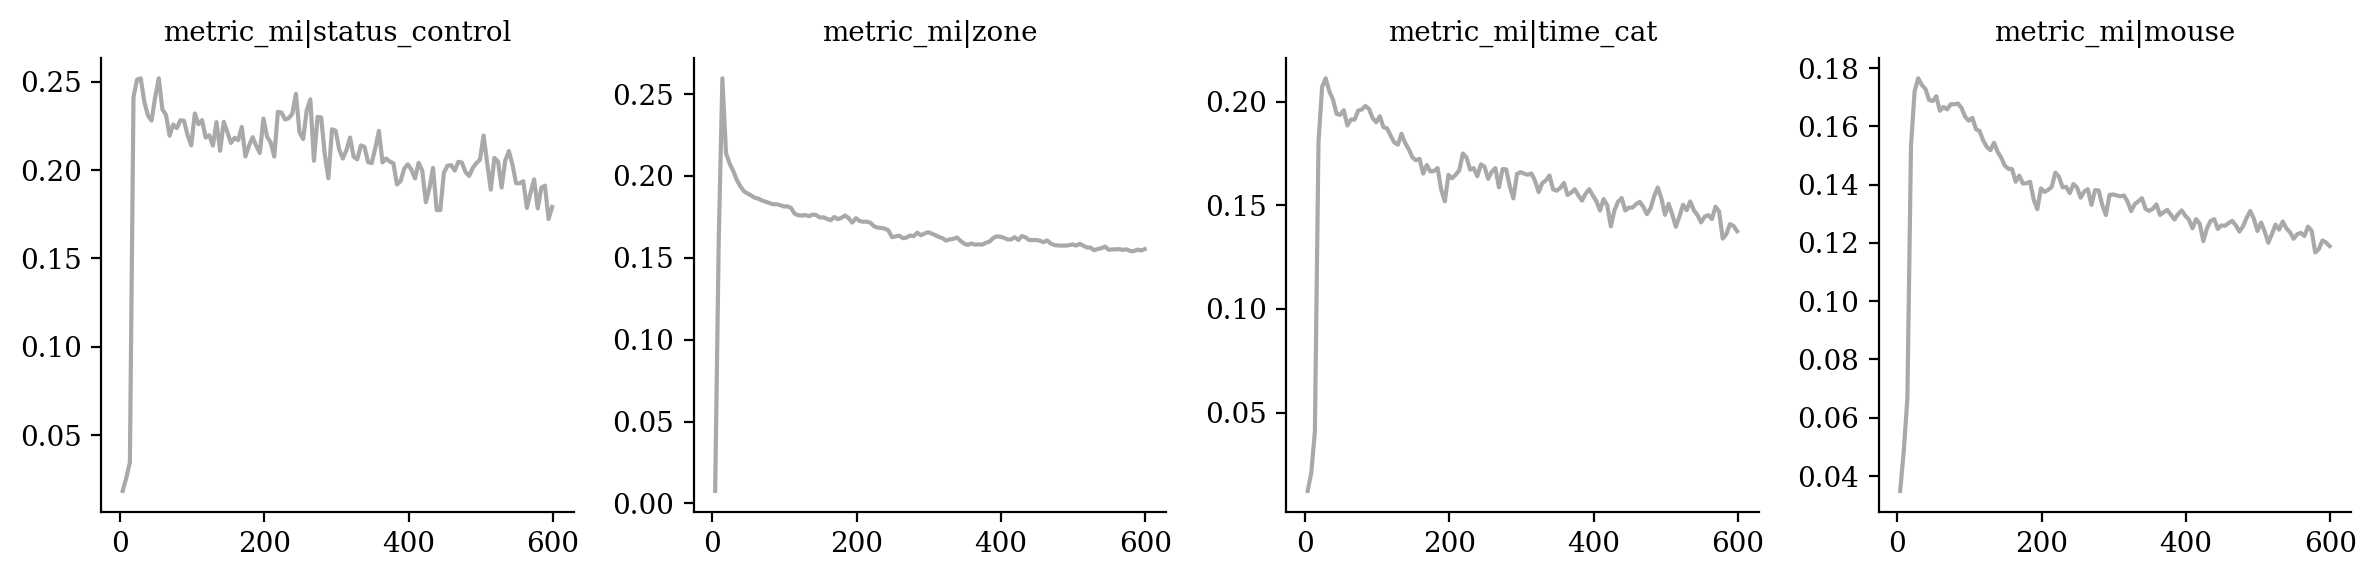

In [11]:
vae.plot_training_history(
    ignore_first=0,
    n_col=4,
    metrics_name=["metric_mi|status_control", "metric_mi|zone", "metric_mi|time_cat", "metric_mi|mouse"]
)

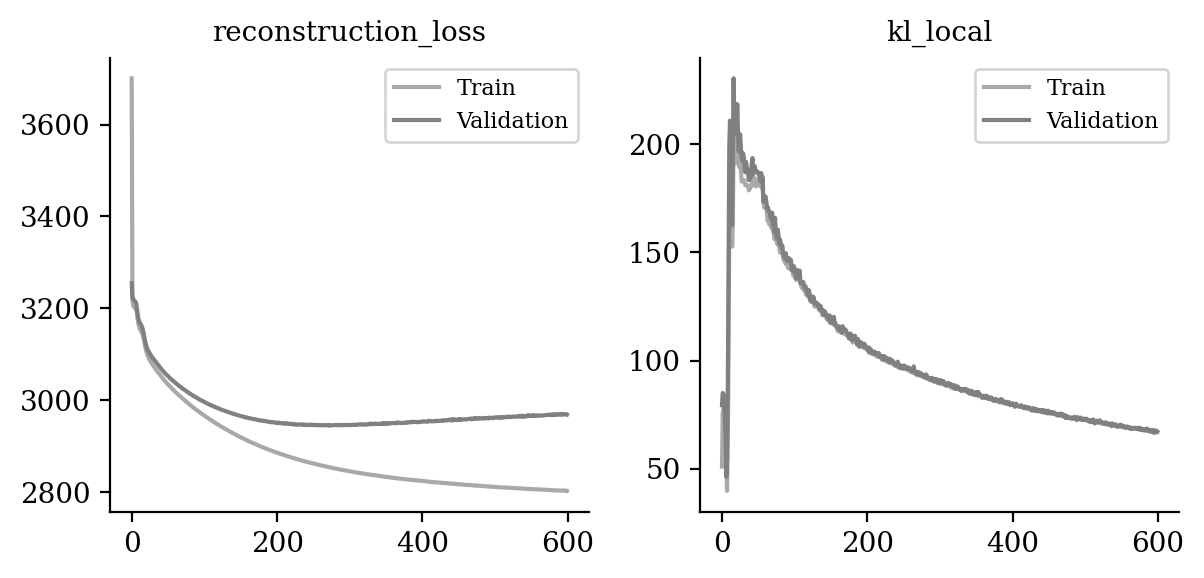

In [12]:
vae.plot_training_history(
    ignore_first=0,
    n_col=4,
    metrics_name=["reconstruction_loss", "kl_local"]
)

In [13]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)

In [14]:
latent.obs["validation"] = "train"
latent.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_2748311/3282183070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latent.obs["validation"].iloc[vae.validation_indices] = "validation"


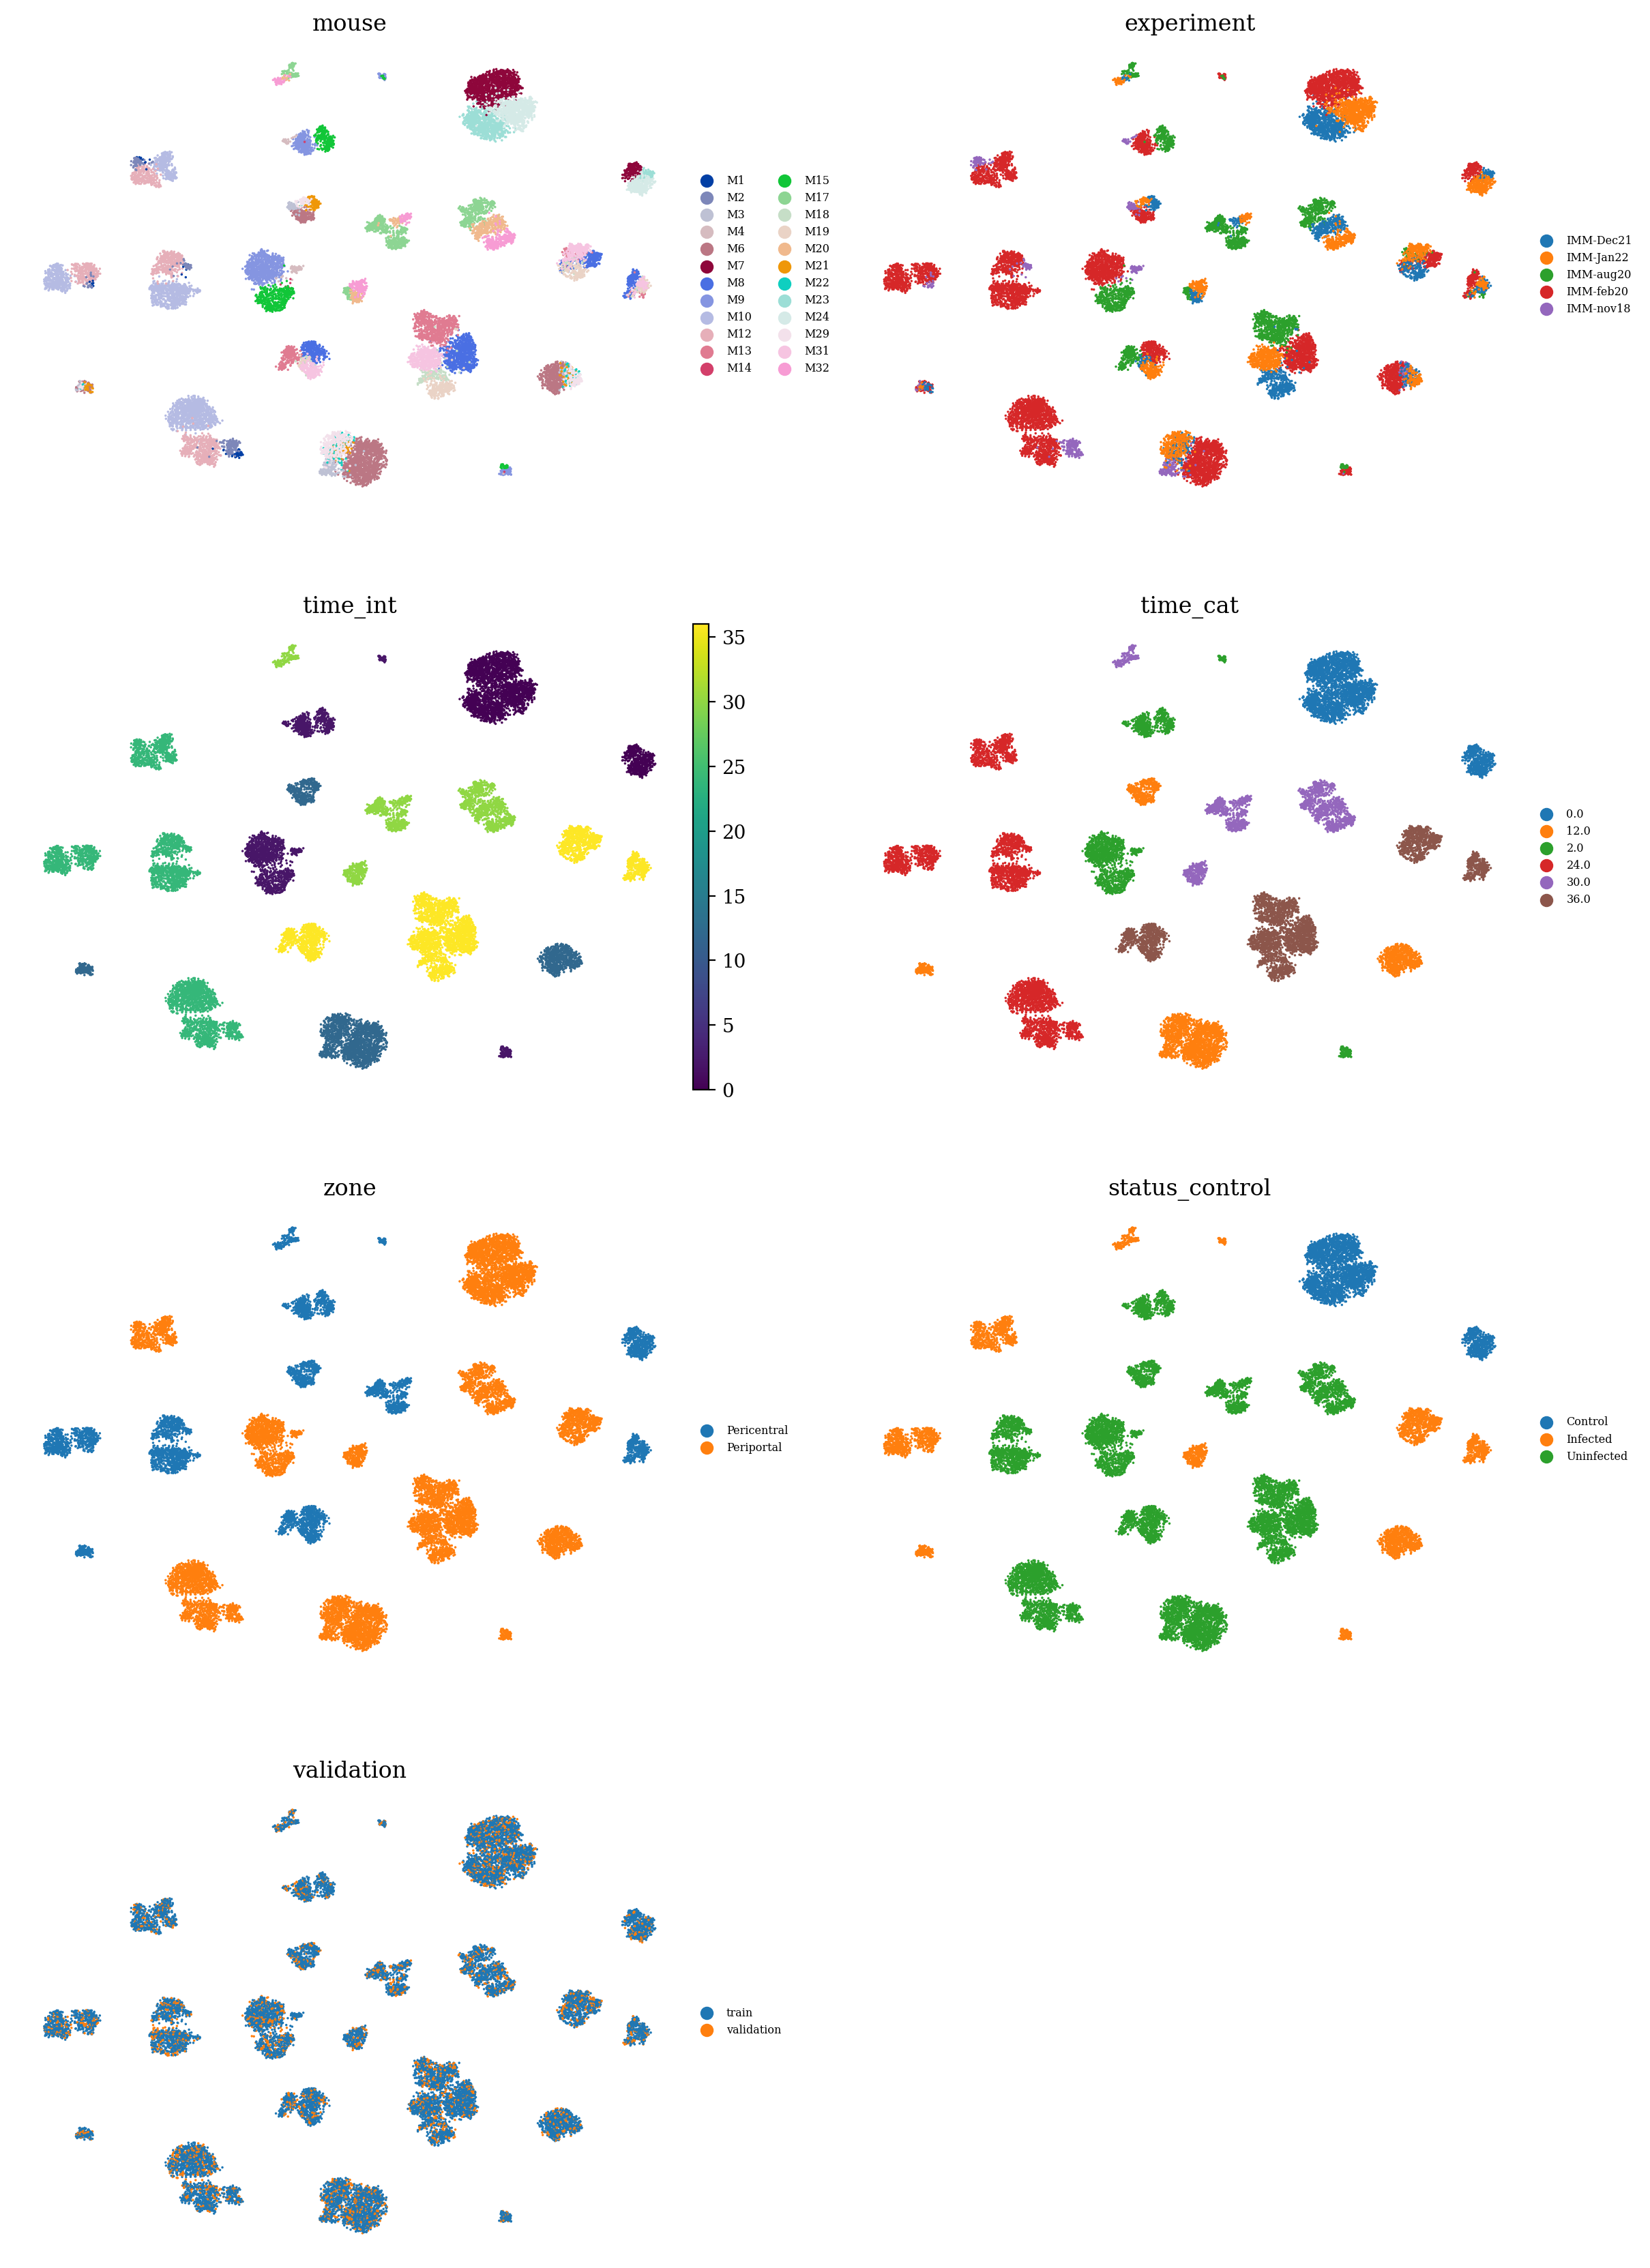

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control', "validation"], 
        ncols=2,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [16]:
latent = ad.AnnData(X=vae.get_latent_representation(indices=vae.validation_indices), obs=adata.obs.copy().iloc[vae.validation_indices, :])
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)

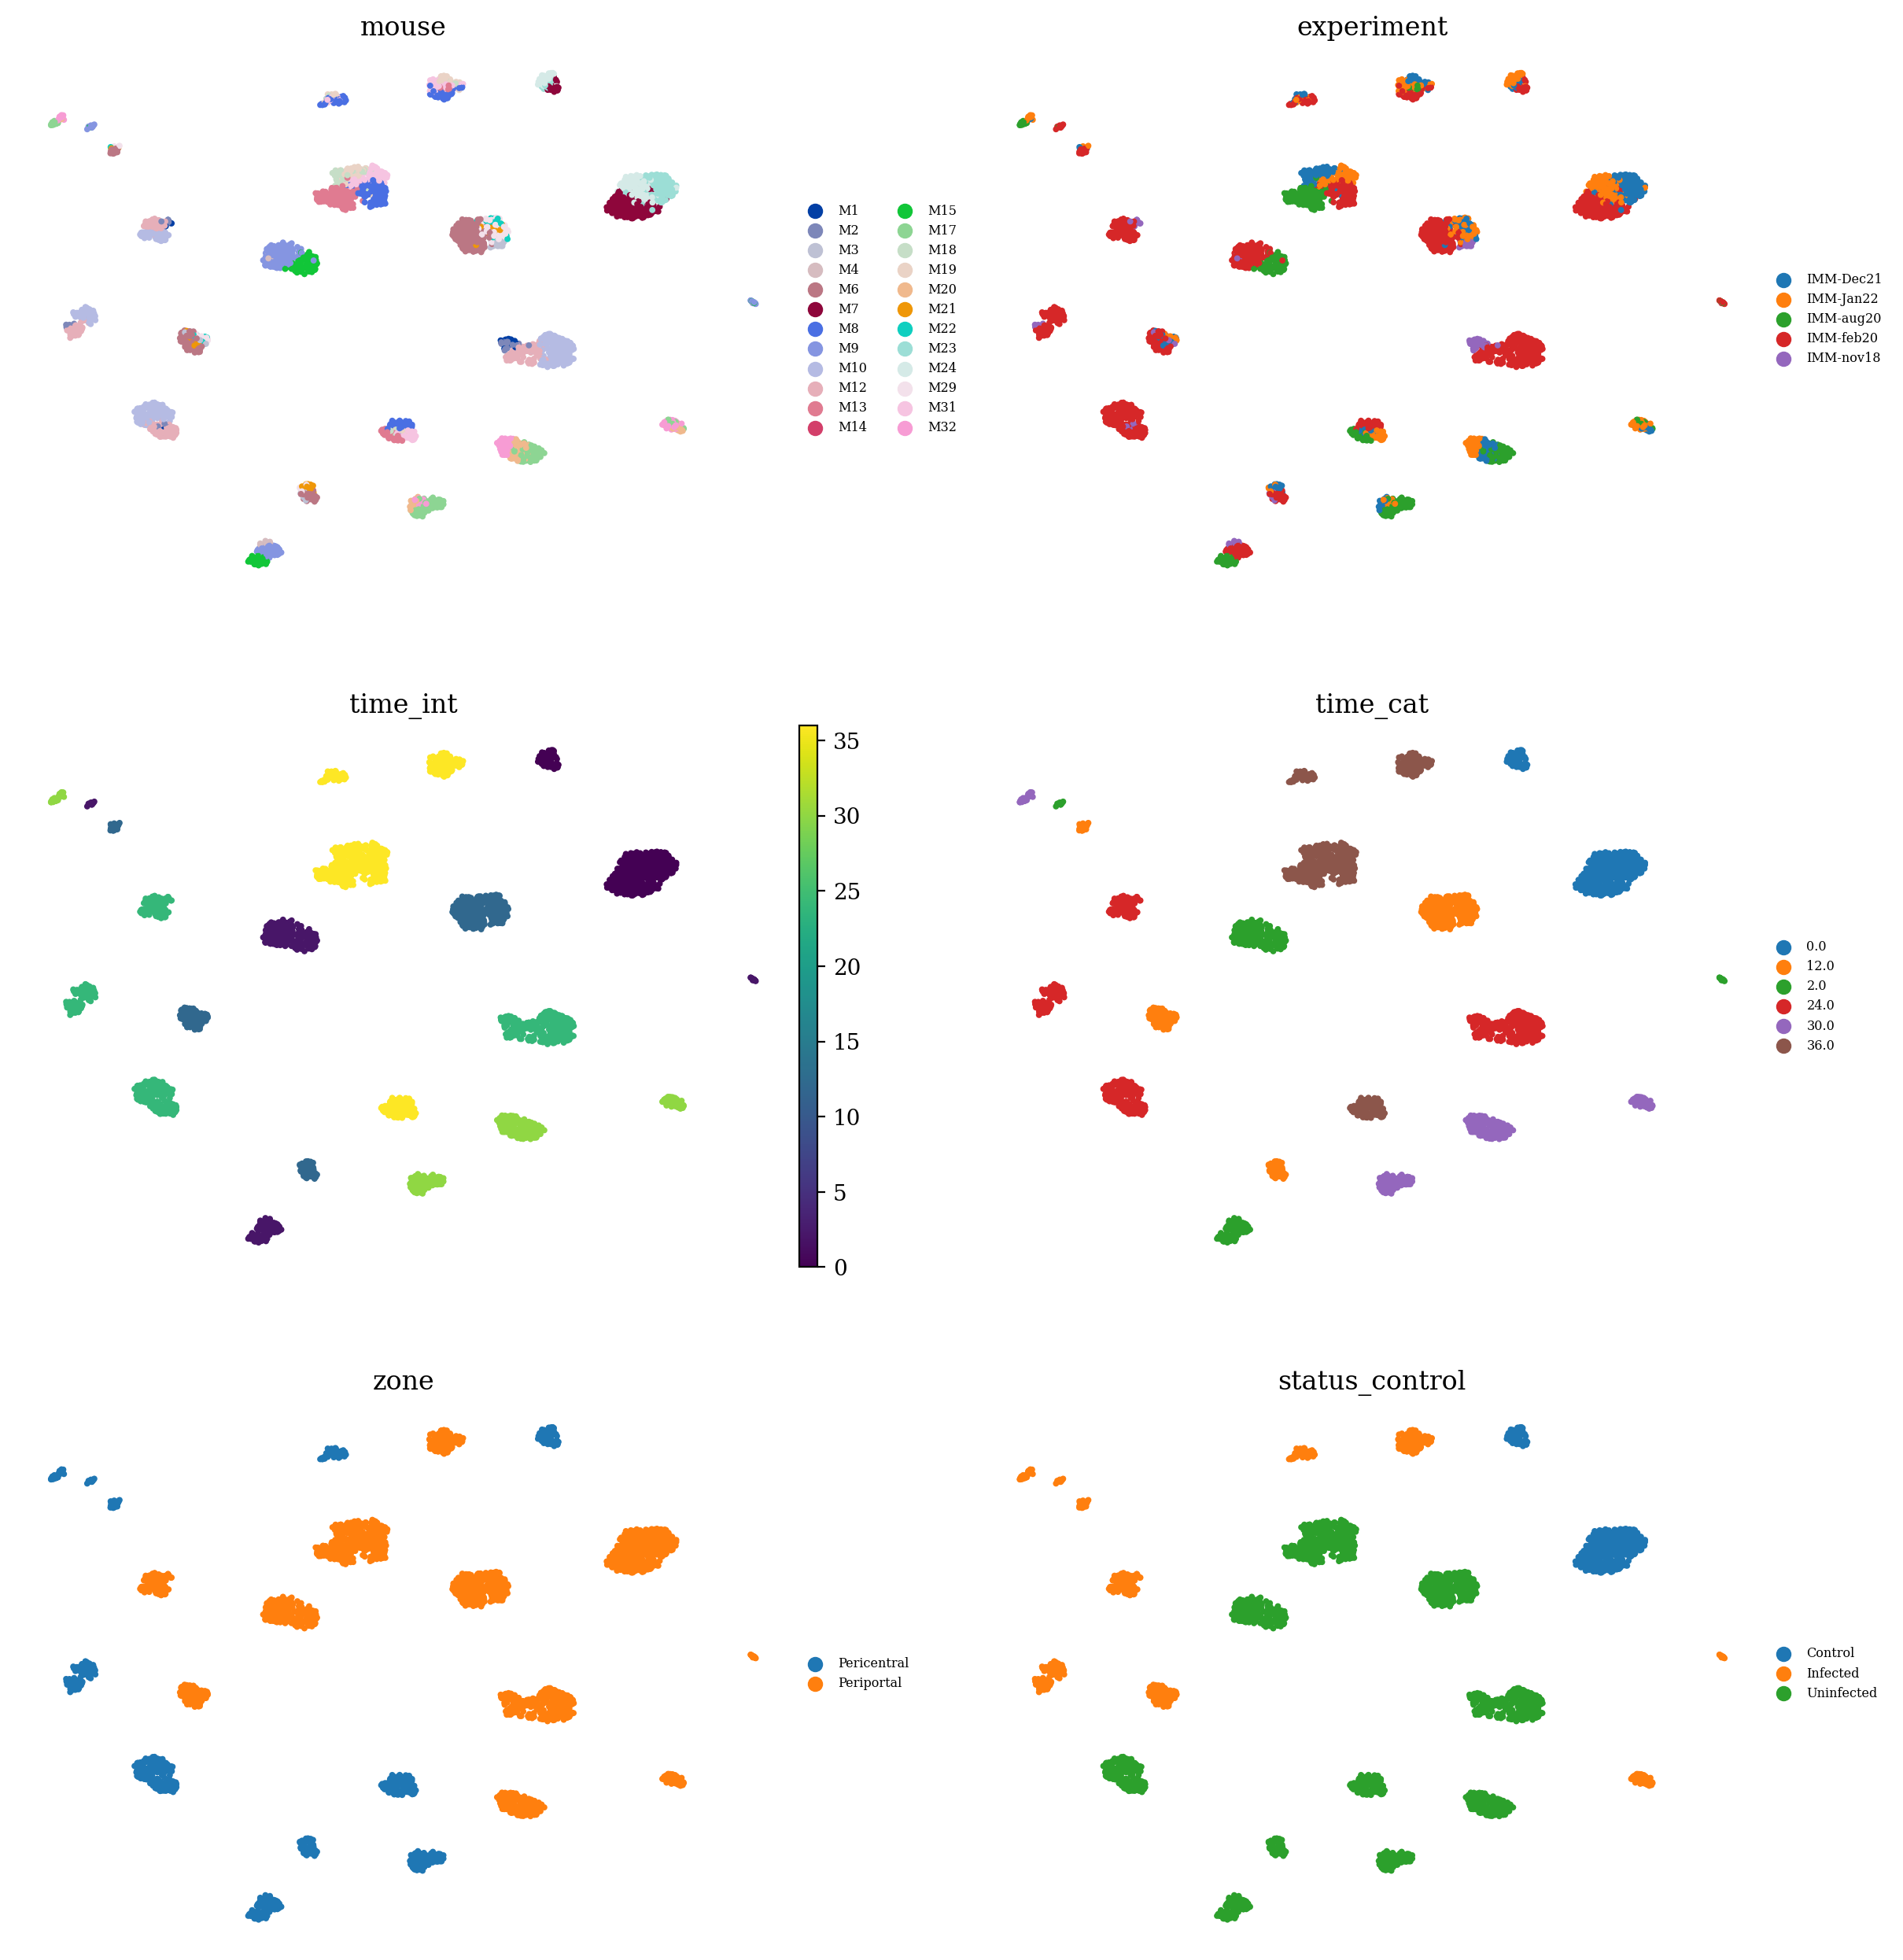

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'], 
        ncols=2,
        frameon=False,
        legend_fontsize="xx-small"
    )